In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn import preprocessing
from NFLUtils import NFLUtils
import optuna
%matplotlib inline
nfl_utils = NFLUtils()

# Set device to GPU if available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def set_all_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Load CSV
cp Combined.csv ~/drive/Notes/ML/Pytorch/footballData/n

In [10]:
df = pd.read_csv("./footballData/CombinedSlidingWindow4.csv", index_col=False, low_memory=False)

# Shuffle dataFrame (don't do this?)
# df = shuffle(df, random_state=101)
# df.head()
df.info()

test_performance_size = 200
test_performance_df = df[df.shape[0]-test_performance_size:]
df = df[:df.shape[0]-test_performance_size]
print(f'df after perf set removed: {df.shape}')
print(f'df perf set size {test_performance_df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4741 entries, 0 to 4740
Columns: 218 entries, Unnamed: 0 to D_datediff
dtypes: float64(142), int64(67), object(9)
memory usage: 7.9+ MB
df after perf set removed: (4541, 218)
df perf set size (200, 218)


# Columns to use
(TODO)

In [11]:
df[:5]

,Unnamed: 0,Season,Date,Home_Team,H_Q1,H_Q2,H_Q3,H_Q4,H_OT,H_Final,...,D_punting_lng,D_punting_pnt,D_punting_yds,D_scoring_fga,D_scoring_fgm,D_scoring_xpa,D_scoring_xpm,D_start_odds,D_halftime_odds,D_datediff
0,248,1999,1999-10-17,PIT,7,7,0,3,0,17,...,-4.808,-0.848,-8.640,-0.472,0.648,0.848,0.632,0.0,0.0,0.0
1,245,1999,1999-10-17,CLE,0,7,0,0,0,7,...,-2.192,2.104,105.232,-1.696,-1.952,-1.032,-1.032,0.0,0.0,1.0
2,244,1999,1999-10-17,PHI,7,13,0,0,0,20,...,3.840,3.008,154.488,-0.440,0.200,-0.808,-0.808,0.0,0.0,0.0
3,243,1999,1999-10-17,OAK,10,3,7,0,0,20,...,5.768,-0.824,-26.624,-1.544,-1.848,1.144,1.144,0.0,0.0,0.0
4,227,1999,1999-10-21,KAN,0,7,7,21,0,35,...,10.312,-1.664,-49.992,-0.728,-0.512,1.096,1.096,0.0,0.0,0.0


## 1. Separate continuous, categorical, and label column names

Pretty much everything is continuous. 

Note: the y_col is what you're trying to predict

## Feature engineering
New Columns
- **h_win**: Home team won


In [12]:
cat_cols = []
cont_cols = [
    # Home vs away days since last game
    'H_datediff', 'V_datediff',
    
    # First Downs
    'H_First_Downs', 'V_First_Downs',
    
    # Basic Stats
    'H_Rush', 'V_Rush',
    'H_Yds', 'V_Yds',
    'H_TDs', 'V_TDs',
    'H_Cmp', 'V_Cmp',
    'H_Att', 'V_Att',
    'H_Yd', 'V_Yd',
    'H_TD', 'V_TD',
    'H_INT', 'V_INT',
    'H_Sacked', 'V_Sacked',
    'H_Yards', 'V_Yards',
    'H_Net_Pass_Yards', 'V_Net_Pass_Yards',
    'H_Total_Yards', 'V_Total_Yards',
    'H_Fumbles', 'V_Fumbles',
    'H_Lost', 'V_Lost',
    'H_Turnovers', 'V_Turnovers',
    'H_Penalties', 'V_Penalties',
    #'H_Third_Down_Conv', 'V_Third_Down_Conv',
    #'H_Fourth_Down_Conv', 'V_Fourth_Down_Conv',
    #'H_Time_of_Possession', 'V_Time_of_Possession',
    
    # Passing Detailed
    'H_passing_att', 'V_passing_att',
    'H_passing_cmp', 'V_passing_cmp',
    'H_passing_int', 'V_passing_int',
    'H_passing_lng', 'V_passing_lng',
    'H_passing_sk', 'V_passing_sk',
    'H_passing_td', 'V_passing_td',
    'H_passing_yds', 'V_passing_yds',
    
    # Receiving
    'H_receiving_lng', 'V_receiving_lng',
    'H_receiving_td', 'V_receiving_td',
    'H_receiving_yds', 'V_receiving_yds',
    
    # Rushing Detailed
    'H_rushing_att', 'V_rushing_att',
    'H_rushing_lng', 'V_rushing_lng',
    'H_rushing_td', 'V_rushing_td',
    'H_rushing_yds', 'V_rushing_yds',
    
    # Defense Interceptions
    'H_def_interceptions_int', 'V_def_interceptions_int',
    'H_def_interceptions_lng', 'V_def_interceptions_lng',
    'H_def_interceptions_pd', 'V_def_interceptions_pd',
    'H_def_interceptions_td', 'V_def_interceptions_td',
    'H_def_interceptions_yds', 'V_def_interceptions_yds',
    
    # Defense Fumbles
    'H_fumbles_ff', 'V_fumbles_ff',
    'H_fumbles_fr', 'V_fumbles_fr',
    'H_fumbles_td', 'V_fumbles_td',
    'H_fumbles_yds', 'V_fumbles_yds',
    
    # Defense Tackles
    'H_sk', 'V_sk',
    'H_tackles_ast', 'V_tackles_ast',
    'H_tackles_comb', 'V_tackles_comb',
    'H_tackles_qbhits', 'V_tackles_qbhits',
    'H_tackles_solo', 'V_tackles_solo',
    'H_tackles_tfl', 'V_tackles_tfl',
    
    # Kick Returns
    'H_kick_returns_lng', 'V_kick_returns_lng',
    'H_kick_returns_rt', 'V_kick_returns_rt',
    'H_kick_returns_td', 'V_kick_returns_td',
    'H_kick_returns_yds', 'V_kick_returns_yds',
    
    # Punt Returns
    'H_punt_returns_lng', 'V_punt_returns_lng',
    'H_punt_returns_ret', 'V_punt_returns_ret',
    'H_punt_returns_td', 'V_punt_returns_td',
    'H_punt_returns_yds', 'V_punt_returns_yds',
    
    # Punting/Scoring
    'H_punting_lng', 'V_punting_lng',
    'H_punting_pnt', 'V_punting_pnt',
    'H_punting_yds', 'V_punting_yds',
    'H_scoring_fga', 'V_scoring_fga',
    'H_scoring_fgm', 'V_scoring_fgm',
    'H_scoring_xpa', 'V_scoring_xpa',
    'H_scoring_xpm', 'V_scoring_xpm',
    
    # Odds
    # 'H_start_odds', 'V_start_odds',
    # 'H_halftime_odds', 'V_halftime_odds'
]

cont_cols = [
    'D_datediff', # Days since last game (Home - visitor)
    
    # first downs
    'D_First_Downs',
    
    # Basic Stats
    'D_Rush',
    'D_Yds',
    'D_TDs',
    'D_Cmp',
    'D_Att',
    'D_Yd',
    'D_TD',
    'D_INT',
    'D_Sacked',
    'D_Yards',
    'D_Net_Pass_Yards',
    'D_Total_Yards',
    'D_Fumbles',
    'D_Lost',
    'D_Turnovers',
    'D_Penalties',
    
    # Passing Detailed
    'D_passing_att',
    'D_passing_cmp',
    'D_passing_int',
    'D_passing_lng',
    'D_passing_sk',
    'D_passing_td',
    'D_passing_yds',
    
    # Receiving
    'D_receiving_lng',
    'D_receiving_td',
    'D_receiving_yds',
    
    # Rushing Detailed
    'D_rushing_att',
    'D_rushing_lng',
    'D_rushing_td',
    'D_rushing_yds',
    
    # Defense interceptions
    'D_def_interceptions_int',
    'D_def_interceptions_lng',
    'D_def_interceptions_pd',
    'D_def_interceptions_td',
    'D_def_interceptions_yds',
    
    # Defense fumbles
    'D_fumbles_ff',
    'D_fumbles_fr',
    'D_fumbles_td',
    'D_fumbles_yds',
    
    # Defense tackles
    'D_sk',
    'D_tackles_ast',
    'D_tackles_comb',
    'D_tackles_qbhits',
    'D_tackles_solo',
    'D_tackles_tfl',
    
    # Kick Returns
    'D_kick_returns_lng',
    'D_kick_returns_rt',
    'D_kick_returns_td',
    'D_kick_returns_yds',
    
    # Punt Returns
    'D_punt_returns_lng',
    'D_punt_returns_ret',
    'D_punt_returns_td',
    'D_punt_returns_yds',
    
    # Punting / Scoring
    'D_punting_lng',
    'D_punting_pnt',
    'D_punting_yds',
    'D_scoring_fga',
    'D_scoring_fgm',
    'D_scoring_xpa',
    'D_scoring_xpm'
]


y_col = ['H_Won']
y_col_perf = ['H_Won', 'H_start_odds', 'V_start_odds', 'H_halftime_odds', 'V_halftime_odds']

# create cont_df and y_df from the df
print(df.shape)
cont_df = df[cont_cols]
y_df = df[y_col]

# test performance set
perf_conts_df = test_performance_df[cont_cols]
perf_y_df = test_performance_df[y_col_perf]

print(cont_df.dtypes)
print(cont_df.shape)

(4541, 218)
D_datediff       float64
D_First_Downs      int64
D_Rush             int64
D_Yds              int64
D_TDs              int64
                  ...   
D_punting_yds    float64
D_scoring_fga    float64
D_scoring_fgm    float64
D_scoring_xpa    float64
D_scoring_xpm    float64
Length: 62, dtype: object
(4541, 62)


## Monotone constraints dict

In [13]:
monotone_constraints = {
    # Time between games - More rest is better
    'D_datediff': 1,
    
    # Offensive positive indicators
    'D_First_Downs': 1,
    'D_Rush': 1,
    'D_Yds': 1,
    'D_TDs': 1,
    'D_Cmp': 1,
    'D_Yd': 1,
    'D_TD': 1,
    'D_Net_Pass_Yards': 1,
    'D_Total_Yards': 1,
    
    # Negative indicators
    'D_INT': -1,
    'D_Sacked': -1,
    'D_Fumbles': -1,
    'D_Lost': -1,
    'D_Turnovers': -1,
    'D_Penalties': -1,
    
    # Passing detail - positive
    'D_passing_cmp': 1,
    'D_passing_td': 1,
    'D_passing_yds': 1,
    'D_passing_lng': 1,
    
    # Passing detail - negative
    'D_passing_int': -1,
    'D_passing_sk': -1,
    
    # Receiving/Rushing - all positive
    'D_receiving_td': 1,
    'D_receiving_yds': 1,
    'D_receiving_lng': 1,
    'D_rushing_td': 1,
    'D_rushing_yds': 1,
    'D_rushing_lng': 1,
    
    # Defense - generally positive when in your favor
    'D_def_interceptions_int': 1,
    'D_def_interceptions_td': 1,
    'D_def_interceptions_yds': 1,
    'D_fumbles_fr': 1,
    'D_fumbles_td': 1,
    'D_sk': 1,
    'D_tackles_qbhits': 1,
    'D_tackles_tfl': 1,
    
    # Special teams - positive indicators
    'D_kick_returns_td': 1,
    'D_kick_returns_yds': 1,
    'D_punt_returns_td': 1,
    'D_punt_returns_yds': 1,
    
    # Scoring - positive
    'D_scoring_fgm': 1,
    'D_scoring_xpm': 1
}

monotone_constraints_tuple = ()
no_monotone_constraints_tuple = ()
for col in cont_cols:
    monotone_constraints_tuple = monotone_constraints_tuple + (monotone_constraints[col],) if col in monotone_constraints else monotone_constraints_tuple + (0,)
    no_monotone_constraints_tuple = no_monotone_constraints_tuple + (0,)
print(monotone_constraints_tuple)
print(no_monotone_constraints_tuple)

(1, 1, 1, 1, 1, 1, 0, 1, 1, -1, -1, 0, 1, 1, -1, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


#### 1a. Normalize cont_df
StandardScaler is instead used by the pipeline

In [14]:
# min_max_scaler = preprocessing.MinMaxScaler()
# cont_scaled = min_max_scaler.fit_transform(cont_df.values)
# cont_df = pd.DataFrame(cont_scaled)
# cont_df.head()

# # test performance set
# perf_conts_df_scaled = min_max_scaler.fit_transform(perf_conts_df.values)
# perf_conts_df = pd.DataFrame(perf_conts_df_scaled)

### 3. Create an array of continuous values
Numpy array 'conts' containing stack of each continuous column

In [15]:
conts = np.stack([cont_df[col].values for col in list(cont_df.columns)], 1)
conts[:5]

y_col = np.stack([y_df[col].values for col in y_col], 1)

# test performance set
perf_conts = np.stack([perf_conts_df[col].values for col in list(perf_conts_df.columns)], 1)
perf_y_col = np.stack([perf_y_df[col].values for col in list(perf_y_df.columns)], 1)


conts_train = conts
y_train = y_col

### 4. Convert conts to tensor

In [16]:
print(conts.shape)
print(y_col.shape)

(4541, 62)
(4541, 1)


In [17]:
# Handled by model.fit()
# conts = torch.tensor(conts, dtype=torch.float32)
# y_col = torch.tensor(y_col, dtype=torch.float32)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import logging
# Set up logging
logging.basicConfig(level=logging.INFO)

In [19]:
class TabularModel(nn.Module, BaseEstimator, ClassifierMixin):
    def __init__(self, n_cont, out_sz, layer_shape, p=0.5, criterion=nn.BCELoss(),
                optimizer_class=torch.optim.Adam, lr=0.001, n_epochs=10, confidence_threshold=0.1):
        super().__init__()
        # Model architecture params
        self.layer_shape = layer_shape
        self.n_cont = n_cont
        self.out_sz = out_sz
        self.p = p
        self.lr = lr
        
        # Training params
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.n_epochs = n_epochs
        self.confidence_threshold = confidence_threshold
        
        # BatchNorm layer for continuous data
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Variable that holds the list of layers
        layerlist = []
        n_in = n_cont # no embed again
        # Iterate through the passed in "layers" parameter (ie, [200,100]) to build a list of layers
        for i, width in enumerate(self.layer_shape):
            # First layer gets special treatment
            if i == 0:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.ReLU(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p/2)  # Less dropout in earlier layers
                ])
            else:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.ReLU(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p)
                ])
            n_in = width
        # layerlist.append(nn.Linear(layers[-1], out_sz))
        
        # Final layer
        layerlist.extend([
            nn.Linear(self.layer_shape[-1], out_sz),
            # nn.Sigmoid()  # Ensures output between 0 and 1
        ])
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cont):
        x_cont = self.bn_cont(x_cont)  # Normalize the incoming continuous data
        x = self.layers(x_cont)        # Set up model layers
        return x
    
    def fit(self, X, y):
        """
        For sklearn pipeline
        """
        # Convert X,y to torch.tensor if needed
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)
        
        # Initialize optimizer
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        
        # Training loop
        self.train()
        for _ in range(self.n_epochs):
            optimizer.zero_grad()
            y_pred = self.forward(X)
            loss = self.criterion(y_pred, y)
            loss.backward()
            optimizer.step()

        return self
    
    def predict(self, X):
        probas = self.predict_proba(X)
        # return (probas > 0.5).astype(int)
        return probas
    
    def predict_proba(self, X):
        self.eval()
        with torch.no_grad():
            if not isinstance(X, torch.Tensor):
                X = torch.FloatTensor(X)
            return self(X).numpy()
    
    def score(self, X, y):
        """        
        12/5 - this isn't called at all if 'scoring' is defined
        """
        probas = self.predict_proba(X)
        # First apply confidence thresholding
        mask = (probas < 0.5 - self.confidence_threshold) | (probas > 0.5 + self.confidence_threshold)
        predictions = np.where(mask, (probas > 0.5).astype(np.int32), np.nan)

        # Use numpy mask for nan values
        valid_mask = ~np.isnan(predictions)
        valid_predictions = predictions[valid_mask]
        valid_targets = y[valid_mask]
        
        # Apply f1 score
        score = f1_score(valid_predictions.flatten(), valid_targets)
        return np.mean(score)

In [20]:
class TabularModelUpdated(nn.Module, BaseEstimator, ClassifierMixin):
    def __init__(self, n_cont, out_sz, layer_shape, p=0.5, criterion=nn.MSELoss(),
                optimizer_class=torch.optim.Adam, lr=0.001, confidence_threshold=0.1):
        super().__init__()
        # Model architecture params
        self.layer_shape = layer_shape
        self.n_cont = n_cont
        self.out_sz = out_sz
        self.p = p
        self.lr = lr
        
        # Training params
        self.criterion = criterion
        self.confidence_threshold = confidence_threshold
        
        # BatchNorm layer for continuous data
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Variable that holds the list of layers
        layerlist = []
        n_in = n_cont # no embed again
        # Iterate through the passed in "layers" parameter (ie, [200,100]) to build a list of layers
        for i, width in enumerate(self.layer_shape):
            # First layer gets special treatment
            if i == 0:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.ReLU(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p/2)  # Less dropout in earlier layers
                ])
            else:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.ReLU(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p)
                ])
            n_in = width
        # layerlist.append(nn.Linear(layers[-1], out_sz))
        
        # Final layer
        layerlist.extend([
            nn.Linear(self.layer_shape[-1], out_sz),
            # nn.Sigmoid()  # Ensures output between 0 and 1
        ])
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
        # Initialize the optimizer
        self.optimizer = optimizer_class(self.parameters(), lr=self.lr)

        
    def forward(self, x_cont):
        x_cont = self.bn_cont(x_cont)  # Normalize the incoming continuous data
        x = self.layers(x_cont)        # Set up model layers
        return x
    
    def fit(self, X, y):
        """
        For sklearn pipeline
        """
        # Convert X,y to torch.tensor if needed
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)
        
        # Initialize optimizer
        # optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        # Training loop
        self.train()
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return self
    
    def predict(self, X):
        probas = self.predict_proba(X)
        return (probas > 0.5).astype(int)
        # return probas
    
    def predict_proba(self, X):
        self.eval()
        with torch.no_grad():
            if not isinstance(X, torch.Tensor):
                X = torch.FloatTensor(X)
            return self(X).numpy()
    
    def score(self, X, y):
        """        
        12/5 - this isn't called at all if 'scoring' is defined
        """
        probas = self.predict_proba(X)
        # First apply confidence thresholding
        mask = (probas < 0.5 - self.confidence_threshold) | (probas > 0.5 + self.confidence_threshold)
        predictions = np.where(mask, (probas > 0.5).astype(np.int32), np.nan)

        # Use numpy mask for nan values
        valid_mask = ~np.isnan(predictions)
        valid_predictions = predictions[valid_mask]
        valid_targets = y[valid_mask]
        
        # Penalize if < 80% predicted
        if (1.0* len(valid_predictions) / len(X)) < 0.85:
            # print(f"mask {len(valid_predictions)}  pred {len(X)}")
            return 0.0

        # Apply f1 score
        score = f1_score(valid_predictions.flatten(), valid_targets)
        return score

In [14]:
def objective(trial):
    # --- Suggest hyperparameters ---

    criterion = trial.suggest_categorical('criterion', nfl_utils.map_losses(None).keys())
    first_layer_size = trial.suggest_categorical('first_layer_size', [64, 56, 48, 32, 16, 12])
    min_layers = math.floor(math.sqrt(first_layer_size))
    num_layers = trial.suggest_int('num_layers', 2, min_layers)
    confidence_threshold = trial.suggest_float('confidence_threshold', 0, 0.05)
    layer_shape = [first_layer_size]
    for i in range(1, num_layers):
        layer_shape.append(first_layer_size//(2*i))
    
    # Set random state to have consistent results (42 is arbitrary)
    set_all_seeds()
    
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=False)

    # Split once
    X_train_fold = []
    X_val = []
    y_train_fold = []
    y_val = []
    models = []
    for train_index, val_index in kf.split(conts_train):
        # print(f"train {train_index.shape} val {val_index.shape}")
        X_train_fold.append(torch.FloatTensor(conts_train[train_index]).to(device))
        X_val.append(torch.FloatTensor(conts_train[val_index]).to(device))

        y_train_fold.append(torch.FloatTensor(y_train[train_index]).to(device))
        y_val.append(torch.FloatTensor(y_train[val_index]).to(device))

        model = TabularModelUpdated(
            n_cont=conts.shape[1],
            out_sz=1,
            layer_shape=layer_shape,
            p=trial.suggest_float('dropout', 0.28, 0.38),     # Dropout
            criterion=nfl_utils.map_losses(criterion),
            optimizer_class=torch.optim.Adam,
            lr=trial.suggest_float('lr', 1e-3, 1e-2, log=True),   # Learning rate 
            confidence_threshold=confidence_threshold
        )
        pipeline = Pipeline([
            ('scaler', StandardScaler()), # Standardize the numerical features
            # ('regressor', LinearRegression()), # Apply a regression model
            ('model', model)
        ])
        models.append(pipeline)

    # Run once on each split, track average loss, stop if > max patience
    max_patience = 10
    current_patience = max_patience
    tracked_loss = 0.0
    n_epochs = 0
    while current_patience > 0 or n_epochs < 100:
        n_epochs = n_epochs + 1
        running_loss = []
        for i in range(0,n_splits):
            # ----- Train -----
            models[i].fit(X_train_fold[i], y_train_fold[i])

            # ----- Eval -----
            running_loss.append(models[i].score(X_val[i], y_val[i]))
            # y_pred = models[i].predict(X_val[i])
            # running_loss.append(f1_score(y_val[i], y_pred))
        running_loss = np.mean(running_loss)

        # ----- Current epoch loss > previous -----
        # print(f"{tracked_loss} {running_loss} {tracked_loss < running_loss}")
        if tracked_loss < running_loss:
            current_patience = max_patience
            tracked_loss = running_loss
        else:
            current_patience = current_patience - 1
    trial.suggest_int('n_epochs', n_epochs, n_epochs)
    trial.report(tracked_loss, n_epochs)
    return tracked_loss

def print_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value}")
    print(f"Best trial so far: {study.best_trial.number}, value: {study.best_trial.value}")

In [15]:
study = optuna.create_study(
    direction='maximize',   # max because using f1
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=1000
    )
)
# Uncomment to run
if True:
    study.optimize(objective, n_trials=2000, callbacks=[print_callback])
    # study.optimize(objective, n_trials=3)
    print("Best trial:")
    trial = study.best_trial
    print("Value: ", trial.value)
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2024-12-08 19:14:18,245] A new study created in memory with name: no-name-42392a07-8dcb-4c53-ab9b-edc9790279e7
[I 2024-12-08 19:14:22,731] Trial 0 finished with value: 0.43131596728962257 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.02357638913851849, 'dropout': 0.34918177444950543, 'lr': 0.005362658570915581, 'n_epochs': 155}. Best is trial 0 with value: 0.43131596728962257.


Trial 0 finished with value: 0.43131596728962257
Best trial so far: 0, value: 0.43131596728962257


[I 2024-12-08 19:14:25,876] Trial 1 finished with value: 0.07213273078668195 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0419089273904206, 'dropout': 0.37623035886947537, 'lr': 0.0010536093056005085, 'n_epochs': 100}. Best is trial 0 with value: 0.43131596728962257.


Trial 1 finished with value: 0.07213273078668195
Best trial so far: 0, value: 0.43131596728962257


[I 2024-12-08 19:14:30,293] Trial 2 finished with value: 0.2429733425485972 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.009832913171771058, 'dropout': 0.3448296743650795, 'lr': 0.0020423095289201767, 'n_epochs': 100}. Best is trial 0 with value: 0.43131596728962257.


Trial 2 finished with value: 0.2429733425485972
Best trial so far: 0, value: 0.43131596728962257


[I 2024-12-08 19:14:35,771] Trial 3 finished with value: 0.0718606776832092 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.03518023073373398, 'dropout': 0.2866911162669335, 'lr': 0.0010126780838470072, 'n_epochs': 177}. Best is trial 0 with value: 0.43131596728962257.


Trial 3 finished with value: 0.0718606776832092
Best trial so far: 0, value: 0.43131596728962257


[I 2024-12-08 19:14:42,793] Trial 4 finished with value: 0.07265917602996254 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.04234197761433138, 'dropout': 0.2988233447812593, 'lr': 0.0016323156209569628, 'n_epochs': 100}. Best is trial 0 with value: 0.43131596728962257.


Trial 4 finished with value: 0.07265917602996254
Best trial so far: 0, value: 0.43131596728962257


[I 2024-12-08 19:14:47,295] Trial 5 finished with value: 0.2916216727162735 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 56, 'num_layers': 3, 'confidence_threshold': 0.03752228039441639, 'dropout': 0.37407351785142284, 'lr': 0.008389508713280014, 'n_epochs': 100}. Best is trial 0 with value: 0.43131596728962257.


Trial 5 finished with value: 0.2916216727162735
Best trial so far: 0, value: 0.43131596728962257


[I 2024-12-08 19:14:55,827] Trial 6 finished with value: 0.038104500595382826 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.03736881834154434, 'dropout': 0.28098335763050947, 'lr': 0.0012602279897866483, 'n_epochs': 119}. Best is trial 0 with value: 0.43131596728962257.


Trial 6 finished with value: 0.038104500595382826
Best trial so far: 0, value: 0.43131596728962257


[I 2024-12-08 19:15:00,925] Trial 7 finished with value: 0.4809136205344955 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 2, 'confidence_threshold': 0.021927807683014378, 'dropout': 0.35903186071753757, 'lr': 0.00493089180227347, 'n_epochs': 123}. Best is trial 7 with value: 0.4809136205344955.


Trial 7 finished with value: 0.4809136205344955
Best trial so far: 7, value: 0.4809136205344955


[I 2024-12-08 19:15:04,912] Trial 8 finished with value: 0.44428571674395584 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 2, 'confidence_threshold': 0.012888674284847614, 'dropout': 0.2800174252027116, 'lr': 0.006803664761756497, 'n_epochs': 108}. Best is trial 7 with value: 0.4809136205344955.


Trial 8 finished with value: 0.44428571674395584
Best trial so far: 7, value: 0.4809136205344955


[I 2024-12-08 19:15:12,533] Trial 9 finished with value: 0.44969113216565476 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 2, 'confidence_threshold': 0.02814362904901173, 'dropout': 0.34315484090712667, 'lr': 0.0031507057586268408, 'n_epochs': 207}. Best is trial 7 with value: 0.4809136205344955.


Trial 9 finished with value: 0.44969113216565476
Best trial so far: 7, value: 0.4809136205344955


[I 2024-12-08 19:15:20,657] Trial 10 finished with value: 0.2178008191451275 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.003928664202028375, 'dropout': 0.3178242970181927, 'lr': 0.004214873181045659, 'n_epochs': 137}. Best is trial 7 with value: 0.4809136205344955.


Trial 10 finished with value: 0.2178008191451275
Best trial so far: 7, value: 0.4809136205344955


[I 2024-12-08 19:15:25,139] Trial 11 finished with value: 0.08758924172620586 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 3, 'confidence_threshold': 0.022778810698671003, 'dropout': 0.35173778409648315, 'lr': 0.002674178214563248, 'n_epochs': 100}. Best is trial 7 with value: 0.4809136205344955.


Trial 11 finished with value: 0.08758924172620586
Best trial so far: 7, value: 0.4809136205344955


[I 2024-12-08 19:15:34,186] Trial 12 finished with value: 0.2671587876156214 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.030697173140400717, 'dropout': 0.32832987682966064, 'lr': 0.003735837117705647, 'n_epochs': 164}. Best is trial 7 with value: 0.4809136205344955.


Trial 12 finished with value: 0.2671587876156214
Best trial so far: 7, value: 0.4809136205344955


[I 2024-12-08 19:15:40,939] Trial 13 finished with value: 0.43409130338266183 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 2, 'confidence_threshold': 0.01752772217635439, 'dropout': 0.36136127821179737, 'lr': 0.0028179865002374966, 'n_epochs': 186}. Best is trial 7 with value: 0.4809136205344955.


Trial 13 finished with value: 0.43409130338266183
Best trial so far: 7, value: 0.4809136205344955


[I 2024-12-08 19:15:46,582] Trial 14 finished with value: 0.020144300144300145 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.04920941497653361, 'dropout': 0.33136938686530965, 'lr': 0.004985417011674654, 'n_epochs': 100}. Best is trial 7 with value: 0.4809136205344955.


Trial 14 finished with value: 0.020144300144300145
Best trial so far: 7, value: 0.4809136205344955


[I 2024-12-08 19:16:00,810] Trial 15 finished with value: 0.4347260280943008 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 3, 'confidence_threshold': 0.029603528507375465, 'dropout': 0.364024281408171, 'lr': 0.0021680646352391117, 'n_epochs': 301}. Best is trial 7 with value: 0.4809136205344955.


Trial 15 finished with value: 0.4347260280943008
Best trial so far: 7, value: 0.4809136205344955


[I 2024-12-08 19:16:13,695] Trial 16 finished with value: 0.1369282137106605 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.018503719667218265, 'dropout': 0.33593972662660054, 'lr': 0.009141891219386812, 'n_epochs': 172}. Best is trial 7 with value: 0.4809136205344955.


Trial 16 finished with value: 0.1369282137106605
Best trial so far: 7, value: 0.4809136205344955


[I 2024-12-08 19:16:21,984] Trial 17 finished with value: 0.3126133410364469 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.028097628761164964, 'dropout': 0.31316558081394347, 'lr': 0.0035162464297943787, 'n_epochs': 167}. Best is trial 7 with value: 0.4809136205344955.


Trial 17 finished with value: 0.3126133410364469
Best trial so far: 7, value: 0.4809136205344955


[I 2024-12-08 19:16:32,338] Trial 18 finished with value: 0.4934480205665075 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.019295259591514506, 'dropout': 0.3634092893576442, 'lr': 0.006279985493256114, 'n_epochs': 183}. Best is trial 18 with value: 0.4934480205665075.


Trial 18 finished with value: 0.4934480205665075
Best trial so far: 18, value: 0.4934480205665075


[I 2024-12-08 19:16:41,921] Trial 19 finished with value: 0.36010039891811285 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.0008080453962237381, 'dropout': 0.3631327399298986, 'lr': 0.0062047312611348045, 'n_epochs': 168}. Best is trial 18 with value: 0.4934480205665075.


Trial 19 finished with value: 0.36010039891811285
Best trial so far: 18, value: 0.4934480205665075


[I 2024-12-08 19:16:48,561] Trial 20 finished with value: 0.1707000109709922 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.01102258025435579, 'dropout': 0.3572264481297831, 'lr': 0.007381996179914515, 'n_epochs': 100}. Best is trial 18 with value: 0.4934480205665075.


Trial 20 finished with value: 0.1707000109709922
Best trial so far: 18, value: 0.4934480205665075


[I 2024-12-08 19:16:58,415] Trial 21 finished with value: 0.4704702869719465 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.018845713372507462, 'dropout': 0.3428109324631261, 'lr': 0.004618815169704664, 'n_epochs': 186}. Best is trial 18 with value: 0.4934480205665075.


Trial 21 finished with value: 0.4704702869719465
Best trial so far: 18, value: 0.4934480205665075


[I 2024-12-08 19:17:08,068] Trial 22 finished with value: 0.48550683387575155 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.018646232089170506, 'dropout': 0.3695088007653693, 'lr': 0.005063884798198749, 'n_epochs': 182}. Best is trial 18 with value: 0.4934480205665075.


Trial 22 finished with value: 0.48550683387575155
Best trial so far: 18, value: 0.4934480205665075


[I 2024-12-08 19:17:14,574] Trial 23 finished with value: 0.18711771858581688 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.015196933023579745, 'dropout': 0.36755900370433287, 'lr': 0.005996462477396914, 'n_epochs': 100}. Best is trial 18 with value: 0.4934480205665075.


Trial 23 finished with value: 0.18711771858581688
Best trial so far: 18, value: 0.4934480205665075


[I 2024-12-08 19:17:21,295] Trial 24 finished with value: 0.04975322329492369 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.021856537118940297, 'dropout': 0.37683928942235767, 'lr': 0.004229976815545716, 'n_epochs': 114}. Best is trial 18 with value: 0.4934480205665075.


Trial 24 finished with value: 0.04975322329492369
Best trial so far: 18, value: 0.4934480205665075


[I 2024-12-08 19:17:28,229] Trial 25 finished with value: 0.4819281051377793 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.007571429801523696, 'dropout': 0.3692521294350154, 'lr': 0.007658903134721547, 'n_epochs': 130}. Best is trial 18 with value: 0.4934480205665075.


Trial 25 finished with value: 0.4819281051377793
Best trial so far: 18, value: 0.4934480205665075


[I 2024-12-08 19:17:34,560] Trial 26 finished with value: 0.5011510145267417 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.006616316432513163, 'dropout': 0.3721914453005523, 'lr': 0.009962787242131586, 'n_epochs': 116}. Best is trial 26 with value: 0.5011510145267417.


Trial 26 finished with value: 0.5011510145267417
Best trial so far: 26, value: 0.5011510145267417


[I 2024-12-08 19:17:44,485] Trial 27 finished with value: 0.32921033433375674 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.005951895957538843, 'dropout': 0.37782728978788693, 'lr': 0.00999635806892303, 'n_epochs': 140}. Best is trial 26 with value: 0.5011510145267417.


Trial 27 finished with value: 0.32921033433375674
Best trial so far: 26, value: 0.5011510145267417


[I 2024-12-08 19:17:51,472] Trial 28 finished with value: 0.47636323746043174 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 3, 'confidence_threshold': 0.013183991753082174, 'dropout': 0.3539027730476259, 'lr': 0.005904345258529955, 'n_epochs': 141}. Best is trial 26 with value: 0.5011510145267417.


Trial 28 finished with value: 0.47636323746043174
Best trial so far: 26, value: 0.5011510145267417


[I 2024-12-08 19:18:00,995] Trial 29 finished with value: 0.43647682246899855 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0005088029854640116, 'dropout': 0.37081663976711365, 'lr': 0.008390252997347978, 'n_epochs': 197}. Best is trial 26 with value: 0.5011510145267417.


Trial 29 finished with value: 0.43647682246899855
Best trial so far: 26, value: 0.5011510145267417


[I 2024-12-08 19:18:05,374] Trial 30 finished with value: 0.11864057672502577 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.024807363126201073, 'dropout': 0.3798334855514543, 'lr': 0.005596603409985688, 'n_epochs': 100}. Best is trial 26 with value: 0.5011510145267417.


Trial 30 finished with value: 0.11864057672502577
Best trial so far: 26, value: 0.5011510145267417


[I 2024-12-08 19:18:12,899] Trial 31 finished with value: 0.4898953840701187 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.007345901252132974, 'dropout': 0.3697857834989429, 'lr': 0.007354236299219917, 'n_epochs': 138}. Best is trial 26 with value: 0.5011510145267417.


Trial 31 finished with value: 0.4898953840701187
Best trial so far: 26, value: 0.5011510145267417


[I 2024-12-08 19:18:23,132] Trial 32 finished with value: 0.5039514502312012 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.007918399075383022, 'dropout': 0.36885522363997514, 'lr': 0.006785655749369697, 'n_epochs': 167}. Best is trial 32 with value: 0.5039514502312012.


Trial 32 finished with value: 0.5039514502312012
Best trial so far: 32, value: 0.5039514502312012


[I 2024-12-08 19:18:34,266] Trial 33 finished with value: 0.5313415121473695 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.007932072200850869, 'dropout': 0.3511390698911712, 'lr': 0.006962155643115938, 'n_epochs': 173}. Best is trial 33 with value: 0.5313415121473695.


Trial 33 finished with value: 0.5313415121473695
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:18:40,560] Trial 34 finished with value: 0.4582612905390189 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.01023488364655543, 'dropout': 0.34758223118664466, 'lr': 0.009808023872075487, 'n_epochs': 141}. Best is trial 33 with value: 0.5313415121473695.


Trial 34 finished with value: 0.4582612905390189
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:18:45,083] Trial 35 finished with value: 0.4758189995011982 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.004448614943609382, 'dropout': 0.35498994566163083, 'lr': 0.008352488375915677, 'n_epochs': 119}. Best is trial 33 with value: 0.5313415121473695.


Trial 35 finished with value: 0.4758189995011982
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:18:53,936] Trial 36 finished with value: 0.5054119366987706 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.00260253909760325, 'dropout': 0.3495994175720462, 'lr': 0.00663628771846537, 'n_epochs': 156}. Best is trial 33 with value: 0.5313415121473695.


Trial 36 finished with value: 0.5054119366987706
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:19:02,758] Trial 37 finished with value: 0.49877200384206954 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0023758329207575436, 'dropout': 0.34069890987876233, 'lr': 0.006738875973985592, 'n_epochs': 157}. Best is trial 33 with value: 0.5313415121473695.


Trial 37 finished with value: 0.49877200384206954
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:19:10,068] Trial 38 finished with value: 0.1839581170393254 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.008194560308080082, 'dropout': 0.34893920267421635, 'lr': 0.008447304445055965, 'n_epochs': 100}. Best is trial 33 with value: 0.5313415121473695.


Trial 38 finished with value: 0.1839581170393254
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:19:18,046] Trial 39 finished with value: 0.48324658600965764 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.0039636564075687785, 'dropout': 0.3227047337376763, 'lr': 0.007051071689775943, 'n_epochs': 180}. Best is trial 33 with value: 0.5313415121473695.


Trial 39 finished with value: 0.48324658600965764
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:19:32,324] Trial 40 finished with value: 0.4407260970622239 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.015209190921056456, 'dropout': 0.3074588466882827, 'lr': 0.0015539077286840983, 'n_epochs': 381}. Best is trial 33 with value: 0.5313415121473695.


Trial 40 finished with value: 0.4407260970622239
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:19:42,897] Trial 41 finished with value: 0.5310000544819926 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.001705470101425131, 'dropout': 0.33625102225262143, 'lr': 0.006601186534733262, 'n_epochs': 181}. Best is trial 33 with value: 0.5313415121473695.


Trial 41 finished with value: 0.5310000544819926
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:19:54,658] Trial 42 finished with value: 0.5273155651721539 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0055639801690610105, 'dropout': 0.33825628974141236, 'lr': 0.005521017902080375, 'n_epochs': 205}. Best is trial 33 with value: 0.5313415121473695.


Trial 42 finished with value: 0.5273155651721539
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:20:01,195] Trial 43 finished with value: 0.20113311750142832 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0016750768300474732, 'dropout': 0.33596675642530166, 'lr': 0.005383435330018379, 'n_epochs': 100}. Best is trial 33 with value: 0.5313415121473695.


Trial 43 finished with value: 0.20113311750142832
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:20:15,859] Trial 44 finished with value: 0.5261032983162328 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.010136163376265307, 'dropout': 0.3374399921156634, 'lr': 0.0045316683379274, 'n_epochs': 249}. Best is trial 33 with value: 0.5313415121473695.


Trial 44 finished with value: 0.5261032983162328
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:20:22,755] Trial 45 finished with value: 0.10559153951401401 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.01104248418057029, 'dropout': 0.3374619045956113, 'lr': 0.003973310292092497, 'n_epochs': 121}. Best is trial 33 with value: 0.5313415121473695.


Trial 45 finished with value: 0.10559153951401401
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:20:35,677] Trial 46 finished with value: 0.5247783451631964 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.004315862275480855, 'dropout': 0.32937451692653585, 'lr': 0.00452232345054928, 'n_epochs': 227}. Best is trial 33 with value: 0.5313415121473695.


Trial 46 finished with value: 0.5247783451631964
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:20:43,095] Trial 47 finished with value: 0.0876632801161103 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0050891750526029554, 'dropout': 0.32827821593552875, 'lr': 0.004497874380427169, 'n_epochs': 100}. Best is trial 33 with value: 0.5313415121473695.


Trial 47 finished with value: 0.0876632801161103
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:20:51,404] Trial 48 finished with value: 0.20232634250365478 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.009845269400466483, 'dropout': 0.3248755444703506, 'lr': 0.0033788591119062864, 'n_epochs': 137}. Best is trial 33 with value: 0.5313415121473695.


Trial 48 finished with value: 0.20232634250365478
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:20:59,762] Trial 49 finished with value: 0.3653024089135571 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.013251272806082997, 'dropout': 0.3321309610285475, 'lr': 0.004708513576320256, 'n_epochs': 125}. Best is trial 33 with value: 0.5313415121473695.


Trial 49 finished with value: 0.3653024089135571
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:21:06,824] Trial 50 finished with value: 0.2049326049971512 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.00340822642203886, 'dropout': 0.32200597594626146, 'lr': 0.002850761118365027, 'n_epochs': 106}. Best is trial 33 with value: 0.5313415121473695.


Trial 50 finished with value: 0.2049326049971512
Best trial so far: 33, value: 0.5313415121473695


[I 2024-12-08 19:21:18,682] Trial 51 finished with value: 0.5337644786142693 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0023184443209805228, 'dropout': 0.3455851518000549, 'lr': 0.005369852520633374, 'n_epochs': 203}. Best is trial 51 with value: 0.5337644786142693.


Trial 51 finished with value: 0.5337644786142693
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:21:29,817] Trial 52 finished with value: 0.5117757740436926 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.005363207599359401, 'dropout': 0.3443507234491713, 'lr': 0.005423759773333819, 'n_epochs': 191}. Best is trial 51 with value: 0.5337644786142693.


Trial 52 finished with value: 0.5117757740436926
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:21:36,484] Trial 53 finished with value: 0.20170220880343237 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.00914943998470052, 'dropout': 0.33963458793983636, 'lr': 0.00508780023173236, 'n_epochs': 100}. Best is trial 51 with value: 0.5337644786142693.


Trial 53 finished with value: 0.20170220880343237
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:21:47,974] Trial 54 finished with value: 0.47763183993954356 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.00017537370072899256, 'dropout': 0.33308841076899603, 'lr': 0.003952426432259835, 'n_epochs': 194}. Best is trial 51 with value: 0.5337644786142693.


Trial 54 finished with value: 0.47763183993954356
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:22:00,731] Trial 55 finished with value: 0.34360915625566923 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.003503211710847785, 'dropout': 0.3462818692175146, 'lr': 0.004329967503240363, 'n_epochs': 219}. Best is trial 51 with value: 0.5337644786142693.


Trial 55 finished with value: 0.34360915625566923
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:22:07,025] Trial 56 finished with value: 0.010495626822157433 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.03378011113435129, 'dropout': 0.31694839999637736, 'lr': 0.005729616997661663, 'n_epochs': 100}. Best is trial 51 with value: 0.5337644786142693.


Trial 56 finished with value: 0.010495626822157433
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:22:14,107] Trial 57 finished with value: 0.1959789945504231 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.04121791405508696, 'dropout': 0.32764837959808163, 'lr': 0.006246565638545288, 'n_epochs': 123}. Best is trial 51 with value: 0.5337644786142693.


Trial 57 finished with value: 0.1959789945504231
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:22:21,434] Trial 58 finished with value: 0.03252338121448069 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.01221169088432953, 'dropout': 0.34069149151830214, 'lr': 0.004945374079605922, 'n_epochs': 100}. Best is trial 51 with value: 0.5337644786142693.


Trial 58 finished with value: 0.03252338121448069
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:22:35,939] Trial 59 finished with value: 0.5074609103788068 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.005835158779671627, 'dropout': 0.3330357750979615, 'lr': 0.0037386517643343453, 'n_epochs': 233}. Best is trial 51 with value: 0.5337644786142693.


Trial 59 finished with value: 0.5074609103788068
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:22:42,602] Trial 60 finished with value: 0.19638820726199363 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.014798113896618621, 'dropout': 0.352607646307852, 'lr': 0.0030485571658630394, 'n_epochs': 100}. Best is trial 51 with value: 0.5337644786142693.


Trial 60 finished with value: 0.19638820726199363
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:22:54,821] Trial 61 finished with value: 0.5253743638900883 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.005652080377840339, 'dropout': 0.3441876848136157, 'lr': 0.005346036872893361, 'n_epochs': 214}. Best is trial 51 with value: 0.5337644786142693.


Trial 61 finished with value: 0.5253743638900883
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:23:07,813] Trial 62 finished with value: 0.5175930707456251 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0016751700982153216, 'dropout': 0.337571966173455, 'lr': 0.005118057190254855, 'n_epochs': 225}. Best is trial 51 with value: 0.5337644786142693.


Trial 62 finished with value: 0.5175930707456251
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:23:15,045] Trial 63 finished with value: 0.4830111861943986 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.00904655491176559, 'dropout': 0.343971053683359, 'lr': 0.007890211029382583, 'n_epochs': 126}. Best is trial 51 with value: 0.5337644786142693.


Trial 63 finished with value: 0.4830111861943986
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:23:26,267] Trial 64 finished with value: 0.5216226043776582 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.006406837822221077, 'dropout': 0.33443688949533706, 'lr': 0.006255908875430689, 'n_epochs': 189}. Best is trial 51 with value: 0.5337644786142693.


Trial 64 finished with value: 0.5216226043776582
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:23:35,212] Trial 65 finished with value: 0.3090437674396517 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.00020335252952928518, 'dropout': 0.3585086513823107, 'lr': 0.004644697774327683, 'n_epochs': 150}. Best is trial 51 with value: 0.5337644786142693.


Trial 65 finished with value: 0.3090437674396517
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:23:41,695] Trial 66 finished with value: 0.19890683843702606 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0045287463423962695, 'dropout': 0.34127080599304793, 'lr': 0.002466415754850089, 'n_epochs': 100}. Best is trial 51 with value: 0.5337644786142693.


Trial 66 finished with value: 0.19890683843702606
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:23:46,740] Trial 67 finished with value: 0.39094451231682376 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0023567751005813754, 'dropout': 0.28852737746402995, 'lr': 0.005852720614244883, 'n_epochs': 100}. Best is trial 51 with value: 0.5337644786142693.


Trial 67 finished with value: 0.39094451231682376
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:23:51,435] Trial 68 finished with value: 0.2697430938050543 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.007269770528967792, 'dropout': 0.3452613984011561, 'lr': 0.004129271773831004, 'n_epochs': 124}. Best is trial 51 with value: 0.5337644786142693.


Trial 68 finished with value: 0.2697430938050543
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:24:02,384] Trial 69 finished with value: 0.4914668917929276 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.01072953999401562, 'dropout': 0.3513663070972973, 'lr': 0.0035441450334464807, 'n_epochs': 205}. Best is trial 51 with value: 0.5337644786142693.


Trial 69 finished with value: 0.4914668917929276
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:24:15,074] Trial 70 finished with value: 0.5164048993839822 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.008755519801956654, 'dropout': 0.35567929024313066, 'lr': 0.005440558123734937, 'n_epochs': 215}. Best is trial 51 with value: 0.5337644786142693.


Trial 70 finished with value: 0.5164048993839822
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:24:24,941] Trial 71 finished with value: 0.5178427474366785 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.006592514518152013, 'dropout': 0.3308722446657574, 'lr': 0.006492031087457937, 'n_epochs': 167}. Best is trial 51 with value: 0.5337644786142693.


Trial 71 finished with value: 0.5178427474366785
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:24:34,343] Trial 72 finished with value: 0.5138575457028931 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0059766168450447734, 'dropout': 0.3345420836070717, 'lr': 0.007113626873876609, 'n_epochs': 159}. Best is trial 51 with value: 0.5337644786142693.


Trial 72 finished with value: 0.5138575457028931
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:24:45,306] Trial 73 finished with value: 0.5283094431303526 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.00388703134991787, 'dropout': 0.3383222773703348, 'lr': 0.005997450675039371, 'n_epochs': 191}. Best is trial 51 with value: 0.5337644786142693.


Trial 73 finished with value: 0.5283094431303526
Best trial so far: 51, value: 0.5337644786142693


[I 2024-12-08 19:24:53,954] Trial 74 finished with value: 0.5350269995949356 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.003048154435086075, 'dropout': 0.33817523428947016, 'lr': 0.007815261422090039, 'n_epochs': 152}. Best is trial 74 with value: 0.5350269995949356.


Trial 74 finished with value: 0.5350269995949356
Best trial so far: 74, value: 0.5350269995949356


[I 2024-12-08 19:25:06,464] Trial 75 finished with value: 0.5043850861617898 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.0016811042325596702, 'dropout': 0.33872174029595964, 'lr': 0.005953808740555684, 'n_epochs': 181}. Best is trial 74 with value: 0.5350269995949356.


Trial 75 finished with value: 0.5043850861617898
Best trial so far: 74, value: 0.5350269995949356


[I 2024-12-08 19:25:11,922] Trial 76 finished with value: 0.4787948484056813 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.0027903023687887584, 'dropout': 0.3485946423239175, 'lr': 0.007753752853204585, 'n_epochs': 100}. Best is trial 74 with value: 0.5350269995949356.


Trial 76 finished with value: 0.4787948484056813
Best trial so far: 74, value: 0.5350269995949356


[I 2024-12-08 19:25:25,774] Trial 77 finished with value: 0.5457743109082486 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.003671901908060893, 'dropout': 0.3432427562007912, 'lr': 0.00894413481838827, 'n_epochs': 212}. Best is trial 77 with value: 0.5457743109082486.


Trial 77 finished with value: 0.5457743109082486
Best trial so far: 77, value: 0.5457743109082486


[I 2024-12-08 19:25:35,328] Trial 78 finished with value: 0.05301204819277109 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0033993597565775925, 'dropout': 0.34200873472257465, 'lr': 0.009461860627759729, 'n_epochs': 121}. Best is trial 77 with value: 0.5457743109082486.


Trial 78 finished with value: 0.05301204819277109
Best trial so far: 77, value: 0.5457743109082486


[I 2024-12-08 19:25:44,252] Trial 79 finished with value: 0.5054684933876687 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.0015099385012090072, 'dropout': 0.35113047723032553, 'lr': 0.009081679027505094, 'n_epochs': 145}. Best is trial 77 with value: 0.5457743109082486.


Trial 79 finished with value: 0.5054684933876687
Best trial so far: 77, value: 0.5457743109082486


[I 2024-12-08 19:25:56,258] Trial 80 finished with value: 0.25964193942448593 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.007840132918841192, 'dropout': 0.36040735575652433, 'lr': 0.008831975287888327, 'n_epochs': 164}. Best is trial 77 with value: 0.5457743109082486.


Trial 80 finished with value: 0.25964193942448593
Best trial so far: 77, value: 0.5457743109082486


[I 2024-12-08 19:26:12,481] Trial 81 finished with value: 0.5383254740567628 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.004972167743919711, 'dropout': 0.33595157073378046, 'lr': 0.007899111872784127, 'n_epochs': 245}. Best is trial 77 with value: 0.5457743109082486.


Trial 81 finished with value: 0.5383254740567628
Best trial so far: 77, value: 0.5457743109082486


[I 2024-12-08 19:26:19,447] Trial 82 finished with value: 0.2090296277349255 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.004552660447693006, 'dropout': 0.33692396123409724, 'lr': 0.007980786318827721, 'n_epochs': 107}. Best is trial 77 with value: 0.5457743109082486.


Trial 82 finished with value: 0.2090296277349255
Best trial so far: 77, value: 0.5457743109082486


[I 2024-12-08 19:26:35,302] Trial 83 finished with value: 0.5514084299688663 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0010387248954731448, 'dropout': 0.3262853687418992, 'lr': 0.0074533979701939075, 'n_epochs': 243}. Best is trial 83 with value: 0.5514084299688663.


Trial 83 finished with value: 0.5514084299688663
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:26:48,259] Trial 84 finished with value: 0.4459279550945962 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0006447864633160184, 'dropout': 0.3264707513545681, 'lr': 0.008409885662512037, 'n_epochs': 194}. Best is trial 83 with value: 0.5514084299688663.


Trial 84 finished with value: 0.4459279550945962
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:26:58,065] Trial 85 finished with value: 0.49327206942910246 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.0028395224479665407, 'dropout': 0.32384245501171366, 'lr': 0.007265656459392709, 'n_epochs': 223}. Best is trial 83 with value: 0.5514084299688663.


Trial 85 finished with value: 0.49327206942910246
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:27:04,750] Trial 86 finished with value: 0.49708521568498654 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 6.591574047635704e-05, 'dropout': 0.3200278455684718, 'lr': 0.007557105487214362, 'n_epochs': 175}. Best is trial 83 with value: 0.5514084299688663.


Trial 86 finished with value: 0.49708521568498654
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:27:11,426] Trial 87 finished with value: 0.01180558587613872 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0013571809038195198, 'dropout': 0.3466712152315031, 'lr': 0.006875574788362527, 'n_epochs': 101}. Best is trial 83 with value: 0.5514084299688663.


Trial 87 finished with value: 0.01180558587613872
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:27:23,124] Trial 88 finished with value: 0.5017003389415695 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.004035647954718254, 'dropout': 0.3396034765045255, 'lr': 0.008944756546112766, 'n_epochs': 200}. Best is trial 83 with value: 0.5514084299688663.


Trial 88 finished with value: 0.5017003389415695
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:27:30,467] Trial 89 finished with value: 0.18264868153307182 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.004960505132751992, 'dropout': 0.334535927278424, 'lr': 0.001097890734651744, 'n_epochs': 112}. Best is trial 83 with value: 0.5514084299688663.


Trial 89 finished with value: 0.18264868153307182
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:27:39,040] Trial 90 finished with value: 0.3405360326973591 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.006909296298716672, 'dropout': 0.330354368782441, 'lr': 0.008028687783322478, 'n_epochs': 129}. Best is trial 83 with value: 0.5514084299688663.


Trial 90 finished with value: 0.3405360326973591
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:28:00,661] Trial 91 finished with value: 0.5292554156415592 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025417206109011516, 'dropout': 0.3428475890850003, 'lr': 0.0066980499453919784, 'n_epochs': 291}. Best is trial 83 with value: 0.5514084299688663.


Trial 91 finished with value: 0.5292554156415592
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:28:08,508] Trial 92 finished with value: 0.07272727272727272 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.002647705384151741, 'dropout': 0.3423225787923636, 'lr': 0.006556596955689944, 'n_epochs': 100}. Best is trial 83 with value: 0.5514084299688663.


Trial 92 finished with value: 0.07272727272727272
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:28:15,867] Trial 93 finished with value: 0.12601139519569388 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003634514461040971, 'dropout': 0.3494556468181818, 'lr': 0.007389922252493952, 'n_epochs': 100}. Best is trial 83 with value: 0.5514084299688663.


Trial 93 finished with value: 0.12601139519569388
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:28:23,390] Trial 94 finished with value: 0.051219512195121955 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017269210413293212, 'dropout': 0.34608961277046774, 'lr': 0.006491505788553745, 'n_epochs': 100}. Best is trial 83 with value: 0.5514084299688663.


Trial 94 finished with value: 0.051219512195121955
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:28:31,480] Trial 95 finished with value: 0.20116508648666534 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.0050723722568292995, 'dropout': 0.3260231258861758, 'lr': 0.006909057952482185, 'n_epochs': 105}. Best is trial 83 with value: 0.5514084299688663.


Trial 95 finished with value: 0.20116508648666534
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:28:52,006] Trial 96 finished with value: 0.5299506251010427 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001070479707948377, 'dropout': 0.34011023818562636, 'lr': 0.00863827128396992, 'n_epochs': 274}. Best is trial 83 with value: 0.5514084299688663.


Trial 96 finished with value: 0.5299506251010427
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:29:10,901] Trial 97 finished with value: 0.5476819758075966 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023070184032211224, 'dropout': 0.3425384545303803, 'lr': 0.00957633789420394, 'n_epochs': 258}. Best is trial 83 with value: 0.5514084299688663.


Trial 97 finished with value: 0.5476819758075966
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:29:28,089] Trial 98 finished with value: 0.5354670159110129 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010676340146622207, 'dropout': 0.35431236812310146, 'lr': 0.009574825980669844, 'n_epochs': 230}. Best is trial 83 with value: 0.5514084299688663.


Trial 98 finished with value: 0.5354670159110129
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:29:40,692] Trial 99 finished with value: 0.38568330316584404 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010754124504443125, 'dropout': 0.3534908089811789, 'lr': 0.009495983924424379, 'n_epochs': 169}. Best is trial 83 with value: 0.5514084299688663.


Trial 99 finished with value: 0.38568330316584404
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:29:48,429] Trial 100 finished with value: 0.0051813471502590676 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.04624567229313749, 'dropout': 0.3354765074263401, 'lr': 0.008679378632374685, 'n_epochs': 100}. Best is trial 83 with value: 0.5514084299688663.


Trial 100 finished with value: 0.0051813471502590676
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:30:04,164] Trial 101 finished with value: 0.5296895785331488 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002387139189755082, 'dropout': 0.3481433110388623, 'lr': 0.009485928040424635, 'n_epochs': 213}. Best is trial 83 with value: 0.5514084299688663.


Trial 101 finished with value: 0.5296895785331488
Best trial so far: 83, value: 0.5514084299688663


[I 2024-12-08 19:30:21,741] Trial 102 finished with value: 0.5595287869517588 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010619442716017138, 'dropout': 0.3567309833953331, 'lr': 0.009377361230944051, 'n_epochs': 239}. Best is trial 102 with value: 0.5595287869517588.


Trial 102 finished with value: 0.5595287869517588
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:30:29,827] Trial 103 finished with value: 0.11795266407363099 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.9849407104368285e-05, 'dropout': 0.36328077389531543, 'lr': 0.009999469963428017, 'n_epochs': 108}. Best is trial 102 with value: 0.5595287869517588.


Trial 103 finished with value: 0.11795266407363099
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:30:46,571] Trial 104 finished with value: 0.42952125106022415 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0012264552995958663, 'dropout': 0.3667932037023943, 'lr': 0.008224616996154524, 'n_epochs': 225}. Best is trial 102 with value: 0.5595287869517588.


Trial 104 finished with value: 0.42952125106022415
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:30:56,441] Trial 105 finished with value: 0.2550520658404477 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002972230880505552, 'dropout': 0.3581080136900687, 'lr': 0.008580366234550076, 'n_epochs': 135}. Best is trial 102 with value: 0.5595287869517588.


Trial 105 finished with value: 0.2550520658404477
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:31:03,117] Trial 106 finished with value: 0.10567164179104478 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.020969750038322583, 'dropout': 0.3552020718402639, 'lr': 0.009194466967433566, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 106 finished with value: 0.10567164179104478
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:31:11,009] Trial 107 finished with value: 0.0952671755725191 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0008582784684111244, 'dropout': 0.3511469451239867, 'lr': 0.007646592128017135, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 107 finished with value: 0.0952671755725191
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:31:17,179] Trial 108 finished with value: 0.2581961401592062 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.004339098596540134, 'dropout': 0.35652744733350694, 'lr': 0.008048119180612101, 'n_epochs': 138}. Best is trial 102 with value: 0.5595287869517588.


Trial 108 finished with value: 0.2581961401592062
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:31:29,477] Trial 109 finished with value: 0.3645663261421844 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017823302159379873, 'dropout': 0.3323308096958532, 'lr': 0.009491807186213402, 'n_epochs': 168}. Best is trial 102 with value: 0.5595287869517588.


Trial 109 finished with value: 0.3645663261421844
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:31:44,566] Trial 110 finished with value: 0.45032782115422076 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034663264330858975, 'dropout': 0.34480193377642904, 'lr': 0.008720819907286856, 'n_epochs': 204}. Best is trial 102 with value: 0.5595287869517588.


Trial 110 finished with value: 0.45032782115422076
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:31:57,526] Trial 111 finished with value: 0.3970991688900177 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022957414045620844, 'dropout': 0.34768461419521046, 'lr': 0.009472346966403498, 'n_epochs': 175}. Best is trial 102 with value: 0.5595287869517588.


Trial 111 finished with value: 0.3970991688900177
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:32:07,049] Trial 112 finished with value: 0.22461967126366345 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005431163105421597, 'dropout': 0.361114784924331, 'lr': 0.009203472976939442, 'n_epochs': 131}. Best is trial 102 with value: 0.5595287869517588.


Trial 112 finished with value: 0.22461967126366345
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:32:14,180] Trial 113 finished with value: 0.0023323615160349854 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.02632732610859272, 'dropout': 0.3400834780712426, 'lr': 0.008279940870765369, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 113 finished with value: 0.0023323615160349854
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:32:23,595] Trial 114 finished with value: 0.46276477148861855 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.00010691501822943008, 'dropout': 0.354042318445613, 'lr': 0.009948150303496491, 'n_epochs': 201}. Best is trial 102 with value: 0.5595287869517588.


Trial 114 finished with value: 0.46276477148861855
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:32:43,582] Trial 115 finished with value: 0.5201237933886015 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0021867011663810874, 'dropout': 0.34851669064233315, 'lr': 0.007226815485841712, 'n_epochs': 267}. Best is trial 102 with value: 0.5595287869517588.


Trial 115 finished with value: 0.5201237933886015
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:32:51,941] Trial 116 finished with value: 0.5256123326780493 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.00651956181044873, 'dropout': 0.34329664277015753, 'lr': 0.007770500826806817, 'n_epochs': 167}. Best is trial 102 with value: 0.5595287869517588.


Trial 116 finished with value: 0.5256123326780493
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:33:00,413] Trial 117 finished with value: 0.10093959731543622 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0031706504793210665, 'dropout': 0.3291419907336671, 'lr': 0.008986828415687258, 'n_epochs': 108}. Best is trial 102 with value: 0.5595287869517588.


Trial 117 finished with value: 0.10093959731543622
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:33:21,337] Trial 118 finished with value: 0.5499387469249641 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010405728133859615, 'dropout': 0.3512642303245638, 'lr': 0.00855119866209159, 'n_epochs': 271}. Best is trial 102 with value: 0.5595287869517588.


Trial 118 finished with value: 0.5499387469249641
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:33:28,959] Trial 119 finished with value: 0.1412285150746689 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0012863873814950694, 'dropout': 0.35247809913480543, 'lr': 0.008482188906493975, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 119 finished with value: 0.1412285150746689
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:33:35,824] Trial 120 finished with value: 0.2145989086190654 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.004048240435735923, 'dropout': 0.3416646879772084, 'lr': 0.007517455151481905, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 120 finished with value: 0.2145989086190654
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:33:53,742] Trial 121 finished with value: 0.5547059541914436 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009880585767114832, 'dropout': 0.3503249028984554, 'lr': 0.009470322526865771, 'n_epochs': 248}. Best is trial 102 with value: 0.5595287869517588.


Trial 121 finished with value: 0.5547059541914436
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:34:09,426] Trial 122 finished with value: 0.5330574746851774 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009306219116149226, 'dropout': 0.35040945317418215, 'lr': 0.008813385957410618, 'n_epochs': 214}. Best is trial 102 with value: 0.5595287869517588.


Trial 122 finished with value: 0.5330574746851774
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:34:19,567] Trial 123 finished with value: 0.210752672670179 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00016918314543628134, 'dropout': 0.35926076419190106, 'lr': 0.007936326787562509, 'n_epochs': 134}. Best is trial 102 with value: 0.5595287869517588.


Trial 123 finished with value: 0.210752672670179
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:34:36,556] Trial 124 finished with value: 0.5448854329766023 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004869547877805309, 'dropout': 0.35696448178989365, 'lr': 0.009189995119150758, 'n_epochs': 230}. Best is trial 102 with value: 0.5595287869517588.


Trial 124 finished with value: 0.5448854329766023
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:34:53,197] Trial 125 finished with value: 0.5454452669286896 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005256211028410643, 'dropout': 0.35059678095144586, 'lr': 0.009088601903781869, 'n_epochs': 229}. Best is trial 102 with value: 0.5595287869517588.


Trial 125 finished with value: 0.5454452669286896
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:35:01,399] Trial 126 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.004566153458923439, 'dropout': 0.3566649849487766, 'lr': 0.009077422689224091, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 126 finished with value: 0.11801242236024845
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:35:13,875] Trial 127 finished with value: 0.40879048712541477 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005745594419567553, 'dropout': 0.3504040720765059, 'lr': 0.00958886308771324, 'n_epochs': 164}. Best is trial 102 with value: 0.5595287869517588.


Trial 127 finished with value: 0.40879048712541477
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:35:32,438] Trial 128 finished with value: 0.4308120141210746 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034669689746529334, 'dropout': 0.3648897581546615, 'lr': 0.008877211764059126, 'n_epochs': 242}. Best is trial 102 with value: 0.5595287869517588.


Trial 128 finished with value: 0.4308120141210746
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:35:39,729] Trial 129 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.033445008331448846, 'dropout': 0.353426258050986, 'lr': 0.009944713698040342, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 129 finished with value: 0.0
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:35:47,610] Trial 130 finished with value: 0.003980099502487563 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0025020427394786787, 'dropout': 0.34616658709070364, 'lr': 0.008341533154869312, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 130 finished with value: 0.003980099502487563
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:35:57,566] Trial 131 finished with value: 0.23969318760709485 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.007326674936186086, 'dropout': 0.3505129822888176, 'lr': 0.0092248981197313, 'n_epochs': 138}. Best is trial 102 with value: 0.5595287869517588.


Trial 131 finished with value: 0.23969318760709485
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:36:07,221] Trial 132 finished with value: 0.2294454269908474 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004597161463379908, 'dropout': 0.35220840666942044, 'lr': 0.008234556387884343, 'n_epochs': 131}. Best is trial 102 with value: 0.5595287869517588.


Trial 132 finished with value: 0.2294454269908474
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:36:19,691] Trial 133 finished with value: 0.3409979251026096 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003488533029334778, 'dropout': 0.35643283289634475, 'lr': 0.008820020069808771, 'n_epochs': 169}. Best is trial 102 with value: 0.5595287869517588.


Trial 133 finished with value: 0.3409979251026096
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:36:32,268] Trial 134 finished with value: 0.3126347199090597 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.008003755384360671, 'dropout': 0.36009382998887923, 'lr': 0.009698313787462828, 'n_epochs': 169}. Best is trial 102 with value: 0.5595287869517588.


Trial 134 finished with value: 0.3126347199090597
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:36:47,673] Trial 135 finished with value: 0.533770650933071 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0011589700354215113, 'dropout': 0.3495994120038225, 'lr': 0.007771761183231384, 'n_epochs': 231}. Best is trial 102 with value: 0.5595287869517588.


Trial 135 finished with value: 0.533770650933071
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:37:02,578] Trial 136 finished with value: 0.5251198681169402 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0010178852948592241, 'dropout': 0.3472105664957508, 'lr': 0.007868022436742207, 'n_epochs': 223}. Best is trial 102 with value: 0.5595287869517588.


Trial 136 finished with value: 0.5251198681169402
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:37:20,504] Trial 137 finished with value: 0.5331907477718194 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0018797694481432134, 'dropout': 0.3446224752302411, 'lr': 0.009188279671852059, 'n_epochs': 267}. Best is trial 102 with value: 0.5595287869517588.


Trial 137 finished with value: 0.5331907477718194
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:37:27,434] Trial 138 finished with value: 0.12804859979256186 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.001947849460957448, 'dropout': 0.34516875132517305, 'lr': 0.009168109926227245, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 138 finished with value: 0.12804859979256186
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:37:34,478] Trial 139 finished with value: 0.21489160385954786 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.005063218329638349, 'dropout': 0.3552363617578759, 'lr': 0.0016741740084945964, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 139 finished with value: 0.21489160385954786
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:37:51,244] Trial 140 finished with value: 0.5405673289180839 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.002926593209983036, 'dropout': 0.3436195816394871, 'lr': 0.008422757124527941, 'n_epochs': 248}. Best is trial 102 with value: 0.5595287869517588.


Trial 140 finished with value: 0.5405673289180839
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:38:05,796] Trial 141 finished with value: 0.5228565279024793 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.00270474339662533, 'dropout': 0.343879280817482, 'lr': 0.008512100705334329, 'n_epochs': 221}. Best is trial 102 with value: 0.5595287869517588.


Trial 141 finished with value: 0.5228565279024793
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:38:20,115] Trial 142 finished with value: 0.53356608962237 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 6.699747263764144e-05, 'dropout': 0.34857197446174787, 'lr': 0.008128629586547604, 'n_epochs': 214}. Best is trial 102 with value: 0.5595287869517588.


Trial 142 finished with value: 0.53356608962237
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:38:33,962] Trial 143 finished with value: 0.5251972886369961 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0005554134133401618, 'dropout': 0.34909828665778636, 'lr': 0.008160755709884074, 'n_epochs': 201}. Best is trial 102 with value: 0.5595287869517588.


Trial 143 finished with value: 0.5251972886369961
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:38:50,967] Trial 144 finished with value: 0.5307104912438954 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0033572908141393312, 'dropout': 0.3543920802279614, 'lr': 0.007431040870815511, 'n_epochs': 259}. Best is trial 102 with value: 0.5595287869517588.


Trial 144 finished with value: 0.5307104912438954
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:38:57,487] Trial 145 finished with value: 0.22005588476176713 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.01722247715265466, 'dropout': 0.3473082510631404, 'lr': 0.007072898614600642, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 145 finished with value: 0.22005588476176713
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:39:08,568] Trial 146 finished with value: 0.42917042228234176 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.006297463387148046, 'dropout': 0.35781500985130843, 'lr': 0.009998868391826133, 'n_epochs': 166}. Best is trial 102 with value: 0.5595287869517588.


Trial 146 finished with value: 0.42917042228234176
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:39:23,178] Trial 147 finished with value: 0.5288421284352889 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0001833205297620032, 'dropout': 0.35217820652145904, 'lr': 0.007621140154046641, 'n_epochs': 216}. Best is trial 102 with value: 0.5595287869517588.


Trial 147 finished with value: 0.5288421284352889
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:39:36,009] Trial 148 finished with value: 0.5234510947599825 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0018565729712735114, 'dropout': 0.29958376246501306, 'lr': 0.008652718306713587, 'n_epochs': 188}. Best is trial 102 with value: 0.5595287869517588.


Trial 148 finished with value: 0.5234510947599825
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:39:42,816] Trial 149 finished with value: 0.4736271489678353 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.004215019445386001, 'dropout': 0.34153356610455354, 'lr': 0.008085656975890454, 'n_epochs': 174}. Best is trial 102 with value: 0.5595287869517588.


Trial 149 finished with value: 0.4736271489678353
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:39:48,856] Trial 150 finished with value: 0.4980148940113252 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0029030234275160484, 'dropout': 0.34944341755157426, 'lr': 0.009501993899289225, 'n_epochs': 159}. Best is trial 102 with value: 0.5595287869517588.


Trial 150 finished with value: 0.4980148940113252
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:40:02,178] Trial 151 finished with value: 0.5298008698634237 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0017436107278635733, 'dropout': 0.34536575550615123, 'lr': 0.009067688120906341, 'n_epochs': 202}. Best is trial 102 with value: 0.5595287869517588.


Trial 151 finished with value: 0.5298008698634237
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:40:15,697] Trial 152 finished with value: 0.5216781904897083 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0012143442684340608, 'dropout': 0.34289601058661734, 'lr': 0.009457750199729938, 'n_epochs': 205}. Best is trial 102 with value: 0.5595287869517588.


Trial 152 finished with value: 0.5216781904897083
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:40:29,652] Trial 153 finished with value: 0.5222388997668171 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 2.9082709527310756e-05, 'dropout': 0.3387354819029447, 'lr': 0.008432245811089792, 'n_epochs': 212}. Best is trial 102 with value: 0.5595287869517588.


Trial 153 finished with value: 0.5222388997668171
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:40:43,758] Trial 154 finished with value: 0.5280869671797104 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0023942165311406577, 'dropout': 0.34683821554118155, 'lr': 0.007816634123099183, 'n_epochs': 212}. Best is trial 102 with value: 0.5595287869517588.


Trial 154 finished with value: 0.5280869671797104
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:40:58,012] Trial 155 finished with value: 0.45179148621602083 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0037715427803376124, 'dropout': 0.3440999999079946, 'lr': 0.009172265268376166, 'n_epochs': 206}. Best is trial 102 with value: 0.5595287869517588.


Trial 155 finished with value: 0.45179148621602083
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:41:04,873] Trial 156 finished with value: 0.21403509336250887 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.005237714118266088, 'dropout': 0.36201738737985534, 'lr': 0.008790006430722684, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 156 finished with value: 0.21403509336250887
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:41:12,834] Trial 157 finished with value: 0.22698150382790533 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.00150251153553, 'dropout': 0.3366914499198391, 'lr': 0.008096239762764369, 'n_epochs': 107}. Best is trial 102 with value: 0.5595287869517588.


Trial 157 finished with value: 0.22698150382790533
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:41:19,988] Trial 158 finished with value: 0.005135176730108244 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026536318460396646, 'dropout': 0.3534675451140562, 'lr': 0.007387254691792239, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 158 finished with value: 0.005135176730108244
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:41:25,222] Trial 159 finished with value: 0.10301003344481603 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.039019235953853156, 'dropout': 0.3492809264865172, 'lr': 0.00841594488938929, 'n_epochs': 118}. Best is trial 102 with value: 0.5595287869517588.


Trial 159 finished with value: 0.10301003344481603
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:41:39,289] Trial 160 finished with value: 0.5225267216736522 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0010641532753645413, 'dropout': 0.34060295247215694, 'lr': 0.009611503861342826, 'n_epochs': 211}. Best is trial 102 with value: 0.5595287869517588.


Trial 160 finished with value: 0.5225267216736522
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:41:57,542] Trial 161 finished with value: 0.530482965683912 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.7226621817150786e-05, 'dropout': 0.35054551455935273, 'lr': 0.008810415936916671, 'n_epochs': 246}. Best is trial 102 with value: 0.5595287869517588.


Trial 161 finished with value: 0.530482965683912
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:42:14,283] Trial 162 finished with value: 0.45059076879171106 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010056751922973867, 'dropout': 0.347654303475161, 'lr': 0.009155894644126887, 'n_epochs': 228}. Best is trial 102 with value: 0.5595287869517588.


Trial 162 finished with value: 0.45059076879171106
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:42:30,467] Trial 163 finished with value: 0.4330823801987981 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0020224319231138387, 'dropout': 0.35162400430985985, 'lr': 0.008651858470569566, 'n_epochs': 218}. Best is trial 102 with value: 0.5595287869517588.


Trial 163 finished with value: 0.4330823801987981
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:42:47,812] Trial 164 finished with value: 0.44085679508526104 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003599257230398746, 'dropout': 0.3449943604557888, 'lr': 0.007762325529088282, 'n_epochs': 238}. Best is trial 102 with value: 0.5595287869517588.


Trial 164 finished with value: 0.44085679508526104
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:43:02,720] Trial 165 finished with value: 0.529444375847851 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004651859663359546, 'dropout': 0.3573355805944974, 'lr': 0.00937991457449845, 'n_epochs': 200}. Best is trial 102 with value: 0.5595287869517588.


Trial 165 finished with value: 0.529444375847851
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:43:15,184] Trial 166 finished with value: 0.33383516125120566 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002981210740161038, 'dropout': 0.3555636728810042, 'lr': 0.00974885497025015, 'n_epochs': 170}. Best is trial 102 with value: 0.5595287869517588.


Trial 166 finished with value: 0.33383516125120566
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:43:22,594] Trial 167 finished with value: 0.01580246913580247 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001095421053814485, 'dropout': 0.3530819599541619, 'lr': 0.008242989076608996, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 167 finished with value: 0.01580246913580247
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:43:41,431] Trial 168 finished with value: 0.5378626557732764 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0020353164219589002, 'dropout': 0.3500945703996567, 'lr': 0.00886762036778545, 'n_epochs': 252}. Best is trial 102 with value: 0.5595287869517588.


Trial 168 finished with value: 0.5378626557732764
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:43:49,523] Trial 169 finished with value: 0.2121291506728616 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0020793926466166476, 'dropout': 0.342457426615685, 'lr': 0.008908373385723312, 'n_epochs': 112}. Best is trial 102 with value: 0.5595287869517588.


Trial 169 finished with value: 0.2121291506728616
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:43:59,638] Trial 170 finished with value: 0.2308945010952015 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005871316306816752, 'dropout': 0.34638917262674146, 'lr': 0.008008315306918793, 'n_epochs': 138}. Best is trial 102 with value: 0.5595287869517588.


Trial 170 finished with value: 0.2308945010952015
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:44:12,007] Trial 171 finished with value: 0.42825966767618606 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007855787599338882, 'dropout': 0.3500631888804403, 'lr': 0.008595106134550326, 'n_epochs': 169}. Best is trial 102 with value: 0.5595287869517588.


Trial 171 finished with value: 0.42825966767618606
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:44:24,076] Trial 172 finished with value: 0.34403150816351913 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003003909505074609, 'dropout': 0.34828495429959966, 'lr': 0.009021668117602934, 'n_epochs': 169}. Best is trial 102 with value: 0.5595287869517588.


Trial 172 finished with value: 0.34403150816351913
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:44:36,020] Trial 173 finished with value: 0.3902163124704047 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018792746594004338, 'dropout': 0.35163841599616313, 'lr': 0.009968586199565742, 'n_epochs': 165}. Best is trial 102 with value: 0.5595287869517588.


Trial 173 finished with value: 0.3902163124704047
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:44:52,546] Trial 174 finished with value: 0.5250337039485343 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004213349336175271, 'dropout': 0.3544888068110807, 'lr': 0.009362038306855527, 'n_epochs': 229}. Best is trial 102 with value: 0.5595287869517588.


Trial 174 finished with value: 0.5250337039485343
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:45:00,764] Trial 175 finished with value: 0.21806058272365555 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009366038926130645, 'dropout': 0.3455139163677155, 'lr': 0.00841904183517959, 'n_epochs': 113}. Best is trial 102 with value: 0.5595287869517588.


Trial 175 finished with value: 0.21806058272365555
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:45:13,712] Trial 176 finished with value: 0.11111111111111109 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.003405384791868401, 'dropout': 0.3495390845770961, 'lr': 0.008875755931845614, 'n_epochs': 166}. Best is trial 102 with value: 0.5595287869517588.


Trial 176 finished with value: 0.11111111111111109
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:45:26,274] Trial 177 finished with value: 0.42772284513534614 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.002172864200595976, 'dropout': 0.32108917863734665, 'lr': 0.007585964259019197, 'n_epochs': 192}. Best is trial 102 with value: 0.5595287869517588.


Trial 177 finished with value: 0.42772284513534614
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:45:33,533] Trial 178 finished with value: 0.48955779737953664 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.004263257361758945, 'dropout': 0.33896327864199854, 'lr': 0.009556090243143411, 'n_epochs': 165}. Best is trial 102 with value: 0.5595287869517588.


Trial 178 finished with value: 0.48955779737953664
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:45:39,474] Trial 179 finished with value: 0.480829383403479 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 4.970564093618947e-05, 'dropout': 0.35849060809232536, 'lr': 0.008229967526793518, 'n_epochs': 158}. Best is trial 102 with value: 0.5595287869517588.


Trial 179 finished with value: 0.480829383403479
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:45:51,912] Trial 180 finished with value: 0.38944498600081834 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001912953326473519, 'dropout': 0.3439968809913065, 'lr': 0.008744398475163196, 'n_epochs': 170}. Best is trial 102 with value: 0.5595287869517588.


Trial 180 finished with value: 0.38944498600081834
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:46:01,924] Trial 181 finished with value: 0.532280690401717 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.005554134303831126, 'dropout': 0.35153722920334024, 'lr': 0.007118718728521271, 'n_epochs': 177}. Best is trial 102 with value: 0.5595287869517588.


Trial 181 finished with value: 0.532280690401717
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:46:11,758] Trial 182 finished with value: 0.5338258327663089 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.005306064441016545, 'dropout': 0.3521123010530647, 'lr': 0.00706118985273786, 'n_epochs': 174}. Best is trial 102 with value: 0.5595287869517588.


Trial 182 finished with value: 0.5338258327663089
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:46:20,277] Trial 183 finished with value: 0.5331480524798357 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.002942031587767002, 'dropout': 0.34792583741808425, 'lr': 0.007811855578923764, 'n_epochs': 150}. Best is trial 102 with value: 0.5595287869517588.


Trial 183 finished with value: 0.5331480524798357
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:46:29,387] Trial 184 finished with value: 0.5309509730848265 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0030757554008167196, 'dropout': 0.34798484065651286, 'lr': 0.00727088235352863, 'n_epochs': 158}. Best is trial 102 with value: 0.5595287869517588.


Trial 184 finished with value: 0.5309509730848265
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:46:39,434] Trial 185 finished with value: 0.5352058039332154 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.006659607423786302, 'dropout': 0.3541510988047457, 'lr': 0.00792790403394977, 'n_epochs': 173}. Best is trial 102 with value: 0.5595287869517588.


Trial 185 finished with value: 0.5352058039332154
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:46:52,205] Trial 186 finished with value: 0.46540889994563167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.004966422521587013, 'dropout': 0.3565918278990867, 'lr': 0.006845502552701522, 'n_epochs': 225}. Best is trial 102 with value: 0.5595287869517588.


Trial 186 finished with value: 0.46540889994563167
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:47:11,261] Trial 187 finished with value: 0.4896975839820258 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.004793088168824696, 'dropout': 0.35353351534058153, 'lr': 0.0023511801976290525, 'n_epochs': 337}. Best is trial 102 with value: 0.5595287869517588.


Trial 187 finished with value: 0.4896975839820258
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:47:19,947] Trial 188 finished with value: 0.5288088659361703 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.008518338855757406, 'dropout': 0.3543061041458282, 'lr': 0.008091048130358523, 'n_epochs': 154}. Best is trial 102 with value: 0.5595287869517588.


Trial 188 finished with value: 0.5288088659361703
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:47:30,514] Trial 189 finished with value: 0.3642399656803679 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.006461956933245487, 'dropout': 0.3590899821183062, 'lr': 0.007501057614313874, 'n_epochs': 174}. Best is trial 102 with value: 0.5595287869517588.


Trial 189 finished with value: 0.3642399656803679
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:47:39,203] Trial 190 finished with value: 0.3947460171200627 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.007319838625165425, 'dropout': 0.342300387431433, 'lr': 0.00925074023782044, 'n_epochs': 134}. Best is trial 102 with value: 0.5595287869517588.


Trial 190 finished with value: 0.3947460171200627
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:47:46,668] Trial 191 finished with value: 0.4683973355397516 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0035216324094425534, 'dropout': 0.34678816329675605, 'lr': 0.007906318735502097, 'n_epochs': 128}. Best is trial 102 with value: 0.5595287869517588.


Trial 191 finished with value: 0.4683973355397516
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:47:55,208] Trial 192 finished with value: 0.5448568041081974 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.002506967350915285, 'dropout': 0.3503380779979473, 'lr': 0.008358948524636685, 'n_epochs': 152}. Best is trial 102 with value: 0.5595287869517588.


Trial 192 finished with value: 0.5448568041081974
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:48:02,386] Trial 193 finished with value: 0.4970761841432857 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0018935361858867087, 'dropout': 0.3520239700207931, 'lr': 0.008465236660209817, 'n_epochs': 126}. Best is trial 102 with value: 0.5595287869517588.


Trial 193 finished with value: 0.4970761841432857
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:48:08,874] Trial 194 finished with value: 0.17663137594458442 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0037658269631187474, 'dropout': 0.35532697557811094, 'lr': 0.008413464095624597, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 194 finished with value: 0.17663137594458442
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:48:20,952] Trial 195 finished with value: 0.5352536955751342 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.002573890928521119, 'dropout': 0.3501261529440742, 'lr': 0.009021716101203876, 'n_epochs': 176}. Best is trial 102 with value: 0.5595287869517588.


Trial 195 finished with value: 0.5352536955751342
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:48:28,891] Trial 196 finished with value: 0.40975138209573475 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 3.362601680356606e-06, 'dropout': 0.3504885668811693, 'lr': 0.0076618531952791415, 'n_epochs': 114}. Best is trial 102 with value: 0.5595287869517588.


Trial 196 finished with value: 0.40975138209573475
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:48:37,729] Trial 197 finished with value: 0.5231156690442991 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.004365354716274909, 'dropout': 0.3497299393120584, 'lr': 0.007130938016584099, 'n_epochs': 155}. Best is trial 102 with value: 0.5595287869517588.


Trial 197 finished with value: 0.5231156690442991
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:48:46,406] Trial 198 finished with value: 0.513138061374157 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.005668359512177833, 'dropout': 0.3528247600288664, 'lr': 0.008149077925497187, 'n_epochs': 154}. Best is trial 102 with value: 0.5595287869517588.


Trial 198 finished with value: 0.513138061374157
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:48:54,004] Trial 199 finished with value: 0.5348458924259535 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.002730079520042913, 'dropout': 0.35416170990650037, 'lr': 0.008905203296690858, 'n_epochs': 135}. Best is trial 102 with value: 0.5595287869517588.


Trial 199 finished with value: 0.5348458924259535
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:49:03,508] Trial 200 finished with value: 0.5197111519895586 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.002592435591093597, 'dropout': 0.3561903476302965, 'lr': 0.009639915413556806, 'n_epochs': 143}. Best is trial 102 with value: 0.5595287869517588.


Trial 200 finished with value: 0.5197111519895586
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:49:10,990] Trial 201 finished with value: 0.44119666780544653 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.0011034293315748532, 'dropout': 0.3538284867821714, 'lr': 0.008826632329168454, 'n_epochs': 113}. Best is trial 102 with value: 0.5595287869517588.


Trial 201 finished with value: 0.44119666780544653
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:49:21,761] Trial 202 finished with value: 0.5041045655098172 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.0027331923836474087, 'dropout': 0.35237649130071563, 'lr': 0.009078386797665254, 'n_epochs': 160}. Best is trial 102 with value: 0.5595287869517588.


Trial 202 finished with value: 0.5041045655098172
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:49:30,830] Trial 203 finished with value: 0.5328318655472454 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0037936164997906417, 'dropout': 0.3489161388598889, 'lr': 0.00842564922628614, 'n_epochs': 155}. Best is trial 102 with value: 0.5595287869517588.


Trial 203 finished with value: 0.5328318655472454
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:49:37,882] Trial 204 finished with value: 0.5320399743949722 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0013791414234039985, 'dropout': 0.35495199542084244, 'lr': 0.009296474012325596, 'n_epochs': 124}. Best is trial 102 with value: 0.5595287869517588.


Trial 204 finished with value: 0.5320399743949722
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:49:45,109] Trial 205 finished with value: 0.5282106926237773 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.002486331381750255, 'dropout': 0.3252796784399364, 'lr': 0.00992215840142377, 'n_epochs': 126}. Best is trial 102 with value: 0.5595287869517588.


Trial 205 finished with value: 0.5282106926237773
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:49:54,761] Trial 206 finished with value: 0.5379878824199683 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.000992068242425881, 'dropout': 0.3506995296822723, 'lr': 0.008650211067101085, 'n_epochs': 168}. Best is trial 102 with value: 0.5595287869517588.


Trial 206 finished with value: 0.5379878824199683
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:50:03,614] Trial 207 finished with value: 0.5373740067832885 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0051655855381766485, 'dropout': 0.3601566516284361, 'lr': 0.008702343950368013, 'n_epochs': 153}. Best is trial 102 with value: 0.5595287869517588.


Trial 207 finished with value: 0.5373740067832885
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:50:12,160] Trial 208 finished with value: 0.5397413237418396 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.006361574037104102, 'dropout': 0.3599555484215398, 'lr': 0.008670161614144236, 'n_epochs': 152}. Best is trial 102 with value: 0.5595287869517588.


Trial 208 finished with value: 0.5397413237418396
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:50:21,117] Trial 209 finished with value: 0.5210132018073574 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.005527534312148336, 'dropout': 0.3583566798563984, 'lr': 0.008753978123967344, 'n_epochs': 154}. Best is trial 102 with value: 0.5595287869517588.


Trial 209 finished with value: 0.5210132018073574
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:50:31,454] Trial 210 finished with value: 0.5398209796953799 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.007066386302175612, 'dropout': 0.36218643092802993, 'lr': 0.009054065271416308, 'n_epochs': 178}. Best is trial 102 with value: 0.5595287869517588.


Trial 210 finished with value: 0.5398209796953799
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:50:40,017] Trial 211 finished with value: 0.5307503852110877 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0067007762758313424, 'dropout': 0.35891042860819106, 'lr': 0.009053186491538075, 'n_epochs': 152}. Best is trial 102 with value: 0.5595287869517588.


Trial 211 finished with value: 0.5307503852110877
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:50:48,672] Trial 212 finished with value: 0.5298516285575212 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.009495327309595892, 'dropout': 0.367818835488692, 'lr': 0.008595982057783018, 'n_epochs': 154}. Best is trial 102 with value: 0.5595287869517588.


Trial 212 finished with value: 0.5298516285575212
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:50:57,267] Trial 213 finished with value: 0.53199153246966 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.006621757021510322, 'dropout': 0.3648636093240571, 'lr': 0.009584918296063807, 'n_epochs': 149}. Best is trial 102 with value: 0.5595287869517588.


Trial 213 finished with value: 0.53199153246966
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:51:04,392] Trial 214 finished with value: 0.4447127450409264 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.007712185571672574, 'dropout': 0.3618453496858672, 'lr': 0.009048127079951705, 'n_epochs': 122}. Best is trial 102 with value: 0.5595287869517588.


Trial 214 finished with value: 0.4447127450409264
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:51:12,844] Trial 215 finished with value: 0.5271739889514778 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0052683296477198695, 'dropout': 0.3605503549997102, 'lr': 0.008605987400868674, 'n_epochs': 151}. Best is trial 102 with value: 0.5595287869517588.


Trial 215 finished with value: 0.5271739889514778
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:51:20,019] Trial 216 finished with value: 0.41952856758245005 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0042474399348767285, 'dropout': 0.36252265167124087, 'lr': 0.009549587895853931, 'n_epochs': 127}. Best is trial 102 with value: 0.5595287869517588.


Trial 216 finished with value: 0.41952856758245005
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:51:28,114] Trial 217 finished with value: 0.4887514600828002 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.006140844071871587, 'dropout': 0.3566408209680975, 'lr': 0.009168651885014572, 'n_epochs': 141}. Best is trial 102 with value: 0.5595287869517588.


Trial 217 finished with value: 0.4887514600828002
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:51:37,063] Trial 218 finished with value: 0.5356982996327362 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.005003966681867219, 'dropout': 0.36591818979789864, 'lr': 0.009989390013706427, 'n_epochs': 153}. Best is trial 102 with value: 0.5595287869517588.


Trial 218 finished with value: 0.5356982996327362
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:51:46,048] Trial 219 finished with value: 0.5341423074762766 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.007175771514504979, 'dropout': 0.3643337681496081, 'lr': 0.00982019527666329, 'n_epochs': 156}. Best is trial 102 with value: 0.5595287869517588.


Trial 219 finished with value: 0.5341423074762766
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:51:53,033] Trial 220 finished with value: 0.46604576377304274 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0047753682683581095, 'dropout': 0.3665752699986549, 'lr': 0.009970176305748138, 'n_epochs': 123}. Best is trial 102 with value: 0.5595287869517588.


Trial 220 finished with value: 0.46604576377304274
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:52:04,385] Trial 221 finished with value: 0.5560396691501552 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.008439804457565913, 'dropout': 0.37277066805832176, 'lr': 0.009513569993712575, 'n_epochs': 194}. Best is trial 102 with value: 0.5595287869517588.


Trial 221 finished with value: 0.5560396691501552
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:52:13,015] Trial 222 finished with value: 0.5073209544387617 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.008749686625354462, 'dropout': 0.3741998356946536, 'lr': 0.009361816790286177, 'n_epochs': 153}. Best is trial 102 with value: 0.5595287869517588.


Trial 222 finished with value: 0.5073209544387617
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:52:21,734] Trial 223 finished with value: 0.527002399607377 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.006886369254136845, 'dropout': 0.3701595841260721, 'lr': 0.008783854517895396, 'n_epochs': 154}. Best is trial 102 with value: 0.5595287869517588.


Trial 223 finished with value: 0.527002399607377
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:52:28,985] Trial 224 finished with value: 0.409031651972139 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0032935474754606665, 'dropout': 0.3713695536412281, 'lr': 0.009365365145129754, 'n_epochs': 124}. Best is trial 102 with value: 0.5595287869517588.


Trial 224 finished with value: 0.409031651972139
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:52:37,885] Trial 225 finished with value: 0.5308059814601314 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.007951184449653814, 'dropout': 0.36301638432240296, 'lr': 0.00885595112773643, 'n_epochs': 154}. Best is trial 102 with value: 0.5595287869517588.


Trial 225 finished with value: 0.5308059814601314
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:52:43,884] Trial 226 finished with value: 0.20246305418719207 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.023671584359880343, 'dropout': 0.3597608082585639, 'lr': 0.009540561049149401, 'n_epochs': 110}. Best is trial 102 with value: 0.5595287869517588.


Trial 226 finished with value: 0.20246305418719207
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:52:50,844] Trial 227 finished with value: 0.42774743025725465 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.004030759823297702, 'dropout': 0.3605685432586664, 'lr': 0.0082915678980355, 'n_epochs': 123}. Best is trial 102 with value: 0.5595287869517588.


Trial 227 finished with value: 0.42774743025725465
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:52:58,150] Trial 228 finished with value: 0.005934718100890208 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.030612779935693748, 'dropout': 0.37561157998781325, 'lr': 0.009117923532989803, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 228 finished with value: 0.005934718100890208
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:53:06,810] Trial 229 finished with value: 0.5460488148603679 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0061808183196037595, 'dropout': 0.3798210306762099, 'lr': 0.009966424671600946, 'n_epochs': 148}. Best is trial 102 with value: 0.5595287869517588.


Trial 229 finished with value: 0.5460488148603679
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:53:14,562] Trial 230 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.005586445627134117, 'dropout': 0.37843435742439985, 'lr': 0.009978678657467158, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 230 finished with value: 0.11801242236024845
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:53:23,112] Trial 231 finished with value: 0.533928756112916 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.006680265202794727, 'dropout': 0.3799696299649537, 'lr': 0.009462626247885545, 'n_epochs': 147}. Best is trial 102 with value: 0.5595287869517588.


Trial 231 finished with value: 0.533928756112916
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:53:30,654] Trial 232 finished with value: 0.4145732798450169 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0047036048696874975, 'dropout': 0.3737444301382612, 'lr': 0.009021102374734259, 'n_epochs': 128}. Best is trial 102 with value: 0.5595287869517588.


Trial 232 finished with value: 0.4145732798450169
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:53:38,003] Trial 233 finished with value: 0.4187529597705185 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.006029559172124246, 'dropout': 0.37729856503182285, 'lr': 0.00861301075776375, 'n_epochs': 128}. Best is trial 102 with value: 0.5595287869517588.


Trial 233 finished with value: 0.4187529597705185
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:53:47,050] Trial 234 finished with value: 0.5328386023567833 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0035083196839055548, 'dropout': 0.36617101800051804, 'lr': 0.009961316662505297, 'n_epochs': 159}. Best is trial 102 with value: 0.5595287869517588.


Trial 234 finished with value: 0.5328386023567833
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:53:57,694] Trial 235 finished with value: 0.38216009805263046 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.002353712739438036, 'dropout': 0.3581989845353368, 'lr': 0.00941019287877174, 'n_epochs': 189}. Best is trial 102 with value: 0.5595287869517588.


Trial 235 finished with value: 0.38216009805263046
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:54:07,434] Trial 236 finished with value: 0.22199896545006279 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018165409071177214, 'dropout': 0.35689745059602856, 'lr': 0.008456431016645899, 'n_epochs': 133}. Best is trial 102 with value: 0.5595287869517588.


Trial 236 finished with value: 0.22199896545006279
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:54:13,284] Trial 237 finished with value: 0.0065395095367847406 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.007667044810802097, 'dropout': 0.36908367970082245, 'lr': 0.0017460974154319367, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 237 finished with value: 0.0065395095367847406
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:54:22,618] Trial 238 finished with value: 0.5439270206224223 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.004545353985542669, 'dropout': 0.3610888203102728, 'lr': 0.008975823775335706, 'n_epochs': 160}. Best is trial 102 with value: 0.5595287869517588.


Trial 238 finished with value: 0.5439270206224223
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:54:31,279] Trial 239 finished with value: 0.5065355840823369 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.004582374185647182, 'dropout': 0.36151287041169305, 'lr': 0.009470291958521563, 'n_epochs': 220}. Best is trial 102 with value: 0.5595287869517588.


Trial 239 finished with value: 0.5065355840823369
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:54:54,262] Trial 240 finished with value: 0.5428155361222903 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005927730906516472, 'dropout': 0.36346951666669314, 'lr': 0.008241559414654478, 'n_epochs': 324}. Best is trial 102 with value: 0.5595287869517588.


Trial 240 finished with value: 0.5428155361222903
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:55:12,766] Trial 241 finished with value: 0.4387493563985768 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006513534453748397, 'dropout': 0.3613408434140902, 'lr': 0.008092394980067384, 'n_epochs': 259}. Best is trial 102 with value: 0.5595287869517588.


Trial 241 finished with value: 0.4387493563985768
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:55:28,021] Trial 242 finished with value: 0.4749096253397463 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006239233044276007, 'dropout': 0.36408410100122796, 'lr': 0.008571707324265007, 'n_epochs': 212}. Best is trial 102 with value: 0.5595287869517588.


Trial 242 finished with value: 0.4749096253397463
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:55:40,075] Trial 243 finished with value: 0.2921516337868046 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005063007801306874, 'dropout': 0.36629147327017386, 'lr': 0.009046177144201632, 'n_epochs': 169}. Best is trial 102 with value: 0.5595287869517588.


Trial 243 finished with value: 0.2921516337868046
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:55:47,729] Trial 244 finished with value: 0.05394190871369294 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005651713750276342, 'dropout': 0.3629855748451177, 'lr': 0.008127112123444503, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 244 finished with value: 0.05394190871369294
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:56:03,395] Trial 245 finished with value: 0.4129607880102005 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0036549027439652035, 'dropout': 0.33388007523589386, 'lr': 0.0013084127488730475, 'n_epochs': 407}. Best is trial 102 with value: 0.5595287869517588.


Trial 245 finished with value: 0.4129607880102005
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:56:10,547] Trial 246 finished with value: 0.017941952506596304 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.007633183648626578, 'dropout': 0.37358749107056116, 'lr': 0.00879259410264728, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 246 finished with value: 0.017941952506596304
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:56:22,214] Trial 247 finished with value: 0.25630950845895645 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.012067116338568863, 'dropout': 0.3604365914785433, 'lr': 0.009564648303226354, 'n_epochs': 165}. Best is trial 102 with value: 0.5595287869517588.


Trial 247 finished with value: 0.25630950845895645
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:56:31,091] Trial 248 finished with value: 0.5251704995963449 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.008518520778644019, 'dropout': 0.3586147848818596, 'lr': 0.009188147666657978, 'n_epochs': 153}. Best is trial 102 with value: 0.5595287869517588.


Trial 248 finished with value: 0.5251704995963449
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:56:41,803] Trial 249 finished with value: 0.5280681869196726 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.00428013970694841, 'dropout': 0.3310950454046823, 'lr': 0.008391909036969347, 'n_epochs': 212}. Best is trial 102 with value: 0.5595287869517588.


Trial 249 finished with value: 0.5280681869196726
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:56:51,985] Trial 250 finished with value: 0.5411095291543482 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0012047450818318487, 'dropout': 0.36454710004818264, 'lr': 0.007829447104217832, 'n_epochs': 180}. Best is trial 102 with value: 0.5595287869517588.


Trial 250 finished with value: 0.5411095291543482
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:57:00,597] Trial 251 finished with value: 0.531460994954943 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0010670704541258953, 'dropout': 0.3627380736550202, 'lr': 0.008862598586629194, 'n_epochs': 152}. Best is trial 102 with value: 0.5595287869517588.


Trial 251 finished with value: 0.531460994954943
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:57:10,251] Trial 252 finished with value: 0.20897696037028987 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010561246767481604, 'dropout': 0.36369016157206985, 'lr': 0.009625854573069439, 'n_epochs': 133}. Best is trial 102 with value: 0.5595287869517588.


Trial 252 finished with value: 0.20897696037028987
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:57:15,811] Trial 253 finished with value: 0.011119637786816055 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.04514021615617004, 'dropout': 0.3653460571424164, 'lr': 0.007879932292608595, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 253 finished with value: 0.011119637786816055
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:57:23,805] Trial 254 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.027483259638866293, 'dropout': 0.3601477055756619, 'lr': 0.009949151861640974, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 254 finished with value: 0.11801242236024845
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:57:32,708] Trial 255 finished with value: 0.5313696025279849 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.002049144801421949, 'dropout': 0.3274794653158576, 'lr': 0.008407930858313855, 'n_epochs': 152}. Best is trial 102 with value: 0.5595287869517588.


Trial 255 finished with value: 0.5313696025279849
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:57:50,490] Trial 256 finished with value: 0.47895729015428457 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004915424414471304, 'dropout': 0.3683534799381741, 'lr': 0.009189676614442867, 'n_epochs': 244}. Best is trial 102 with value: 0.5595287869517588.


Trial 256 finished with value: 0.47895729015428457
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:57:58,931] Trial 257 finished with value: 0.5323347320478442 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0010275160044792933, 'dropout': 0.35627717993269054, 'lr': 0.008714926205960259, 'n_epochs': 149}. Best is trial 102 with value: 0.5595287869517588.


Trial 257 finished with value: 0.5323347320478442
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:58:07,750] Trial 258 finished with value: 0.5278759678746824 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.007047838746201818, 'dropout': 0.3577910292828636, 'lr': 0.009205382707205577, 'n_epochs': 155}. Best is trial 102 with value: 0.5595287869517588.


Trial 258 finished with value: 0.5278759678746824
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:58:16,578] Trial 259 finished with value: 0.4859377609976997 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0059655286898782, 'dropout': 0.371823911551035, 'lr': 0.008118444132722367, 'n_epochs': 156}. Best is trial 102 with value: 0.5595287869517588.


Trial 259 finished with value: 0.4859377609976997
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:58:28,820] Trial 260 finished with value: 0.40660607500199664 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003179938074226803, 'dropout': 0.35099463099771416, 'lr': 0.009979023142205392, 'n_epochs': 167}. Best is trial 102 with value: 0.5595287869517588.


Trial 260 finished with value: 0.40660607500199664
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:58:41,190] Trial 261 finished with value: 0.37632358216437933 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002032396302690021, 'dropout': 0.32321145646073246, 'lr': 0.008724261339328796, 'n_epochs': 169}. Best is trial 102 with value: 0.5595287869517588.


Trial 261 finished with value: 0.37632358216437933
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:58:48,078] Trial 262 finished with value: 0.3930978877394151 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.003870032079774528, 'dropout': 0.36458058368219354, 'lr': 0.009424954133125905, 'n_epochs': 120}. Best is trial 102 with value: 0.5595287869517588.


Trial 262 finished with value: 0.3930978877394151
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:58:58,684] Trial 263 finished with value: 0.5340031385325844 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0006331717418955353, 'dropout': 0.35431677365321074, 'lr': 0.008285464938977844, 'n_epochs': 178}. Best is trial 102 with value: 0.5595287869517588.


Trial 263 finished with value: 0.5340031385325844
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:59:19,428] Trial 264 finished with value: 0.5523469187714849 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0019248516235550461, 'dropout': 0.36185554258333785, 'lr': 0.009023958561057957, 'n_epochs': 290}. Best is trial 102 with value: 0.5595287869517588.


Trial 264 finished with value: 0.5523469187714849
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:59:29,429] Trial 265 finished with value: 0.23824519849342152 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026678635156704104, 'dropout': 0.361214660593985, 'lr': 0.009060646092567846, 'n_epochs': 139}. Best is trial 102 with value: 0.5595287869517588.


Trial 265 finished with value: 0.23824519849342152
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:59:41,410] Trial 266 finished with value: 0.3289055346581177 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0019394565170725666, 'dropout': 0.3624612796699026, 'lr': 0.00949705400519261, 'n_epochs': 164}. Best is trial 102 with value: 0.5595287869517588.


Trial 266 finished with value: 0.3289055346581177
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:59:49,244] Trial 267 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0013869729862516968, 'dropout': 0.3654702913226764, 'lr': 0.00888900606389368, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 267 finished with value: 0.11801242236024845
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 19:59:56,415] Trial 268 finished with value: 0.011657606760509885 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0163974362040808, 'dropout': 0.3594121604385226, 'lr': 0.009591831420498236, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 268 finished with value: 0.011657606760509885
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:00:07,222] Trial 269 finished with value: 0.2328088251892005 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.52048121764377e-05, 'dropout': 0.36290192512851666, 'lr': 0.008498600235633395, 'n_epochs': 147}. Best is trial 102 with value: 0.5595287869517588.


Trial 269 finished with value: 0.2328088251892005
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:00:11,781] Trial 270 finished with value: 0.2543859716790629 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.002995619901914089, 'dropout': 0.3684332749169114, 'lr': 0.00919471548768028, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 270 finished with value: 0.2543859716790629
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:00:24,958] Trial 271 finished with value: 0.44924803321521517 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0040170544844787, 'dropout': 0.3091053742375187, 'lr': 0.00998444313966472, 'n_epochs': 179}. Best is trial 102 with value: 0.5595287869517588.


Trial 271 finished with value: 0.44924803321521517
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:00:33,409] Trial 272 finished with value: 0.1205539149966556 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015682675861825115, 'dropout': 0.3599384411024076, 'lr': 0.008698160285849374, 'n_epochs': 117}. Best is trial 102 with value: 0.5595287869517588.


Trial 272 finished with value: 0.1205539149966556
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:00:48,875] Trial 273 finished with value: 0.43347349189848206 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005112553570582533, 'dropout': 0.36732806598073525, 'lr': 0.009115174810967552, 'n_epochs': 214}. Best is trial 102 with value: 0.5595287869517588.


Trial 273 finished with value: 0.43347349189848206
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:00:56,065] Trial 274 finished with value: 0.11938719890521532 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002426114647627056, 'dropout': 0.28701878066046127, 'lr': 0.002988860005154447, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 274 finished with value: 0.11938719890521532
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:01:01,091] Trial 275 finished with value: 0.3894375840951678 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0034781106497474078, 'dropout': 0.2822708079332907, 'lr': 0.008356061828555928, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 275 finished with value: 0.3894375840951678
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:01:10,827] Trial 276 finished with value: 0.33629846071447944 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0008148947086433941, 'dropout': 0.3753775535456251, 'lr': 0.009558344675839643, 'n_epochs': 167}. Best is trial 102 with value: 0.5595287869517588.


Trial 276 finished with value: 0.33629846071447944
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:01:20,696] Trial 277 finished with value: 0.23647164918754937 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004432919007453081, 'dropout': 0.35602010679759255, 'lr': 0.008850476588710557, 'n_epochs': 132}. Best is trial 102 with value: 0.5595287869517588.


Trial 277 finished with value: 0.23647164918754937
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:01:29,663] Trial 278 finished with value: 0.5461390656320327 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 2.6051724664720617e-05, 'dropout': 0.3508299131821006, 'lr': 0.009247212997098311, 'n_epochs': 157}. Best is trial 102 with value: 0.5595287869517588.


Trial 278 finished with value: 0.5461390656320327
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:01:38,913] Trial 279 finished with value: 0.09754689754689756 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.00034183021670735865, 'dropout': 0.3519405918682892, 'lr': 0.009516969927507708, 'n_epochs': 119}. Best is trial 102 with value: 0.5595287869517588.


Trial 279 finished with value: 0.09754689754689756
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:01:46,440] Trial 280 finished with value: 0.08434032059186189 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.5250434321594006e-05, 'dropout': 0.3577920504749793, 'lr': 0.007741405919368224, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 280 finished with value: 0.08434032059186189
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:01:55,214] Trial 281 finished with value: 0.5350026510059835 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.001442626402866025, 'dropout': 0.36386080041906704, 'lr': 0.008592575899649462, 'n_epochs': 155}. Best is trial 102 with value: 0.5595287869517588.


Trial 281 finished with value: 0.5350026510059835
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:02:04,079] Trial 282 finished with value: 0.5479160247908721 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0010711953266488632, 'dropout': 0.36150873795360683, 'lr': 0.009264299190028753, 'n_epochs': 153}. Best is trial 102 with value: 0.5595287869517588.


Trial 282 finished with value: 0.5479160247908721
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:02:12,849] Trial 283 finished with value: 0.5309668352515609 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0014785227658352038, 'dropout': 0.36202175645069384, 'lr': 0.008190870318834292, 'n_epochs': 151}. Best is trial 102 with value: 0.5595287869517588.


Trial 283 finished with value: 0.5309668352515609
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:02:21,636] Trial 284 finished with value: 0.5389531796688571 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.005632822577223845, 'dropout': 0.360596597123783, 'lr': 0.009164652502457259, 'n_epochs': 153}. Best is trial 102 with value: 0.5595287869517588.


Trial 284 finished with value: 0.5389531796688571
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:02:30,451] Trial 285 finished with value: 0.531377467813171 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.006026352583976194, 'dropout': 0.3605243929981672, 'lr': 0.008637860373027044, 'n_epochs': 151}. Best is trial 102 with value: 0.5595287869517588.


Trial 285 finished with value: 0.531377467813171
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:02:37,308] Trial 286 finished with value: 0.4083541585391181 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0030410131418547775, 'dropout': 0.3611253224392203, 'lr': 0.009126594845219488, 'n_epochs': 117}. Best is trial 102 with value: 0.5595287869517588.


Trial 286 finished with value: 0.4083541585391181
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:02:46,048] Trial 287 finished with value: 0.525280794203572 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.000752577551392338, 'dropout': 0.358966369240013, 'lr': 0.007950327753810918, 'n_epochs': 151}. Best is trial 102 with value: 0.5595287869517588.


Trial 287 finished with value: 0.525280794203572
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:02:52,372] Trial 288 finished with value: 0.22956288098713018 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0020857382795778927, 'dropout': 0.3638216712858169, 'lr': 0.008340781713422512, 'n_epochs': 111}. Best is trial 102 with value: 0.5595287869517588.


Trial 288 finished with value: 0.22956288098713018
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:03:01,957] Trial 289 finished with value: 0.36040998234863686 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0100404635045622, 'dropout': 0.34708003892518224, 'lr': 0.008890119890953318, 'n_epochs': 150}. Best is trial 102 with value: 0.5595287869517588.


Trial 289 finished with value: 0.36040998234863686
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:03:18,266] Trial 290 finished with value: 0.5116043110364705 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.005399460795375614, 'dropout': 0.3617501804332927, 'lr': 0.0033452187138131332, 'n_epochs': 282}. Best is trial 102 with value: 0.5595287869517588.


Trial 290 finished with value: 0.5116043110364705
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:03:27,097] Trial 291 finished with value: 0.5223863566759881 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0038682881234737686, 'dropout': 0.3776245405730249, 'lr': 0.009153017460388851, 'n_epochs': 148}. Best is trial 102 with value: 0.5595287869517588.


Trial 291 finished with value: 0.5223863566759881
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:03:36,172] Trial 292 finished with value: 0.5047838887610709 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 1.5767801519288305e-06, 'dropout': 0.35829885148635354, 'lr': 0.007603857967191839, 'n_epochs': 154}. Best is trial 102 with value: 0.5595287869517588.


Trial 292 finished with value: 0.5047838887610709
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:03:43,395] Trial 293 finished with value: 0.15696895922093732 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.008726866898722409, 'dropout': 0.34093746562218735, 'lr': 0.001998700745097433, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 293 finished with value: 0.15696895922093732
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:03:52,124] Trial 294 finished with value: 0.5231094973565777 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.007045678231792942, 'dropout': 0.3597605293260702, 'lr': 0.008447508645118937, 'n_epochs': 154}. Best is trial 102 with value: 0.5595287869517588.


Trial 294 finished with value: 0.5231094973565777
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:03:58,568] Trial 295 finished with value: 0.16988380767513056 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0020567994053659194, 'dropout': 0.3573866478235395, 'lr': 0.009357305243380416, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 295 finished with value: 0.16988380767513056
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:04:07,298] Trial 296 finished with value: 0.5191749032749293 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0030075708212767708, 'dropout': 0.36190643705114856, 'lr': 0.008747748315376919, 'n_epochs': 152}. Best is trial 102 with value: 0.5595287869517588.


Trial 296 finished with value: 0.5191749032749293
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:04:14,402] Trial 297 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.020599937811781405, 'dropout': 0.34596456360135563, 'lr': 0.008131612277986288, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 297 finished with value: 0.0
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:04:20,464] Trial 298 finished with value: 0.5082049608569732 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0009198636213500638, 'dropout': 0.2937125814829108, 'lr': 0.009147341577148575, 'n_epochs': 103}. Best is trial 102 with value: 0.5595287869517588.


Trial 298 finished with value: 0.5082049608569732
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:04:33,130] Trial 299 finished with value: 0.3543917058149276 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006041507156552036, 'dropout': 0.34885388042579984, 'lr': 0.008721534896845167, 'n_epochs': 171}. Best is trial 102 with value: 0.5595287869517588.


Trial 299 finished with value: 0.3543917058149276
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:04:37,957] Trial 300 finished with value: 0.30308891069595617 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.00447734053755838, 'dropout': 0.3362947007975571, 'lr': 0.00940483998694887, 'n_epochs': 107}. Best is trial 102 with value: 0.5595287869517588.


Trial 300 finished with value: 0.30308891069595617
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:04:44,232] Trial 301 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.03441575141728804, 'dropout': 0.32739199877546904, 'lr': 0.0026429855679978797, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 301 finished with value: 0.0
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:04:53,805] Trial 302 finished with value: 0.44890896669744074 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0018517927579681367, 'dropout': 0.35246031051531007, 'lr': 0.00802828588982136, 'n_epochs': 194}. Best is trial 102 with value: 0.5595287869517588.


Trial 302 finished with value: 0.44890896669744074
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:05:03,443] Trial 303 finished with value: 0.5262927754449663 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0074117622227072785, 'dropout': 0.32981900103991474, 'lr': 0.007456088127674943, 'n_epochs': 168}. Best is trial 102 with value: 0.5595287869517588.


Trial 303 finished with value: 0.5262927754449663
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:05:11,137] Trial 304 finished with value: 0.1221835075493612 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.014146514106444331, 'dropout': 0.3558973821769235, 'lr': 0.009613944914975452, 'n_epochs': 108}. Best is trial 102 with value: 0.5595287869517588.


Trial 304 finished with value: 0.1221835075493612
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:05:21,630] Trial 305 finished with value: 0.5400821006751221 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0034327756297367774, 'dropout': 0.3636875973847398, 'lr': 0.00888977953290379, 'n_epochs': 179}. Best is trial 102 with value: 0.5595287869517588.


Trial 305 finished with value: 0.5400821006751221
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:05:30,071] Trial 306 finished with value: 0.5026306460188305 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.0029558576917955953, 'dropout': 0.35000472162625623, 'lr': 0.009012994893548811, 'n_epochs': 167}. Best is trial 102 with value: 0.5595287869517588.


Trial 306 finished with value: 0.5026306460188305
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:05:39,360] Trial 307 finished with value: 0.5296581977744865 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0011518439545541669, 'dropout': 0.36500259164288346, 'lr': 0.009598126135490225, 'n_epochs': 163}. Best is trial 102 with value: 0.5595287869517588.


Trial 307 finished with value: 0.5296581977744865
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:05:51,891] Trial 308 finished with value: 0.2774812947557105 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003798229963634913, 'dropout': 0.3631705922245172, 'lr': 0.008417365415045085, 'n_epochs': 171}. Best is trial 102 with value: 0.5595287869517588.


Trial 308 finished with value: 0.2774812947557105
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:06:02,066] Trial 309 finished with value: 0.22825452827343842 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0020669513515624194, 'dropout': 0.3703413912239855, 'lr': 0.009020171471766704, 'n_epochs': 136}. Best is trial 102 with value: 0.5595287869517588.


Trial 309 finished with value: 0.22825452827343842
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:06:12,471] Trial 310 finished with value: 0.5450327057924866 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0008314206922614854, 'dropout': 0.36658779573309225, 'lr': 0.00832990382081459, 'n_epochs': 179}. Best is trial 102 with value: 0.5595287869517588.


Trial 310 finished with value: 0.5450327057924866
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:06:19,621] Trial 311 finished with value: 0.17979821213936575 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0008212965691150149, 'dropout': 0.3674290394082427, 'lr': 0.007748836024143911, 'n_epochs': 124}. Best is trial 102 with value: 0.5595287869517588.


Trial 311 finished with value: 0.17979821213936575
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:06:28,695] Trial 312 finished with value: 0.5210848429513371 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.00021361656854397473, 'dropout': 0.3662816288478751, 'lr': 0.00823811168593636, 'n_epochs': 159}. Best is trial 102 with value: 0.5595287869517588.


Trial 312 finished with value: 0.5210848429513371
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:06:37,741] Trial 313 finished with value: 0.5343854050272134 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.002938897111386188, 'dropout': 0.3645609778206687, 'lr': 0.00851417323747066, 'n_epochs': 156}. Best is trial 102 with value: 0.5595287869517588.


Trial 313 finished with value: 0.5343854050272134
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:06:45,098] Trial 314 finished with value: 0.45289027271042315 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0016021193321946363, 'dropout': 0.3643170890803633, 'lr': 0.007927894393432186, 'n_epochs': 127}. Best is trial 102 with value: 0.5595287869517588.


Trial 314 finished with value: 0.45289027271042315
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:06:55,820] Trial 315 finished with value: 0.5334577824525925 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.004100298027393043, 'dropout': 0.3685044128084259, 'lr': 0.009351879515631314, 'n_epochs': 189}. Best is trial 102 with value: 0.5595287869517588.


Trial 315 finished with value: 0.5334577824525925
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:07:03,249] Trial 316 finished with value: 0.5249746647749116 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0009162442656909901, 'dropout': 0.3180857407180085, 'lr': 0.009951632468194775, 'n_epochs': 128}. Best is trial 102 with value: 0.5595287869517588.


Trial 316 finished with value: 0.5249746647749116
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:07:09,817] Trial 317 finished with value: 0.16539769331020765 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0030143284534061617, 'dropout': 0.37297481250323794, 'lr': 0.008645217440302425, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 317 finished with value: 0.16539769331020765
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:07:18,634] Trial 318 finished with value: 0.5319903036985532 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.00488266749492316, 'dropout': 0.36288370922733015, 'lr': 0.009097645311268141, 'n_epochs': 151}. Best is trial 102 with value: 0.5595287869517588.


Trial 318 finished with value: 0.5319903036985532
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:07:28,932] Trial 319 finished with value: 0.5369678449881209 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 4.938001488019031e-06, 'dropout': 0.3798239847163041, 'lr': 0.008236582048121487, 'n_epochs': 178}. Best is trial 102 with value: 0.5595287869517588.


Trial 319 finished with value: 0.5369678449881209
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:07:35,981] Trial 320 finished with value: 0.4037648253038634 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.005772563495465612, 'dropout': 0.36677304581858383, 'lr': 0.009446619688333801, 'n_epochs': 120}. Best is trial 102 with value: 0.5595287869517588.


Trial 320 finished with value: 0.4037648253038634
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:07:43,632] Trial 321 finished with value: 0.22752884761404196 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0021309005339098944, 'dropout': 0.3430561088617979, 'lr': 0.008878466491081977, 'n_epochs': 114}. Best is trial 102 with value: 0.5595287869517588.


Trial 321 finished with value: 0.22752884761404196
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:07:53,527] Trial 322 finished with value: 0.5438857891082426 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0014536617687539296, 'dropout': 0.37103513964919826, 'lr': 0.00849025285300434, 'n_epochs': 172}. Best is trial 102 with value: 0.5595287869517588.


Trial 322 finished with value: 0.5438857891082426
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:08:03,486] Trial 323 finished with value: 0.5348506818202391 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0034214126683661025, 'dropout': 0.37041353593449655, 'lr': 0.007475498938822603, 'n_epochs': 175}. Best is trial 102 with value: 0.5595287869517588.


Trial 323 finished with value: 0.5348506818202391
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:08:10,597] Trial 324 finished with value: 0.45167821790101936 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.00659274683346722, 'dropout': 0.36899473301723323, 'lr': 0.007803581308946786, 'n_epochs': 126}. Best is trial 102 with value: 0.5595287869517588.


Trial 324 finished with value: 0.45167821790101936
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:08:14,989] Trial 325 finished with value: 0.22531685099611293 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.007987502854921167, 'dropout': 0.36569297007733526, 'lr': 0.009659397750893582, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 325 finished with value: 0.22531685099611293
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:08:21,851] Trial 326 finished with value: 0.15298588135093527 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0024018648620690256, 'dropout': 0.3721005770410512, 'lr': 0.00831787469391492, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 326 finished with value: 0.15298588135093527
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:08:30,135] Trial 327 finished with value: 0.053497942386831275 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0015293072920023474, 'dropout': 0.3625950657061456, 'lr': 0.009208908300162478, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 327 finished with value: 0.053497942386831275
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:08:39,272] Trial 328 finished with value: 0.5219012965245727 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.004028302126444581, 'dropout': 0.3609039403293802, 'lr': 0.008731159891529516, 'n_epochs': 157}. Best is trial 102 with value: 0.5595287869517588.


Trial 328 finished with value: 0.5219012965245727
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:08:47,993] Trial 329 finished with value: 0.5409006383322948 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.005311251461286474, 'dropout': 0.36601412324758253, 'lr': 0.008294634778619277, 'n_epochs': 153}. Best is trial 102 with value: 0.5595287869517588.


Trial 329 finished with value: 0.5409006383322948
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:08:57,127] Trial 330 finished with value: 0.42812337335088635 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.006102683303287054, 'dropout': 0.36748662239711677, 'lr': 0.008417565876764897, 'n_epochs': 189}. Best is trial 102 with value: 0.5595287869517588.


Trial 330 finished with value: 0.42812337335088635
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:09:07,485] Trial 331 finished with value: 0.525245300020825 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.004976244890950231, 'dropout': 0.37105476170449697, 'lr': 0.009211932987686003, 'n_epochs': 179}. Best is trial 102 with value: 0.5595287869517588.


Trial 331 finished with value: 0.525245300020825
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:09:17,518] Trial 332 finished with value: 0.3857840989177514 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0023994882525199854, 'dropout': 0.3760427527701795, 'lr': 0.00976483363695689, 'n_epochs': 172}. Best is trial 102 with value: 0.5595287869517588.


Trial 332 finished with value: 0.3857840989177514
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:09:25,828] Trial 333 finished with value: 0.507361107367519 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.001289235721025428, 'dropout': 0.3653673396858235, 'lr': 0.008837028271044513, 'n_epochs': 167}. Best is trial 102 with value: 0.5595287869517588.


Trial 333 finished with value: 0.507361107367519
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:09:35,575] Trial 334 finished with value: 0.5194957675450695 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.003597610592772631, 'dropout': 0.3246991371783917, 'lr': 0.008049997983204594, 'n_epochs': 170}. Best is trial 102 with value: 0.5595287869517588.


Trial 334 finished with value: 0.5194957675450695
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:09:44,599] Trial 335 finished with value: 0.5402280027207167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 9.927228664275431e-05, 'dropout': 0.36482514021202217, 'lr': 0.009320241382904017, 'n_epochs': 157}. Best is trial 102 with value: 0.5595287869517588.


Trial 335 finished with value: 0.5402280027207167
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:09:51,605] Trial 336 finished with value: 0.4823331978410148 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.000525731411629741, 'dropout': 0.3696559013043392, 'lr': 0.009647757315037307, 'n_epochs': 121}. Best is trial 102 with value: 0.5595287869517588.


Trial 336 finished with value: 0.4823331978410148
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:10:00,574] Trial 337 finished with value: 0.530418551576995 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0009111878705557356, 'dropout': 0.36602029699370753, 'lr': 0.008497824284018695, 'n_epochs': 152}. Best is trial 102 with value: 0.5595287869517588.


Trial 337 finished with value: 0.530418551576995
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:10:09,091] Trial 338 finished with value: 0.5350171715960361 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.00026169144677651085, 'dropout': 0.3644092712586361, 'lr': 0.009975842246785193, 'n_epochs': 147}. Best is trial 102 with value: 0.5595287869517588.


Trial 338 finished with value: 0.5350171715960361
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:10:17,984] Trial 339 finished with value: 0.5361348246090166 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 5.4692666142701605e-05, 'dropout': 0.3640727167464563, 'lr': 0.008977589994477482, 'n_epochs': 152}. Best is trial 102 with value: 0.5595287869517588.


Trial 339 finished with value: 0.5361348246090166
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:10:26,671] Trial 340 finished with value: 0.43675983261152806 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0016729106548064618, 'dropout': 0.3670548734328636, 'lr': 0.00947600806895565, 'n_epochs': 125}. Best is trial 102 with value: 0.5595287869517588.


Trial 340 finished with value: 0.43675983261152806
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:10:38,501] Trial 341 finished with value: 0.12009184845005742 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002619971321097673, 'dropout': 0.3687659883227865, 'lr': 0.00824307403077682, 'n_epochs': 139}. Best is trial 102 with value: 0.5595287869517588.


Trial 341 finished with value: 0.12009184845005742
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:10:48,267] Trial 342 finished with value: 0.5329019847627435 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0014923831942582335, 'dropout': 0.3621488820143591, 'lr': 0.008665441520653806, 'n_epochs': 150}. Best is trial 102 with value: 0.5595287869517588.


Trial 342 finished with value: 0.5329019847627435
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:10:58,851] Trial 343 finished with value: 0.2199529411764706 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.175684401969352e-08, 'dropout': 0.3726963521265085, 'lr': 0.00929103398371454, 'n_epochs': 132}. Best is trial 102 with value: 0.5595287869517588.


Trial 343 finished with value: 0.2199529411764706
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:11:07,535] Trial 344 finished with value: 0.4809503404719928 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.00263381544893784, 'dropout': 0.36319749184860506, 'lr': 0.007938885204472034, 'n_epochs': 147}. Best is trial 102 with value: 0.5595287869517588.


Trial 344 finished with value: 0.4809503404719928
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:11:24,968] Trial 345 finished with value: 0.5251068794105592 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0014866495924650885, 'dropout': 0.36722680253571155, 'lr': 0.003748156733224792, 'n_epochs': 291}. Best is trial 102 with value: 0.5595287869517588.


Trial 345 finished with value: 0.5251068794105592
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:11:35,192] Trial 346 finished with value: 0.21355571471788296 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003936385131098204, 'dropout': 0.3600435001028345, 'lr': 0.00897606265163465, 'n_epochs': 133}. Best is trial 102 with value: 0.5595287869517588.


Trial 346 finished with value: 0.21355571471788296
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:11:41,004] Trial 347 finished with value: 0.02043881218082088 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.03720936782712128, 'dropout': 0.3653921676760622, 'lr': 0.009970107951368377, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 347 finished with value: 0.02043881218082088
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:11:46,996] Trial 348 finished with value: 0.008648648648648647 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.002402049553293232, 'dropout': 0.3740562583531673, 'lr': 0.0010956582675153686, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 348 finished with value: 0.008648648648648647
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:11:54,512] Trial 349 finished with value: 0.0916030534351145 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009278248773423348, 'dropout': 0.35809470100815854, 'lr': 0.008421134138294196, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 349 finished with value: 0.0916030534351145
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:12:04,267] Trial 350 finished with value: 0.5348906001557958 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0033503513223341348, 'dropout': 0.36295133013734154, 'lr': 0.007433178378115701, 'n_epochs': 165}. Best is trial 102 with value: 0.5595287869517588.


Trial 350 finished with value: 0.5348906001557958
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:12:11,887] Trial 351 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.03257660573502949, 'dropout': 0.36988210423783413, 'lr': 0.009323682551070316, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 351 finished with value: 0.0
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:12:23,407] Trial 352 finished with value: 0.5412113888789745 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.001757508595516146, 'dropout': 0.37563939574548216, 'lr': 0.008830568952236162, 'n_epochs': 189}. Best is trial 102 with value: 0.5595287869517588.


Trial 352 finished with value: 0.5412113888789745
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:12:31,288] Trial 353 finished with value: 0.48391730624392293 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.0016865999275432115, 'dropout': 0.37558228212806655, 'lr': 0.008895365210601521, 'n_epochs': 190}. Best is trial 102 with value: 0.5595287869517588.


Trial 353 finished with value: 0.48391730624392293
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:12:41,698] Trial 354 finished with value: 0.5222115272263184 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.001006388129662298, 'dropout': 0.3778216459668332, 'lr': 0.009584057226171415, 'n_epochs': 166}. Best is trial 102 with value: 0.5595287869517588.


Trial 354 finished with value: 0.5222115272263184
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:12:52,974] Trial 355 finished with value: 0.45220926129428946 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0025255326050382257, 'dropout': 0.37502179888984166, 'lr': 0.008092260759858359, 'n_epochs': 223}. Best is trial 102 with value: 0.5595287869517588.


Trial 355 finished with value: 0.45220926129428946
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:13:00,883] Trial 356 finished with value: 0.010576923076923078 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017409139119517324, 'dropout': 0.37342710722913014, 'lr': 0.00918191488462637, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 356 finished with value: 0.010576923076923078
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:13:13,048] Trial 357 finished with value: 0.5401239542219642 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.003125770893886039, 'dropout': 0.3787003948293432, 'lr': 0.008574734827049358, 'n_epochs': 192}. Best is trial 102 with value: 0.5595287869517588.


Trial 357 finished with value: 0.5401239542219642
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:13:25,822] Trial 358 finished with value: 0.5383973762541815 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 1.0878617875002139e-05, 'dropout': 0.37812460655379604, 'lr': 0.008406438824185599, 'n_epochs': 192}. Best is trial 102 with value: 0.5595287869517588.


Trial 358 finished with value: 0.5383973762541815
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:13:36,288] Trial 359 finished with value: 0.5151554517390168 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.002970591357357348, 'dropout': 0.37297311160575447, 'lr': 0.008657627455680258, 'n_epochs': 183}. Best is trial 102 with value: 0.5595287869517588.


Trial 359 finished with value: 0.5151554517390168
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:13:44,435] Trial 360 finished with value: 0.10405117270788913 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0033152559328206645, 'dropout': 0.37644375131714974, 'lr': 0.007914302541399028, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 360 finished with value: 0.10405117270788913
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:13:55,198] Trial 361 finished with value: 0.5369035982689129 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0020008490415705836, 'dropout': 0.3772485932947136, 'lr': 0.008212238364849338, 'n_epochs': 183}. Best is trial 102 with value: 0.5595287869517588.


Trial 361 finished with value: 0.5369035982689129
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:14:13,212] Trial 362 finished with value: 0.4311994753136913 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010976013760807435, 'dropout': 0.3775472276960375, 'lr': 0.00761541146228226, 'n_epochs': 245}. Best is trial 102 with value: 0.5595287869517588.


Trial 362 finished with value: 0.4311994753136913
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:14:23,148] Trial 363 finished with value: 0.5426377959972057 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0039178068830718685, 'dropout': 0.3765068476551495, 'lr': 0.008809512130098427, 'n_epochs': 175}. Best is trial 102 with value: 0.5595287869517588.


Trial 363 finished with value: 0.5426377959972057
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:14:31,481] Trial 364 finished with value: 0.5430614859701589 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.00419948663321202, 'dropout': 0.3793420408060931, 'lr': 0.009566960811337054, 'n_epochs': 145}. Best is trial 102 with value: 0.5595287869517588.


Trial 364 finished with value: 0.5430614859701589
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:14:41,605] Trial 365 finished with value: 0.11972789115646261 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0040288687256895845, 'dropout': 0.37876745963389263, 'lr': 0.009965510990903611, 'n_epochs': 135}. Best is trial 102 with value: 0.5595287869517588.


Trial 365 finished with value: 0.11972789115646261
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:14:50,636] Trial 366 finished with value: 0.54572830248835 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.00436758810781282, 'dropout': 0.37491630792372344, 'lr': 0.009570168651768367, 'n_epochs': 157}. Best is trial 102 with value: 0.5595287869517588.


Trial 366 finished with value: 0.54572830248835
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:14:59,706] Trial 367 finished with value: 0.5403865235356327 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.004664971186864464, 'dropout': 0.37967018476581565, 'lr': 0.009577351144283186, 'n_epochs': 158}. Best is trial 102 with value: 0.5595287869517588.


Trial 367 finished with value: 0.5403865235356327
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:15:07,564] Trial 368 finished with value: 0.07540983606557376 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.004228668434556916, 'dropout': 0.3754653776172484, 'lr': 0.009623785853808119, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 368 finished with value: 0.07540983606557376
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:15:15,061] Trial 369 finished with value: 0.5212552863406573 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.004712148543088432, 'dropout': 0.3761249999612023, 'lr': 0.00996308508956753, 'n_epochs': 122}. Best is trial 102 with value: 0.5595287869517588.


Trial 369 finished with value: 0.5212552863406573
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:15:22,460] Trial 370 finished with value: 0.10252100840336136 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004287282192140882, 'dropout': 0.37466928520021686, 'lr': 0.00928030141920276, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 370 finished with value: 0.10252100840336136
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:15:35,853] Trial 371 finished with value: 0.5272895946944667 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0025337673769216125, 'dropout': 0.37662806222887846, 'lr': 0.00478247056104525, 'n_epochs': 230}. Best is trial 102 with value: 0.5595287869517588.


Trial 371 finished with value: 0.5272895946944667
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:15:43,376] Trial 372 finished with value: 0.04206008583690988 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00542110730369858, 'dropout': 0.3744060655528299, 'lr': 0.008934090732139627, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 372 finished with value: 0.04206008583690988
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:15:51,920] Trial 373 finished with value: 0.538067150127458 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0036243347395769916, 'dropout': 0.3791602917098754, 'lr': 0.009558740383620092, 'n_epochs': 148}. Best is trial 102 with value: 0.5595287869517588.


Trial 373 finished with value: 0.538067150127458
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:16:00,610] Trial 374 finished with value: 0.5401599371400768 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0023461441186658316, 'dropout': 0.3712586637852411, 'lr': 0.008961027102961448, 'n_epochs': 151}. Best is trial 102 with value: 0.5595287869517588.


Trial 374 finished with value: 0.5401599371400768
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:16:09,027] Trial 375 finished with value: 0.11261620185922974 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004745639339429428, 'dropout': 0.37708752162185694, 'lr': 0.00933396623310734, 'n_epochs': 115}. Best is trial 102 with value: 0.5595287869517588.


Trial 375 finished with value: 0.11261620185922974
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:16:19,035] Trial 376 finished with value: 0.5373193663861325 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0018852207195802608, 'dropout': 0.3716958159606968, 'lr': 0.008446695952405827, 'n_epochs': 171}. Best is trial 102 with value: 0.5595287869517588.


Trial 376 finished with value: 0.5373193663861325
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:16:29,535] Trial 377 finished with value: 0.5228709693206599 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.003309202262595997, 'dropout': 0.3763827461103976, 'lr': 0.008788648254484374, 'n_epochs': 178}. Best is trial 102 with value: 0.5595287869517588.


Trial 377 finished with value: 0.5228709693206599
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:16:36,835] Trial 378 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.02481559682021072, 'dropout': 0.3735908994412612, 'lr': 0.007750386233752269, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 378 finished with value: 0.0
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:16:43,371] Trial 379 finished with value: 0.025419653469956872 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0011817261036768647, 'dropout': 0.3793684135623726, 'lr': 0.009622098168313852, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 379 finished with value: 0.025419653469956872
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:16:49,006] Trial 380 finished with value: 0.12457471325434608 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.019020653270277337, 'dropout': 0.3719828132948593, 'lr': 0.009200164150003852, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 380 finished with value: 0.12457471325434608
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:16:53,241] Trial 381 finished with value: 0.1691395708913957 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.011394581837711937, 'dropout': 0.3754428438669371, 'lr': 0.008154032545260806, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 381 finished with value: 0.1691395708913957
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:16:59,260] Trial 382 finished with value: 0.5041980035484255 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0026931003208904023, 'dropout': 0.3792176334079756, 'lr': 0.009988785915381779, 'n_epochs': 159}. Best is trial 102 with value: 0.5595287869517588.


Trial 382 finished with value: 0.5041980035484255
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:17:05,197] Trial 383 finished with value: 0.0023054755043227667 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.049738794062172825, 'dropout': 0.3473797965665618, 'lr': 0.0014824636516205755, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 383 finished with value: 0.0023054755043227667
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:17:14,508] Trial 384 finished with value: 0.5157794534625506 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.005227170530044662, 'dropout': 0.34437264189740535, 'lr': 0.008716808959051772, 'n_epochs': 154}. Best is trial 102 with value: 0.5595287869517588.


Trial 384 finished with value: 0.5157794534625506
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:17:21,808] Trial 385 finished with value: 0.04008179959100204 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004145390483183047, 'dropout': 0.3798928920863224, 'lr': 0.009191330910409188, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 385 finished with value: 0.04008179959100204
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:17:28,713] Trial 386 finished with value: 0.20665058838688005 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0018443156847970828, 'dropout': 0.37432289345161024, 'lr': 0.00723683791371015, 'n_epochs': 118}. Best is trial 102 with value: 0.5595287869517588.


Trial 386 finished with value: 0.20665058838688005
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:17:36,333] Trial 387 finished with value: 0.11620100400588204 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009638473874116946, 'dropout': 0.3534961384473755, 'lr': 0.008480954865888601, 'n_epochs': 100}. Best is trial 102 with value: 0.5595287869517588.


Trial 387 finished with value: 0.11620100400588204
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:17:45,734] Trial 388 finished with value: 0.5262048047169638 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.003207584789524562, 'dropout': 0.3215755243601685, 'lr': 0.008068627092604752, 'n_epochs': 158}. Best is trial 102 with value: 0.5595287869517588.


Trial 388 finished with value: 0.5262048047169638
Best trial so far: 102, value: 0.5595287869517588


[I 2024-12-08 20:18:04,464] Trial 389 finished with value: 0.5621041979891561 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022849495341754193, 'dropout': 0.3700367054553657, 'lr': 0.009582261856947296, 'n_epochs': 255}. Best is trial 389 with value: 0.5621041979891561.


Trial 389 finished with value: 0.5621041979891561
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:18:19,019] Trial 390 finished with value: 0.49141632477282704 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0019296845140880702, 'dropout': 0.3692556055225821, 'lr': 0.009597007508015145, 'n_epochs': 198}. Best is trial 389 with value: 0.5621041979891561.


Trial 390 finished with value: 0.49141632477282704
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:18:26,574] Trial 391 finished with value: 0.10731707317073169 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007851127711657295, 'dropout': 0.3710118952060013, 'lr': 0.009527934782648856, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 391 finished with value: 0.10731707317073169
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:18:35,218] Trial 392 finished with value: 0.11733333333333333 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004025924028953458, 'dropout': 0.3728908033273966, 'lr': 0.00906492092086558, 'n_epochs': 114}. Best is trial 389 with value: 0.5621041979891561.


Trial 392 finished with value: 0.11733333333333333
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:18:42,688] Trial 393 finished with value: 0.09077469793887702 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00553342015676666, 'dropout': 0.3702219348026345, 'lr': 0.00200221948400193, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 393 finished with value: 0.09077469793887702
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:18:50,034] Trial 394 finished with value: 0.0101010101010101 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025307289959697324, 'dropout': 0.369068391625732, 'lr': 0.004343590787031977, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 394 finished with value: 0.0101010101010101
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:18:59,873] Trial 395 finished with value: 0.22133204028790301 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010960644325387447, 'dropout': 0.37212519805392974, 'lr': 0.009629706823357771, 'n_epochs': 135}. Best is trial 389 with value: 0.5621041979891561.


Trial 395 finished with value: 0.22133204028790301
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:19:08,178] Trial 396 finished with value: 0.11484662576687119 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00195632429551483, 'dropout': 0.37504965266961565, 'lr': 0.009938134589312883, 'n_epochs': 113}. Best is trial 389 with value: 0.5621041979891561.


Trial 396 finished with value: 0.11484662576687119
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:19:15,310] Trial 397 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.04148360757007363, 'dropout': 0.36805575575315846, 'lr': 0.009217798453587748, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 397 finished with value: 0.0
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:19:26,402] Trial 398 finished with value: 0.538128407502535 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0034237708747556477, 'dropout': 0.37772351613561256, 'lr': 0.00872169835036105, 'n_epochs': 188}. Best is trial 389 with value: 0.5621041979891561.


Trial 398 finished with value: 0.538128407502535
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:19:36,313] Trial 399 finished with value: 0.5117515655213614 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.004663027918607935, 'dropout': 0.3262061578427623, 'lr': 0.009318277999934507, 'n_epochs': 145}. Best is trial 389 with value: 0.5621041979891561.


Trial 399 finished with value: 0.5117515655213614
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:19:50,376] Trial 400 finished with value: 0.4498855674859554 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001359912143746387, 'dropout': 0.3289802674244329, 'lr': 0.009951195774272824, 'n_epochs': 188}. Best is trial 389 with value: 0.5621041979891561.


Trial 400 finished with value: 0.4498855674859554
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:19:59,418] Trial 401 finished with value: 0.525809695741537 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0026113948413948743, 'dropout': 0.3552260365222992, 'lr': 0.008949637916867122, 'n_epochs': 154}. Best is trial 389 with value: 0.5621041979891561.


Trial 401 finished with value: 0.525809695741537
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:20:06,531] Trial 402 finished with value: 0.21515538833919798 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0006895795868489558, 'dropout': 0.3771779100827192, 'lr': 0.009444215891098853, 'n_epochs': 123}. Best is trial 389 with value: 0.5621041979891561.


Trial 402 finished with value: 0.21515538833919798
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:20:14,522] Trial 403 finished with value: 0.2159013521560385 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0036487885483645734, 'dropout': 0.3528378875989466, 'lr': 0.008854027819212655, 'n_epochs': 109}. Best is trial 389 with value: 0.5621041979891561.


Trial 403 finished with value: 0.2159013521560385
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:20:23,176] Trial 404 finished with value: 0.5329123777680924 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 1.0067231965700334e-05, 'dropout': 0.3737033073123078, 'lr': 0.009990683914324781, 'n_epochs': 151}. Best is trial 389 with value: 0.5621041979891561.


Trial 404 finished with value: 0.5329123777680924
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:20:31,115] Trial 405 finished with value: 0.07238805970149255 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.006111227797281836, 'dropout': 0.35142872115356705, 'lr': 0.008440182952838658, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 405 finished with value: 0.07238805970149255
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:20:39,946] Trial 406 finished with value: 0.5311231510892678 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.001972918855063458, 'dropout': 0.3677937478638731, 'lr': 0.009206228019328185, 'n_epochs': 150}. Best is trial 389 with value: 0.5621041979891561.


Trial 406 finished with value: 0.5311231510892678
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:20:47,268] Trial 407 finished with value: 0.03433874709976798 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004945020958260472, 'dropout': 0.3719952672441724, 'lr': 0.008874821241761402, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 407 finished with value: 0.03433874709976798
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:20:54,510] Trial 408 finished with value: 0.532221471759783 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0027874765455058945, 'dropout': 0.3486734610638209, 'lr': 0.00948206832101579, 'n_epochs': 127}. Best is trial 389 with value: 0.5621041979891561.


Trial 408 finished with value: 0.532221471759783
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:21:01,966] Trial 409 finished with value: 0.07974882260596547 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00405003510570869, 'dropout': 0.37639021492988906, 'lr': 0.007686969107368515, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 409 finished with value: 0.07974882260596547
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:21:12,028] Trial 410 finished with value: 0.5428864359792445 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0014060516307631125, 'dropout': 0.37071628719365457, 'lr': 0.008237917518500833, 'n_epochs': 170}. Best is trial 389 with value: 0.5621041979891561.


Trial 410 finished with value: 0.5428864359792445
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:21:20,997] Trial 411 finished with value: 0.5277133655478276 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0011934369591423157, 'dropout': 0.37004790471101634, 'lr': 0.008604812064058857, 'n_epochs': 151}. Best is trial 389 with value: 0.5621041979891561.


Trial 411 finished with value: 0.5277133655478276
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:21:30,722] Trial 412 finished with value: 0.20233516483516487 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008694916832960319, 'dropout': 0.37389432899004854, 'lr': 0.00959080954184763, 'n_epochs': 133}. Best is trial 389 with value: 0.5621041979891561.


Trial 412 finished with value: 0.20233516483516487
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:21:39,589] Trial 413 finished with value: 0.5326373658638631 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 4.738995560584218e-05, 'dropout': 0.37181467530004497, 'lr': 0.009065895034238146, 'n_epochs': 155}. Best is trial 389 with value: 0.5621041979891561.


Trial 413 finished with value: 0.5326373658638631
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:21:44,832] Trial 414 finished with value: 0.45785262904363977 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.02887182975663018, 'dropout': 0.355973642032044, 'lr': 0.007886987202604974, 'n_epochs': 157}. Best is trial 389 with value: 0.5621041979891561.


Trial 414 finished with value: 0.45785262904363977
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:21:52,041] Trial 415 finished with value: 0.09881337648327941 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0019518958528522532, 'dropout': 0.3799301470414361, 'lr': 0.00869051780802085, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 415 finished with value: 0.09881337648327941
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:22:01,332] Trial 416 finished with value: 0.5387903901447106 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.002650442468770337, 'dropout': 0.37547624295710796, 'lr': 0.009249168773237523, 'n_epochs': 158}. Best is trial 389 with value: 0.5621041979891561.


Trial 416 finished with value: 0.5387903901447106
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:22:13,844] Trial 417 finished with value: 0.4455208643676284 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0015987821444233552, 'dropout': 0.35151234734970344, 'lr': 0.0022022361750696383, 'n_epochs': 322}. Best is trial 389 with value: 0.5621041979891561.


Trial 417 finished with value: 0.4455208643676284
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:22:23,949] Trial 418 finished with value: 0.5444100334873386 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.001132368965920937, 'dropout': 0.3701949045799348, 'lr': 0.008248157194227276, 'n_epochs': 175}. Best is trial 389 with value: 0.5621041979891561.


Trial 418 finished with value: 0.5444100334873386
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:22:32,590] Trial 419 finished with value: 0.11866028708133973 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0030146020798260025, 'dropout': 0.3721137308675508, 'lr': 0.009673883948362196, 'n_epochs': 116}. Best is trial 389 with value: 0.5621041979891561.


Trial 419 finished with value: 0.11866028708133973
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:22:43,994] Trial 420 finished with value: 0.4518996396369512 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.000725259054967763, 'dropout': 0.3709994490084783, 'lr': 0.008228710514600151, 'n_epochs': 193}. Best is trial 389 with value: 0.5621041979891561.


Trial 420 finished with value: 0.4518996396369512
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:22:52,914] Trial 421 finished with value: 0.5204388804535566 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0022983033794922603, 'dropout': 0.3739237230524156, 'lr': 0.008860052392317677, 'n_epochs': 156}. Best is trial 389 with value: 0.5621041979891561.


Trial 421 finished with value: 0.5204388804535566
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:23:01,620] Trial 422 finished with value: 0.5278706510552514 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0016615566908499348, 'dropout': 0.36937428182597903, 'lr': 0.00914386950341562, 'n_epochs': 151}. Best is trial 389 with value: 0.5621041979891561.


Trial 422 finished with value: 0.5278706510552514
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:23:09,652] Trial 423 finished with value: 0.018823529411764708 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00355976799316681, 'dropout': 0.3706669896241033, 'lr': 0.009978559030966646, 'n_epochs': 106}. Best is trial 389 with value: 0.5621041979891561.


Trial 423 finished with value: 0.018823529411764708
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:23:19,866] Trial 424 finished with value: 0.5437245304103933 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.0008858543978628418, 'dropout': 0.3758552898801377, 'lr': 0.008496016860263531, 'n_epochs': 176}. Best is trial 389 with value: 0.5621041979891561.


Trial 424 finished with value: 0.5437245304103933
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:23:34,339] Trial 425 finished with value: 0.5589719674156908 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00016434792848623442, 'dropout': 0.30288650613026924, 'lr': 0.008350227989896144, 'n_epochs': 192}. Best is trial 389 with value: 0.5621041979891561.


Trial 425 finished with value: 0.5589719674156908
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:23:50,101] Trial 426 finished with value: 0.5609667957671552 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0004382814502919153, 'dropout': 0.31290696695889225, 'lr': 0.008257693157847827, 'n_epochs': 201}. Best is trial 389 with value: 0.5621041979891561.


Trial 426 finished with value: 0.5609667957671552
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:23:58,837] Trial 427 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 2.719848853090668e-05, 'dropout': 0.30907172985281556, 'lr': 0.007331191933132094, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 427 finished with value: 0.11801242236024845
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:24:15,726] Trial 428 finished with value: 0.5319419623982692 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00015834080086593678, 'dropout': 0.3042295624658173, 'lr': 0.00801345364729704, 'n_epochs': 205}. Best is trial 389 with value: 0.5621041979891561.


Trial 428 finished with value: 0.5319419623982692
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:24:25,910] Trial 429 finished with value: 0.24374568528201263 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 7.214393582908826e-05, 'dropout': 0.3546140113762693, 'lr': 0.008374030566861099, 'n_epochs': 132}. Best is trial 389 with value: 0.5621041979891561.


Trial 429 finished with value: 0.24374568528201263
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:24:43,373] Trial 430 finished with value: 0.5575990162793716 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0006725975318580977, 'dropout': 0.3081331260058491, 'lr': 0.008479977894993487, 'n_epochs': 232}. Best is trial 389 with value: 0.5621041979891561.


Trial 430 finished with value: 0.5575990162793716
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:24:59,623] Trial 431 finished with value: 0.5501764888243701 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.113913788857636e-05, 'dropout': 0.3170642222023753, 'lr': 0.009482091651055827, 'n_epochs': 213}. Best is trial 389 with value: 0.5621041979891561.


Trial 431 finished with value: 0.5501764888243701
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:25:16,750] Trial 432 finished with value: 0.5498527585932783 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007427326474901703, 'dropout': 0.31255218291797565, 'lr': 0.00858333167140849, 'n_epochs': 222}. Best is trial 389 with value: 0.5621041979891561.


Trial 432 finished with value: 0.5498527585932783
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:25:34,164] Trial 433 finished with value: 0.5574624481045293 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.496679846044402e-05, 'dropout': 0.3128990206985764, 'lr': 0.009263198218924105, 'n_epochs': 231}. Best is trial 389 with value: 0.5621041979891561.


Trial 433 finished with value: 0.5574624481045293
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:25:51,847] Trial 434 finished with value: 0.5086348669608785 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00011134060656157037, 'dropout': 0.3137064704357005, 'lr': 0.009239792278606636, 'n_epochs': 203}. Best is trial 389 with value: 0.5621041979891561.


Trial 434 finished with value: 0.5086348669608785
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:26:07,992] Trial 435 finished with value: 0.42325106372495735 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008065480144175284, 'dropout': 0.3155474583520029, 'lr': 0.009547688874197654, 'n_epochs': 178}. Best is trial 389 with value: 0.5621041979891561.


Trial 435 finished with value: 0.42325106372495735
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:26:30,657] Trial 436 finished with value: 0.5326457260535069 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.2518683759789448e-05, 'dropout': 0.31196180019786784, 'lr': 0.005196027138265281, 'n_epochs': 278}. Best is trial 389 with value: 0.5621041979891561.


Trial 436 finished with value: 0.5326457260535069
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:26:42,608] Trial 437 finished with value: 0.4404398216054929 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007974648498526509, 'dropout': 0.30458434567911186, 'lr': 0.009183479437462961, 'n_epochs': 163}. Best is trial 389 with value: 0.5621041979891561.


Trial 437 finished with value: 0.4404398216054929
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:26:57,184] Trial 438 finished with value: 0.5456278342516183 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.893657253244649e-05, 'dropout': 0.31088577473256923, 'lr': 0.009956830673237058, 'n_epochs': 203}. Best is trial 389 with value: 0.5621041979891561.


Trial 438 finished with value: 0.5456278342516183
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:27:17,644] Trial 439 finished with value: 0.4944303774650834 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00027745373689974217, 'dropout': 0.3115743320795219, 'lr': 0.009907742922065199, 'n_epochs': 273}. Best is trial 389 with value: 0.5621041979891561.


Trial 439 finished with value: 0.4944303774650834
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:27:30,221] Trial 440 finished with value: 0.4283451867274506 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 7.060482298100956e-05, 'dropout': 0.3065862318227878, 'lr': 0.009941019526409398, 'n_epochs': 169}. Best is trial 389 with value: 0.5621041979891561.


Trial 440 finished with value: 0.4283451867274506
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:27:42,791] Trial 441 finished with value: 0.5426675004733121 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0011095461043965865, 'dropout': 0.313371171932488, 'lr': 0.009703422187540715, 'n_epochs': 167}. Best is trial 389 with value: 0.5621041979891561.


Trial 441 finished with value: 0.5426675004733121
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:27:57,488] Trial 442 finished with value: 0.5536771697466466 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001110111163741626, 'dropout': 0.3101912624092586, 'lr': 0.009425203972641752, 'n_epochs': 198}. Best is trial 389 with value: 0.5621041979891561.


Trial 442 finished with value: 0.5536771697466466
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:28:01,295] Trial 443 finished with value: 0.2460181733871804 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.022283891880705092, 'dropout': 0.3158790657313671, 'lr': 0.00998479587717421, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 443 finished with value: 0.2460181733871804
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:28:14,515] Trial 444 finished with value: 0.4473578465200981 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.998561650974327e-05, 'dropout': 0.30837548472650456, 'lr': 0.009433311471225182, 'n_epochs': 179}. Best is trial 389 with value: 0.5621041979891561.


Trial 444 finished with value: 0.4473578465200981
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:28:28,453] Trial 445 finished with value: 0.44274503060000736 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.7535036701148656e-06, 'dropout': 0.31028161372858176, 'lr': 0.00950300177164994, 'n_epochs': 185}. Best is trial 389 with value: 0.5621041979891561.


Trial 445 finished with value: 0.44274503060000736
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:28:33,214] Trial 446 finished with value: 0.092799527837891 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.047414630620511766, 'dropout': 0.3144617178345746, 'lr': 0.00932657382383839, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 446 finished with value: 0.092799527837891
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:28:45,783] Trial 447 finished with value: 0.5006012244477509 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0012842527694225127, 'dropout': 0.3012068758360379, 'lr': 0.009564517731666954, 'n_epochs': 167}. Best is trial 389 with value: 0.5621041979891561.


Trial 447 finished with value: 0.5006012244477509
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:28:52,814] Trial 448 finished with value: 0.504966775082275 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.0010750656647122818, 'dropout': 0.30648237712111037, 'lr': 0.009030195760777926, 'n_epochs': 141}. Best is trial 389 with value: 0.5621041979891561.


Trial 448 finished with value: 0.504966775082275
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:29:07,258] Trial 449 finished with value: 0.2906102864560521 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.422808094904117e-05, 'dropout': 0.3112680432079798, 'lr': 0.009186967572546927, 'n_epochs': 201}. Best is trial 389 with value: 0.5621041979891561.


Trial 449 finished with value: 0.2906102864560521
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:29:21,088] Trial 450 finished with value: 0.45188484537158 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001618847671846686, 'dropout': 0.31989651604588937, 'lr': 0.009965490161933722, 'n_epochs': 188}. Best is trial 389 with value: 0.5621041979891561.


Trial 450 finished with value: 0.45188484537158
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:29:33,893] Trial 451 finished with value: 0.4425528029347168 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010749163002954669, 'dropout': 0.31855333846575506, 'lr': 0.009516166033275514, 'n_epochs': 170}. Best is trial 389 with value: 0.5621041979891561.


Trial 451 finished with value: 0.4425528029347168
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:29:52,063] Trial 452 finished with value: 0.49511562016711 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018975472049380599, 'dropout': 0.29592588194948427, 'lr': 0.0089418931376315, 'n_epochs': 242}. Best is trial 389 with value: 0.5621041979891561.


Trial 452 finished with value: 0.49511562016711
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:30:07,325] Trial 453 finished with value: 0.5531660671901625 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008531408296023035, 'dropout': 0.309171958654559, 'lr': 0.009305964021809813, 'n_epochs': 208}. Best is trial 389 with value: 0.5621041979891561.


Trial 453 finished with value: 0.5531660671901625
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:30:15,508] Trial 454 finished with value: 0.12868523666486317 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0008986511498047726, 'dropout': 0.31013910799723204, 'lr': 0.009613490188409093, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 454 finished with value: 0.12868523666486317
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:30:30,653] Trial 455 finished with value: 0.5553815463289962 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008522693184917616, 'dropout': 0.3039312186594046, 'lr': 0.009289296002779905, 'n_epochs': 204}. Best is trial 389 with value: 0.5621041979891561.


Trial 455 finished with value: 0.5553815463289962
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:30:45,443] Trial 456 finished with value: 0.5022187012520484 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0006806152654187862, 'dropout': 0.3023003428430058, 'lr': 0.009361730970121112, 'n_epochs': 196}. Best is trial 389 with value: 0.5621041979891561.


Trial 456 finished with value: 0.5022187012520484
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:30:58,059] Trial 457 finished with value: 0.44364164281735297 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008699297810004896, 'dropout': 0.30466648968522814, 'lr': 0.009974952705080465, 'n_epochs': 171}. Best is trial 389 with value: 0.5621041979891561.


Trial 457 finished with value: 0.44364164281735297
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:31:05,861] Trial 458 finished with value: 0.22700434700434702 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.026319397448718137, 'dropout': 0.3121323694004363, 'lr': 0.008970787924253716, 'n_epochs': 109}. Best is trial 389 with value: 0.5621041979891561.


Trial 458 finished with value: 0.22700434700434702
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:31:20,372] Trial 459 finished with value: 0.5365977479819002 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 7.710267191152057e-05, 'dropout': 0.3093207955060952, 'lr': 0.009611148741273227, 'n_epochs': 199}. Best is trial 389 with value: 0.5621041979891561.


Trial 459 finished with value: 0.5365977479819002
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:31:36,542] Trial 460 finished with value: 0.544657780276259 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018424425774128399, 'dropout': 0.30694658592778157, 'lr': 0.009229156337517384, 'n_epochs': 218}. Best is trial 389 with value: 0.5621041979891561.


Trial 460 finished with value: 0.544657780276259
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:31:43,959] Trial 461 finished with value: 0.16072008421202874 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016918155950609623, 'dropout': 0.3131825957906659, 'lr': 0.00102011670755999, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 461 finished with value: 0.16072008421202874
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:31:58,113] Trial 462 finished with value: 0.5566367992125105 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007957394826879757, 'dropout': 0.30278299681023213, 'lr': 0.009982693773426395, 'n_epochs': 194}. Best is trial 389 with value: 0.5621041979891561.


Trial 462 finished with value: 0.5566367992125105
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:32:10,535] Trial 463 finished with value: 0.5192104378280258 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002236596648557767, 'dropout': 0.3022030570278295, 'lr': 0.009587783977617613, 'n_epochs': 168}. Best is trial 389 with value: 0.5621041979891561.


Trial 463 finished with value: 0.5192104378280258
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:32:23,241] Trial 464 finished with value: 0.3021179668770271 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.2386067096373135e-05, 'dropout': 0.2986918252196403, 'lr': 0.009874277113124575, 'n_epochs': 168}. Best is trial 389 with value: 0.5621041979891561.


Trial 464 finished with value: 0.3021179668770271
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:32:37,407] Trial 465 finished with value: 0.3631649197102439 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009911517744087958, 'dropout': 0.3045618137902635, 'lr': 0.009959349977656734, 'n_epochs': 189}. Best is trial 389 with value: 0.5621041979891561.


Trial 465 finished with value: 0.3631649197102439
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:32:53,318] Trial 466 finished with value: 0.5498854108424451 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001984676251240167, 'dropout': 0.3075204632919894, 'lr': 0.009303502220194217, 'n_epochs': 218}. Best is trial 389 with value: 0.5621041979891561.


Trial 466 finished with value: 0.5498854108424451
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:33:11,065] Trial 467 finished with value: 0.5425732562503477 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0020434260783823736, 'dropout': 0.3069762698326422, 'lr': 0.00999558270719348, 'n_epochs': 239}. Best is trial 389 with value: 0.5621041979891561.


Trial 467 finished with value: 0.5425732562503477
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:33:28,216] Trial 468 finished with value: 0.5403255200301711 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010284409502096074, 'dropout': 0.3084112122173563, 'lr': 0.009364361380219986, 'n_epochs': 208}. Best is trial 389 with value: 0.5621041979891561.


Trial 468 finished with value: 0.5403255200301711
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:33:42,058] Trial 469 finished with value: 0.46428824643853395 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.8322400058646263e-05, 'dropout': 0.30014447262214533, 'lr': 0.009286494351279716, 'n_epochs': 183}. Best is trial 389 with value: 0.5621041979891561.


Trial 469 finished with value: 0.46428824643853395
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:33:57,898] Trial 470 finished with value: 0.5351343069805882 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001962055698295879, 'dropout': 0.31657789963279626, 'lr': 0.009552631977909976, 'n_epochs': 219}. Best is trial 389 with value: 0.5621041979891561.


Trial 470 finished with value: 0.5351343069805882
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:34:12,589] Trial 471 finished with value: 0.5399065185877143 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0011265892709397581, 'dropout': 0.31068617395697506, 'lr': 0.008930280117485912, 'n_epochs': 199}. Best is trial 389 with value: 0.5621041979891561.


Trial 471 finished with value: 0.5399065185877143
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:34:26,677] Trial 472 finished with value: 0.3770432038725945 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002025615983507488, 'dropout': 0.30738182082718024, 'lr': 0.009570306601398383, 'n_epochs': 191}. Best is trial 389 with value: 0.5621041979891561.


Trial 472 finished with value: 0.3770432038725945
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:34:32,440] Trial 473 finished with value: 0.5021769648625618 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 3.162358671977546e-05, 'dropout': 0.3034270378333846, 'lr': 0.00884539059374551, 'n_epochs': 141}. Best is trial 389 with value: 0.5621041979891561.


Trial 473 finished with value: 0.5021769648625618
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:34:36,823] Trial 474 finished with value: 0.4406246690610443 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.002305998699946206, 'dropout': 0.3144469267066964, 'lr': 0.00921784577165708, 'n_epochs': 108}. Best is trial 389 with value: 0.5621041979891561.


Trial 474 finished with value: 0.4406246690610443
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:34:44,312] Trial 475 finished with value: 0.022880178470088646 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0011584707488989277, 'dropout': 0.31006898455942206, 'lr': 0.0018573830434940296, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 475 finished with value: 0.022880178470088646
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:34:56,478] Trial 476 finished with value: 0.42296386005376796 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009710048777135101, 'dropout': 0.30678731339500853, 'lr': 0.009566922308516338, 'n_epochs': 167}. Best is trial 389 with value: 0.5621041979891561.


Trial 476 finished with value: 0.42296386005376796
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:35:05,317] Trial 477 finished with value: 0.4644812060749307 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0025004596251493047, 'dropout': 0.3057611132807314, 'lr': 0.008727299828576202, 'n_epochs': 149}. Best is trial 389 with value: 0.5621041979891561.


Trial 477 finished with value: 0.4644812060749307
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:35:12,633] Trial 478 finished with value: 0.04176294497409201 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016128315734591243, 'dropout': 0.31127252371593794, 'lr': 0.002737700402318413, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 478 finished with value: 0.04176294497409201
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:35:24,570] Trial 479 finished with value: 0.4478729992302301 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008357234733796765, 'dropout': 0.30866011985296793, 'lr': 0.00995888312307851, 'n_epochs': 163}. Best is trial 389 with value: 0.5621041979891561.


Trial 479 finished with value: 0.4478729992302301
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:35:32,464] Trial 480 finished with value: 0.0020100502512562816 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.043444769234041045, 'dropout': 0.3137274466666036, 'lr': 0.009089412725003385, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 480 finished with value: 0.0020100502512562816
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:35:45,227] Trial 481 finished with value: 0.5389792629230473 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022956484380511058, 'dropout': 0.29918685415714474, 'lr': 0.009234693598960385, 'n_epochs': 169}. Best is trial 389 with value: 0.5621041979891561.


Trial 481 finished with value: 0.5389792629230473
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:35:52,581] Trial 482 finished with value: 0.024149783865423678 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008640075235940244, 'dropout': 0.305683860512355, 'lr': 0.0056595421430494786, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 482 finished with value: 0.024149783865423678
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:36:00,539] Trial 483 finished with value: 0.11801242236024845 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0016269426997683094, 'dropout': 0.30217603660322145, 'lr': 0.006120497519387993, 'n_epochs': 100}. Best is trial 389 with value: 0.5621041979891561.


Trial 483 finished with value: 0.11801242236024845
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:36:14,495] Trial 484 finished with value: 0.549892451756831 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.768351619661357e-05, 'dropout': 0.31189752767563345, 'lr': 0.009996532264345288, 'n_epochs': 185}. Best is trial 389 with value: 0.5621041979891561.


Trial 484 finished with value: 0.549892451756831
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:36:30,941] Trial 485 finished with value: 0.5573104366168711 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.325212617821596e-05, 'dropout': 0.3123158229234899, 'lr': 0.008717525102629955, 'n_epochs': 221}. Best is trial 389 with value: 0.5621041979891561.


Trial 485 finished with value: 0.5573104366168711
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:36:48,536] Trial 486 finished with value: 0.5294364753253132 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008869742254658516, 'dropout': 0.312555177161653, 'lr': 0.00868360113364288, 'n_epochs': 238}. Best is trial 389 with value: 0.5621041979891561.


Trial 486 finished with value: 0.5294364753253132
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:37:00,903] Trial 487 finished with value: 0.4237920143199706 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00012117386638823755, 'dropout': 0.314234308789476, 'lr': 0.008927671635166537, 'n_epochs': 169}. Best is trial 389 with value: 0.5621041979891561.


Trial 487 finished with value: 0.4237920143199706
Best trial so far: 389, value: 0.5621041979891561


[I 2024-12-08 20:37:20,250] Trial 488 finished with value: 0.5733538114765971 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015529950453774411, 'dropout': 0.3187113676369344, 'lr': 0.008695243160087617, 'n_epochs': 260}. Best is trial 488 with value: 0.5733538114765971.


Trial 488 finished with value: 0.5733538114765971
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:37:35,882] Trial 489 finished with value: 0.5649879421458082 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 8.533682284317867e-05, 'dropout': 0.3162372275088862, 'lr': 0.008670585425460998, 'n_epochs': 208}. Best is trial 488 with value: 0.5733538114765971.


Trial 489 finished with value: 0.5649879421458082
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:37:47,123] Trial 490 finished with value: 0.24429208891794701 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.01352007409720287, 'dropout': 0.3141123819442894, 'lr': 0.008538542906248468, 'n_epochs': 152}. Best is trial 488 with value: 0.5733538114765971.


Trial 490 finished with value: 0.24429208891794701
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:38:00,111] Trial 491 finished with value: 0.44914433069983095 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007761781775594023, 'dropout': 0.31872324375949074, 'lr': 0.00861116600341174, 'n_epochs': 176}. Best is trial 488 with value: 0.5733538114765971.


Trial 491 finished with value: 0.44914433069983095
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:38:17,565] Trial 492 finished with value: 0.5433975093090524 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00013351582550862498, 'dropout': 0.31679183244931125, 'lr': 0.008672724865823886, 'n_epochs': 237}. Best is trial 488 with value: 0.5733538114765971.


Trial 492 finished with value: 0.5433975093090524
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:38:30,689] Trial 493 finished with value: 0.42583287849616963 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014714178447285972, 'dropout': 0.3153189315637459, 'lr': 0.008861752842878028, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 493 finished with value: 0.42583287849616963
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:38:47,522] Trial 494 finished with value: 0.5529458557242408 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.132407649433433e-05, 'dropout': 0.31658881219173124, 'lr': 0.008668180222120342, 'n_epochs': 230}. Best is trial 488 with value: 0.5733538114765971.


Trial 494 finished with value: 0.5529458557242408
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:39:01,602] Trial 495 finished with value: 0.441255488879008 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009992978427719817, 'dropout': 0.31758391037720274, 'lr': 0.008496210283220073, 'n_epochs': 195}. Best is trial 488 with value: 0.5733538114765971.


Trial 495 finished with value: 0.441255488879008
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:39:17,146] Trial 496 finished with value: 0.4520864044082419 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 7.961491484396283e-05, 'dropout': 0.3200088215873215, 'lr': 0.007989681779952388, 'n_epochs': 207}. Best is trial 488 with value: 0.5733538114765971.


Trial 496 finished with value: 0.4520864044082419
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:39:24,708] Trial 497 finished with value: 0.12662964845735739 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016515991238826929, 'dropout': 0.3125866201602714, 'lr': 0.003968216159609298, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 497 finished with value: 0.12662964845735739
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:39:33,898] Trial 498 finished with value: 0.07829569226828331 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016733243993276978, 'dropout': 0.3162906507097623, 'lr': 0.00870275863313499, 'n_epochs': 121}. Best is trial 488 with value: 0.5733538114765971.


Trial 498 finished with value: 0.07829569226828331
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:39:40,594] Trial 499 finished with value: 0.4800445259397789 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 9.550338546579008e-05, 'dropout': 0.32173327498890164, 'lr': 0.008595201350380326, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 499 finished with value: 0.4800445259397789
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:39:49,665] Trial 500 finished with value: 0.13792438961400164 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002252754327431896, 'dropout': 0.3177606804129933, 'lr': 0.00813253133292437, 'n_epochs': 123}. Best is trial 488 with value: 0.5733538114765971.


Trial 500 finished with value: 0.13792438961400164
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:40:03,740] Trial 501 finished with value: 0.4688407972724022 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010024885646223857, 'dropout': 0.3156394740207134, 'lr': 0.00901496458160625, 'n_epochs': 192}. Best is trial 488 with value: 0.5733538114765971.


Trial 501 finished with value: 0.4688407972724022
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:40:19,141] Trial 502 finished with value: 0.5595662086003289 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.7921874809378345e-05, 'dropout': 0.3104229117818291, 'lr': 0.009037358499592866, 'n_epochs': 199}. Best is trial 488 with value: 0.5733538114765971.


Trial 502 finished with value: 0.5595662086003289
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:40:27,149] Trial 503 finished with value: 0.4961834151585334 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 4.335848939178628e-05, 'dropout': 0.3093157799295359, 'lr': 0.008281641419004676, 'n_epochs': 175}. Best is trial 488 with value: 0.5733538114765971.


Trial 503 finished with value: 0.4961834151585334
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:40:44,412] Trial 504 finished with value: 0.5592699116220623 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.351492521348016e-05, 'dropout': 0.31212004703810736, 'lr': 0.007815135560734293, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 504 finished with value: 0.5592699116220623
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:41:01,276] Trial 505 finished with value: 0.5626253759660607 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.686207540720568e-05, 'dropout': 0.3125753289702827, 'lr': 0.007540312431937077, 'n_epochs': 240}. Best is trial 488 with value: 0.5733538114765971.


Trial 505 finished with value: 0.5626253759660607
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:41:19,094] Trial 506 finished with value: 0.5453830030133426 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000148936125051463, 'dropout': 0.3117710479688133, 'lr': 0.007880883745105514, 'n_epochs': 245}. Best is trial 488 with value: 0.5733538114765971.


Trial 506 finished with value: 0.5453830030133426
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:41:30,635] Trial 507 finished with value: 0.497207092633834 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 4.6285270138499e-05, 'dropout': 0.30864023260131596, 'lr': 0.007031722388476523, 'n_epochs': 197}. Best is trial 488 with value: 0.5733538114765971.


Trial 507 finished with value: 0.497207092633834
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:41:47,079] Trial 508 finished with value: 0.5414261171658612 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010091898005340038, 'dropout': 0.3102152333502531, 'lr': 0.008090381238235432, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 508 finished with value: 0.5414261171658612
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:42:02,644] Trial 509 finished with value: 0.21662904280681028 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.016721222572992387, 'dropout': 0.31535678399145367, 'lr': 0.006412529931326159, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 509 finished with value: 0.21662904280681028
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:42:19,284] Trial 510 finished with value: 0.5543945336071997 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.843494957829565e-05, 'dropout': 0.30802654765788284, 'lr': 0.007416422494944272, 'n_epochs': 214}. Best is trial 488 with value: 0.5733538114765971.


Trial 510 finished with value: 0.5543945336071997
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:42:35,452] Trial 511 finished with value: 0.5503635871767079 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009552856911104352, 'dropout': 0.3128140474139935, 'lr': 0.007425551088510262, 'n_epochs': 221}. Best is trial 488 with value: 0.5733538114765971.


Trial 511 finished with value: 0.5503635871767079
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:42:53,260] Trial 512 finished with value: 0.5627027297657433 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010882779163621128, 'dropout': 0.3143034168240628, 'lr': 0.007268719737789257, 'n_epochs': 248}. Best is trial 488 with value: 0.5733538114765971.


Trial 512 finished with value: 0.5627027297657433
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:43:08,654] Trial 513 finished with value: 0.45338054801341876 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010258824561283613, 'dropout': 0.31972103134150087, 'lr': 0.007589902500214441, 'n_epochs': 210}. Best is trial 488 with value: 0.5733538114765971.


Trial 513 finished with value: 0.45338054801341876
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:43:16,721] Trial 514 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 3.064874682156973e-05, 'dropout': 0.3139676575727855, 'lr': 0.006826421658790151, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 514 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:43:33,314] Trial 515 finished with value: 0.5578227691602389 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0012812975049687366, 'dropout': 0.31594313642646193, 'lr': 0.007344137945767208, 'n_epochs': 207}. Best is trial 488 with value: 0.5733538114765971.


Trial 515 finished with value: 0.5578227691602389
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:43:54,039] Trial 516 finished with value: 0.544974615344698 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016300684260628254, 'dropout': 0.31262024350597944, 'lr': 0.007200114229256576, 'n_epochs': 280}. Best is trial 488 with value: 0.5733538114765971.


Trial 516 finished with value: 0.544974615344698
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:44:01,186] Trial 517 finished with value: 0.11393956701778278 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014691887146058738, 'dropout': 0.3151721380651112, 'lr': 0.006968962615464407, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 517 finished with value: 0.11393956701778278
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:44:08,126] Trial 518 finished with value: 0.0010309278350515464 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.03945313239927923, 'dropout': 0.3103179256540271, 'lr': 0.00731356564471278, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 518 finished with value: 0.0010309278350515464
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:44:23,647] Trial 519 finished with value: 0.43648371622913745 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023264237814851416, 'dropout': 0.3035753889749417, 'lr': 0.0064452710109463894, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 519 finished with value: 0.43648371622913745
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:44:45,657] Trial 520 finished with value: 0.5537381065338765 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001070137886015154, 'dropout': 0.3175643762903435, 'lr': 0.006976777394636189, 'n_epochs': 294}. Best is trial 488 with value: 0.5733538114765971.


Trial 520 finished with value: 0.5537381065338765
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:45:04,306] Trial 521 finished with value: 0.4521343325906633 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002522660795223299, 'dropout': 0.32352267506469284, 'lr': 0.006760086069148752, 'n_epochs': 253}. Best is trial 488 with value: 0.5733538114765971.


Trial 521 finished with value: 0.4521343325906633
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:45:12,887] Trial 522 finished with value: 0.08839427662957075 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0011209387141893573, 'dropout': 0.3185164061855115, 'lr': 0.0069701537916434745, 'n_epochs': 107}. Best is trial 488 with value: 0.5733538114765971.


Trial 522 finished with value: 0.08839427662957075
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:45:28,810] Trial 523 finished with value: 0.4390956523598059 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018938294560991702, 'dropout': 0.3176270112891815, 'lr': 0.00709897084434787, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 523 finished with value: 0.4390956523598059
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:45:38,740] Trial 524 finished with value: 0.12911605622817668 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.023639721247355396, 'dropout': 0.31561147290930225, 'lr': 0.006637706551957509, 'n_epochs': 139}. Best is trial 488 with value: 0.5733538114765971.


Trial 524 finished with value: 0.12911605622817668
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:45:55,675] Trial 525 finished with value: 0.5382044843843214 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001014250138804129, 'dropout': 0.30778880707172973, 'lr': 0.007624165628598291, 'n_epochs': 231}. Best is trial 488 with value: 0.5733538114765971.


Trial 525 finished with value: 0.5382044843843214
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:46:14,072] Trial 526 finished with value: 0.5557233328828531 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.4664441246988363e-06, 'dropout': 0.320924557548987, 'lr': 0.0072249573787513035, 'n_epochs': 245}. Best is trial 488 with value: 0.5733538114765971.


Trial 526 finished with value: 0.5557233328828531
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:46:26,812] Trial 527 finished with value: 0.40624253194900994 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.362150601286849e-05, 'dropout': 0.3168458805910304, 'lr': 0.007288382215018858, 'n_epochs': 170}. Best is trial 488 with value: 0.5733538114765971.


Trial 527 finished with value: 0.40624253194900994
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:46:47,441] Trial 528 finished with value: 0.5451966140376209 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.800282540555442e-05, 'dropout': 0.3204594725855078, 'lr': 0.006813234156833618, 'n_epochs': 280}. Best is trial 488 with value: 0.5733538114765971.


Trial 528 finished with value: 0.5451966140376209
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:46:58,038] Trial 529 finished with value: 0.0957448307301486 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.015022402700312317, 'dropout': 0.3144073871549907, 'lr': 0.0074290907352755784, 'n_epochs': 140}. Best is trial 488 with value: 0.5733538114765971.


Trial 529 finished with value: 0.0957448307301486
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:47:14,749] Trial 530 finished with value: 0.5516413841325315 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001016533490435359, 'dropout': 0.2964264792181178, 'lr': 0.007546565863893268, 'n_epochs': 224}. Best is trial 488 with value: 0.5733538114765971.


Trial 530 finished with value: 0.5516413841325315
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:47:19,309] Trial 531 finished with value: 0.3805764983340155 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0023838548715499164, 'dropout': 0.3104369015801731, 'lr': 0.0069571688974005685, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 531 finished with value: 0.3805764983340155
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:47:26,065] Trial 532 finished with value: 0.49415776410008216 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0010041049529943345, 'dropout': 0.3061976895431073, 'lr': 0.006613612249872575, 'n_epochs': 172}. Best is trial 488 with value: 0.5733538114765971.


Trial 532 finished with value: 0.49415776410008216
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:47:43,946] Trial 533 finished with value: 0.5520933981524998 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.984061338177048e-05, 'dropout': 0.3131654641504222, 'lr': 0.007153041662978559, 'n_epochs': 238}. Best is trial 488 with value: 0.5733538114765971.


Trial 533 finished with value: 0.5520933981524998
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:47:58,698] Trial 534 finished with value: 0.44405815653488706 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015541158204973537, 'dropout': 0.3191082112809558, 'lr': 0.007593017694038529, 'n_epochs': 202}. Best is trial 488 with value: 0.5733538114765971.


Trial 534 finished with value: 0.44405815653488706
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:48:16,484] Trial 535 finished with value: 0.5600166557146141 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0028457692175476576, 'dropout': 0.30839870740256364, 'lr': 0.007279059621564878, 'n_epochs': 242}. Best is trial 488 with value: 0.5733538114765971.


Trial 535 finished with value: 0.5600166557146141
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:48:33,693] Trial 536 finished with value: 0.5400381881429818 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026536389455830045, 'dropout': 0.30876583849241723, 'lr': 0.007304224476710435, 'n_epochs': 229}. Best is trial 488 with value: 0.5733538114765971.


Trial 536 finished with value: 0.5400381881429818
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:48:45,727] Trial 537 finished with value: 0.5167084966118661 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 2.16623864032605e-05, 'dropout': 0.30509024084950476, 'lr': 0.007320963559949765, 'n_epochs': 206}. Best is trial 488 with value: 0.5733538114765971.


Trial 537 finished with value: 0.5167084966118661
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:49:02,682] Trial 538 finished with value: 0.5417172489691504 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010232383648978757, 'dropout': 0.30341383422360807, 'lr': 0.006677207790344325, 'n_epochs': 233}. Best is trial 488 with value: 0.5733538114765971.


Trial 538 finished with value: 0.5417172489691504
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:49:21,209] Trial 539 finished with value: 0.5406028584554129 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0019315547448401978, 'dropout': 0.3107228987072107, 'lr': 0.0063181857017002505, 'n_epochs': 248}. Best is trial 488 with value: 0.5733538114765971.


Trial 539 finished with value: 0.5406028584554129
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:49:30,933] Trial 540 finished with value: 0.22572655171072703 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.020884428827605085, 'dropout': 0.30064594923296883, 'lr': 0.007614647291176252, 'n_epochs': 134}. Best is trial 488 with value: 0.5733538114765971.


Trial 540 finished with value: 0.22572655171072703
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:49:38,442] Trial 541 finished with value: 0.11581041507512098 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002621388590499459, 'dropout': 0.3165841493920596, 'lr': 0.007023577658711586, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 541 finished with value: 0.11581041507512098
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:49:46,558] Trial 542 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.01804905368321194, 'dropout': 0.3077679890283255, 'lr': 0.007582744274752042, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 542 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:50:02,540] Trial 543 finished with value: 0.43581711903308545 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001133980362055976, 'dropout': 0.31436457643153626, 'lr': 0.007291039657935706, 'n_epochs': 214}. Best is trial 488 with value: 0.5733538114765971.


Trial 543 finished with value: 0.43581711903308545
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:50:19,825] Trial 544 finished with value: 0.5479733552573809 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009107590876337864, 'dropout': 0.31123327739768836, 'lr': 0.007643025682322701, 'n_epochs': 236}. Best is trial 488 with value: 0.5733538114765971.


Trial 544 finished with value: 0.5479733552573809
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:50:36,429] Trial 545 finished with value: 0.4424566180464117 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0027582293460303637, 'dropout': 0.3216596715108325, 'lr': 0.007835372884293097, 'n_epochs': 222}. Best is trial 488 with value: 0.5733538114765971.


Trial 545 finished with value: 0.4424566180464117
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:50:52,562] Trial 546 finished with value: 0.4294859293855577 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017619279136576135, 'dropout': 0.30848790270597665, 'lr': 0.007195675331611116, 'n_epochs': 217}. Best is trial 488 with value: 0.5733538114765971.


Trial 546 finished with value: 0.4294859293855577
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:50:59,955] Trial 547 finished with value: 0.11178861788617885 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008386120160199325, 'dropout': 0.31249479637384614, 'lr': 0.006763622755403918, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 547 finished with value: 0.11178861788617885
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:51:16,500] Trial 548 finished with value: 0.5413333735441656 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.826860679921059e-05, 'dropout': 0.3175877582226363, 'lr': 0.0077653240652808975, 'n_epochs': 220}. Best is trial 488 with value: 0.5733538114765971.


Trial 548 finished with value: 0.5413333735441656
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:51:24,003] Trial 549 finished with value: 0.17425619645846963 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017023625511829825, 'dropout': 0.3052339611067082, 'lr': 0.0012126740868896233, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 549 finished with value: 0.17425619645846963
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:51:34,364] Trial 550 finished with value: 0.06133077303540775 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002786492162069301, 'dropout': 0.315107053964101, 'lr': 0.0032160795129060633, 'n_epochs': 141}. Best is trial 488 with value: 0.5733538114765971.


Trial 550 finished with value: 0.06133077303540775
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:51:52,799] Trial 551 finished with value: 0.5548084058976934 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009989423827026715, 'dropout': 0.3108854850095353, 'lr': 0.007126095938715755, 'n_epochs': 244}. Best is trial 488 with value: 0.5733538114765971.


Trial 551 finished with value: 0.5548084058976934
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:52:12,775] Trial 552 finished with value: 0.5402287210024866 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001786016630248385, 'dropout': 0.3103511747750522, 'lr': 0.00647695526309403, 'n_epochs': 244}. Best is trial 488 with value: 0.5733538114765971.


Trial 552 finished with value: 0.5402287210024866
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:52:41,604] Trial 553 finished with value: 0.5533485177973894 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.002733810628169072, 'dropout': 0.3096976236233805, 'lr': 0.0067265884723896946, 'n_epochs': 299}. Best is trial 488 with value: 0.5733538114765971.


Trial 553 finished with value: 0.5533485177973894
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:52:50,494] Trial 554 finished with value: 0.24021891142350954 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026814744986557344, 'dropout': 0.3130664994727528, 'lr': 0.006890704905343208, 'n_epochs': 120}. Best is trial 488 with value: 0.5733538114765971.


Trial 554 finished with value: 0.24021891142350954
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:52:57,642] Trial 555 finished with value: 0.06447261634903312 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0028909475119783855, 'dropout': 0.30240689132029935, 'lr': 0.006995244949355535, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 555 finished with value: 0.06447261634903312
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:53:05,267] Trial 556 finished with value: 0.07821612349914236 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0018121152710217489, 'dropout': 0.3061934185826687, 'lr': 0.006174986116908745, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 556 finished with value: 0.07821612349914236
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:53:10,171] Trial 557 finished with value: 0.3843776243811913 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.003196263477784332, 'dropout': 0.3119451619694376, 'lr': 0.007005220795781675, 'n_epochs': 104}. Best is trial 488 with value: 0.5733538114765971.


Trial 557 finished with value: 0.3843776243811913
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:53:21,755] Trial 558 finished with value: 0.5002972119769062 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0009941977969168926, 'dropout': 0.3096750298251448, 'lr': 0.007396452832018547, 'n_epochs': 161}. Best is trial 488 with value: 0.5733538114765971.


Trial 558 finished with value: 0.5002972119769062
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:53:29,954] Trial 559 finished with value: 0.09781420765027322 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0018922938678934379, 'dropout': 0.30839373295489186, 'lr': 0.00665724362129655, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 559 finished with value: 0.09781420765027322
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:53:39,760] Trial 560 finished with value: 0.03828715365239295 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.012237139061694382, 'dropout': 0.31126995898106, 'lr': 0.007378286313826355, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 560 finished with value: 0.03828715365239295
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:53:46,224] Trial 561 finished with value: 0.35831340964552333 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0029922248957763354, 'dropout': 0.313937519907136, 'lr': 0.007157805689483881, 'n_epochs': 105}. Best is trial 488 with value: 0.5733538114765971.


Trial 561 finished with value: 0.35831340964552333
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:53:55,252] Trial 562 finished with value: 0.07046979865771813 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0010033078142054994, 'dropout': 0.30713367657461593, 'lr': 0.006386695381738172, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 562 finished with value: 0.07046979865771813
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:54:20,692] Trial 563 finished with value: 0.4289069947810115 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 3.9482074430396605e-05, 'dropout': 0.29696693091245013, 'lr': 0.006672177710258061, 'n_epochs': 307}. Best is trial 488 with value: 0.5733538114765971.


Trial 563 finished with value: 0.4289069947810115
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:54:30,883] Trial 564 finished with value: 0.5056186582527713 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.001858548322325216, 'dropout': 0.303920450810407, 'lr': 0.005832872767458605, 'n_epochs': 193}. Best is trial 488 with value: 0.5733538114765971.


Trial 564 finished with value: 0.5056186582527713
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:54:48,023] Trial 565 finished with value: 0.5439643650327748 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010993153932547409, 'dropout': 0.3113692690272123, 'lr': 0.007708256247715729, 'n_epochs': 237}. Best is trial 488 with value: 0.5733538114765971.


Trial 565 finished with value: 0.5439643650327748
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:55:02,355] Trial 566 finished with value: 0.42935357269914504 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.742114259073579e-05, 'dropout': 0.3144369535731342, 'lr': 0.006849244921703919, 'n_epochs': 207}. Best is trial 488 with value: 0.5733538114765971.


Trial 566 finished with value: 0.42935357269914504
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:55:10,384] Trial 567 finished with value: 0.12056779607466941 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.031057286071191827, 'dropout': 0.3089650843481293, 'lr': 0.007399640238972418, 'n_epochs': 120}. Best is trial 488 with value: 0.5733538114765971.


Trial 567 finished with value: 0.12056779607466941
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:55:27,546] Trial 568 finished with value: 0.5578649539318183 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0027741658832983723, 'dropout': 0.31204200987718744, 'lr': 0.0070877208124580215, 'n_epochs': 249}. Best is trial 488 with value: 0.5733538114765971.


Trial 568 finished with value: 0.5578649539318183
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:55:41,868] Trial 569 finished with value: 0.444990845840914 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017552021731863316, 'dropout': 0.3191086511017792, 'lr': 0.007750399218971449, 'n_epochs': 206}. Best is trial 488 with value: 0.5733538114765971.


Trial 569 finished with value: 0.444990845840914
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:55:49,544] Trial 570 finished with value: 0.11801242236024845 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0009527310381953056, 'dropout': 0.31571725358430286, 'lr': 0.007875686754404006, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 570 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:56:05,002] Trial 571 finished with value: 0.4403113032137602 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0029797145325137064, 'dropout': 0.31307045396570377, 'lr': 0.007373808271334251, 'n_epochs': 224}. Best is trial 488 with value: 0.5733538114765971.


Trial 571 finished with value: 0.4403113032137602
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:56:21,109] Trial 572 finished with value: 0.5648377237235636 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.948239313997169e-06, 'dropout': 0.31233936203416024, 'lr': 0.007018841271559382, 'n_epochs': 238}. Best is trial 488 with value: 0.5733538114765971.


Trial 572 finished with value: 0.5648377237235636
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:56:34,812] Trial 573 finished with value: 0.4335386940345499 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008155376408875447, 'dropout': 0.3144861210773937, 'lr': 0.007034293551084694, 'n_epochs': 199}. Best is trial 488 with value: 0.5733538114765971.


Trial 573 finished with value: 0.4335386940345499
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:56:47,759] Trial 574 finished with value: 0.5424538228907544 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.3760315505949119e-05, 'dropout': 0.3010817983536643, 'lr': 0.0072388308402195145, 'n_epochs': 188}. Best is trial 488 with value: 0.5733538114765971.


Trial 574 finished with value: 0.5424538228907544
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:57:03,518] Trial 575 finished with value: 0.4744998411795711 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002015211728831544, 'dropout': 0.31244841275227186, 'lr': 0.006049106218807188, 'n_epochs': 232}. Best is trial 488 with value: 0.5733538114765971.


Trial 575 finished with value: 0.4744998411795711
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:57:17,305] Trial 576 finished with value: 0.4194491329276017 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.8565758347733478e-05, 'dropout': 0.3175091069964399, 'lr': 0.0069846629049724095, 'n_epochs': 203}. Best is trial 488 with value: 0.5733538114765971.


Trial 576 finished with value: 0.4194491329276017
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:57:24,899] Trial 577 finished with value: 0.19293119698095854 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.410602714368406e-05, 'dropout': 0.3220024813965241, 'lr': 0.0065475570372472485, 'n_epochs': 110}. Best is trial 488 with value: 0.5733538114765971.


Trial 577 finished with value: 0.19293119698095854
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:57:37,736] Trial 578 finished with value: 0.44293055367879874 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001782988499774821, 'dropout': 0.31603866783285656, 'lr': 0.00753895764754707, 'n_epochs': 186}. Best is trial 488 with value: 0.5733538114765971.


Trial 578 finished with value: 0.44293055367879874
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:57:55,002] Trial 579 finished with value: 0.5569202980293292 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009105144506591071, 'dropout': 0.3128251889750728, 'lr': 0.00705590327620171, 'n_epochs': 254}. Best is trial 488 with value: 0.5733538114765971.


Trial 579 finished with value: 0.5569202980293292
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:58:10,952] Trial 580 finished with value: 0.557863029134545 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009396111425925884, 'dropout': 0.31219271421907396, 'lr': 0.007909759771632312, 'n_epochs': 232}. Best is trial 488 with value: 0.5733538114765971.


Trial 580 finished with value: 0.557863029134545
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:58:26,239] Trial 581 finished with value: 0.5503350063775175 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002676732382311396, 'dropout': 0.3127702502784359, 'lr': 0.007714571748457263, 'n_epochs': 225}. Best is trial 488 with value: 0.5733538114765971.


Trial 581 finished with value: 0.5503350063775175
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:58:33,221] Trial 582 finished with value: 0.1498430583501006 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017543513673952407, 'dropout': 0.31173619304471684, 'lr': 0.0035995007201299707, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 582 finished with value: 0.1498430583501006
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:58:46,634] Trial 583 finished with value: 0.5204184610045621 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010077372329127105, 'dropout': 0.313734098538116, 'lr': 0.007914581403485171, 'n_epochs': 197}. Best is trial 488 with value: 0.5733538114765971.


Trial 583 finished with value: 0.5204184610045621
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:58:58,457] Trial 584 finished with value: 0.5198257527863396 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.00301325182198879, 'dropout': 0.311421678481364, 'lr': 0.007840097470635507, 'n_epochs': 191}. Best is trial 488 with value: 0.5733538114765971.


Trial 584 finished with value: 0.5198257527863396
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:59:13,535] Trial 585 finished with value: 0.5538579591045399 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001744441222076254, 'dropout': 0.3154871986490503, 'lr': 0.007942777345203468, 'n_epochs': 224}. Best is trial 488 with value: 0.5733538114765971.


Trial 585 finished with value: 0.5538579591045399
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:59:21,980] Trial 586 finished with value: 0.131944307297324 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.019722424621350307, 'dropout': 0.3140685944140106, 'lr': 0.007187454477067531, 'n_epochs': 125}. Best is trial 488 with value: 0.5733538114765971.


Trial 586 finished with value: 0.131944307297324
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:59:25,409] Trial 587 finished with value: 0.08533333333333334 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.03688431932493847, 'dropout': 0.31081320426390324, 'lr': 0.00753220720833425, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 587 finished with value: 0.08533333333333334
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:59:38,917] Trial 588 finished with value: 0.44335891556443185 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009405680241994438, 'dropout': 0.3131385372871124, 'lr': 0.007969823931316069, 'n_epochs': 199}. Best is trial 488 with value: 0.5733538114765971.


Trial 588 finished with value: 0.44335891556443185
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 20:59:43,770] Trial 589 finished with value: 0.472414720223426 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.002367052717200483, 'dropout': 0.3058271265924638, 'lr': 0.007230119875806198, 'n_epochs': 133}. Best is trial 488 with value: 0.5733538114765971.


Trial 589 finished with value: 0.472414720223426
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:00:00,604] Trial 590 finished with value: 0.545849677897458 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008064714602591234, 'dropout': 0.31007946556889654, 'lr': 0.006510391424740493, 'n_epochs': 245}. Best is trial 488 with value: 0.5733538114765971.


Trial 590 finished with value: 0.545849677897458
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:00:13,325] Trial 591 finished with value: 0.27061149559686914 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00335806734528535, 'dropout': 0.31484811180769573, 'lr': 0.0068079084885560295, 'n_epochs': 189}. Best is trial 488 with value: 0.5733538114765971.


Trial 591 finished with value: 0.27061149559686914
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:00:25,254] Trial 592 finished with value: 0.45241714047066256 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018789416411875315, 'dropout': 0.3131019450401314, 'lr': 0.008072402036096157, 'n_epochs': 173}. Best is trial 488 with value: 0.5733538114765971.


Trial 592 finished with value: 0.45241714047066256
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:00:41,903] Trial 593 finished with value: 0.5503133878217306 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010772663814768919, 'dropout': 0.311915503129853, 'lr': 0.007629310324493384, 'n_epochs': 245}. Best is trial 488 with value: 0.5733538114765971.


Trial 593 finished with value: 0.5503133878217306
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:00:48,329] Trial 594 finished with value: 0.3592306346305235 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.002432196538932777, 'dropout': 0.307630513673914, 'lr': 0.007087927716725116, 'n_epochs': 116}. Best is trial 488 with value: 0.5733538114765971.


Trial 594 finished with value: 0.3592306346305235
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:01:03,699] Trial 595 finished with value: 0.5588229237381054 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009281666931498279, 'dropout': 0.31587506359901224, 'lr': 0.008040554481124064, 'n_epochs': 227}. Best is trial 488 with value: 0.5733538114765971.


Trial 595 finished with value: 0.5588229237381054
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:01:20,874] Trial 596 finished with value: 0.5518678223482536 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009068506284140477, 'dropout': 0.31964721863583717, 'lr': 0.008016217612277405, 'n_epochs': 253}. Best is trial 488 with value: 0.5733538114765971.


Trial 596 finished with value: 0.5518678223482536
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:01:35,430] Trial 597 finished with value: 0.44127190915954884 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.009978718128850133, 'dropout': 0.3160807640939522, 'lr': 0.0075701452083563065, 'n_epochs': 216}. Best is trial 488 with value: 0.5733538114765971.


Trial 597 finished with value: 0.44127190915954884
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:01:52,678] Trial 598 finished with value: 0.5547870798845923 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017684616488110262, 'dropout': 0.3165129146732393, 'lr': 0.008122952164770837, 'n_epochs': 253}. Best is trial 488 with value: 0.5733538114765971.


Trial 598 finished with value: 0.5547870798845923
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:02:00,362] Trial 599 finished with value: 0.1861005661005661 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 4.119562612588397e-05, 'dropout': 0.29814463512836503, 'lr': 0.0014774602216711032, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 599 finished with value: 0.1861005661005661
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:02:07,190] Trial 600 finished with value: 0.12391971664698939 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0029872542795138478, 'dropout': 0.31481207619271323, 'lr': 0.0024461208202260516, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 600 finished with value: 0.12391971664698939
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:02:20,348] Trial 601 finished with value: 0.44104978448028503 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.9309461764523443e-05, 'dropout': 0.31874011879571695, 'lr': 0.007225161999205768, 'n_epochs': 195}. Best is trial 488 with value: 0.5733538114765971.


Trial 601 finished with value: 0.44104978448028503
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:02:38,137] Trial 602 finished with value: 0.544027556448572 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009375681618496904, 'dropout': 0.3093357919530982, 'lr': 0.007700146851779224, 'n_epochs': 246}. Best is trial 488 with value: 0.5733538114765971.


Trial 602 finished with value: 0.544027556448572
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:02:51,324] Trial 603 finished with value: 0.5123922042773656 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002236348328829364, 'dropout': 0.29391038732383734, 'lr': 0.008135583185811208, 'n_epochs': 187}. Best is trial 488 with value: 0.5733538114765971.


Trial 603 finished with value: 0.5123922042773656
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:03:08,650] Trial 604 finished with value: 0.5521238784970951 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014966627953297731, 'dropout': 0.31093765405410884, 'lr': 0.00746584861501715, 'n_epochs': 250}. Best is trial 488 with value: 0.5733538114765971.


Trial 604 finished with value: 0.5521238784970951
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:03:27,345] Trial 605 finished with value: 0.549364686248708 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008962739913001224, 'dropout': 0.30313584657406234, 'lr': 0.0063387409572329065, 'n_epochs': 268}. Best is trial 488 with value: 0.5733538114765971.


Trial 605 finished with value: 0.549364686248708
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:03:44,537] Trial 606 finished with value: 0.5515009366303004 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032915608026487337, 'dropout': 0.31376535796997485, 'lr': 0.006883248036848663, 'n_epochs': 249}. Best is trial 488 with value: 0.5733538114765971.


Trial 606 finished with value: 0.5515009366303004
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:03:58,443] Trial 607 finished with value: 0.5437295765045829 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001934437100792546, 'dropout': 0.3124398480838965, 'lr': 0.007806185058272629, 'n_epochs': 204}. Best is trial 488 with value: 0.5733538114765971.


Trial 607 finished with value: 0.5437295765045829
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:04:14,253] Trial 608 finished with value: 0.49147679442001396 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001026792007517949, 'dropout': 0.3172431073179163, 'lr': 0.00815322979504221, 'n_epochs': 231}. Best is trial 488 with value: 0.5733538114765971.


Trial 608 finished with value: 0.49147679442001396
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:04:28,236] Trial 609 finished with value: 0.557906717558313 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009259963805355583, 'dropout': 0.305428657996167, 'lr': 0.007327952911228591, 'n_epochs': 204}. Best is trial 488 with value: 0.5733538114765971.


Trial 609 finished with value: 0.557906717558313
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:04:42,256] Trial 610 finished with value: 0.5409296156939334 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023558528178029606, 'dropout': 0.30529738223325065, 'lr': 0.00765303104185732, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 610 finished with value: 0.5409296156939334
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:04:56,246] Trial 611 finished with value: 0.5542784934022078 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007833508983714662, 'dropout': 0.30159028320616604, 'lr': 0.008196635623297883, 'n_epochs': 203}. Best is trial 488 with value: 0.5733538114765971.


Trial 611 finished with value: 0.5542784934022078
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:05:03,969] Trial 612 finished with value: 0.1762759775165404 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00011007185908412296, 'dropout': 0.30414987131655935, 'lr': 0.007366844377115053, 'n_epochs': 114}. Best is trial 488 with value: 0.5733538114765971.


Trial 612 finished with value: 0.1762759775165404
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:05:09,968] Trial 613 finished with value: 0.4797883376481195 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 5.2393140589113726e-05, 'dropout': 0.30661926246945276, 'lr': 0.007872991512634465, 'n_epochs': 167}. Best is trial 488 with value: 0.5733538114765971.


Trial 613 finished with value: 0.4797883376481195
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:05:19,470] Trial 614 finished with value: 0.2664047870222232 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001798001102990335, 'dropout': 0.32035566762657613, 'lr': 0.007470088119695008, 'n_epochs': 138}. Best is trial 488 with value: 0.5733538114765971.


Trial 614 finished with value: 0.2664047870222232
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:05:31,971] Trial 615 finished with value: 0.5112793773708886 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0033450441699792097, 'dropout': 0.29974516047023986, 'lr': 0.008232545660045425, 'n_epochs': 206}. Best is trial 488 with value: 0.5733538114765971.


Trial 615 finished with value: 0.5112793773708886
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:05:48,199] Trial 616 finished with value: 0.5412154044299881 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017235096076312856, 'dropout': 0.30767940141937083, 'lr': 0.006735557479541657, 'n_epochs': 234}. Best is trial 488 with value: 0.5733538114765971.


Trial 616 finished with value: 0.5412154044299881
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:05:51,883] Trial 617 finished with value: 0.45670145794723327 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 2.3712236497971115e-05, 'dropout': 0.30375104141861464, 'lr': 0.007123909329170341, 'n_epochs': 103}. Best is trial 488 with value: 0.5733538114765971.


Trial 617 finished with value: 0.45670145794723327
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:06:09,130] Trial 618 finished with value: 0.5377465322194775 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003001767788777065, 'dropout': 0.3091937393506083, 'lr': 0.007842619495317336, 'n_epochs': 248}. Best is trial 488 with value: 0.5733538114765971.


Trial 618 finished with value: 0.5377465322194775
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:06:21,569] Trial 619 finished with value: 0.44648654928886594 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010478821887749692, 'dropout': 0.3151626287162206, 'lr': 0.008103140556199415, 'n_epochs': 181}. Best is trial 488 with value: 0.5733538114765971.


Trial 619 finished with value: 0.44648654928886594
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:06:36,485] Trial 620 finished with value: 0.5463551191025016 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002386098105443756, 'dropout': 0.3060762265014017, 'lr': 0.0074565790819996385, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 620 finished with value: 0.5463551191025016
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:06:44,110] Trial 621 finished with value: 0.5206565274106236 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.0009286804398479145, 'dropout': 0.31788875570427244, 'lr': 0.008310483988956112, 'n_epochs': 162}. Best is trial 488 with value: 0.5733538114765971.


Trial 621 finished with value: 0.5206565274106236
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:07:01,220] Trial 622 finished with value: 0.5626602104197029 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.490023767270599e-05, 'dropout': 0.31304557197492866, 'lr': 0.006891284074331973, 'n_epochs': 249}. Best is trial 488 with value: 0.5733538114765971.


Trial 622 finished with value: 0.5626602104197029
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:07:19,445] Trial 623 finished with value: 0.543100601836964 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016579946360730422, 'dropout': 0.313301156092332, 'lr': 0.006823604760281016, 'n_epochs': 269}. Best is trial 488 with value: 0.5733538114765971.


Trial 623 finished with value: 0.543100601836964
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:07:35,734] Trial 624 finished with value: 0.5422002001391901 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0006628284731601585, 'dropout': 0.3155974966110897, 'lr': 0.006508973328548704, 'n_epochs': 235}. Best is trial 488 with value: 0.5733538114765971.


Trial 624 finished with value: 0.5422002001391901
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:07:50,470] Trial 625 finished with value: 0.43156174885849985 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.540260095311298e-05, 'dropout': 0.3126050547660017, 'lr': 0.007056246021645894, 'n_epochs': 210}. Best is trial 488 with value: 0.5733538114765971.


Trial 625 finished with value: 0.43156174885849985
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:08:08,013] Trial 626 finished with value: 0.5640132715798043 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018806171267758262, 'dropout': 0.31092701719581783, 'lr': 0.00626050193817188, 'n_epochs': 256}. Best is trial 488 with value: 0.5733538114765971.


Trial 626 finished with value: 0.5640132715798043
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:08:15,953] Trial 627 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.003358764806123575, 'dropout': 0.31088502677161917, 'lr': 0.006487139971406496, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 627 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:08:24,310] Trial 628 finished with value: 0.20089028940528397 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024404767337585127, 'dropout': 0.30970715975326135, 'lr': 0.0063054466602819525, 'n_epochs': 120}. Best is trial 488 with value: 0.5733538114765971.


Trial 628 finished with value: 0.20089028940528397
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:08:40,135] Trial 629 finished with value: 0.4300470638002231 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002350595601124786, 'dropout': 0.3118993843181016, 'lr': 0.0069591277088996385, 'n_epochs': 227}. Best is trial 488 with value: 0.5733538114765971.


Trial 629 finished with value: 0.4300470638002231
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:08:55,108] Trial 630 finished with value: 0.41961714830532354 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0037181959130085118, 'dropout': 0.3081308081467044, 'lr': 0.006699686295814739, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 630 finished with value: 0.41961714830532354
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:09:12,038] Trial 631 finished with value: 0.5435510875326676 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017501218650374645, 'dropout': 0.3142433210926759, 'lr': 0.006110689342594701, 'n_epochs': 250}. Best is trial 488 with value: 0.5733538114765971.


Trial 631 finished with value: 0.5435510875326676
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:09:19,019] Trial 632 finished with value: 0.1210100221267734 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0029986658285575006, 'dropout': 0.30961287830846923, 'lr': 0.0058901730441220405, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 632 finished with value: 0.1210100221267734
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:09:27,020] Trial 633 finished with value: 0.12166491284693133 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016395327016898828, 'dropout': 0.31174588346215526, 'lr': 0.004878826278412539, 'n_epochs': 116}. Best is trial 488 with value: 0.5733538114765971.


Trial 633 finished with value: 0.12166491284693133
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:09:42,924] Trial 634 finished with value: 0.5603142523043486 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015852612321941696, 'dropout': 0.3142908702103034, 'lr': 0.007540282477469009, 'n_epochs': 230}. Best is trial 488 with value: 0.5733538114765971.


Trial 634 finished with value: 0.5603142523043486
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:09:51,473] Trial 635 finished with value: 0.07324223655643528 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017203056399879878, 'dropout': 0.31379635116259824, 'lr': 0.007564601128400428, 'n_epochs': 122}. Best is trial 488 with value: 0.5733538114765971.


Trial 635 finished with value: 0.07324223655643528
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:09:58,367] Trial 636 finished with value: 0.12769611195875202 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025662409211265956, 'dropout': 0.3143612374252148, 'lr': 0.007285417493652648, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 636 finished with value: 0.12769611195875202
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:10:15,869] Trial 637 finished with value: 0.4611296803351436 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009985805978211678, 'dropout': 0.31619302503132524, 'lr': 0.007775053005172878, 'n_epochs': 251}. Best is trial 488 with value: 0.5733538114765971.


Trial 637 finished with value: 0.4611296803351436
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:10:31,230] Trial 638 finished with value: 0.5413697583270329 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00149211825892827, 'dropout': 0.3116778857799856, 'lr': 0.006865160435800576, 'n_epochs': 223}. Best is trial 488 with value: 0.5733538114765971.


Trial 638 finished with value: 0.5413697583270329
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:10:43,029] Trial 639 finished with value: 0.3543421689466363 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034454565883215924, 'dropout': 0.3097150533678732, 'lr': 0.0072612600717832385, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 639 finished with value: 0.3543421689466363
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:11:00,650] Trial 640 finished with value: 0.5465310039759934 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.6014840840217716e-05, 'dropout': 0.3135969251999633, 'lr': 0.007523575908678354, 'n_epochs': 254}. Best is trial 488 with value: 0.5733538114765971.


Trial 640 finished with value: 0.5465310039759934
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:11:08,394] Trial 641 finished with value: 0.12384875463229539 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002424249781329702, 'dropout': 0.31574820061633607, 'lr': 0.004192924957344022, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 641 finished with value: 0.12384875463229539
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:11:20,125] Trial 642 finished with value: 0.4656261728963685 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0009507196213129224, 'dropout': 0.3120103480326243, 'lr': 0.00782123052703488, 'n_epochs': 185}. Best is trial 488 with value: 0.5733538114765971.


Trial 642 finished with value: 0.4656261728963685
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:11:24,384] Trial 643 finished with value: 0.3992380834048107 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.00171940204097409, 'dropout': 0.307643592729131, 'lr': 0.007075894271141387, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 643 finished with value: 0.3992380834048107
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:11:41,369] Trial 644 finished with value: 0.44689868887040285 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007749937045307706, 'dropout': 0.3103490100682151, 'lr': 0.006718423794877486, 'n_epochs': 243}. Best is trial 488 with value: 0.5733538114765971.


Trial 644 finished with value: 0.44689868887040285
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:11:48,876] Trial 645 finished with value: 0.13254011076413835 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.403989529127243e-05, 'dropout': 0.3170032906902338, 'lr': 0.007545251752125776, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 645 finished with value: 0.13254011076413835
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:11:56,366] Trial 646 finished with value: 0.11554404145077721 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.02661238316328433, 'dropout': 0.31321544456530975, 'lr': 0.007966975533817049, 'n_epochs': 110}. Best is trial 488 with value: 0.5733538114765971.


Trial 646 finished with value: 0.11554404145077721
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:12:02,095] Trial 647 finished with value: 0.4997074438512271 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.00310269707326858, 'dropout': 0.3150326624082409, 'lr': 0.007302071750907223, 'n_epochs': 159}. Best is trial 488 with value: 0.5733538114765971.


Trial 647 finished with value: 0.4997074438512271
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:12:12,251] Trial 648 finished with value: 0.32132329076644467 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022178695970257734, 'dropout': 0.3088725846428493, 'lr': 0.007823752788125781, 'n_epochs': 148}. Best is trial 488 with value: 0.5733538114765971.


Trial 648 finished with value: 0.32132329076644467
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:12:19,215] Trial 649 finished with value: 0.018446601941747572 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010359802017718578, 'dropout': 0.31127742137543124, 'lr': 0.007026937643493639, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 649 finished with value: 0.018446601941747572
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:12:27,024] Trial 650 finished with value: 0.34717740205384073 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0016765473223086563, 'dropout': 0.31794287100384194, 'lr': 0.006241521505381648, 'n_epochs': 143}. Best is trial 488 with value: 0.5733538114765971.


Trial 650 finished with value: 0.34717740205384073
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:12:40,106] Trial 651 finished with value: 0.43685047112921127 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.3737050736276783e-05, 'dropout': 0.30614517333764885, 'lr': 0.008136633283977485, 'n_epochs': 189}. Best is trial 488 with value: 0.5733538114765971.


Trial 651 finished with value: 0.43685047112921127
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:12:46,896] Trial 652 finished with value: 0.1275087903437418 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.009107145181313e-07, 'dropout': 0.31271924487415587, 'lr': 0.00654940544123663, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 652 finished with value: 0.1275087903437418
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:12:53,705] Trial 653 finished with value: 0.00443213296398892 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.04821383724912394, 'dropout': 0.31464386183941484, 'lr': 0.007735926388604944, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 653 finished with value: 0.00443213296398892
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:13:06,881] Trial 654 finished with value: 0.4315257780530402 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025420808959269224, 'dropout': 0.30980887324235296, 'lr': 0.0073842219224569, 'n_epochs': 191}. Best is trial 488 with value: 0.5733538114765971.


Trial 654 finished with value: 0.4315257780530402
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:13:14,534] Trial 655 finished with value: 0.12959711628735704 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0009430812378053061, 'dropout': 0.30802360761015524, 'lr': 0.00835478573609078, 'n_epochs': 102}. Best is trial 488 with value: 0.5733538114765971.


Trial 655 finished with value: 0.12959711628735704
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:13:26,644] Trial 656 finished with value: 0.11243535874597521 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001785436978451041, 'dropout': 0.31656609989966417, 'lr': 0.006750499393269868, 'n_epochs': 173}. Best is trial 488 with value: 0.5733538114765971.


Trial 656 finished with value: 0.11243535874597521
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:13:43,573] Trial 657 finished with value: 0.5394747246842629 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003623181535845073, 'dropout': 0.3119068196913317, 'lr': 0.007189893105931757, 'n_epochs': 240}. Best is trial 488 with value: 0.5733538114765971.


Trial 657 finished with value: 0.5394747246842629
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:14:00,858] Trial 658 finished with value: 0.5515073754744707 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008910902275124626, 'dropout': 0.3135216196851672, 'lr': 0.00827004258884838, 'n_epochs': 250}. Best is trial 488 with value: 0.5733538114765971.


Trial 658 finished with value: 0.5515073754744707
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:14:14,723] Trial 659 finished with value: 0.5361989405821721 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024847145544044822, 'dropout': 0.30575464445561734, 'lr': 0.007541685554461619, 'n_epochs': 202}. Best is trial 488 with value: 0.5733538114765971.


Trial 659 finished with value: 0.5361989405821721
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:14:29,880] Trial 660 finished with value: 0.5568868123872001 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015437026388781922, 'dropout': 0.3106472493181827, 'lr': 0.007995365309453372, 'n_epochs': 219}. Best is trial 488 with value: 0.5733538114765971.


Trial 660 finished with value: 0.5568868123872001
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:14:45,897] Trial 661 finished with value: 0.5445627539145834 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003343658394660105, 'dropout': 0.3107077320800974, 'lr': 0.007739633770703235, 'n_epochs': 230}. Best is trial 488 with value: 0.5733538114765971.


Trial 661 finished with value: 0.5445627539145834
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:15:00,336] Trial 662 finished with value: 0.44022507347945866 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001704852446729802, 'dropout': 0.3152757145889732, 'lr': 0.008030370819011218, 'n_epochs': 210}. Best is trial 488 with value: 0.5733538114765971.


Trial 662 finished with value: 0.44022507347945866
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:15:07,251] Trial 663 finished with value: 0.1639322927622814 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026748263438408876, 'dropout': 0.30946481223434846, 'lr': 0.002885734623818768, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 663 finished with value: 0.1639322927622814
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:15:22,017] Trial 664 finished with value: 0.552278304702652 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001627735656970665, 'dropout': 0.3126976615356548, 'lr': 0.007936216346730054, 'n_epochs': 215}. Best is trial 488 with value: 0.5733538114765971.


Trial 664 finished with value: 0.552278304702652
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:15:28,892] Trial 665 finished with value: 0.0009852216748768472 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.035385203145841905, 'dropout': 0.31088722481010783, 'lr': 0.006984915985587251, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 665 finished with value: 0.0009852216748768472
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:15:42,721] Trial 666 finished with value: 0.45533271805572273 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003512958431062272, 'dropout': 0.3184333002352855, 'lr': 0.008342759860510661, 'n_epochs': 200}. Best is trial 488 with value: 0.5733538114765971.


Trial 666 finished with value: 0.45533271805572273
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:15:58,783] Trial 667 finished with value: 0.43103827542876283 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009791927693336094, 'dropout': 0.30813434580526583, 'lr': 0.007518999812803062, 'n_epochs': 215}. Best is trial 488 with value: 0.5733538114765971.


Trial 667 finished with value: 0.43103827542876283
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:16:14,201] Trial 668 finished with value: 0.5646999250056413 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002338532990204937, 'dropout': 0.3142445057222068, 'lr': 0.0072467460911154495, 'n_epochs': 215}. Best is trial 488 with value: 0.5733538114765971.


Trial 668 finished with value: 0.5646999250056413
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:16:30,896] Trial 669 finished with value: 0.5511232973558805 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0037911890772486505, 'dropout': 0.31593357437686764, 'lr': 0.00689936501727258, 'n_epochs': 251}. Best is trial 488 with value: 0.5733538114765971.


Trial 669 finished with value: 0.5511232973558805
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:16:34,990] Trial 670 finished with value: 0.38771502702877864 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0027007899741480724, 'dropout': 0.3142627123756485, 'lr': 0.00725399056867273, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 670 finished with value: 0.38771502702877864
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:16:41,685] Trial 671 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.03992775348311323, 'dropout': 0.317303690520989, 'lr': 0.006513311374656892, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 671 finished with value: 0.0
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:16:57,191] Trial 672 finished with value: 0.4333961736875227 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.4174187162043553e-05, 'dropout': 0.3136296316921982, 'lr': 0.007104943700775447, 'n_epochs': 224}. Best is trial 488 with value: 0.5733538114765971.


Trial 672 finished with value: 0.4333961736875227
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:17:09,855] Trial 673 finished with value: 0.46156647729365696 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0024157583430821097, 'dropout': 0.31489514538790314, 'lr': 0.00742492943035348, 'n_epochs': 252}. Best is trial 488 with value: 0.5733538114765971.


Trial 673 finished with value: 0.46156647729365696
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:17:23,206] Trial 674 finished with value: 0.5121837466601883 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0010026642177391326, 'dropout': 0.31959090504649873, 'lr': 0.006842884086648673, 'n_epochs': 206}. Best is trial 488 with value: 0.5733538114765971.


Trial 674 finished with value: 0.5121837466601883
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:17:38,561] Trial 675 finished with value: 0.5371015847027107 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001849378848647911, 'dropout': 0.3121467767537834, 'lr': 0.007605003105496024, 'n_epochs': 225}. Best is trial 488 with value: 0.5733538114765971.


Trial 675 finished with value: 0.5371015847027107
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:17:52,899] Trial 676 finished with value: 0.4343903742572679 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0038407359991748345, 'dropout': 0.3128234046665038, 'lr': 0.007185868764479113, 'n_epochs': 214}. Best is trial 488 with value: 0.5733538114765971.


Trial 676 finished with value: 0.4343903742572679
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:18:07,145] Trial 677 finished with value: 0.4377347087175609 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009047698615019277, 'dropout': 0.3166288821184376, 'lr': 0.0067959253266579546, 'n_epochs': 209}. Best is trial 488 with value: 0.5733538114765971.


Trial 677 finished with value: 0.4377347087175609
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:18:18,856] Trial 678 finished with value: 0.4615099748190762 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.002306039289853932, 'dropout': 0.31492531631209025, 'lr': 0.006305754826174781, 'n_epochs': 209}. Best is trial 488 with value: 0.5733538114765971.


Trial 678 finished with value: 0.4615099748190762
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:18:34,295] Trial 679 finished with value: 0.44295394567666424 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010922293961792943, 'dropout': 0.30883576204674656, 'lr': 0.007680888053505281, 'n_epochs': 204}. Best is trial 488 with value: 0.5733538114765971.


Trial 679 finished with value: 0.44295394567666424
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:18:41,046] Trial 680 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.044007480462018495, 'dropout': 0.31199095877630373, 'lr': 0.007328760223518003, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 680 finished with value: 0.0
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:18:52,550] Trial 681 finished with value: 0.4506835153609128 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0031828869941915435, 'dropout': 0.318637007067349, 'lr': 0.008163756867163644, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 681 finished with value: 0.4506835153609128
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:18:59,487] Trial 682 finished with value: 0.1324924924924925 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009365723327455895, 'dropout': 0.3136318065852322, 'lr': 0.006627379329646456, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 682 finished with value: 0.1324924924924925
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:19:10,817] Trial 683 finished with value: 0.40733648546501444 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018891305353444974, 'dropout': 0.3163853911797812, 'lr': 0.00833859857399159, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 683 finished with value: 0.40733648546501444
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:19:18,304] Trial 684 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 6.62948736476416e-06, 'dropout': 0.30715855641652606, 'lr': 0.007772673096661769, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 684 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:19:34,822] Trial 685 finished with value: 0.5351807629967957 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026522678960446077, 'dropout': 0.3103521304002132, 'lr': 0.007228771109438386, 'n_epochs': 240}. Best is trial 488 with value: 0.5733538114765971.


Trial 685 finished with value: 0.5351807629967957
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:19:49,684] Trial 686 finished with value: 0.5413670917906589 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010132902093423807, 'dropout': 0.3120155410380666, 'lr': 0.007004965928745103, 'n_epochs': 214}. Best is trial 488 with value: 0.5733538114765971.


Trial 686 finished with value: 0.5413670917906589
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:20:03,556] Trial 687 finished with value: 0.4483142047276023 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001711592761153414, 'dropout': 0.3148052332918643, 'lr': 0.008430529611767011, 'n_epochs': 202}. Best is trial 488 with value: 0.5733538114765971.


Trial 687 finished with value: 0.4483142047276023
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:20:11,145] Trial 688 finished with value: 0.12456712851513045 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003926784232396, 'dropout': 0.31302265940434215, 'lr': 0.007500185714492788, 'n_epochs': 110}. Best is trial 488 with value: 0.5733538114765971.


Trial 688 finished with value: 0.12456712851513045
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:20:18,079] Trial 689 finished with value: 0.12772424581491099 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.3882105478189409e-05, 'dropout': 0.32382232798321414, 'lr': 0.005445047794535786, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 689 finished with value: 0.12772424581491099
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:20:25,311] Trial 690 finished with value: 0.12711180428521912 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002536055903304259, 'dropout': 0.3092196831540155, 'lr': 0.007878715076099042, 'n_epochs': 102}. Best is trial 488 with value: 0.5733538114765971.


Trial 690 finished with value: 0.12711180428521912
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:20:42,955] Trial 691 finished with value: 0.5526554641470969 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016635286332529974, 'dropout': 0.3176373439989531, 'lr': 0.0060411481186436146, 'n_epochs': 250}. Best is trial 488 with value: 0.5733538114765971.


Trial 691 finished with value: 0.5526554641470969
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:21:00,990] Trial 692 finished with value: 0.539801677134201 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007619707922228412, 'dropout': 0.31522812172693293, 'lr': 0.006664644713169413, 'n_epochs': 262}. Best is trial 488 with value: 0.5733538114765971.


Trial 692 finished with value: 0.539801677134201
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:21:16,686] Trial 693 finished with value: 0.5554448847749256 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009001698453709362, 'dropout': 0.31084413674380745, 'lr': 0.007965778462817976, 'n_epochs': 228}. Best is trial 488 with value: 0.5733538114765971.


Trial 693 finished with value: 0.5554448847749256
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:21:32,124] Trial 694 finished with value: 0.5433289373658362 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.421372458508158e-06, 'dropout': 0.307435559468688, 'lr': 0.0074144960466855135, 'n_epochs': 224}. Best is trial 488 with value: 0.5733538114765971.


Trial 694 finished with value: 0.5433289373658362
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:21:43,755] Trial 695 finished with value: 0.3478940349687808 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003302611568872087, 'dropout': 0.31272715080672303, 'lr': 0.008428572414790404, 'n_epochs': 166}. Best is trial 488 with value: 0.5733538114765971.


Trial 695 finished with value: 0.3478940349687808
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:21:50,804] Trial 696 finished with value: 0.12923289337431582 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.8781885893896918e-05, 'dropout': 0.3162368977517373, 'lr': 0.004569443487549045, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 696 finished with value: 0.12923289337431582
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:22:00,490] Trial 697 finished with value: 0.4202077493855089 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0021395451861992974, 'dropout': 0.31050843454369004, 'lr': 0.007074765728411925, 'n_epochs': 160}. Best is trial 488 with value: 0.5733538114765971.


Trial 697 finished with value: 0.4202077493855089
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:22:13,244] Trial 698 finished with value: 0.4475164269995241 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015697151601276997, 'dropout': 0.31898645828198047, 'lr': 0.007679704178758995, 'n_epochs': 187}. Best is trial 488 with value: 0.5733538114765971.


Trial 698 finished with value: 0.4475164269995241
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:22:30,598] Trial 699 finished with value: 0.5562685588534073 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0028296165865198193, 'dropout': 0.3320661313799496, 'lr': 0.008044577912749444, 'n_epochs': 248}. Best is trial 488 with value: 0.5733538114765971.


Trial 699 finished with value: 0.5562685588534073
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:22:37,630] Trial 700 finished with value: 0.5010788777924466 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 1.1447857117865051e-05, 'dropout': 0.31411875669907713, 'lr': 0.008455840658763017, 'n_epochs': 191}. Best is trial 488 with value: 0.5733538114765971.


Trial 700 finished with value: 0.5010788777924466
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:22:52,746] Trial 701 finished with value: 0.5409098277118389 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009584093536281265, 'dropout': 0.30887755441274306, 'lr': 0.006897415726057787, 'n_epochs': 220}. Best is trial 488 with value: 0.5733538114765971.


Trial 701 finished with value: 0.5409098277118389
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:22:56,746] Trial 702 finished with value: 0.2741224732799727 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.01566478385614459, 'dropout': 0.30554022846059375, 'lr': 0.007455515961942657, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 702 finished with value: 0.2741224732799727
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:23:14,153] Trial 703 finished with value: 0.5439592976882313 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018233623924573334, 'dropout': 0.31208104530083014, 'lr': 0.006450131267499959, 'n_epochs': 252}. Best is trial 488 with value: 0.5733538114765971.


Trial 703 finished with value: 0.5439592976882313
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:23:29,656] Trial 704 finished with value: 0.4401916823474644 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003827725468003632, 'dropout': 0.31447065694119336, 'lr': 0.007162088603985407, 'n_epochs': 220}. Best is trial 488 with value: 0.5733538114765971.


Trial 704 finished with value: 0.4401916823474644
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:23:41,120] Trial 705 finished with value: 0.5318117685427811 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0010249562951285937, 'dropout': 0.31081545055370374, 'lr': 0.007814578389878583, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 705 finished with value: 0.5318117685427811
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:23:59,150] Trial 706 finished with value: 0.44239133932692376 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026013765678379714, 'dropout': 0.3176138020829615, 'lr': 0.008192552139575572, 'n_epochs': 194}. Best is trial 488 with value: 0.5733538114765971.


Trial 706 finished with value: 0.44239133932692376
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:24:15,403] Trial 707 finished with value: 0.4395670061430055 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.3812847439013537e-05, 'dropout': 0.32047275973234923, 'lr': 0.008535802779091101, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 707 finished with value: 0.4395670061430055
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:24:34,391] Trial 708 finished with value: 0.4486096004358286 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001732059755138384, 'dropout': 0.3135689890103439, 'lr': 0.007388357100580997, 'n_epochs': 227}. Best is trial 488 with value: 0.5733538114765971.


Trial 708 finished with value: 0.4486096004358286
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:24:53,859] Trial 709 finished with value: 0.5184951507148077 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010446152708889168, 'dropout': 0.30715395175050064, 'lr': 0.006748945224167194, 'n_epochs': 242}. Best is trial 488 with value: 0.5733538114765971.


Trial 709 finished with value: 0.5184951507148077
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:25:09,151] Trial 710 finished with value: 0.15816020971668057 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002987517845680779, 'dropout': 0.31616139863833453, 'lr': 0.007744340649048266, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 710 finished with value: 0.15816020971668057
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:25:27,548] Trial 711 finished with value: 0.4455918931506764 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017652393927523598, 'dropout': 0.3092154056855814, 'lr': 0.00700764716363001, 'n_epochs': 234}. Best is trial 488 with value: 0.5733538114765971.


Trial 711 finished with value: 0.4455918931506764
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:25:35,466] Trial 712 finished with value: 0.1247027015609488 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0009239314137365808, 'dropout': 0.3119598346250503, 'lr': 0.008325219505485284, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 712 finished with value: 0.1247027015609488
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:25:42,745] Trial 713 finished with value: 0.11353535353535353 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002387528680125859, 'dropout': 0.3150059638713166, 'lr': 0.007483164481726369, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 713 finished with value: 0.11353535353535353
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:25:56,554] Trial 714 finished with value: 0.4494950793604124 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004130140461368965, 'dropout': 0.3107091972266716, 'lr': 0.007975291431796013, 'n_epochs': 192}. Best is trial 488 with value: 0.5733538114765971.


Trial 714 finished with value: 0.4494950793604124
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:26:09,679] Trial 715 finished with value: 0.44031167081669204 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000913973354642723, 'dropout': 0.30800828420896004, 'lr': 0.00856458485638526, 'n_epochs': 192}. Best is trial 488 with value: 0.5733538114765971.


Trial 715 finished with value: 0.44031167081669204
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:26:28,928] Trial 716 finished with value: 0.5523618623068306 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.35004172774076e-05, 'dropout': 0.3132678226205634, 'lr': 0.006315600772623806, 'n_epochs': 278}. Best is trial 488 with value: 0.5733538114765971.


Trial 716 finished with value: 0.5523618623068306
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:26:48,559] Trial 717 finished with value: 0.5317648098331851 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018025034079990764, 'dropout': 0.31750807109490603, 'lr': 0.007090371476406759, 'n_epochs': 288}. Best is trial 488 with value: 0.5733538114765971.


Trial 717 finished with value: 0.5317648098331851
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:27:03,737] Trial 718 finished with value: 0.5488118337380312 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008723226477437348, 'dropout': 0.30584052084767316, 'lr': 0.008087094761420506, 'n_epochs': 219}. Best is trial 488 with value: 0.5733538114765971.


Trial 718 finished with value: 0.5488118337380312
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:27:10,629] Trial 719 finished with value: 0.13560214491743613 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032786604371480765, 'dropout': 0.3109330165582118, 'lr': 0.0066889658774987185, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 719 finished with value: 0.13560214491743613
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:27:24,081] Trial 720 finished with value: 0.4382016431283951 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.195349597148354e-06, 'dropout': 0.3132675696524336, 'lr': 0.007710147191580153, 'n_epochs': 194}. Best is trial 488 with value: 0.5733538114765971.


Trial 720 finished with value: 0.4382016431283951
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:27:36,041] Trial 721 finished with value: 0.41338958121857566 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002298653751273057, 'dropout': 0.3157729287676272, 'lr': 0.0072580198932057464, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 721 finished with value: 0.41338958121857566
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:27:51,158] Trial 722 finished with value: 0.5417657961764435 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014909488299557944, 'dropout': 0.308854511861659, 'lr': 0.008584369723460652, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 722 finished with value: 0.5417657961764435
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:28:05,674] Trial 723 finished with value: 0.4414734783925103 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008648775864707223, 'dropout': 0.3115954505607057, 'lr': 0.007614680609187288, 'n_epochs': 207}. Best is trial 488 with value: 0.5733538114765971.


Trial 723 finished with value: 0.4414734783925103
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:28:18,929] Trial 724 finished with value: 0.43663414641804393 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025543195365475848, 'dropout': 0.31445820548761505, 'lr': 0.008188899676906374, 'n_epochs': 186}. Best is trial 488 with value: 0.5733538114765971.


Trial 724 finished with value: 0.43663414641804393
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:28:27,580] Trial 725 finished with value: 0.39519866063890774 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0016575101208643145, 'dropout': 0.30937643697116113, 'lr': 0.006985699563583144, 'n_epochs': 138}. Best is trial 488 with value: 0.5733538114765971.


Trial 725 finished with value: 0.39519866063890774
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:28:34,494] Trial 726 finished with value: 0.11743772241992882 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0039672066170028854, 'dropout': 0.3167515730524712, 'lr': 0.007480102011203652, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 726 finished with value: 0.11743772241992882
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:28:39,585] Trial 727 finished with value: 0.3902900869277103 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0029133906819665315, 'dropout': 0.3196776841111517, 'lr': 0.007909444487588695, 'n_epochs': 123}. Best is trial 488 with value: 0.5733538114765971.


Trial 727 finished with value: 0.3902900869277103
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:28:51,889] Trial 728 finished with value: 0.5530374102001595 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010269733067935166, 'dropout': 0.2812938646256105, 'lr': 0.008456317822012064, 'n_epochs': 180}. Best is trial 488 with value: 0.5733538114765971.


Trial 728 finished with value: 0.5530374102001595
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:29:07,559] Trial 729 finished with value: 0.5691843265546058 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 8.073787110162898e-06, 'dropout': 0.3127060535179098, 'lr': 0.007260738818326786, 'n_epochs': 222}. Best is trial 488 with value: 0.5733538114765971.


Trial 729 finished with value: 0.5691843265546058
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:29:21,400] Trial 730 finished with value: 0.43631463057738545 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007704625568201657, 'dropout': 0.31186665305224487, 'lr': 0.007316887736674133, 'n_epochs': 199}. Best is trial 488 with value: 0.5733538114765971.


Trial 730 finished with value: 0.43631463057738545
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:29:28,125] Trial 731 finished with value: 0.18025515542538742 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 4.6011133998888256e-05, 'dropout': 0.3044075850228765, 'lr': 0.007991889329562766, 'n_epochs': 141}. Best is trial 488 with value: 0.5733538114765971.


Trial 731 finished with value: 0.18025515542538742
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:29:34,966] Trial 732 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.03252000967559104, 'dropout': 0.307447537417303, 'lr': 0.0021259073740417874, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 732 finished with value: 0.0
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:29:42,743] Trial 733 finished with value: 0.4578308005122517 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.001806363964242273, 'dropout': 0.31525431904974766, 'lr': 0.00868947413023935, 'n_epochs': 139}. Best is trial 488 with value: 0.5733538114765971.


Trial 733 finished with value: 0.4578308005122517
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:29:58,396] Trial 734 finished with value: 0.5459533623108366 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 7.212135734138388e-05, 'dropout': 0.30958093947442566, 'lr': 0.007701826459206571, 'n_epochs': 226}. Best is trial 488 with value: 0.5733538114765971.


Trial 734 finished with value: 0.5459533623108366
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:30:12,123] Trial 735 finished with value: 0.4452656783326159 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.711859491304883e-05, 'dropout': 0.313652391307201, 'lr': 0.008174391897084644, 'n_epochs': 197}. Best is trial 488 with value: 0.5733538114765971.


Trial 735 finished with value: 0.4452656783326159
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:30:28,686] Trial 736 finished with value: 0.5610282890641825 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001471183391153418, 'dropout': 0.31820904290943014, 'lr': 0.007340476856231163, 'n_epochs': 239}. Best is trial 488 with value: 0.5733538114765971.


Trial 736 finished with value: 0.5610282890641825
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:30:36,915] Trial 737 finished with value: 0.10273794002607564 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0031127480575243406, 'dropout': 0.31944642242169025, 'lr': 0.006627832686286955, 'n_epochs': 109}. Best is trial 488 with value: 0.5733538114765971.


Trial 737 finished with value: 0.10273794002607564
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:30:44,584] Trial 738 finished with value: 0.12364498177509113 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002390700177452162, 'dropout': 0.3217763953190408, 'lr': 0.007314768679964761, 'n_epochs': 110}. Best is trial 488 with value: 0.5733538114765971.


Trial 738 finished with value: 0.12364498177509113
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:30:52,079] Trial 739 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0019750900108427756, 'dropout': 0.3184912343831525, 'lr': 0.0070743455155864885, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 739 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:31:09,710] Trial 740 finished with value: 0.49038752944441466 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003784055061862867, 'dropout': 0.31775918266597436, 'lr': 0.007542059364654132, 'n_epochs': 252}. Best is trial 488 with value: 0.5733538114765971.


Trial 740 finished with value: 0.49038752944441466
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:31:21,826] Trial 741 finished with value: 0.34634881381982835 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017889465268373388, 'dropout': 0.3212047566310098, 'lr': 0.00688748903454085, 'n_epochs': 175}. Best is trial 488 with value: 0.5733538114765971.


Trial 741 finished with value: 0.34634881381982835
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:31:36,371] Trial 742 finished with value: 0.43735776808169663 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004286398038008481, 'dropout': 0.31837193111150697, 'lr': 0.007321270952455981, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 742 finished with value: 0.43735776808169663
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:31:44,393] Trial 743 finished with value: 0.12654163864795376 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0031734160185423214, 'dropout': 0.3220750183382775, 'lr': 0.005695889344213329, 'n_epochs': 112}. Best is trial 488 with value: 0.5733538114765971.


Trial 743 finished with value: 0.12654163864795376
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:31:54,813] Trial 744 finished with value: 0.21991909739010693 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014391485730262574, 'dropout': 0.324884330896984, 'lr': 0.006468502965226175, 'n_epochs': 138}. Best is trial 488 with value: 0.5733538114765971.


Trial 744 finished with value: 0.21991909739010693
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:32:04,580] Trial 745 finished with value: 0.19221070344846086 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002365003520306529, 'dropout': 0.3162908460036734, 'lr': 0.006811174628006369, 'n_epochs': 138}. Best is trial 488 with value: 0.5733538114765971.


Trial 745 finished with value: 0.19221070344846086
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:32:18,373] Trial 746 finished with value: 0.5543925014957216 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009342895378903444, 'dropout': 0.31620913970132386, 'lr': 0.007650656052245142, 'n_epochs': 199}. Best is trial 488 with value: 0.5733538114765971.


Trial 746 finished with value: 0.5543925014957216
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:32:34,038] Trial 747 finished with value: 0.5479848493911325 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015226595446871214, 'dropout': 0.3144264837816957, 'lr': 0.007257504434340358, 'n_epochs': 224}. Best is trial 488 with value: 0.5733538114765971.


Trial 747 finished with value: 0.5479848493911325
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:32:48,076] Trial 748 finished with value: 0.5509500356243873 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025924832955174166, 'dropout': 0.30657685025378956, 'lr': 0.007784312965862386, 'n_epochs': 203}. Best is trial 488 with value: 0.5733538114765971.


Trial 748 finished with value: 0.5509500356243873
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:32:54,796] Trial 749 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.030175090066170272, 'dropout': 0.30143930235025457, 'lr': 0.006183576151057614, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 749 finished with value: 0.0
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:33:10,599] Trial 750 finished with value: 0.43511851033353804 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009179395443131153, 'dropout': 0.31099470334366064, 'lr': 0.007035389754183661, 'n_epochs': 226}. Best is trial 488 with value: 0.5733538114765971.


Trial 750 finished with value: 0.43511851033353804
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:33:17,604] Trial 751 finished with value: 0.13033281408401948 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009960374680130129, 'dropout': 0.3196387649775059, 'lr': 0.003365981138507718, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 751 finished with value: 0.13033281408401948
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:33:25,850] Trial 752 finished with value: 0.12909608172766066 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003428401791923255, 'dropout': 0.31545121461742437, 'lr': 0.00749635960154215, 'n_epochs': 116}. Best is trial 488 with value: 0.5733538114765971.


Trial 752 finished with value: 0.12909608172766066
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:33:32,404] Trial 753 finished with value: 0.07211241468171496 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.001964196974916393, 'dropout': 0.3133070221682167, 'lr': 0.0012182969513120255, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 753 finished with value: 0.07211241468171496
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:33:46,540] Trial 754 finished with value: 0.4477037959642787 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0011117322490989704, 'dropout': 0.317885057199069, 'lr': 0.007966174466986298, 'n_epochs': 206}. Best is trial 488 with value: 0.5733538114765971.


Trial 754 finished with value: 0.4477037959642787
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:33:50,766] Trial 755 finished with value: 0.39264532376647054 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.00252624231930021, 'dropout': 0.3100552678703318, 'lr': 0.007156382984608427, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 755 finished with value: 0.39264532376647054
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:33:57,723] Trial 756 finished with value: 0.11840695539475106 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008364390919235062, 'dropout': 0.3142074422097433, 'lr': 0.0051985893023968575, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 756 finished with value: 0.11840695539475106
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:34:04,610] Trial 757 finished with value: 0.5025746131029214 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 2.366560062872663e-05, 'dropout': 0.2844432893014906, 'lr': 0.006727391769574309, 'n_epochs': 191}. Best is trial 488 with value: 0.5733538114765971.


Trial 757 finished with value: 0.5025746131029214
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:34:20,497] Trial 758 finished with value: 0.5545392301353926 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0020535665658182665, 'dropout': 0.3072920365135515, 'lr': 0.007586442371444572, 'n_epochs': 228}. Best is trial 488 with value: 0.5733538114765971.


Trial 758 finished with value: 0.5545392301353926
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:34:34,743] Trial 759 finished with value: 0.44825397715474563 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00428991562631141, 'dropout': 0.3053567556966129, 'lr': 0.008200187914775817, 'n_epochs': 202}. Best is trial 488 with value: 0.5733538114765971.


Trial 759 finished with value: 0.44825397715474563
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:34:49,772] Trial 760 finished with value: 0.5491474419049502 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000894967353989499, 'dropout': 0.29026663217985005, 'lr': 0.007230311250129432, 'n_epochs': 219}. Best is trial 488 with value: 0.5733538114765971.


Trial 760 finished with value: 0.5491474419049502
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:35:05,932] Trial 761 finished with value: 0.44585212260647467 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003270090615058549, 'dropout': 0.3166028496007864, 'lr': 0.0077294158990608, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 761 finished with value: 0.44585212260647467
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:35:15,389] Trial 762 finished with value: 0.4283166578020577 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 1.9717541936809008e-05, 'dropout': 0.3235352137289476, 'lr': 0.006694921039173964, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 762 finished with value: 0.4283166578020577
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:35:27,618] Trial 763 finished with value: 0.4138968610424814 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017463768562868917, 'dropout': 0.31203590045809537, 'lr': 0.00789830787489104, 'n_epochs': 173}. Best is trial 488 with value: 0.5733538114765971.


Trial 763 finished with value: 0.4138968610424814
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:35:34,570] Trial 764 finished with value: 0.18343926511085648 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016592852852944906, 'dropout': 0.30950087242933644, 'lr': 0.003142622844438448, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 764 finished with value: 0.18343926511085648
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:35:50,984] Trial 765 finished with value: 0.540593262945025 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.858572326762114e-05, 'dropout': 0.31335981307778227, 'lr': 0.007381885918742247, 'n_epochs': 237}. Best is trial 488 with value: 0.5733538114765971.


Trial 765 finished with value: 0.540593262945025
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:35:58,486] Trial 766 finished with value: 0.11823899371069183 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.002838852338851236, 'dropout': 0.3028098592598925, 'lr': 0.002533321502031444, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 766 finished with value: 0.11823899371069183
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:36:05,492] Trial 767 finished with value: 0.17085878100461174 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000875761057937318, 'dropout': 0.3113000451296688, 'lr': 0.00133345120028273, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 767 finished with value: 0.17085878100461174
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:36:18,828] Trial 768 finished with value: 0.44176615383260354 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022502525362241826, 'dropout': 0.3154046907456481, 'lr': 0.008345153105803855, 'n_epochs': 188}. Best is trial 488 with value: 0.5733538114765971.


Trial 768 finished with value: 0.44176615383260354
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:36:33,546] Trial 769 finished with value: 0.42508011995510736 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.1914480318747e-05, 'dropout': 0.3083661080587445, 'lr': 0.006934189976016472, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 769 finished with value: 0.42508011995510736
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:36:52,570] Trial 770 finished with value: 0.5473162607099287 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015314033092622447, 'dropout': 0.31980386148950574, 'lr': 0.006476149635093812, 'n_epochs': 275}. Best is trial 488 with value: 0.5733538114765971.


Trial 770 finished with value: 0.5473162607099287
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:37:07,301] Trial 771 finished with value: 0.17434928896845284 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.003234480859351673, 'dropout': 0.3175621243693829, 'lr': 0.007446180009822037, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 771 finished with value: 0.17434928896845284
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:37:20,847] Trial 772 finished with value: 0.44604074872364174 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008398930919068946, 'dropout': 0.3127701815622279, 'lr': 0.00788625575117108, 'n_epochs': 196}. Best is trial 488 with value: 0.5733538114765971.


Trial 772 finished with value: 0.44604074872364174
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:37:35,653] Trial 773 finished with value: 0.5504750427477816 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.2990038915911125e-05, 'dropout': 0.304707457392399, 'lr': 0.008425183196656085, 'n_epochs': 210}. Best is trial 488 with value: 0.5733538114765971.


Trial 773 finished with value: 0.5504750427477816
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:37:47,295] Trial 774 finished with value: 0.1155850273699415 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001855676938529545, 'dropout': 0.31456300145167726, 'lr': 0.007031655348056979, 'n_epochs': 167}. Best is trial 488 with value: 0.5733538114765971.


Trial 774 finished with value: 0.1155850273699415
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:38:01,489] Trial 775 finished with value: 0.43072498192735315 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004218591085767945, 'dropout': 0.31034787288777343, 'lr': 0.008080843166926912, 'n_epochs': 203}. Best is trial 488 with value: 0.5733538114765971.


Trial 775 finished with value: 0.43072498192735315
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:38:08,428] Trial 776 finished with value: 0.17788424437299039 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002607514200914266, 'dropout': 0.3080078321115062, 'lr': 0.0017590351715281263, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 776 finished with value: 0.17788424437299039
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:38:26,094] Trial 777 finished with value: 0.5575965091806718 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009875821292957801, 'dropout': 0.3117820194695425, 'lr': 0.007583253574810383, 'n_epochs': 240}. Best is trial 488 with value: 0.5733538114765971.


Trial 777 finished with value: 0.5575965091806718
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:38:34,424] Trial 778 finished with value: 0.20041744901363306 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002577208808110462, 'dropout': 0.3105658956451638, 'lr': 0.007566236924697567, 'n_epochs': 114}. Best is trial 488 with value: 0.5733538114765971.


Trial 778 finished with value: 0.20041744901363306
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:38:45,025] Trial 779 finished with value: 0.33406440793059883 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.011109579819049621, 'dropout': 0.3066541620617473, 'lr': 0.007366012556426004, 'n_epochs': 154}. Best is trial 488 with value: 0.5733538114765971.


Trial 779 finished with value: 0.33406440793059883
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:39:01,942] Trial 780 finished with value: 0.5653289153526023 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0038691071434898607, 'dropout': 0.3161823141316928, 'lr': 0.007185471781437107, 'n_epochs': 246}. Best is trial 488 with value: 0.5733538114765971.


Trial 780 finished with value: 0.5653289153526023
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:39:18,198] Trial 781 finished with value: 0.43366358026451435 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034441639008974314, 'dropout': 0.3187811479473047, 'lr': 0.006813998099853391, 'n_epochs': 236}. Best is trial 488 with value: 0.5733538114765971.


Trial 781 finished with value: 0.43366358026451435
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:39:25,594] Trial 782 finished with value: 0.11235370611183355 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0041414049554915145, 'dropout': 0.31697200845906404, 'lr': 0.006421400665917808, 'n_epochs': 106}. Best is trial 488 with value: 0.5733538114765971.


Trial 782 finished with value: 0.11235370611183355
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:39:29,898] Trial 783 finished with value: 0.28391227149165077 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.004956638965729953, 'dropout': 0.3158345456434845, 'lr': 0.006928450209646833, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 783 finished with value: 0.28391227149165077
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:39:40,928] Trial 784 finished with value: 0.42920470318432924 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0036217419398471154, 'dropout': 0.3210489072654652, 'lr': 0.0065601082912545685, 'n_epochs': 179}. Best is trial 488 with value: 0.5733538114765971.


Trial 784 finished with value: 0.42920470318432924
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:40:01,247] Trial 785 finished with value: 0.5509201001620242 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004725616812014484, 'dropout': 0.3226498902075196, 'lr': 0.005942567914348443, 'n_epochs': 291}. Best is trial 488 with value: 0.5733538114765971.


Trial 785 finished with value: 0.5509201001620242
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:40:15,702] Trial 786 finished with value: 0.45410419694171955 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0030440325651159357, 'dropout': 0.3172137052012337, 'lr': 0.007071662426273986, 'n_epochs': 210}. Best is trial 488 with value: 0.5733538114765971.


Trial 786 finished with value: 0.45410419694171955
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:40:25,600] Trial 787 finished with value: 0.4502604374752849 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.002238920722107054, 'dropout': 0.31516808155482257, 'lr': 0.0072016925989057115, 'n_epochs': 206}. Best is trial 488 with value: 0.5733538114765971.


Trial 787 finished with value: 0.4502604374752849
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:40:42,005] Trial 788 finished with value: 0.5613180644579127 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017553486267425256, 'dropout': 0.3188726402577266, 'lr': 0.007220443609293683, 'n_epochs': 234}. Best is trial 488 with value: 0.5733538114765971.


Trial 788 finished with value: 0.5613180644579127
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:40:53,247] Trial 789 finished with value: 0.5217413096978849 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.00416673131029582, 'dropout': 0.31963725263569326, 'lr': 0.006930199529633685, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 789 finished with value: 0.5217413096978849
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:41:10,102] Trial 790 finished with value: 0.5322407696369738 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003451352220682072, 'dropout': 0.3209400448673244, 'lr': 0.007231253026979108, 'n_epochs': 244}. Best is trial 488 with value: 0.5733538114765971.


Trial 790 finished with value: 0.5322407696369738
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:41:17,067] Trial 791 finished with value: 0.11407651719972925 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002736897473145056, 'dropout': 0.3183732098912851, 'lr': 0.0037292723369183427, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 791 finished with value: 0.11407651719972925
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:41:34,434] Trial 792 finished with value: 0.4437412384315535 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0020159235942403876, 'dropout': 0.3231288066172877, 'lr': 0.006779306514961147, 'n_epochs': 248}. Best is trial 488 with value: 0.5733538114765971.


Trial 792 finished with value: 0.4437412384315535
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:41:51,419] Trial 793 finished with value: 0.4328376009388396 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034210873144794084, 'dropout': 0.32764589584095277, 'lr': 0.0062593206804892635, 'n_epochs': 244}. Best is trial 488 with value: 0.5733538114765971.


Trial 793 finished with value: 0.4328376009388396
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:42:07,614] Trial 794 finished with value: 0.5624344169849377 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017054713537880033, 'dropout': 0.32025203518190903, 'lr': 0.007365086133825861, 'n_epochs': 231}. Best is trial 488 with value: 0.5733538114765971.


Trial 794 finished with value: 0.5624344169849377
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:42:15,148] Trial 795 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.004543951285591221, 'dropout': 0.32056675966578047, 'lr': 0.006656231928041065, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 795 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:42:31,405] Trial 796 finished with value: 0.5332612754694096 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002358193264770387, 'dropout': 0.3257128336176851, 'lr': 0.007250936284094004, 'n_epochs': 231}. Best is trial 488 with value: 0.5733538114765971.


Trial 796 finished with value: 0.5332612754694096
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:42:38,864] Trial 797 finished with value: 0.0668693009118541 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0017704255774200616, 'dropout': 0.3221614359215271, 'lr': 0.007611007835944151, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 797 finished with value: 0.0668693009118541
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:42:52,483] Trial 798 finished with value: 0.1821872861080119 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032814006554987498, 'dropout': 0.3195425069543959, 'lr': 0.007000421214942991, 'n_epochs': 197}. Best is trial 488 with value: 0.5733538114765971.


Trial 798 finished with value: 0.1821872861080119
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:43:07,996] Trial 799 finished with value: 0.4236184457391133 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017457484737697301, 'dropout': 0.31822372949768934, 'lr': 0.0073089277566845325, 'n_epochs': 224}. Best is trial 488 with value: 0.5733538114765971.


Trial 799 finished with value: 0.4236184457391133
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:43:23,420] Trial 800 finished with value: 0.49290840712049067 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002601199795687925, 'dropout': 0.3242742538474509, 'lr': 0.007647028496670727, 'n_epochs': 224}. Best is trial 488 with value: 0.5733538114765971.


Trial 800 finished with value: 0.49290840712049067
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:43:38,838] Trial 801 finished with value: 0.43095370984794856 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004353795833173256, 'dropout': 0.31935601391397817, 'lr': 0.006625075559222705, 'n_epochs': 221}. Best is trial 488 with value: 0.5733538114765971.


Trial 801 finished with value: 0.43095370984794856
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:43:48,232] Trial 802 finished with value: 0.20536505294525984 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00164240803834921, 'dropout': 0.3340020106871278, 'lr': 0.006940010215901422, 'n_epochs': 133}. Best is trial 488 with value: 0.5733538114765971.


Trial 802 finished with value: 0.20536505294525984
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:43:55,206] Trial 803 finished with value: 0.12243257925973001 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0029268553882703507, 'dropout': 0.3166993124513566, 'lr': 0.007292071664269677, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 803 finished with value: 0.12243257925973001
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:44:13,723] Trial 804 finished with value: 0.567759343234221 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001340362672673505, 'dropout': 0.32039057037729424, 'lr': 0.007708531351179762, 'n_epochs': 263}. Best is trial 488 with value: 0.5733538114765971.


Trial 804 finished with value: 0.567759343234221
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:44:30,894] Trial 805 finished with value: 0.5582710448114444 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0035937444686428266, 'dropout': 0.32046872466133036, 'lr': 0.007573881362292183, 'n_epochs': 248}. Best is trial 488 with value: 0.5733538114765971.


Trial 805 finished with value: 0.5582710448114444
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:44:46,182] Trial 806 finished with value: 0.4485418842273681 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00451719445992575, 'dropout': 0.32196468409750506, 'lr': 0.007743597090866379, 'n_epochs': 221}. Best is trial 488 with value: 0.5733538114765971.


Trial 806 finished with value: 0.4485418842273681
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:45:01,374] Trial 807 finished with value: 0.4451362666915989 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003233318214763605, 'dropout': 0.3226462151139126, 'lr': 0.007587005643717384, 'n_epochs': 220}. Best is trial 488 with value: 0.5733538114765971.


Trial 807 finished with value: 0.4451362666915989
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:45:16,662] Trial 808 finished with value: 0.44156089916609975 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004189090201356272, 'dropout': 0.3208542080075519, 'lr': 0.007880237046050174, 'n_epochs': 220}. Best is trial 488 with value: 0.5733538114765971.


Trial 808 finished with value: 0.44156089916609975
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:45:31,242] Trial 809 finished with value: 0.45504719758829 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0013913895659988535, 'dropout': 0.3221770214907708, 'lr': 0.007488776052673503, 'n_epochs': 209}. Best is trial 488 with value: 0.5733538114765971.


Trial 809 finished with value: 0.45504719758829
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:45:45,647] Trial 810 finished with value: 0.5126767370169751 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0021079257234996613, 'dropout': 0.31930164037295455, 'lr': 0.007927874406940587, 'n_epochs': 225}. Best is trial 488 with value: 0.5733538114765971.


Trial 810 finished with value: 0.5126767370169751
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:45:49,973] Trial 811 finished with value: 0.39066723788582036 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0010210257389684737, 'dropout': 0.31968446041604004, 'lr': 0.0073626615249972665, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 811 finished with value: 0.39066723788582036
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:45:58,152] Trial 812 finished with value: 0.11634615384615384 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003790011382519963, 'dropout': 0.32387262560945745, 'lr': 0.00714891873239405, 'n_epochs': 114}. Best is trial 488 with value: 0.5733538114765971.


Trial 812 finished with value: 0.11634615384615384
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:46:04,984] Trial 813 finished with value: 0.0013377926421404682 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.02876979347901064, 'dropout': 0.3256737245098112, 'lr': 0.007699646763362895, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 813 finished with value: 0.0013377926421404682
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:46:13,165] Trial 814 finished with value: 0.43408361165872 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0022118936049393277, 'dropout': 0.3235676478044019, 'lr': 0.008115114471811544, 'n_epochs': 173}. Best is trial 488 with value: 0.5733538114765971.


Trial 814 finished with value: 0.43408361165872
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:46:24,492] Trial 815 finished with value: 0.2929531200252016 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.013947254000955079, 'dropout': 0.31845565032453865, 'lr': 0.006865592882815582, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 815 finished with value: 0.2929531200252016
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:46:42,751] Trial 816 finished with value: 0.5558070616686484 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004980946793138973, 'dropout': 0.3190516128765097, 'lr': 0.0074633262163572274, 'n_epochs': 265}. Best is trial 488 with value: 0.5733538114765971.


Trial 816 finished with value: 0.5558070616686484
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:46:57,709] Trial 817 finished with value: 0.44687088807137815 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000840979222026552, 'dropout': 0.3203295439861228, 'lr': 0.00797750314650379, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 817 finished with value: 0.44687088807137815
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:47:03,302] Trial 818 finished with value: 0.12926425676050862 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.022677672994967125, 'dropout': 0.3214060934228211, 'lr': 0.007198859964783138, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 818 finished with value: 0.12926425676050862
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:47:17,264] Trial 819 finished with value: 0.43506565521694396 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016310989888296448, 'dropout': 0.32155108525367637, 'lr': 0.007702290399403404, 'n_epochs': 202}. Best is trial 488 with value: 0.5733538114765971.


Trial 819 finished with value: 0.43506565521694396
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:47:34,794] Trial 820 finished with value: 0.44147459627172286 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0029617252794376277, 'dropout': 0.31744748521495325, 'lr': 0.006794756961981088, 'n_epochs': 248}. Best is trial 488 with value: 0.5733538114765971.


Trial 820 finished with value: 0.44147459627172286
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:47:41,865] Trial 821 finished with value: 0.11423395445134574 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008300280947228995, 'dropout': 0.31837245685465965, 'lr': 0.006342128488747379, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 821 finished with value: 0.11423395445134574
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:47:58,069] Trial 822 finished with value: 0.45077413535902355 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016593271612537707, 'dropout': 0.31732305499045615, 'lr': 0.007444200675269779, 'n_epochs': 232}. Best is trial 488 with value: 0.5733538114765971.


Trial 822 finished with value: 0.45077413535902355
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:48:05,679] Trial 823 finished with value: 0.03222748815165876 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0036604186672066215, 'dropout': 0.3259446808728127, 'lr': 0.008155989757597001, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 823 finished with value: 0.03222748815165876
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:48:20,528] Trial 824 finished with value: 0.4469918597781996 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002397440877500154, 'dropout': 0.3233723663500347, 'lr': 0.0071891465280891804, 'n_epochs': 211}. Best is trial 488 with value: 0.5733538114765971.


Trial 824 finished with value: 0.4469918597781996
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:48:41,147] Trial 825 finished with value: 0.5551263584658548 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009362903112446618, 'dropout': 0.3209429207501427, 'lr': 0.007766917636952075, 'n_epochs': 294}. Best is trial 488 with value: 0.5733538114765971.


Trial 825 finished with value: 0.5551263584658548
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:48:48,138] Trial 826 finished with value: 0.12327138156703607 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.601760760487839e-05, 'dropout': 0.3167284061056294, 'lr': 0.006537449614462627, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 826 finished with value: 0.12327138156703607
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:48:55,689] Trial 827 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 1.0647173307318171e-05, 'dropout': 0.31944323419788223, 'lr': 0.006942713630055246, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 827 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:49:10,399] Trial 828 finished with value: 0.4783921562269836 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014562945206573607, 'dropout': 0.31763518280310293, 'lr': 0.007468656567182463, 'n_epochs': 209}. Best is trial 488 with value: 0.5733538114765971.


Trial 828 finished with value: 0.4783921562269836
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:49:20,076] Trial 829 finished with value: 0.22183399334078496 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026342380766943047, 'dropout': 0.32822455755186314, 'lr': 0.008159736955117583, 'n_epochs': 137}. Best is trial 488 with value: 0.5733538114765971.


Trial 829 finished with value: 0.22183399334078496
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:49:35,471] Trial 830 finished with value: 0.56370581216446 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001604900715890996, 'dropout': 0.3156523121214436, 'lr': 0.007748241318188391, 'n_epochs': 224}. Best is trial 488 with value: 0.5733538114765971.


Trial 830 finished with value: 0.56370581216446
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:49:49,141] Trial 831 finished with value: 0.45514897016623496 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003705000478841287, 'dropout': 0.31534556067776576, 'lr': 0.008307341181036872, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 831 finished with value: 0.45514897016623496
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:49:56,496] Trial 832 finished with value: 0.11925745697035237 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.02559705358440263, 'dropout': 0.31543137719400655, 'lr': 0.007895448371525974, 'n_epochs': 108}. Best is trial 488 with value: 0.5733538114765971.


Trial 832 finished with value: 0.11925745697035237
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:50:08,293] Trial 833 finished with value: 0.4486014550064862 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002443901001779345, 'dropout': 0.3202079853134276, 'lr': 0.00850538374678993, 'n_epochs': 170}. Best is trial 488 with value: 0.5733538114765971.


Trial 833 finished with value: 0.4486014550064862
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:50:24,394] Trial 834 finished with value: 0.561162415879692 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003430247929615566, 'dropout': 0.3157841890273698, 'lr': 0.007716862847926137, 'n_epochs': 233}. Best is trial 488 with value: 0.5733538114765971.


Trial 834 finished with value: 0.561162415879692
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:50:36,404] Trial 835 finished with value: 0.43062269295777317 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016380532841594538, 'dropout': 0.3164979698514085, 'lr': 0.008059202862032521, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 835 finished with value: 0.43062269295777317
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:50:43,446] Trial 836 finished with value: 0.13961231750705436 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002449574933861541, 'dropout': 0.3156414900549961, 'lr': 0.004437384291857557, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 836 finished with value: 0.13961231750705436
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:50:57,070] Trial 837 finished with value: 0.4450659038368858 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004917518222240886, 'dropout': 0.31467529576921277, 'lr': 0.008327946230051708, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 837 finished with value: 0.4450659038368858
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:51:03,792] Trial 838 finished with value: 0.08679257748304993 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0015380868405811027, 'dropout': 0.31750422128608063, 'lr': 0.00775499659026927, 'n_epochs': 107}. Best is trial 488 with value: 0.5733538114765971.


Trial 838 finished with value: 0.08679257748304993
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:51:08,714] Trial 839 finished with value: 0.3992812427466227 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0009076699820472375, 'dropout': 0.3143112580072143, 'lr': 0.00789992319208654, 'n_epochs': 117}. Best is trial 488 with value: 0.5733538114765971.


Trial 839 finished with value: 0.3992812427466227
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:51:23,427] Trial 840 finished with value: 0.5585014668846051 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.480818359850282e-07, 'dropout': 0.3165303855918103, 'lr': 0.008568684579335612, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 840 finished with value: 0.5585014668846051
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:51:36,618] Trial 841 finished with value: 0.4418191205066505 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0031397840405265327, 'dropout': 0.3145709441004202, 'lr': 0.008194874217395287, 'n_epochs': 188}. Best is trial 488 with value: 0.5733538114765971.


Trial 841 finished with value: 0.4418191205066505
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:51:54,046] Trial 842 finished with value: 0.555424905564554 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00223280991559723, 'dropout': 0.3176561473098508, 'lr': 0.007160567318142244, 'n_epochs': 251}. Best is trial 488 with value: 0.5733538114765971.


Trial 842 finished with value: 0.555424905564554
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:52:07,975] Trial 843 finished with value: 0.4307146616080112 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016315584356706367, 'dropout': 0.31465083674110506, 'lr': 0.007643648426653261, 'n_epochs': 200}. Best is trial 488 with value: 0.5733538114765971.


Trial 843 finished with value: 0.4307146616080112
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:52:16,382] Trial 844 finished with value: 0.2250533343223796 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009227503897298354, 'dropout': 0.31389328730629956, 'lr': 0.007909762619918818, 'n_epochs': 120}. Best is trial 488 with value: 0.5733538114765971.


Trial 844 finished with value: 0.2250533343223796
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:52:24,992] Trial 845 finished with value: 0.45795543245191916 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0030807797001313, 'dropout': 0.31816304895753345, 'lr': 0.008713653096605297, 'n_epochs': 182}. Best is trial 488 with value: 0.5733538114765971.


Trial 845 finished with value: 0.45795543245191916
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:52:37,914] Trial 846 finished with value: 0.4060300913301756 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004214651660557445, 'dropout': 0.3165230383990671, 'lr': 0.0075601525321361985, 'n_epochs': 185}. Best is trial 488 with value: 0.5733538114765971.


Trial 846 finished with value: 0.4060300913301756
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:52:44,402] Trial 847 finished with value: 0.12164674634794159 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.03589205145414158, 'dropout': 0.31380002712390487, 'lr': 0.00710029805485323, 'n_epochs': 122}. Best is trial 488 with value: 0.5733538114765971.


Trial 847 finished with value: 0.12164674634794159
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:52:57,225] Trial 848 finished with value: 0.5307718336489601 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.638621064096852e-06, 'dropout': 0.29112894935238304, 'lr': 0.008665732052223823, 'n_epochs': 182}. Best is trial 488 with value: 0.5733538114765971.


Trial 848 finished with value: 0.5307718336489601
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:53:04,228] Trial 849 finished with value: 0.15645352794488857 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018480990736712498, 'dropout': 0.3159007609788513, 'lr': 0.0022997021925995438, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 849 finished with value: 0.15645352794488857
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:53:21,209] Trial 850 finished with value: 0.5623078158407611 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007742047937738531, 'dropout': 0.31867976274066917, 'lr': 0.008174661342596702, 'n_epochs': 246}. Best is trial 488 with value: 0.5733538114765971.


Trial 850 finished with value: 0.5623078158407611
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:53:28,889] Trial 851 finished with value: 0.16397448291341923 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.001996218950924834, 'dropout': 0.3189750379650506, 'lr': 0.0019088967454821155, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 851 finished with value: 0.16397448291341923
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:53:48,200] Trial 852 finished with value: 0.5504940134155396 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008780970885094577, 'dropout': 0.318975529478948, 'lr': 0.00832378672906912, 'n_epochs': 277}. Best is trial 488 with value: 0.5733538114765971.


Trial 852 finished with value: 0.5504940134155396
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:53:56,655] Trial 853 finished with value: 0.14748583862016698 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005063903442951647, 'dropout': 0.3205590622530553, 'lr': 0.007315470940708418, 'n_epochs': 122}. Best is trial 488 with value: 0.5733538114765971.


Trial 853 finished with value: 0.14748583862016698
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:54:13,298] Trial 854 finished with value: 0.446780585447306 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025112995862611406, 'dropout': 0.31739486430877323, 'lr': 0.00674877463073913, 'n_epochs': 242}. Best is trial 488 with value: 0.5733538114765971.


Trial 854 finished with value: 0.446780585447306
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:54:20,758] Trial 855 finished with value: 0.06553323029366306 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0009440293902013045, 'dropout': 0.3215583414455226, 'lr': 0.006182378614186915, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 855 finished with value: 0.06553323029366306
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:54:27,457] Trial 856 finished with value: 0.0012158054711246201 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.04045045162055677, 'dropout': 0.3136803565526931, 'lr': 0.00868143399655455, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 856 finished with value: 0.0012158054711246201
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:54:34,635] Trial 857 finished with value: 0.1560127824742934 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003564421474836434, 'dropout': 0.318770808023597, 'lr': 0.0016180008946408892, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 857 finished with value: 0.1560127824742934
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:54:51,299] Trial 858 finished with value: 0.5567335090556409 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008905841943634745, 'dropout': 0.3134083224721322, 'lr': 0.0076849480446121166, 'n_epochs': 241}. Best is trial 488 with value: 0.5733538114765971.


Trial 858 finished with value: 0.5567335090556409
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:55:04,175] Trial 859 finished with value: 0.44426416474723746 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026066640903747553, 'dropout': 0.316208507205728, 'lr': 0.008196957097737748, 'n_epochs': 186}. Best is trial 488 with value: 0.5733538114765971.


Trial 859 finished with value: 0.44426416474723746
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:55:19,323] Trial 860 finished with value: 0.2608311133707132 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016906428855495126, 'dropout': 0.31791749295661054, 'lr': 0.006980879521003518, 'n_epochs': 217}. Best is trial 488 with value: 0.5733538114765971.


Trial 860 finished with value: 0.2608311133707132
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:55:27,229] Trial 861 finished with value: 0.1976455253098173 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 7.868759718892247e-07, 'dropout': 0.3242472512663094, 'lr': 0.007437203765444054, 'n_epochs': 114}. Best is trial 488 with value: 0.5733538114765971.


Trial 861 finished with value: 0.1976455253098173
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:55:44,479] Trial 862 finished with value: 0.5507178493431859 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001585651422680353, 'dropout': 0.31315270788869387, 'lr': 0.007846380461423604, 'n_epochs': 244}. Best is trial 488 with value: 0.5733538114765971.


Trial 862 finished with value: 0.5507178493431859
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:55:58,568] Trial 863 finished with value: 0.444641705367646 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0030114683214952946, 'dropout': 0.31562892217589017, 'lr': 0.008785115343550915, 'n_epochs': 205}. Best is trial 488 with value: 0.5733538114765971.


Trial 863 finished with value: 0.444641705367646
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:56:16,832] Trial 864 finished with value: 0.5396105828670417 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000880751235234635, 'dropout': 0.29431795103920105, 'lr': 0.006588992889254015, 'n_epochs': 264}. Best is trial 488 with value: 0.5733538114765971.


Trial 864 finished with value: 0.5396105828670417
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:56:31,957] Trial 865 finished with value: 0.42429315236904436 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0039276751249780195, 'dropout': 0.320291506553251, 'lr': 0.007155031594176268, 'n_epochs': 215}. Best is trial 488 with value: 0.5733538114765971.


Trial 865 finished with value: 0.42429315236904436
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:56:44,728] Trial 866 finished with value: 0.49821081113831855 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.002161903820484282, 'dropout': 0.32219406748000745, 'lr': 0.008283516220639876, 'n_epochs': 205}. Best is trial 488 with value: 0.5733538114765971.


Trial 866 finished with value: 0.49821081113831855
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:56:49,548] Trial 867 finished with value: 0.47471708918042166 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.0008877330591215138, 'dropout': 0.3128403155401757, 'lr': 0.007458330711785277, 'n_epochs': 150}. Best is trial 488 with value: 0.5733538114765971.


Trial 867 finished with value: 0.47471708918042166
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:57:03,634] Trial 868 finished with value: 0.43933422378397013 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017512193172303657, 'dropout': 0.3148857318875882, 'lr': 0.007865709217001067, 'n_epochs': 205}. Best is trial 488 with value: 0.5733538114765971.


Trial 868 finished with value: 0.43933422378397013
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:57:10,640] Trial 869 finished with value: 0.11909000989119682 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0031561980799267577, 'dropout': 0.3178734878245041, 'lr': 0.0068293596448274225, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 869 finished with value: 0.11909000989119682
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:57:18,627] Trial 870 finished with value: 0.12189555915031372 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.021406770340515864, 'dropout': 0.31624022702664456, 'lr': 0.007335253144909083, 'n_epochs': 114}. Best is trial 488 with value: 0.5733538114765971.


Trial 870 finished with value: 0.12189555915031372
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:57:33,378] Trial 871 finished with value: 0.4405456338366022 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008457613095740489, 'dropout': 0.33715896600491935, 'lr': 0.008792858368595283, 'n_epochs': 211}. Best is trial 488 with value: 0.5733538114765971.


Trial 871 finished with value: 0.4405456338366022
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:57:39,180] Trial 872 finished with value: 0.49009341401835077 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.002423493481037579, 'dropout': 0.330522260069862, 'lr': 0.008093383783925708, 'n_epochs': 158}. Best is trial 488 with value: 0.5733538114765971.


Trial 872 finished with value: 0.49009341401835077
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:57:55,169] Trial 873 finished with value: 0.5540301403669953 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008979853820743018, 'dropout': 0.3119912787704588, 'lr': 0.007673062790401213, 'n_epochs': 230}. Best is trial 488 with value: 0.5733538114765971.


Trial 873 finished with value: 0.5540301403669953
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:58:12,151] Trial 874 finished with value: 0.5666212326470459 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.7118105235268325e-06, 'dropout': 0.31469921645971577, 'lr': 0.00840260718692149, 'n_epochs': 245}. Best is trial 488 with value: 0.5733538114765971.


Trial 874 finished with value: 0.5666212326470459
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:58:23,763] Trial 875 finished with value: 0.5012807192069765 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 6.170019978504965e-05, 'dropout': 0.3145758796560082, 'lr': 0.007001332181622416, 'n_epochs': 206}. Best is trial 488 with value: 0.5733538114765971.


Trial 875 finished with value: 0.5012807192069765
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:58:38,576] Trial 876 finished with value: 0.5499110345980179 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00477761520439414, 'dropout': 0.3166374340361285, 'lr': 0.008473642592531432, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 876 finished with value: 0.5499110345980179
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:58:55,352] Trial 877 finished with value: 0.5433454040596729 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016759263264971205, 'dropout': 0.313298496714367, 'lr': 0.007350235754703256, 'n_epochs': 240}. Best is trial 488 with value: 0.5733538114765971.


Trial 877 finished with value: 0.5433454040596729
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:59:09,665] Trial 878 finished with value: 0.4284203292463749 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0028123212179919947, 'dropout': 0.3182948229994993, 'lr': 0.00655535045852913, 'n_epochs': 207}. Best is trial 488 with value: 0.5733538114765971.


Trial 878 finished with value: 0.4284203292463749
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:59:20,561] Trial 879 finished with value: 0.11133501259445847 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0015834136229391162, 'dropout': 0.3119276800144276, 'lr': 0.007846264753257632, 'n_epochs': 147}. Best is trial 488 with value: 0.5733538114765971.


Trial 879 finished with value: 0.11133501259445847
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:59:37,910] Trial 880 finished with value: 0.5558074558604374 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.342082148372463e-05, 'dropout': 0.32043081939811074, 'lr': 0.007084064308589136, 'n_epochs': 249}. Best is trial 488 with value: 0.5733538114765971.


Trial 880 finished with value: 0.5558074558604374
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:59:46,393] Trial 881 finished with value: 0.0771441448606803 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0038055537861713127, 'dropout': 0.31503641145908856, 'lr': 0.008882471328938917, 'n_epochs': 121}. Best is trial 488 with value: 0.5733538114765971.


Trial 881 finished with value: 0.0771441448606803
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 21:59:53,909] Trial 882 finished with value: 0.12577787785833075 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0009527382811611673, 'dropout': 0.313077226279725, 'lr': 0.007542569327006865, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 882 finished with value: 0.12577787785833075
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:00:07,078] Trial 883 finished with value: 0.4474819962018454 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002435266700956117, 'dropout': 0.31655484402976053, 'lr': 0.008179261190345297, 'n_epochs': 190}. Best is trial 488 with value: 0.5733538114765971.


Trial 883 finished with value: 0.4474819962018454
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:00:14,064] Trial 884 finished with value: 0.11747967479674797 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017244449257031449, 'dropout': 0.31912696049557054, 'lr': 0.006924018803992472, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 884 finished with value: 0.11747967479674797
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:00:29,441] Trial 885 finished with value: 0.5368848052887938 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010013828186893096, 'dropout': 0.3107468870171379, 'lr': 0.005939654768719708, 'n_epochs': 219}. Best is trial 488 with value: 0.5733538114765971.


Trial 885 finished with value: 0.5368848052887938
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:00:43,232] Trial 886 finished with value: 0.43999137984277575 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.975067718011159e-05, 'dropout': 0.31524191254727113, 'lr': 0.007883199681200916, 'n_epochs': 200}. Best is trial 488 with value: 0.5733538114765971.


Trial 886 finished with value: 0.43999137984277575
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:00:49,872] Trial 887 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.04604125032403548, 'dropout': 0.313949373915505, 'lr': 0.007307178405108818, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 887 finished with value: 0.0
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:00:57,650] Trial 888 finished with value: 0.11976672418226834 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.01972087638034871, 'dropout': 0.32214855061730846, 'lr': 0.008363653302913918, 'n_epochs': 114}. Best is trial 488 with value: 0.5733538114765971.


Trial 888 finished with value: 0.11976672418226834
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:01:10,944] Trial 889 finished with value: 0.3379181246134519 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003331653401518416, 'dropout': 0.3177210163974842, 'lr': 0.008848662733592234, 'n_epochs': 188}. Best is trial 488 with value: 0.5733538114765971.


Trial 889 finished with value: 0.3379181246134519
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:01:17,897] Trial 890 finished with value: 0.12490514905149053 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005437262060389789, 'dropout': 0.3118635204077116, 'lr': 0.006343133899620982, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 890 finished with value: 0.12490514905149053
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:01:32,855] Trial 891 finished with value: 0.4387948412441947 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0021847675971218413, 'dropout': 0.31426224449181017, 'lr': 0.007619106863297661, 'n_epochs': 219}. Best is trial 488 with value: 0.5733538114765971.


Trial 891 finished with value: 0.4387948412441947
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:01:50,573] Trial 892 finished with value: 0.5582016326004318 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 9.51068604357538e-06, 'dropout': 0.31982006720524675, 'lr': 0.006741627552676972, 'n_epochs': 256}. Best is trial 488 with value: 0.5733538114765971.


Trial 892 finished with value: 0.5582016326004318
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:01:56,738] Trial 893 finished with value: 0.10223150745361775 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.031977080025390174, 'dropout': 0.3167388283091767, 'lr': 0.008015071046410159, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 893 finished with value: 0.10223150745361775
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:02:11,755] Trial 894 finished with value: 0.42594774629453547 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015717892292452145, 'dropout': 0.310680608205093, 'lr': 0.007252085420123425, 'n_epochs': 216}. Best is trial 488 with value: 0.5733538114765971.


Trial 894 finished with value: 0.42594774629453547
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:02:18,678] Trial 895 finished with value: 0.11860675639219449 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004117655141802208, 'dropout': 0.31306786890084626, 'lr': 0.008499817333019341, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 895 finished with value: 0.11860675639219449
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:02:25,709] Trial 896 finished with value: 0.40298747254364137 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0025504921554530056, 'dropout': 0.3159588947713746, 'lr': 0.007629236009826735, 'n_epochs': 172}. Best is trial 488 with value: 0.5733538114765971.


Trial 896 finished with value: 0.40298747254364137
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:02:39,689] Trial 897 finished with value: 0.441542027106523 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010895461224827313, 'dropout': 0.31845894891881193, 'lr': 0.006971246811414595, 'n_epochs': 200}. Best is trial 488 with value: 0.5733538114765971.


Trial 897 finished with value: 0.441542027106523
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:02:48,142] Trial 898 finished with value: 0.4396932174622168 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.01768067503688206, 'dropout': 0.3111990446997876, 'lr': 0.008040099994176682, 'n_epochs': 180}. Best is trial 488 with value: 0.5733538114765971.


Trial 898 finished with value: 0.4396932174622168
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:03:03,409] Trial 899 finished with value: 0.5437442120188204 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010191867186960895, 'dropout': 0.31469347236760103, 'lr': 0.00727689158290904, 'n_epochs': 221}. Best is trial 488 with value: 0.5733538114765971.


Trial 899 finished with value: 0.5437442120188204
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:03:16,168] Trial 900 finished with value: 0.45710581199458045 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0031943785836004764, 'dropout': 0.3237852495908692, 'lr': 0.008930078152384608, 'n_epochs': 183}. Best is trial 488 with value: 0.5733538114765971.


Trial 900 finished with value: 0.45710581199458045
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:03:30,463] Trial 901 finished with value: 0.44507531112213955 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002018774688332262, 'dropout': 0.3126464250685321, 'lr': 0.007683155879674983, 'n_epochs': 204}. Best is trial 488 with value: 0.5733538114765971.


Trial 901 finished with value: 0.44507531112213955
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:03:42,249] Trial 902 finished with value: 0.5259136684157809 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.000767695853683385, 'dropout': 0.3179994672810505, 'lr': 0.0065710414077649005, 'n_epochs': 215}. Best is trial 488 with value: 0.5733538114765971.


Trial 902 finished with value: 0.5259136684157809
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:03:49,263] Trial 903 finished with value: 0.119500346981263 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.02410659530107557, 'dropout': 0.30948116063881165, 'lr': 0.008371625280825688, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 903 finished with value: 0.119500346981263
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:04:05,296] Trial 904 finished with value: 0.44147136808887366 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017343992822457127, 'dropout': 0.32162677390194966, 'lr': 0.0068908041300593135, 'n_epochs': 229}. Best is trial 488 with value: 0.5733538114765971.


Trial 904 finished with value: 0.44147136808887366
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:04:11,976] Trial 905 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.034370236160855036, 'dropout': 0.3152055718137554, 'lr': 0.007475492417613365, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 905 finished with value: 0.0
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:04:19,434] Trial 906 finished with value: 0.029875418100731983 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 7.136059594771717e-05, 'dropout': 0.32029559782287814, 'lr': 0.007957209705005387, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 906 finished with value: 0.029875418100731983
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:04:27,400] Trial 907 finished with value: 0.13853613195037476 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 4.322574107572697e-06, 'dropout': 0.31670201474458526, 'lr': 0.008552992849376037, 'n_epochs': 106}. Best is trial 488 with value: 0.5733538114765971.


Trial 907 finished with value: 0.13853613195037476
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:04:42,236] Trial 908 finished with value: 0.4653122086444844 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0029614511155983247, 'dropout': 0.31331172758892123, 'lr': 0.007093144032269305, 'n_epochs': 211}. Best is trial 488 with value: 0.5733538114765971.


Trial 908 finished with value: 0.4653122086444844
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:04:49,234] Trial 909 finished with value: 0.1031594588253695 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004200567048260933, 'dropout': 0.31161539830551793, 'lr': 0.003852605856626553, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 909 finished with value: 0.1031594588253695
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:05:04,661] Trial 910 finished with value: 0.4328505323470299 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015752997845167004, 'dropout': 0.3100599005740153, 'lr': 0.00885604990425783, 'n_epochs': 222}. Best is trial 488 with value: 0.5733538114765971.


Trial 910 finished with value: 0.4328505323470299
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:05:20,924] Trial 911 finished with value: 0.5605209545472098 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026407958750427913, 'dropout': 0.3187994210941562, 'lr': 0.007515137349994833, 'n_epochs': 235}. Best is trial 488 with value: 0.5733538114765971.


Trial 911 finished with value: 0.5605209545472098
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:05:36,156] Trial 912 finished with value: 0.4369089341686987 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004574312679091197, 'dropout': 0.3225816106290196, 'lr': 0.006831553260310651, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 912 finished with value: 0.4369089341686987
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:05:43,344] Trial 913 finished with value: 0.12215956227706315 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003728318281275049, 'dropout': 0.3206133988941513, 'lr': 0.006191705393005386, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 913 finished with value: 0.12215956227706315
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:05:57,423] Trial 914 finished with value: 0.47478804232029237 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003075135657570922, 'dropout': 0.32645814576743154, 'lr': 0.007367356308525629, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 914 finished with value: 0.47478804232029237
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:06:05,586] Trial 915 finished with value: 0.13301523038365143 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00527308546469854, 'dropout': 0.31873509650205584, 'lr': 0.00716105468062299, 'n_epochs': 117}. Best is trial 488 with value: 0.5733538114765971.


Trial 915 finished with value: 0.13301523038365143
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:06:12,598] Trial 916 finished with value: 0.11511312217194572 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0036151156741157818, 'dropout': 0.31873246259061533, 'lr': 0.006583428395960344, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 916 finished with value: 0.11511312217194572
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:06:19,388] Trial 917 finished with value: 0.003973509933774834 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.03840496567984978, 'dropout': 0.323376832533317, 'lr': 0.0075385095500692815, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 917 finished with value: 0.003973509933774834
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:06:35,442] Trial 918 finished with value: 0.5525078030614907 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026935168914757933, 'dropout': 0.31999985294180466, 'lr': 0.007123673953187889, 'n_epochs': 233}. Best is trial 488 with value: 0.5733538114765971.


Trial 918 finished with value: 0.5525078030614907
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:06:42,385] Trial 919 finished with value: 0.11733333333333332 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004394961051752714, 'dropout': 0.31733840646172107, 'lr': 0.007483854089126286, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 919 finished with value: 0.11733333333333332
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:06:49,363] Trial 920 finished with value: 0.11982062780269058 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024212230083734214, 'dropout': 0.3192844187358127, 'lr': 0.006699596697614621, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 920 finished with value: 0.11982062780269058
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:06:56,692] Trial 921 finished with value: 0.3354813885372888 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.003386622721813279, 'dropout': 0.31667318177105075, 'lr': 0.008068001847377335, 'n_epochs': 116}. Best is trial 488 with value: 0.5733538114765971.


Trial 921 finished with value: 0.3354813885372888
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:07:11,130] Trial 922 finished with value: 0.45651647435778947 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005786672990917473, 'dropout': 0.322204263029499, 'lr': 0.007807603066541058, 'n_epochs': 210}. Best is trial 488 with value: 0.5733538114765971.


Trial 922 finished with value: 0.45651647435778947
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:07:20,243] Trial 923 finished with value: 0.1167919799498747 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.027599799386815536, 'dropout': 0.3166500522329805, 'lr': 0.007102467182003494, 'n_epochs': 134}. Best is trial 488 with value: 0.5733538114765971.


Trial 923 finished with value: 0.1167919799498747
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:07:35,148] Trial 924 finished with value: 0.45611919607421053 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023586707861007125, 'dropout': 0.32498926470696693, 'lr': 0.00830304534431224, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 924 finished with value: 0.45611919607421053
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:07:40,493] Trial 925 finished with value: 0.36100672374648174 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.002188203729100194, 'dropout': 0.3208779076194838, 'lr': 0.007546805212268849, 'n_epochs': 147}. Best is trial 488 with value: 0.5733538114765971.


Trial 925 finished with value: 0.36100672374648174
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:07:44,828] Trial 926 finished with value: 0.3980784339513056 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0037121608668220416, 'dropout': 0.3152000066882667, 'lr': 0.00638489461188156, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 926 finished with value: 0.3980784339513056
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:08:02,373] Trial 927 finished with value: 0.5539047835007224 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017823913976448217, 'dropout': 0.31881754752663366, 'lr': 0.00686361451173726, 'n_epochs': 254}. Best is trial 488 with value: 0.5733538114765971.


Trial 927 finished with value: 0.5539047835007224
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:08:16,962] Trial 928 finished with value: 0.46294632926383095 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0027403591265780687, 'dropout': 0.3142843944810189, 'lr': 0.008897462583899994, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 928 finished with value: 0.46294632926383095
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:08:25,223] Trial 929 finished with value: 0.12059327620303231 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.015974679107018656, 'dropout': 0.3173396122569106, 'lr': 0.007792367941079481, 'n_epochs': 121}. Best is trial 488 with value: 0.5733538114765971.


Trial 929 finished with value: 0.12059327620303231
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:08:32,381] Trial 930 finished with value: 0.13402508522209788 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014998899046756273, 'dropout': 0.3159731885638904, 'lr': 0.003521515714734956, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 930 finished with value: 0.13402508522209788
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:08:47,831] Trial 931 finished with value: 0.4401055356967336 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004906726430576752, 'dropout': 0.3197001589452507, 'lr': 0.007209774533993148, 'n_epochs': 223}. Best is trial 488 with value: 0.5733538114765971.


Trial 931 finished with value: 0.4401055356967336
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:08:53,381] Trial 932 finished with value: 0.14417462181391175 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.012471667326818347, 'dropout': 0.3148702415772628, 'lr': 0.00405510705879825, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 932 finished with value: 0.14417462181391175
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:09:08,059] Trial 933 finished with value: 0.5553250276047398 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009991355084728042, 'dropout': 0.31827562589975406, 'lr': 0.008414170313199236, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 933 finished with value: 0.5553250276047398
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:09:25,293] Trial 934 finished with value: 0.5444646978592405 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003215118682331675, 'dropout': 0.31345399680482944, 'lr': 0.007419361870370378, 'n_epochs': 250}. Best is trial 488 with value: 0.5733538114765971.


Trial 934 finished with value: 0.5444646978592405
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:09:40,387] Trial 935 finished with value: 0.43265911778577176 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00165496509397898, 'dropout': 0.32223495128134505, 'lr': 0.006865625184527919, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 935 finished with value: 0.43265911778577176
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:09:55,511] Trial 936 finished with value: 0.4405221385899473 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009027759733615812, 'dropout': 0.3165723293441452, 'lr': 0.008024230554128476, 'n_epochs': 214}. Best is trial 488 with value: 0.5733538114765971.


Trial 936 finished with value: 0.4405221385899473
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:10:10,740] Trial 937 finished with value: 0.4417413224012998 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002472886423627134, 'dropout': 0.3142811684063653, 'lr': 0.007714212050837577, 'n_epochs': 219}. Best is trial 488 with value: 0.5733538114765971.


Trial 937 finished with value: 0.4417413224012998
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:10:18,503] Trial 938 finished with value: 0.12537541694682855 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.003800607513174729, 'dropout': 0.32070962410535037, 'lr': 0.008879944048314692, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 938 finished with value: 0.12537541694682855
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:10:33,259] Trial 939 finished with value: 0.44519041120190234 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008743792541354682, 'dropout': 0.3176924901121945, 'lr': 0.007273122560815622, 'n_epochs': 211}. Best is trial 488 with value: 0.5733538114765971.


Trial 939 finished with value: 0.44519041120190234
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:10:47,927] Trial 940 finished with value: 0.5527391285395881 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0021000113405358865, 'dropout': 0.3129188853314655, 'lr': 0.008504609480235799, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 940 finished with value: 0.5527391285395881
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:10:59,249] Trial 941 finished with value: 0.4358737096515412 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002735246945900458, 'dropout': 0.31527243349980716, 'lr': 0.008088445103649497, 'n_epochs': 163}. Best is trial 488 with value: 0.5733538114765971.


Trial 941 finished with value: 0.4358737096515412
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:11:06,680] Trial 942 finished with value: 0.11264 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 4.8984454473840055e-06, 'dropout': 0.3113375572053547, 'lr': 0.006516496802874754, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 942 finished with value: 0.11264
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:11:23,708] Trial 943 finished with value: 0.5516245381725079 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016057232975172106, 'dropout': 0.3191137378341873, 'lr': 0.007595394875725374, 'n_epochs': 246}. Best is trial 488 with value: 0.5733538114765971.


Trial 943 finished with value: 0.5516245381725079
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:11:30,858] Trial 944 finished with value: 0.13402421852999152 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009144022748265159, 'dropout': 0.3164530415610674, 'lr': 0.002629539585593953, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 944 finished with value: 0.13402421852999152
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:11:47,586] Trial 945 finished with value: 0.5473212085123287 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004273401636439444, 'dropout': 0.3097934120740488, 'lr': 0.007008945731570884, 'n_epochs': 241}. Best is trial 488 with value: 0.5733538114765971.


Trial 945 finished with value: 0.5473212085123287
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:12:02,323] Trial 946 finished with value: 0.4451223144313364 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0030085381144789626, 'dropout': 0.3247369683841321, 'lr': 0.007313576991025014, 'n_epochs': 211}. Best is trial 488 with value: 0.5733538114765971.


Trial 946 finished with value: 0.4451223144313364
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:12:14,667] Trial 947 finished with value: 0.12056385521787658 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016279599909352893, 'dropout': 0.3136367788489813, 'lr': 0.008079078575931802, 'n_epochs': 178}. Best is trial 488 with value: 0.5733538114765971.


Trial 947 finished with value: 0.12056385521787658
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:12:31,953] Trial 948 finished with value: 0.5519725632878587 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000868233164823306, 'dropout': 0.3155081872124673, 'lr': 0.006716771506043346, 'n_epochs': 246}. Best is trial 488 with value: 0.5733538114765971.


Trial 948 finished with value: 0.5519725632878587
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:12:46,742] Trial 949 finished with value: 0.5366472193872889 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0024078584137398763, 'dropout': 0.31766972392752535, 'lr': 0.007706183318878104, 'n_epochs': 235}. Best is trial 488 with value: 0.5733538114765971.


Trial 949 finished with value: 0.5366472193872889
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:13:01,587] Trial 950 finished with value: 0.5697925381004496 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009266237024117331, 'dropout': 0.32055727717914473, 'lr': 0.008905536643953254, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 950 finished with value: 0.5697925381004496
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:13:18,988] Trial 951 finished with value: 0.5510346300862078 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.1306081779786056e-05, 'dropout': 0.3227997718697345, 'lr': 0.00853877671136901, 'n_epochs': 252}. Best is trial 488 with value: 0.5733538114765971.


Trial 951 finished with value: 0.5510346300862078
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:13:23,256] Trial 952 finished with value: 0.3675815152210137 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0015411785871575572, 'dropout': 0.3201933722833082, 'lr': 0.008176122428316682, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 952 finished with value: 0.3675815152210137
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:13:37,139] Trial 953 finished with value: 0.44649796152678645 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009473848001601969, 'dropout': 0.3220321958160604, 'lr': 0.008701986308547243, 'n_epochs': 193}. Best is trial 488 with value: 0.5733538114765971.


Trial 953 finished with value: 0.44649796152678645
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:13:44,353] Trial 954 finished with value: 0.15482037192572873 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032980085013861967, 'dropout': 0.3236268368134355, 'lr': 0.0011135893555581646, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 954 finished with value: 0.15482037192572873
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:13:49,182] Trial 955 finished with value: 0.319176954370334 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.002193126256662732, 'dropout': 0.3268818413848792, 'lr': 0.007726395473227017, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 955 finished with value: 0.319176954370334
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:14:06,336] Trial 956 finished with value: 0.5558619702185829 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008196559277263585, 'dropout': 0.3209558014404731, 'lr': 0.007166416888699813, 'n_epochs': 249}. Best is trial 488 with value: 0.5733538114765971.


Trial 956 finished with value: 0.5558619702185829
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:14:21,021] Trial 957 finished with value: 0.4958953366396638 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00509353751276217, 'dropout': 0.31873375455006453, 'lr': 0.0083044895970587, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 957 finished with value: 0.4958953366396638
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:14:26,573] Trial 958 finished with value: 0.13517192876698564 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0018483500607453193, 'dropout': 0.3201974810074305, 'lr': 0.0028960524268458526, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 958 finished with value: 0.13517192876698564
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:14:41,419] Trial 959 finished with value: 0.4487089132011636 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004124901377291514, 'dropout': 0.3181705944021404, 'lr': 0.007444589602400158, 'n_epochs': 211}. Best is trial 488 with value: 0.5733538114765971.


Trial 959 finished with value: 0.4487089132011636
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:14:56,237] Trial 960 finished with value: 0.439619006546412 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008517443490210059, 'dropout': 0.32170418861827504, 'lr': 0.007925659329246939, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 960 finished with value: 0.439619006546412
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:15:08,883] Trial 961 finished with value: 0.4487019064142235 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0029717954801581443, 'dropout': 0.3150907440186031, 'lr': 0.008939109383255367, 'n_epochs': 181}. Best is trial 488 with value: 0.5733538114765971.


Trial 961 finished with value: 0.4487019064142235
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:15:24,490] Trial 962 finished with value: 0.4441298647297314 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018009389094774822, 'dropout': 0.3169919694428083, 'lr': 0.007010624876733681, 'n_epochs': 224}. Best is trial 488 with value: 0.5733538114765971.


Trial 962 finished with value: 0.4441298647297314
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:15:43,561] Trial 963 finished with value: 0.5476389831600194 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.895630782041092e-05, 'dropout': 0.3242195462289936, 'lr': 0.007464956633678295, 'n_epochs': 273}. Best is trial 488 with value: 0.5733538114765971.


Trial 963 finished with value: 0.5476389831600194
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:16:03,616] Trial 964 finished with value: 0.5563835091669415 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024383072624062844, 'dropout': 0.3292543158801763, 'lr': 0.0067683612220464226, 'n_epochs': 290}. Best is trial 488 with value: 0.5733538114765971.


Trial 964 finished with value: 0.5563835091669415
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:16:11,120] Trial 965 finished with value: 0.11849479583666933 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0008973075714740686, 'dropout': 0.319469801128315, 'lr': 0.00576601433427729, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 965 finished with value: 0.11849479583666933
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:16:18,124] Trial 966 finished with value: 0.11339285714285714 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003474164614791192, 'dropout': 0.31272613108353287, 'lr': 0.006220923424189757, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 966 finished with value: 0.11339285714285714
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:16:39,271] Trial 967 finished with value: 0.5597774800137125 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0008867710064101988, 'dropout': 0.31104444565852646, 'lr': 0.007930361088002588, 'n_epochs': 287}. Best is trial 488 with value: 0.5733538114765971.


Trial 967 finished with value: 0.5597774800137125
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:16:47,606] Trial 968 finished with value: 0.10763636363636361 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0024547337154201773, 'dropout': 0.3164002650513156, 'lr': 0.007803666603935354, 'n_epochs': 112}. Best is trial 488 with value: 0.5733538114765971.


Trial 968 finished with value: 0.10763636363636361
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:16:55,080] Trial 969 finished with value: 0.004166666666666667 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.043075900877695764, 'dropout': 0.31379829291931616, 'lr': 0.007917293909592267, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 969 finished with value: 0.004166666666666667
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:17:04,613] Trial 970 finished with value: 0.07773855055408453 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004078369783595676, 'dropout': 0.32103185082094743, 'lr': 0.007432491793885189, 'n_epochs': 136}. Best is trial 488 with value: 0.5733538114765971.


Trial 970 finished with value: 0.07773855055408453
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:17:13,194] Trial 971 finished with value: 0.06765799256505577 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0016638415440343689, 'dropout': 0.318216401870828, 'lr': 0.007143295771664112, 'n_epochs': 117}. Best is trial 488 with value: 0.5733538114765971.


Trial 971 finished with value: 0.06765799256505577
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:17:30,069] Trial 972 finished with value: 0.49046596468742487 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0028375292540939226, 'dropout': 0.31141666193613904, 'lr': 0.007673372900538569, 'n_epochs': 242}. Best is trial 488 with value: 0.5733538114765971.


Trial 972 finished with value: 0.49046596468742487
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:17:37,613] Trial 973 finished with value: 0.0542094455852156 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0019948749966957873, 'dropout': 0.31496075573426213, 'lr': 0.008205253426050085, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 973 finished with value: 0.0542094455852156
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:17:55,226] Trial 974 finished with value: 0.4993940563868634 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003440658112901131, 'dropout': 0.31230013655673455, 'lr': 0.00741410129271993, 'n_epochs': 249}. Best is trial 488 with value: 0.5733538114765971.


Trial 974 finished with value: 0.4993940563868634
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:18:02,649] Trial 975 finished with value: 0.04954954954954955 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.005347867281977271, 'dropout': 0.3167500331594786, 'lr': 0.007959694491527728, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 975 finished with value: 0.04954954954954955
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:18:20,812] Trial 976 finished with value: 0.54663033919284 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0014892009673002395, 'dropout': 0.3182547727922348, 'lr': 0.007003997125023452, 'n_epochs': 294}. Best is trial 488 with value: 0.5733538114765971.


Trial 976 finished with value: 0.54663033919284
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:18:29,324] Trial 977 finished with value: 0.09387755102040816 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0009057239347874, 'dropout': 0.3096337992226903, 'lr': 0.0076964645251440065, 'n_epochs': 114}. Best is trial 488 with value: 0.5733538114765971.


Trial 977 finished with value: 0.09387755102040816
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:18:37,010] Trial 978 finished with value: 0.30140810355750036 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0026647392462457995, 'dropout': 0.3140107108865226, 'lr': 0.008206719185419565, 'n_epochs': 120}. Best is trial 488 with value: 0.5733538114765971.


Trial 978 finished with value: 0.30140810355750036
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:18:41,234] Trial 979 finished with value: 0.39041429570414227 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0015820106807078326, 'dropout': 0.3197976340160591, 'lr': 0.007248806557383286, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 979 finished with value: 0.39041429570414227
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:18:48,686] Trial 980 finished with value: 0.11364724660814048 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.004195522691493844, 'dropout': 0.32306979510063255, 'lr': 0.004775226128955587, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 980 finished with value: 0.11364724660814048
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:18:57,166] Trial 981 finished with value: 0.09985401459854015 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0007957376038843611, 'dropout': 0.316255494878147, 'lr': 0.006670776031545628, 'n_epochs': 114}. Best is trial 488 with value: 0.5733538114765971.


Trial 981 finished with value: 0.09985401459854015
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:19:07,538] Trial 982 finished with value: 0.45941420405264416 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0030947843856433056, 'dropout': 0.32545807875388616, 'lr': 0.007664642336040907, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 982 finished with value: 0.45941420405264416
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:19:14,976] Trial 983 finished with value: 0.11385135135135134 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0019488361042110018, 'dropout': 0.31189260399650814, 'lr': 0.005043643646304112, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 983 finished with value: 0.11385135135135134
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:19:22,268] Trial 984 finished with value: 0.033766233766233764 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0008580366281884113, 'dropout': 0.31506343783793855, 'lr': 0.007348634009258384, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 984 finished with value: 0.033766233766233764
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:19:29,710] Trial 985 finished with value: 0.10331491712707182 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0024092319586884034, 'dropout': 0.320813072783967, 'lr': 0.008373590685450055, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 985 finished with value: 0.10331491712707182
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:19:37,146] Trial 986 finished with value: 0.11063829787234043 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 4.179266563814955e-06, 'dropout': 0.30954671048255744, 'lr': 0.007971801094258926, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 986 finished with value: 0.11063829787234043
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:19:48,334] Trial 987 finished with value: 0.5195088686720928 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.001550358845028816, 'dropout': 0.31779973138391326, 'lr': 0.00695509294607828, 'n_epochs': 202}. Best is trial 488 with value: 0.5733538114765971.


Trial 987 finished with value: 0.5195088686720928
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:19:55,695] Trial 988 finished with value: 0.07139741275571601 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.00453841672922552, 'dropout': 0.31297779963314465, 'lr': 0.005419339018513285, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 988 finished with value: 0.07139741275571601
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:20:03,166] Trial 989 finished with value: 0.03127962085308057 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.003505852613941787, 'dropout': 0.3153828340116595, 'lr': 0.007503734221816736, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 989 finished with value: 0.03127962085308057
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:20:10,234] Trial 990 finished with value: 0.12081632653061225 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0060384254526579615, 'dropout': 0.31963834474952435, 'lr': 0.006442406768979639, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 990 finished with value: 0.12081632653061225
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:20:27,558] Trial 991 finished with value: 0.5329530701949596 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008667230123396291, 'dropout': 0.31131028276835176, 'lr': 0.007891732576961016, 'n_epochs': 250}. Best is trial 488 with value: 0.5733538114765971.


Trial 991 finished with value: 0.5329530701949596
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:20:35,128] Trial 992 finished with value: 0.11819595645412131 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.002471156013269314, 'dropout': 0.31357056727809274, 'lr': 0.007247988624533286, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 992 finished with value: 0.11819595645412131
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:20:47,787] Trial 993 finished with value: 0.43224989732632846 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009129337194978478, 'dropout': 0.3172050887403253, 'lr': 0.008421365899890502, 'n_epochs': 181}. Best is trial 488 with value: 0.5733538114765971.


Trial 993 finished with value: 0.43224989732632846
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:21:03,686] Trial 994 finished with value: 0.4398742560537661 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017093915802463625, 'dropout': 0.32194894984141365, 'lr': 0.006967279525478598, 'n_epochs': 225}. Best is trial 488 with value: 0.5733538114765971.


Trial 994 finished with value: 0.4398742560537661
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:21:18,098] Trial 995 finished with value: 0.4324550023914485 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002981608727486517, 'dropout': 0.30879862558073573, 'lr': 0.0076664937904789635, 'n_epochs': 209}. Best is trial 488 with value: 0.5733538114765971.


Trial 995 finished with value: 0.4324550023914485
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:21:32,164] Trial 996 finished with value: 0.45144566372058215 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017460797405751986, 'dropout': 0.31552368279794996, 'lr': 0.008057416138582314, 'n_epochs': 204}. Best is trial 488 with value: 0.5733538114765971.


Trial 996 finished with value: 0.45144566372058215
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:21:49,267] Trial 997 finished with value: 0.5651354542033937 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008064455931150277, 'dropout': 0.31873694306324707, 'lr': 0.007165068508490629, 'n_epochs': 243}. Best is trial 488 with value: 0.5733538114765971.


Trial 997 finished with value: 0.5651354542033937
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:21:56,270] Trial 998 finished with value: 0.1129459734964322 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032773750359268404, 'dropout': 0.3191870055015317, 'lr': 0.006565837877837214, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 998 finished with value: 0.1129459734964322
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:22:11,840] Trial 999 finished with value: 0.44998802405572674 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008280853051239963, 'dropout': 0.32270522425987835, 'lr': 0.006835987826400696, 'n_epochs': 223}. Best is trial 488 with value: 0.5733538114765971.


Trial 999 finished with value: 0.44998802405572674
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:22:18,955] Trial 1000 finished with value: 0.022641509433962263 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022949757117194177, 'dropout': 0.31777862230603254, 'lr': 0.006721367882906254, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1000 finished with value: 0.022641509433962263
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:22:34,527] Trial 1001 finished with value: 0.42292152145644024 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015511121669953194, 'dropout': 0.3211586617749898, 'lr': 0.006060041771301483, 'n_epochs': 222}. Best is trial 488 with value: 0.5733538114765971.


Trial 1001 finished with value: 0.42292152145644024
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:22:50,207] Trial 1002 finished with value: 0.5239431547909326 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.0364645290952164e-06, 'dropout': 0.32017066141993367, 'lr': 0.007112733708153897, 'n_epochs': 223}. Best is trial 488 with value: 0.5733538114765971.


Trial 1002 finished with value: 0.5239431547909326
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:23:06,050] Trial 1003 finished with value: 0.4777231234999876 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00467258271071534, 'dropout': 0.32522999806507896, 'lr': 0.007122155099671012, 'n_epochs': 227}. Best is trial 488 with value: 0.5733538114765971.


Trial 1003 finished with value: 0.4777231234999876
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:23:21,511] Trial 1004 finished with value: 0.44303412368006584 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023879137880001545, 'dropout': 0.3187323818811043, 'lr': 0.006493753222055785, 'n_epochs': 222}. Best is trial 488 with value: 0.5733538114765971.


Trial 1004 finished with value: 0.44303412368006584
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:23:29,319] Trial 1005 finished with value: 0.11767937462124327 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034912165098330483, 'dropout': 0.31736094138678744, 'lr': 0.006846626762969969, 'n_epochs': 112}. Best is trial 488 with value: 0.5733538114765971.


Trial 1005 finished with value: 0.11767937462124327
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:23:43,290] Trial 1006 finished with value: 0.5337870211917991 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 6.500859186527128e-05, 'dropout': 0.3226694757581427, 'lr': 0.0073612422129026595, 'n_epochs': 223}. Best is trial 488 with value: 0.5733538114765971.


Trial 1006 finished with value: 0.5337870211917991
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:23:47,581] Trial 1007 finished with value: 0.39031491075128494 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.00154644662325588, 'dropout': 0.31936490505173964, 'lr': 0.006304673239518587, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1007 finished with value: 0.39031491075128494
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:23:59,553] Trial 1008 finished with value: 0.384975060152564 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000786523062928744, 'dropout': 0.31701687389695665, 'lr': 0.007145033646120168, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 1008 finished with value: 0.384975060152564
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:24:06,719] Trial 1009 finished with value: 0.13470511520069556 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025222578726595084, 'dropout': 0.3213864858426848, 'lr': 0.007387653052285096, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1009 finished with value: 0.13470511520069556
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:24:14,690] Trial 1010 finished with value: 0.4300760380954263 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 3.966044316284904e-05, 'dropout': 0.3155485456026416, 'lr': 0.00686704062930091, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 1010 finished with value: 0.4300760380954263
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:24:30,195] Trial 1011 finished with value: 0.4376251692838685 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003910160330517144, 'dropout': 0.3191429008471333, 'lr': 0.007459769722270635, 'n_epochs': 225}. Best is trial 488 with value: 0.5733538114765971.


Trial 1011 finished with value: 0.4376251692838685
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:24:47,655] Trial 1012 finished with value: 0.5671255383665499 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014522782686322618, 'dropout': 0.3164253836922858, 'lr': 0.00675073548367496, 'n_epochs': 252}. Best is trial 488 with value: 0.5733538114765971.


Trial 1012 finished with value: 0.5671255383665499
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:24:55,883] Trial 1013 finished with value: 0.11119133574007223 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008300751838812345, 'dropout': 0.3169694925114791, 'lr': 0.00630405399536741, 'n_epochs': 117}. Best is trial 488 with value: 0.5733538114765971.


Trial 1013 finished with value: 0.11119133574007223
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:25:07,278] Trial 1014 finished with value: 0.5171656179006566 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0014605701931260232, 'dropout': 0.318169643063372, 'lr': 0.006606068503984996, 'n_epochs': 206}. Best is trial 488 with value: 0.5733538114765971.


Trial 1014 finished with value: 0.5171656179006566
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:25:25,369] Trial 1015 finished with value: 0.5520744072921652 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.677620152405797e-06, 'dropout': 0.3161165484375605, 'lr': 0.0065661257554594935, 'n_epochs': 254}. Best is trial 488 with value: 0.5733538114765971.


Trial 1015 finished with value: 0.5520744072921652
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:25:34,903] Trial 1016 finished with value: 0.07521968365553602 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015417389221006792, 'dropout': 0.319404433994977, 'lr': 0.0060153394082443695, 'n_epochs': 120}. Best is trial 488 with value: 0.5733538114765971.


Trial 1016 finished with value: 0.07521968365553602
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:25:52,459] Trial 1017 finished with value: 0.5417947867553587 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.7510468671640084e-05, 'dropout': 0.31477049342160396, 'lr': 0.00687994108448551, 'n_epochs': 252}. Best is trial 488 with value: 0.5733538114765971.


Trial 1017 finished with value: 0.5417947867553587
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:26:10,114] Trial 1018 finished with value: 0.4368281103004422 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009507654384092298, 'dropout': 0.32096641541837223, 'lr': 0.006307847417694984, 'n_epochs': 255}. Best is trial 488 with value: 0.5733538114765971.


Trial 1018 finished with value: 0.4368281103004422
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:26:18,000] Trial 1019 finished with value: 0.11456548347613218 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0020401256438971624, 'dropout': 0.3163559336729556, 'lr': 0.0066879369663992464, 'n_epochs': 110}. Best is trial 488 with value: 0.5733538114765971.


Trial 1019 finished with value: 0.11456548347613218
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:26:25,521] Trial 1020 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 2.0043520339686673e-05, 'dropout': 0.3235510145435645, 'lr': 0.006947041799694806, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1020 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:26:32,518] Trial 1021 finished with value: 0.021532152058467847 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001614196532271519, 'dropout': 0.31786637160538694, 'lr': 0.001429443349392547, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1021 finished with value: 0.021532152058467847
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:26:52,937] Trial 1022 finished with value: 0.5545763611960567 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008625496595236025, 'dropout': 0.31467803392132426, 'lr': 0.006640059964686816, 'n_epochs': 296}. Best is trial 488 with value: 0.5733538114765971.


Trial 1022 finished with value: 0.5545763611960567
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:27:08,990] Trial 1023 finished with value: 0.5525412415374689 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023293339858980046, 'dropout': 0.3203030126206843, 'lr': 0.007055844281304965, 'n_epochs': 232}. Best is trial 488 with value: 0.5733538114765971.


Trial 1023 finished with value: 0.5525412415374689
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:27:26,782] Trial 1024 finished with value: 0.5534964024148639 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0011809216019667244, 'dropout': 0.31660011225748974, 'lr': 0.006026864706232525, 'n_epochs': 255}. Best is trial 488 with value: 0.5733538114765971.


Trial 1024 finished with value: 0.5534964024148639
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:27:45,007] Trial 1025 finished with value: 0.5454140603091536 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026170548425432896, 'dropout': 0.3145089302086736, 'lr': 0.00649716835330581, 'n_epochs': 260}. Best is trial 488 with value: 0.5733538114765971.


Trial 1025 finished with value: 0.5454140603091536
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:27:59,649] Trial 1026 finished with value: 0.4478187523580214 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.614645603895072e-05, 'dropout': 0.3185650518551485, 'lr': 0.0072642619914526155, 'n_epochs': 208}. Best is trial 488 with value: 0.5733538114765971.


Trial 1026 finished with value: 0.4478187523580214
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:28:06,638] Trial 1027 finished with value: 0.13009141107141203 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016232683091801418, 'dropout': 0.3212944357354904, 'lr': 0.007565004359440825, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1027 finished with value: 0.13009141107141203
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:28:18,254] Trial 1028 finished with value: 0.2911054953790248 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009494482778943993, 'dropout': 0.3276115384602363, 'lr': 0.006867457423369704, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 1028 finished with value: 0.2911054953790248
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:28:34,980] Trial 1029 finished with value: 0.5447147151036809 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.44124756598566e-06, 'dropout': 0.3157855326783339, 'lr': 0.007128716875935027, 'n_epochs': 240}. Best is trial 488 with value: 0.5733538114765971.


Trial 1029 finished with value: 0.5447147151036809
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:28:52,364] Trial 1030 finished with value: 0.5224905436057978 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022145464994939214, 'dropout': 0.33231256611863114, 'lr': 0.008489495543247315, 'n_epochs': 250}. Best is trial 488 with value: 0.5733538114765971.


Trial 1030 finished with value: 0.5224905436057978
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:29:05,966] Trial 1031 finished with value: 0.4463840085807086 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00325011461300497, 'dropout': 0.31383292453495354, 'lr': 0.007553635011668201, 'n_epochs': 196}. Best is trial 488 with value: 0.5733538114765971.


Trial 1031 finished with value: 0.4463840085807086
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:29:21,556] Trial 1032 finished with value: 0.5654300698086664 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001003411414603049, 'dropout': 0.3183838792513008, 'lr': 0.007766324744922935, 'n_epochs': 225}. Best is trial 488 with value: 0.5733538114765971.


Trial 1032 finished with value: 0.5654300698086664
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:29:35,960] Trial 1033 finished with value: 0.44304089654451817 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009195488474167355, 'dropout': 0.32214559174648694, 'lr': 0.008579712714781742, 'n_epochs': 205}. Best is trial 488 with value: 0.5733538114765971.


Trial 1033 finished with value: 0.44304089654451817
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:29:46,722] Trial 1034 finished with value: 0.42474220884529024 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0008440271618842434, 'dropout': 0.3200682127596879, 'lr': 0.008153923591592614, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 1034 finished with value: 0.42474220884529024
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:30:03,758] Trial 1035 finished with value: 0.5486265843693758 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017679080304248455, 'dropout': 0.3253352461277509, 'lr': 0.007824556318825586, 'n_epochs': 244}. Best is trial 488 with value: 0.5733538114765971.


Trial 1035 finished with value: 0.5486265843693758
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:30:16,150] Trial 1036 finished with value: 0.45054416101226397 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008420520163848003, 'dropout': 0.3187401196237268, 'lr': 0.008144354958647218, 'n_epochs': 179}. Best is trial 488 with value: 0.5733538114765971.


Trial 1036 finished with value: 0.45054416101226397
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:30:20,866] Trial 1037 finished with value: 0.23763172776032987 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.002351991631627206, 'dropout': 0.32054190701290347, 'lr': 0.008826244384745933, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1037 finished with value: 0.23763172776032987
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:30:31,572] Trial 1038 finished with value: 0.2804466825176113 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.014610233381577567, 'dropout': 0.31869287318691447, 'lr': 0.007742868158725742, 'n_epochs': 158}. Best is trial 488 with value: 0.5733538114765971.


Trial 1038 finished with value: 0.2804466825176113
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:30:38,989] Trial 1039 finished with value: 0.48698407588405723 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0008993148366015639, 'dropout': 0.3171489276149499, 'lr': 0.006379560972366495, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 1039 finished with value: 0.48698407588405723
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:30:59,127] Trial 1040 finished with value: 0.5623857161646295 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.416592933426778e-05, 'dropout': 0.3239137566215377, 'lr': 0.007193373474126295, 'n_epochs': 288}. Best is trial 488 with value: 0.5733538114765971.


Trial 1040 finished with value: 0.5623857161646295
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:31:08,451] Trial 1041 finished with value: 0.22745027390823286 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0006799217471115745, 'dropout': 0.32316464384619953, 'lr': 0.006995601131295836, 'n_epochs': 134}. Best is trial 488 with value: 0.5733538114765971.


Trial 1041 finished with value: 0.22745027390823286
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:31:17,415] Trial 1042 finished with value: 0.43809736867556337 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 4.478789695803575e-05, 'dropout': 0.3262408898088064, 'lr': 0.006617405773541827, 'n_epochs': 165}. Best is trial 488 with value: 0.5733538114765971.


Trial 1042 finished with value: 0.43809736867556337
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:31:24,264] Trial 1043 finished with value: 0.03876801487680149 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.858082881717369e-05, 'dropout': 0.3235858637789393, 'lr': 0.006702568406350372, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1043 finished with value: 0.03876801487680149
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:31:45,433] Trial 1044 finished with value: 0.545062646256462 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.111320868480512e-05, 'dropout': 0.32425397658839145, 'lr': 0.006132733463574809, 'n_epochs': 302}. Best is trial 488 with value: 0.5733538114765971.


Trial 1044 finished with value: 0.545062646256462
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:32:00,446] Trial 1045 finished with value: 0.44929863550640164 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.699604465021245e-05, 'dropout': 0.3218080041290605, 'lr': 0.007166721783503349, 'n_epochs': 216}. Best is trial 488 with value: 0.5733538114765971.


Trial 1045 finished with value: 0.44929863550640164
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:32:17,486] Trial 1046 finished with value: 0.5470088368873837 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010307311857512035, 'dropout': 0.32963256256969803, 'lr': 0.007052075207483754, 'n_epochs': 246}. Best is trial 488 with value: 0.5733538114765971.


Trial 1046 finished with value: 0.5470088368873837
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:32:33,236] Trial 1047 finished with value: 0.4344443868271153 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014070244847225306, 'dropout': 0.3214412981737379, 'lr': 0.006709749134275266, 'n_epochs': 225}. Best is trial 488 with value: 0.5733538114765971.


Trial 1047 finished with value: 0.4344443868271153
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:32:40,738] Trial 1048 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0013971095657443736, 'dropout': 0.3242430849473852, 'lr': 0.008599070808185979, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1048 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:32:55,572] Trial 1049 finished with value: 0.43780240172246065 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008572400683758007, 'dropout': 0.32031532401807633, 'lr': 0.007281072331366649, 'n_epochs': 210}. Best is trial 488 with value: 0.5733538114765971.


Trial 1049 finished with value: 0.43780240172246065
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:33:09,431] Trial 1050 finished with value: 0.43092157582682145 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016599347565579045, 'dropout': 0.32258789747201994, 'lr': 0.006891015729100463, 'n_epochs': 200}. Best is trial 488 with value: 0.5733538114765971.


Trial 1050 finished with value: 0.43092157582682145
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:33:21,170] Trial 1051 finished with value: 0.4108602166191163 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008970873533731728, 'dropout': 0.3176933057241018, 'lr': 0.007316721787330327, 'n_epochs': 172}. Best is trial 488 with value: 0.5733538114765971.


Trial 1051 finished with value: 0.4108602166191163
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:33:38,204] Trial 1052 finished with value: 0.4321040767063079 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 7.020243203227465e-06, 'dropout': 0.31984370759022746, 'lr': 0.005786044408918006, 'n_epochs': 247}. Best is trial 488 with value: 0.5733538114765971.


Trial 1052 finished with value: 0.4321040767063079
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:33:49,850] Trial 1053 finished with value: 0.3311736532056981 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017818702596571385, 'dropout': 0.3164948722298443, 'lr': 0.008246933050096774, 'n_epochs': 162}. Best is trial 488 with value: 0.5733538114765971.


Trial 1053 finished with value: 0.3311736532056981
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:33:57,112] Trial 1054 finished with value: 0.12094793170814577 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008264318416449086, 'dropout': 0.3184454439929021, 'lr': 0.006237861819232429, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1054 finished with value: 0.12094793170814577
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:34:13,735] Trial 1055 finished with value: 0.4396095244689621 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017629018304650705, 'dropout': 0.32808334343390033, 'lr': 0.006451515651600855, 'n_epochs': 244}. Best is trial 488 with value: 0.5733538114765971.


Trial 1055 finished with value: 0.4396095244689621
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:34:28,042] Trial 1056 finished with value: 0.43928359431774194 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.3108848148963419e-05, 'dropout': 0.3221800823213771, 'lr': 0.007817491066764968, 'n_epochs': 207}. Best is trial 488 with value: 0.5733538114765971.


Trial 1056 finished with value: 0.43928359431774194
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:34:46,584] Trial 1057 finished with value: 0.5646697791240936 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008911053888245434, 'dropout': 0.3258179406030922, 'lr': 0.008805416871575962, 'n_epochs': 265}. Best is trial 488 with value: 0.5733538114765971.


Trial 1057 finished with value: 0.5646697791240936
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:34:58,456] Trial 1058 finished with value: 0.44264217982449255 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002186555204501903, 'dropout': 0.32251367705846423, 'lr': 0.008975639608028786, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 1058 finished with value: 0.44264217982449255
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:35:15,337] Trial 1059 finished with value: 0.5578298955905188 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025128764207385445, 'dropout': 0.3245607433982687, 'lr': 0.008754129691049632, 'n_epochs': 243}. Best is trial 488 with value: 0.5733538114765971.


Trial 1059 finished with value: 0.5578298955905188
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:35:27,971] Trial 1060 finished with value: 0.4474285191971522 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015434044905732517, 'dropout': 0.3245449615389994, 'lr': 0.00884042916654438, 'n_epochs': 181}. Best is trial 488 with value: 0.5733538114765971.


Trial 1060 finished with value: 0.4474285191971522
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:35:39,197] Trial 1061 finished with value: 0.1930677377025427 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009378588317555275, 'dropout': 0.3281899813214472, 'lr': 0.009213032701396175, 'n_epochs': 160}. Best is trial 488 with value: 0.5733538114765971.


Trial 1061 finished with value: 0.1930677377025427
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:35:59,242] Trial 1062 finished with value: 0.5483526122592757 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026716468824158016, 'dropout': 0.32631190639783536, 'lr': 0.009154741862999841, 'n_epochs': 248}. Best is trial 488 with value: 0.5733538114765971.


Trial 1062 finished with value: 0.5483526122592757
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:36:11,978] Trial 1063 finished with value: 0.41676290127308524 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 3.55147382276324e-05, 'dropout': 0.32966306001304935, 'lr': 0.0070367381981075025, 'n_epochs': 180}. Best is trial 488 with value: 0.5733538114765971.


Trial 1063 finished with value: 0.41676290127308524
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:36:17,911] Trial 1064 finished with value: 0.385816950537071 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0016713607171546653, 'dropout': 0.32687915784373855, 'lr': 0.00675289659471968, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1064 finished with value: 0.385816950537071
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:36:28,404] Trial 1065 finished with value: 0.2355165073036829 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.009232280811085585, 'dropout': 0.325441116185351, 'lr': 0.008552012319387457, 'n_epochs': 139}. Best is trial 488 with value: 0.5733538114765971.


Trial 1065 finished with value: 0.2355165073036829
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 22:51:35,285] Trial 1066 finished with value: 0.018090452261306532 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0033373452971435023, 'dropout': 0.3217330245088813, 'lr': 0.007416791204958898, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1066 finished with value: 0.018090452261306532
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 23:07:23,524] Trial 1067 finished with value: 0.54858971492399 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009339054413167103, 'dropout': 0.32542327926709846, 'lr': 0.0071557599904014165, 'n_epochs': 287}. Best is trial 488 with value: 0.5733538114765971.


Trial 1067 finished with value: 0.54858971492399
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 23:07:28,304] Trial 1068 finished with value: 0.3931080147700394 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0021209869762242968, 'dropout': 0.32280857925962775, 'lr': 0.00899517319972972, 'n_epochs': 107}. Best is trial 488 with value: 0.5733538114765971.


Trial 1068 finished with value: 0.3931080147700394
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 23:23:14,469] Trial 1069 finished with value: 0.4521310868653403 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009710040242986707, 'dropout': 0.32378403742230416, 'lr': 0.007690080597779921, 'n_epochs': 250}. Best is trial 488 with value: 0.5733538114765971.


Trial 1069 finished with value: 0.4521310868653403
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 23:23:34,320] Trial 1070 finished with value: 0.11339285714285711 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0031075334582350363, 'dropout': 0.32845125517288776, 'lr': 0.006378894449978719, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1070 finished with value: 0.11339285714285711
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 23:38:57,307] Trial 1071 finished with value: 0.11601652456710906 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001812622356034905, 'dropout': 0.3261765899270694, 'lr': 0.00687736743332044, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1071 finished with value: 0.11601652456710906
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 23:39:23,625] Trial 1072 finished with value: 0.44267402431253833 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008386433772708774, 'dropout': 0.3198112134797091, 'lr': 0.008294634763158915, 'n_epochs': 185}. Best is trial 488 with value: 0.5733538114765971.


Trial 1072 finished with value: 0.44267402431253833
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 23:54:49,302] Trial 1073 finished with value: 0.4840662744630266 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0024005708469142517, 'dropout': 0.3244286267961033, 'lr': 0.007305938342740184, 'n_epochs': 201}. Best is trial 488 with value: 0.5733538114765971.


Trial 1073 finished with value: 0.4840662744630266
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-08 23:55:05,664] Trial 1074 finished with value: 0.1378317503219953 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008379972931040289, 'dropout': 0.321552763564617, 'lr': 0.0031939168753996588, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1074 finished with value: 0.1378317503219953
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 00:00:16,885] Trial 1075 finished with value: 0.4695928236573135 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.7754184979982284e-05, 'dropout': 0.32695257536957184, 'lr': 0.007827405987836641, 'n_epochs': 255}. Best is trial 488 with value: 0.5733538114765971.


Trial 1075 finished with value: 0.4695928236573135
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 00:00:46,844] Trial 1076 finished with value: 0.015681818181818182 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.04216331633101442, 'dropout': 0.3197815157546851, 'lr': 0.008562662456725656, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1076 finished with value: 0.015681818181818182
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 00:16:20,227] Trial 1077 finished with value: 0.44838750961266605 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017765397457210857, 'dropout': 0.3205111303258954, 'lr': 0.0068724782276226625, 'n_epochs': 223}. Best is trial 488 with value: 0.5733538114765971.


Trial 1077 finished with value: 0.44838750961266605
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 00:31:49,437] Trial 1078 finished with value: 0.4426278168509737 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003739110456982778, 'dropout': 0.32328253393777034, 'lr': 0.007649518891828586, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 1078 finished with value: 0.4426278168509737
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 00:37:22,510] Trial 1079 finished with value: 0.4458903817715445 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002920084218244269, 'dropout': 0.3179720391576786, 'lr': 0.007333897575290968, 'n_epochs': 221}. Best is trial 488 with value: 0.5733538114765971.


Trial 1079 finished with value: 0.4458903817715445
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 00:53:07,756] Trial 1080 finished with value: 0.554353775162937 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015999506398191178, 'dropout': 0.3209342614124572, 'lr': 0.008135049007172048, 'n_epochs': 240}. Best is trial 488 with value: 0.5733538114765971.


Trial 1080 finished with value: 0.554353775162937
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 00:53:23,686] Trial 1081 finished with value: 0.08208469055374593 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.01853647629202142, 'dropout': 0.31707525468744646, 'lr': 0.0066985175712562925, 'n_epochs': 130}. Best is trial 488 with value: 0.5733538114765971.


Trial 1081 finished with value: 0.08208469055374593
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 01:08:59,424] Trial 1082 finished with value: 0.43940364062988146 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010353868685616793, 'dropout': 0.3188658882725873, 'lr': 0.007518513419906489, 'n_epochs': 204}. Best is trial 488 with value: 0.5733538114765971.


Trial 1082 finished with value: 0.43940364062988146
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 01:09:36,759] Trial 1083 finished with value: 0.3543362967482252 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.3891746591213986e-05, 'dropout': 0.3302755396577664, 'lr': 0.009139272110498337, 'n_epochs': 165}. Best is trial 488 with value: 0.5733538114765971.


Trial 1083 finished with value: 0.3543362967482252
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 01:24:53,697] Trial 1084 finished with value: 0.3531588638053106 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.530714947089109e-05, 'dropout': 0.32353078625287285, 'lr': 0.007035885512312423, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 1084 finished with value: 0.3531588638053106
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 01:38:26,947] Trial 1085 finished with value: 0.5675298947556369 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002320187489297042, 'dropout': 0.31587301803345025, 'lr': 0.00801374417293332, 'n_epochs': 246}. Best is trial 488 with value: 0.5733538114765971.


Trial 1085 finished with value: 0.5675298947556369
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 01:54:10,240] Trial 1086 finished with value: 0.47983421377071805 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004796173878078153, 'dropout': 0.31537717198672693, 'lr': 0.008484969509753455, 'n_epochs': 205}. Best is trial 488 with value: 0.5733538114765971.


Trial 1086 finished with value: 0.47983421377071805
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 01:54:45,748] Trial 1087 finished with value: 0.5621442267117797 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0035052014377344467, 'dropout': 0.31583949741431677, 'lr': 0.008721412708490202, 'n_epochs': 199}. Best is trial 488 with value: 0.5733538114765971.


Trial 1087 finished with value: 0.5621442267117797
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 02:10:03,554] Trial 1088 finished with value: 0.5279501815251841 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0035204253474063925, 'dropout': 0.31590694442977246, 'lr': 0.00897980452176357, 'n_epochs': 165}. Best is trial 488 with value: 0.5733538114765971.


Trial 1088 finished with value: 0.5279501815251841
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 02:25:45,497] Trial 1089 finished with value: 0.4397888095578484 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002566527922250001, 'dropout': 0.3137616984416513, 'lr': 0.008814320234007144, 'n_epochs': 189}. Best is trial 488 with value: 0.5733538114765971.


Trial 1089 finished with value: 0.4397888095578484
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 02:25:51,751] Trial 1090 finished with value: 0.32176349370019575 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.010452137632486624, 'dropout': 0.3169820134677081, 'lr': 0.009092607853972395, 'n_epochs': 108}. Best is trial 488 with value: 0.5733538114765971.


Trial 1090 finished with value: 0.32176349370019575
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 02:39:24,200] Trial 1091 finished with value: 0.4442663589979028 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004134027253467287, 'dropout': 0.31406967278787123, 'lr': 0.008733503637533085, 'n_epochs': 200}. Best is trial 488 with value: 0.5733538114765971.


Trial 1091 finished with value: 0.4442663589979028
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 02:39:59,856] Trial 1092 finished with value: 0.4508326890383829 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022529302539701806, 'dropout': 0.31948450167026526, 'lr': 0.00918556512882114, 'n_epochs': 201}. Best is trial 488 with value: 0.5733538114765971.


Trial 1092 finished with value: 0.4508326890383829
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 02:55:11,828] Trial 1093 finished with value: 0.3691840793471192 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0027896020305993273, 'dropout': 0.3163228071611447, 'lr': 0.008551682939713914, 'n_epochs': 119}. Best is trial 488 with value: 0.5733538114765971.


Trial 1093 finished with value: 0.3691840793471192
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 02:55:18,233] Trial 1094 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.04840771310639588, 'dropout': 0.31405082851613453, 'lr': 0.008652806281124241, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1094 finished with value: 0.0
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 02:55:43,862] Trial 1095 finished with value: 0.4977384211650433 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.001634163795516689, 'dropout': 0.32119452431861617, 'lr': 0.008347680134330031, 'n_epochs': 150}. Best is trial 488 with value: 0.5733538114765971.


Trial 1095 finished with value: 0.4977384211650433
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 03:11:09,042] Trial 1096 finished with value: 0.5568869982765217 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001004574404088378, 'dropout': 0.31736805786201666, 'lr': 0.009259058334759014, 'n_epochs': 201}. Best is trial 488 with value: 0.5733538114765971.


Trial 1096 finished with value: 0.5568869982765217
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 03:26:48,862] Trial 1097 finished with value: 0.44333371259354826 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.979055593975565e-05, 'dropout': 0.32693986338564984, 'lr': 0.008907053072199089, 'n_epochs': 172}. Best is trial 488 with value: 0.5733538114765971.


Trial 1097 finished with value: 0.44333371259354826
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 03:26:59,411] Trial 1098 finished with value: 0.4388630795563969 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0038843395699352055, 'dropout': 0.31557170709065463, 'lr': 0.008282876719341484, 'n_epochs': 149}. Best is trial 488 with value: 0.5733538114765971.


Trial 1098 finished with value: 0.4388630795563969
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 03:40:28,825] Trial 1099 finished with value: 0.5642690085370143 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023006075521087377, 'dropout': 0.31887686363637274, 'lr': 0.008588751374075181, 'n_epochs': 211}. Best is trial 488 with value: 0.5733538114765971.


Trial 1099 finished with value: 0.5642690085370143
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 03:40:45,197] Trial 1100 finished with value: 0.11459754433833562 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.013275215176340734, 'dropout': 0.33151446192540934, 'lr': 0.009255979223156853, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1100 finished with value: 0.11459754433833562
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 03:56:16,776] Trial 1101 finished with value: 0.39546599796043636 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0057415179631369285, 'dropout': 0.3221408238164195, 'lr': 0.008719209669320788, 'n_epochs': 166}. Best is trial 488 with value: 0.5733538114765971.


Trial 1101 finished with value: 0.39546599796043636
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 03:56:53,745] Trial 1102 finished with value: 0.48077540360564663 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004607783411301511, 'dropout': 0.3128520823981669, 'lr': 0.009087024641054061, 'n_epochs': 188}. Best is trial 488 with value: 0.5733538114765971.


Trial 1102 finished with value: 0.48077540360564663
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 04:09:42,206] Trial 1103 finished with value: 0.40361578664553904 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003242729397950634, 'dropout': 0.31757411667651786, 'lr': 0.008562287018711166, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 1103 finished with value: 0.40361578664553904
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 04:10:13,011] Trial 1104 finished with value: 0.11801242236024845 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0025632893194395363, 'dropout': 0.325182219405314, 'lr': 0.009359542268695351, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1104 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 04:25:23,980] Trial 1105 finished with value: 0.11784325135524179 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0019104572759633875, 'dropout': 0.3199591097302923, 'lr': 0.004315308669675415, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1105 finished with value: 0.11784325135524179
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 04:41:08,129] Trial 1106 finished with value: 0.5085851511963906 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003355070336051489, 'dropout': 0.334319608129923, 'lr': 0.008787694709747978, 'n_epochs': 211}. Best is trial 488 with value: 0.5733538114765971.


Trial 1106 finished with value: 0.5085851511963906
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 04:41:39,218] Trial 1107 finished with value: 0.5567273147579997 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.3723281037237743e-05, 'dropout': 0.31297244098290306, 'lr': 0.00844885048569756, 'n_epochs': 216}. Best is trial 488 with value: 0.5733538114765971.


Trial 1107 finished with value: 0.5567273147579997
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 04:57:04,138] Trial 1108 finished with value: 0.40265494796250306 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001105707078717644, 'dropout': 0.3151421822486682, 'lr': 0.008280217050133288, 'n_epochs': 170}. Best is trial 488 with value: 0.5733538114765971.


Trial 1108 finished with value: 0.40265494796250306
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 05:12:48,771] Trial 1109 finished with value: 0.4497567238699246 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022885577524366287, 'dropout': 0.3178013178739832, 'lr': 0.008744325033635076, 'n_epochs': 215}. Best is trial 488 with value: 0.5733538114765971.


Trial 1109 finished with value: 0.4497567238699246
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 05:13:21,330] Trial 1110 finished with value: 0.5570324080268291 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0011215922361066557, 'dropout': 0.3150885445870286, 'lr': 0.009344967637792112, 'n_epochs': 194}. Best is trial 488 with value: 0.5733538114765971.


Trial 1110 finished with value: 0.5570324080268291
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 05:28:38,695] Trial 1111 finished with value: 0.016326530612244896 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004372213224429763, 'dropout': 0.32098799280620643, 'lr': 0.008237179267634946, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1111 finished with value: 0.016326530612244896
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 05:29:16,110] Trial 1112 finished with value: 0.5629656202219854 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0028503082639708905, 'dropout': 0.31272715173978033, 'lr': 0.00908700817746555, 'n_epochs': 204}. Best is trial 488 with value: 0.5733538114765971.


Trial 1112 finished with value: 0.5629656202219854
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 05:42:17,134] Trial 1113 finished with value: 0.23442605118799226 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.017096968257335678, 'dropout': 0.3123412344730281, 'lr': 0.008739183386275561, 'n_epochs': 123}. Best is trial 488 with value: 0.5733538114765971.


Trial 1113 finished with value: 0.23442605118799226
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 05:58:01,455] Trial 1114 finished with value: 0.43791307001723007 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006613352367035362, 'dropout': 0.31190899974735176, 'lr': 0.008179206490593446, 'n_epochs': 214}. Best is trial 488 with value: 0.5733538114765971.


Trial 1114 finished with value: 0.43791307001723007
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 05:58:35,513] Trial 1115 finished with value: 0.5466730412351272 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005155022541530189, 'dropout': 0.31323814214177076, 'lr': 0.008451578228477896, 'n_epochs': 217}. Best is trial 488 with value: 0.5733538114765971.


Trial 1115 finished with value: 0.5466730412351272
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 06:13:57,005] Trial 1116 finished with value: 0.42359985767011643 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0033835061480065455, 'dropout': 0.31434764876622984, 'lr': 0.009016632461637275, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1116 finished with value: 0.42359985767011643
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 06:29:40,598] Trial 1117 finished with value: 0.44923756175184326 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004031195698788851, 'dropout': 0.312559863922817, 'lr': 0.008057390599661126, 'n_epochs': 201}. Best is trial 488 with value: 0.5733538114765971.


Trial 1117 finished with value: 0.44923756175184326
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 06:30:14,115] Trial 1118 finished with value: 0.4676057292739023 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002731840113227363, 'dropout': 0.316190342208341, 'lr': 0.008542047949431197, 'n_epochs': 199}. Best is trial 488 with value: 0.5733538114765971.


Trial 1118 finished with value: 0.4676057292739023
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 06:42:44,112] Trial 1119 finished with value: 0.5217517937989352 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0009046497517657869, 'dropout': 0.31429327685129554, 'lr': 0.008316652048835442, 'n_epochs': 215}. Best is trial 488 with value: 0.5733538114765971.


Trial 1119 finished with value: 0.5217517937989352
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 06:42:48,949] Trial 1120 finished with value: 0.45901778161076895 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.0020362421974588815, 'dropout': 0.31671298592155234, 'lr': 0.008907067122287003, 'n_epochs': 128}. Best is trial 488 with value: 0.5733538114765971.


Trial 1120 finished with value: 0.45901778161076895
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 06:43:02,603] Trial 1121 finished with value: 0.4274098662004369 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009260461004959882, 'dropout': 0.3117572302270974, 'lr': 0.008067847321195375, 'n_epochs': 195}. Best is trial 488 with value: 0.5733538114765971.


Trial 1121 finished with value: 0.4274098662004369
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 06:43:13,935] Trial 1122 finished with value: 0.40849972740266083 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0030652290072073936, 'dropout': 0.3151992622723979, 'lr': 0.008563786100500322, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1122 finished with value: 0.40849972740266083
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 09:44:44,407] Trial 1123 finished with value: 0.5660332904551636 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015637292653056002, 'dropout': 0.31868062876310566, 'lr': 0.008184204661187567, 'n_epochs': 287}. Best is trial 488 with value: 0.5733538114765971.


Trial 1123 finished with value: 0.5660332904551636
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 10:45:45,367] Trial 1124 finished with value: 0.4454514286696674 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0008050977290257995, 'dropout': 0.32308438481217316, 'lr': 0.00794965285916079, 'n_epochs': 186}. Best is trial 488 with value: 0.5733538114765971.


Trial 1124 finished with value: 0.4454514286696674
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 11:46:58,318] Trial 1125 finished with value: 0.5569357706152183 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.1847232324360475e-05, 'dropout': 0.319308771598156, 'lr': 0.008009699880612, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 1125 finished with value: 0.5569357706152183
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 12:22:40,460] Trial 1126 finished with value: 0.4248997781618362 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016136963579259191, 'dropout': 0.32059227037506915, 'lr': 0.007984468636910684, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 1126 finished with value: 0.4248997781618362
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 12:47:50,373] Trial 1127 finished with value: 0.2047480354431384 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0015221529889461716, 'dropout': 0.31846874647735424, 'lr': 0.008149933806491342, 'n_epochs': 160}. Best is trial 488 with value: 0.5733538114765971.


Trial 1127 finished with value: 0.2047480354431384
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 14:49:56,144] Trial 1128 finished with value: 0.5572604345819518 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.184285461414784e-05, 'dropout': 0.3233767147140117, 'lr': 0.007911754162511577, 'n_epochs': 278}. Best is trial 488 with value: 0.5733538114765971.


Trial 1128 finished with value: 0.5572604345819518
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 16:51:53,473] Trial 1129 finished with value: 0.42940725442719463 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0019184108639649453, 'dropout': 0.32138335130627166, 'lr': 0.008331864164747564, 'n_epochs': 187}. Best is trial 488 with value: 0.5733538114765971.


Trial 1129 finished with value: 0.42940725442719463
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 17:51:00,972] Trial 1130 finished with value: 0.57082522255108 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.5035983195132643e-05, 'dropout': 0.31873579682191133, 'lr': 0.00786933807276804, 'n_epochs': 239}. Best is trial 488 with value: 0.5733538114765971.


Trial 1130 finished with value: 0.57082522255108
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 17:52:09,239] Trial 1131 finished with value: 0.5487235846466912 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.1408392235567888e-05, 'dropout': 0.3248620441873949, 'lr': 0.007784003852429105, 'n_epochs': 252}. Best is trial 488 with value: 0.5733538114765971.


Trial 1131 finished with value: 0.5487235846466912
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 18:44:31,175] Trial 1132 finished with value: 0.4419011192087467 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.224394209573966e-05, 'dropout': 0.3184051033698162, 'lr': 0.007815903157126656, 'n_epochs': 183}. Best is trial 488 with value: 0.5733538114765971.


Trial 1132 finished with value: 0.4419011192087467
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 18:44:37,875] Trial 1133 finished with value: 0.025321057819227732 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009817803500078732, 'dropout': 0.32018981944603847, 'lr': 0.002277500126366244, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1133 finished with value: 0.025321057819227732
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 18:53:06,856] Trial 1134 finished with value: 0.44695293937383856 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0011124945075031054, 'dropout': 0.31722402892479035, 'lr': 0.007949435235825083, 'n_epochs': 217}. Best is trial 488 with value: 0.5733538114765971.


Trial 1134 finished with value: 0.44695293937383856
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 19:53:58,905] Trial 1135 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0020161786282961473, 'dropout': 0.32108426702448, 'lr': 0.0030226894112911577, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1135 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 20:35:40,662] Trial 1136 finished with value: 0.4400569943982209 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008796317049963219, 'dropout': 0.31359358536861437, 'lr': 0.007813916733920383, 'n_epochs': 196}. Best is trial 488 with value: 0.5733538114765971.


Trial 1136 finished with value: 0.4400569943982209
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 20:55:05,502] Trial 1137 finished with value: 0.44573869877930966 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017203697773638177, 'dropout': 0.3228372235889839, 'lr': 0.008419926397463627, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 1137 finished with value: 0.44573869877930966
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:12:46,716] Trial 1138 finished with value: 0.45388373846328295 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008511983588667361, 'dropout': 0.3173180641063379, 'lr': 0.007588315352557948, 'n_epochs': 208}. Best is trial 488 with value: 0.5733538114765971.


Trial 1138 finished with value: 0.45388373846328295
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:13:15,491] Trial 1139 finished with value: 0.5534514371522564 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002366414896377741, 'dropout': 0.31072402381888675, 'lr': 0.008193316800528937, 'n_epochs': 246}. Best is trial 488 with value: 0.5733538114765971.


Trial 1139 finished with value: 0.5534514371522564
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:13:36,981] Trial 1140 finished with value: 0.5052237027840799 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009223453062965473, 'dropout': 0.3191445013847898, 'lr': 0.007566518737959654, 'n_epochs': 280}. Best is trial 488 with value: 0.5733538114765971.


Trial 1140 finished with value: 0.5052237027840799
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:13:51,418] Trial 1141 finished with value: 0.5621169861121281 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017521221274114937, 'dropout': 0.31617391967871167, 'lr': 0.008488975475224099, 'n_epochs': 203}. Best is trial 488 with value: 0.5733538114765971.


Trial 1141 finished with value: 0.5621169861121281
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:14:07,487] Trial 1142 finished with value: 0.436293209215025 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 7.223091118694818e-05, 'dropout': 0.3138913649169351, 'lr': 0.007709342059217872, 'n_epochs': 224}. Best is trial 488 with value: 0.5733538114765971.


Trial 1142 finished with value: 0.436293209215025
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:14:25,649] Trial 1143 finished with value: 0.5266835737396113 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.701020258593769e-05, 'dropout': 0.31152162844414416, 'lr': 0.00895053949546932, 'n_epochs': 194}. Best is trial 488 with value: 0.5733538114765971.


Trial 1143 finished with value: 0.5266835737396113
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:14:33,463] Trial 1144 finished with value: 0.12487855599421618 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024291518362076006, 'dropout': 0.3186920411134594, 'lr': 0.008089469250633209, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1144 finished with value: 0.12487855599421618
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:14:56,702] Trial 1145 finished with value: 0.5602292574775538 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000904792386228984, 'dropout': 0.32250748347044433, 'lr': 0.007506732579069827, 'n_epochs': 312}. Best is trial 488 with value: 0.5733538114765971.


Trial 1145 finished with value: 0.5602292574775538
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:15:05,920] Trial 1146 finished with value: 0.4204185198184637 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.001540737172276776, 'dropout': 0.3252838059444521, 'lr': 0.008457415467738837, 'n_epochs': 142}. Best is trial 488 with value: 0.5733538114765971.


Trial 1146 finished with value: 0.4204185198184637
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:15:20,053] Trial 1147 finished with value: 0.4476260979576021 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002590536890252729, 'dropout': 0.3155580416406852, 'lr': 0.007764212359206279, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 1147 finished with value: 0.4476260979576021
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:15:34,374] Trial 1148 finished with value: 0.44653796653105476 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009227429180282157, 'dropout': 0.3204278613923807, 'lr': 0.008119183763440561, 'n_epochs': 204}. Best is trial 488 with value: 0.5733538114765971.


Trial 1148 finished with value: 0.44653796653105476
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:15:39,276] Trial 1149 finished with value: 0.2345137689672633 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0016404447782296064, 'dropout': 0.31711285947588796, 'lr': 0.0027626301396455745, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1149 finished with value: 0.2345137689672633
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:15:46,649] Trial 1150 finished with value: 0.11831683168316831 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.02933102128370533, 'dropout': 0.3135713900577723, 'lr': 0.009019347663100898, 'n_epochs': 107}. Best is trial 488 with value: 0.5733538114765971.


Trial 1150 finished with value: 0.11831683168316831
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:16:00,858] Trial 1151 finished with value: 0.44025701417629043 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.389092109442045e-05, 'dropout': 0.3193148624340539, 'lr': 0.007342778587662603, 'n_epochs': 203}. Best is trial 488 with value: 0.5733538114765971.


Trial 1151 finished with value: 0.44025701417629043
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:16:13,232] Trial 1152 finished with value: 0.44840392217448627 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 5.246950102040354e-06, 'dropout': 0.3119955826738214, 'lr': 0.006325501334084523, 'n_epochs': 248}. Best is trial 488 with value: 0.5733538114765971.


Trial 1152 finished with value: 0.44840392217448627
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:16:29,087] Trial 1153 finished with value: 0.4362909002072028 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0028383267819653683, 'dropout': 0.31500837575603147, 'lr': 0.007878403995615882, 'n_epochs': 187}. Best is trial 488 with value: 0.5733538114765971.


Trial 1153 finished with value: 0.4362909002072028
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:16:44,769] Trial 1154 finished with value: 0.44457955622060324 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001721072284975787, 'dropout': 0.31707646854753746, 'lr': 0.008688719113134269, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 1154 finished with value: 0.44457955622060324
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:16:57,096] Trial 1155 finished with value: 0.5137160009966328 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.002571774609054409, 'dropout': 0.3220832676822898, 'lr': 0.007157346969861069, 'n_epochs': 195}. Best is trial 488 with value: 0.5733538114765971.


Trial 1155 finished with value: 0.5137160009966328
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:17:14,902] Trial 1156 finished with value: 0.4844204819720582 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009341010032814862, 'dropout': 0.3197614192587028, 'lr': 0.007502281956435833, 'n_epochs': 235}. Best is trial 488 with value: 0.5733538114765971.


Trial 1156 finished with value: 0.4844204819720582
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:17:38,828] Trial 1157 finished with value: 0.4609661005851529 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016031190394621528, 'dropout': 0.3270999463841177, 'lr': 0.006562447062885581, 'n_epochs': 302}. Best is trial 488 with value: 0.5733538114765971.


Trial 1157 finished with value: 0.4609661005851529
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:18:01,846] Trial 1158 finished with value: 0.5446645447525045 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0029009202233542986, 'dropout': 0.3110230813985098, 'lr': 0.00556312051368505, 'n_epochs': 297}. Best is trial 488 with value: 0.5733538114765971.


Trial 1158 finished with value: 0.5446645447525045
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:18:09,550] Trial 1159 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.038244748879980195, 'dropout': 0.3138985201834215, 'lr': 0.008338688481340409, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1159 finished with value: 0.0
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:18:29,410] Trial 1160 finished with value: 0.5702261592272875 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000860920686108339, 'dropout': 0.3176552102749023, 'lr': 0.008052485411252114, 'n_epochs': 238}. Best is trial 488 with value: 0.5733538114765971.


Trial 1160 finished with value: 0.5702261592272875
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:18:47,874] Trial 1161 finished with value: 0.558227975149628 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0035074641085520147, 'dropout': 0.31617244284241836, 'lr': 0.008534472833203119, 'n_epochs': 230}. Best is trial 488 with value: 0.5733538114765971.


Trial 1161 finished with value: 0.558227975149628
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:18:56,701] Trial 1162 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.031558589462330255, 'dropout': 0.3155689767101509, 'lr': 0.008110821486173642, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1162 finished with value: 0.0
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:19:14,127] Trial 1163 finished with value: 0.4691530054384686 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022622818807295567, 'dropout': 0.31801390062824453, 'lr': 0.008988205940563135, 'n_epochs': 211}. Best is trial 488 with value: 0.5733538114765971.


Trial 1163 finished with value: 0.4691530054384686
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:19:32,419] Trial 1164 finished with value: 0.5548421178809139 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002099388418032198, 'dropout': 0.31328999517672423, 'lr': 0.00857769037950696, 'n_epochs': 226}. Best is trial 488 with value: 0.5733538114765971.


Trial 1164 finished with value: 0.5548421178809139
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:19:49,325] Trial 1165 finished with value: 0.4370315616760422 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003124575536103825, 'dropout': 0.3172668910787997, 'lr': 0.008205600900791823, 'n_epochs': 216}. Best is trial 488 with value: 0.5733538114765971.


Trial 1165 finished with value: 0.4370315616760422
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:20:10,323] Trial 1166 finished with value: 0.5618991712326956 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015431641320600975, 'dropout': 0.3152389251978699, 'lr': 0.008836885712467697, 'n_epochs': 253}. Best is trial 488 with value: 0.5733538114765971.


Trial 1166 finished with value: 0.5618991712326956
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:20:28,828] Trial 1167 finished with value: 0.4893553880142876 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004004009869975883, 'dropout': 0.31297566536544374, 'lr': 0.007967307269429541, 'n_epochs': 233}. Best is trial 488 with value: 0.5733538114765971.


Trial 1167 finished with value: 0.4893553880142876
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:20:42,990] Trial 1168 finished with value: 0.4360094338236326 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010879456549055667, 'dropout': 0.3172920461082048, 'lr': 0.009248051522315368, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1168 finished with value: 0.4360094338236326
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:21:01,507] Trial 1169 finished with value: 0.5540136480158929 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0021395182396392303, 'dropout': 0.3103695556338611, 'lr': 0.0083739556867623, 'n_epochs': 240}. Best is trial 488 with value: 0.5733538114765971.


Trial 1169 finished with value: 0.5540136480158929
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:21:19,779] Trial 1170 finished with value: 0.5583771274699927 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009841020539007798, 'dropout': 0.31467183036905605, 'lr': 0.007838513675727871, 'n_epochs': 235}. Best is trial 488 with value: 0.5733538114765971.


Trial 1170 finished with value: 0.5583771274699927
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:21:28,247] Trial 1171 finished with value: 0.05161290322580645 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002648054178107968, 'dropout': 0.3181872615328214, 'lr': 0.008746421996183456, 'n_epochs': 106}. Best is trial 488 with value: 0.5733538114765971.


Trial 1171 finished with value: 0.05161290322580645
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:21:46,384] Trial 1172 finished with value: 0.5505853191285409 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008948463001759979, 'dropout': 0.3121407668497819, 'lr': 0.00806720482173714, 'n_epochs': 231}. Best is trial 488 with value: 0.5733538114765971.


Trial 1172 finished with value: 0.5505853191285409
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:21:54,541] Trial 1173 finished with value: 0.16705247997751863 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018975540814174644, 'dropout': 0.31488952087747174, 'lr': 0.0024443642006805343, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1173 finished with value: 0.16705247997751863
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:22:06,631] Trial 1174 finished with value: 0.4239315137718826 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 1.3721695014349417e-07, 'dropout': 0.3164388159095368, 'lr': 0.008431726946030378, 'n_epochs': 164}. Best is trial 488 with value: 0.5733538114765971.


Trial 1174 finished with value: 0.4239315137718826
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:22:15,244] Trial 1175 finished with value: 0.11580502215657314 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0338675262503111, 'dropout': 0.31855465393462307, 'lr': 0.007722665281975013, 'n_epochs': 106}. Best is trial 488 with value: 0.5733538114765971.


Trial 1175 finished with value: 0.11580502215657314
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:22:22,941] Trial 1176 finished with value: 0.38977983658411985 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.003666554956527331, 'dropout': 0.31297123569126756, 'lr': 0.009111590687093487, 'n_epochs': 135}. Best is trial 488 with value: 0.5733538114765971.


Trial 1176 finished with value: 0.38977983658411985
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:22:41,861] Trial 1177 finished with value: 0.5619787069859776 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0027379971796457027, 'dropout': 0.3102918260269014, 'lr': 0.008111810012800464, 'n_epochs': 207}. Best is trial 488 with value: 0.5733538114765971.


Trial 1177 finished with value: 0.5619787069859776
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:22:59,293] Trial 1178 finished with value: 0.43843419141493084 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015243333384289274, 'dropout': 0.3160894155613066, 'lr': 0.0075916531846850575, 'n_epochs': 204}. Best is trial 488 with value: 0.5733538114765971.


Trial 1178 finished with value: 0.43843419141493084
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:23:12,969] Trial 1179 finished with value: 0.46018361546424486 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010524329133663613, 'dropout': 0.3193687743837577, 'lr': 0.008571685264312047, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 1179 finished with value: 0.46018361546424486
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:23:30,129] Trial 1180 finished with value: 0.43434709299983976 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0021799560826267364, 'dropout': 0.31438187194388956, 'lr': 0.007837569992924523, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 1180 finished with value: 0.43434709299983976
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:23:45,421] Trial 1181 finished with value: 0.44300752710694835 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.7773250804653312e-05, 'dropout': 0.3173770692887898, 'lr': 0.009356992392821383, 'n_epochs': 191}. Best is trial 488 with value: 0.5733538114765971.


Trial 1181 finished with value: 0.44300752710694835
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:23:52,421] Trial 1182 finished with value: 0.4907435796817026 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.02184584118395548, 'dropout': 0.31212679475649613, 'lr': 0.008296984999504911, 'n_epochs': 172}. Best is trial 488 with value: 0.5733538114765971.


Trial 1182 finished with value: 0.4907435796817026
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:24:04,847] Trial 1183 finished with value: 0.4754947021685473 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.00426886820060311, 'dropout': 0.31486563843456283, 'lr': 0.007581768845572129, 'n_epochs': 196}. Best is trial 488 with value: 0.5733538114765971.


Trial 1183 finished with value: 0.4754947021685473
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:24:20,156] Trial 1184 finished with value: 0.45218325823960076 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010397458148456262, 'dropout': 0.319713435610697, 'lr': 0.008839042873876789, 'n_epochs': 193}. Best is trial 488 with value: 0.5733538114765971.


Trial 1184 finished with value: 0.45218325823960076
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:24:37,067] Trial 1185 finished with value: 0.4433843208518512 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002832500907055734, 'dropout': 0.3166613901341336, 'lr': 0.007928874960970013, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 1185 finished with value: 0.4433843208518512
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:24:51,765] Trial 1186 finished with value: 0.43159306925929364 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017143099786984882, 'dropout': 0.3096327459499258, 'lr': 0.008319721482307441, 'n_epochs': 185}. Best is trial 488 with value: 0.5733538114765971.


Trial 1186 finished with value: 0.43159306925929364
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:24:59,882] Trial 1187 finished with value: 0.11217806041335454 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009444216313323778, 'dropout': 0.3132974670765078, 'lr': 0.0036600623802588, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1187 finished with value: 0.11217806041335454
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:25:13,511] Trial 1188 finished with value: 0.3532331708719815 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.01178839122818615, 'dropout': 0.3183393819572639, 'lr': 0.00748002494063208, 'n_epochs': 172}. Best is trial 488 with value: 0.5733538114765971.


Trial 1188 finished with value: 0.3532331708719815
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:25:22,528] Trial 1189 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0032679227022134765, 'dropout': 0.31599193808380277, 'lr': 0.005964877451759377, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1189 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:25:35,770] Trial 1190 finished with value: 0.44470959389889025 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00208579416583809, 'dropout': 0.3205613356733819, 'lr': 0.008681218436355742, 'n_epochs': 163}. Best is trial 488 with value: 0.5733538114765971.


Trial 1190 finished with value: 0.44470959389889025
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:25:54,977] Trial 1191 finished with value: 0.5529482023874877 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008607578417249483, 'dropout': 0.31091983942829815, 'lr': 0.007965761256151825, 'n_epochs': 224}. Best is trial 488 with value: 0.5733538114765971.


Trial 1191 finished with value: 0.5529482023874877
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:26:15,177] Trial 1192 finished with value: 0.5553805522592555 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.038963502812159e-05, 'dropout': 0.3143484221820951, 'lr': 0.009083592790077704, 'n_epochs': 223}. Best is trial 488 with value: 0.5733538114765971.


Trial 1192 finished with value: 0.5553805522592555
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:26:27,424] Trial 1193 finished with value: 0.18085627694540488 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001978179387338485, 'dropout': 0.3178970803764207, 'lr': 0.00764967172393167, 'n_epochs': 149}. Best is trial 488 with value: 0.5733538114765971.


Trial 1193 finished with value: 0.18085627694540488
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:26:36,055] Trial 1194 finished with value: 0.12259279778393353 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032246950084389584, 'dropout': 0.3122549573633694, 'lr': 0.004539365028772134, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1194 finished with value: 0.12259279778393353
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:26:54,993] Trial 1195 finished with value: 0.5527426125268782 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008092990941379648, 'dropout': 0.3201728451380395, 'lr': 0.008233439582944571, 'n_epochs': 211}. Best is trial 488 with value: 0.5733538114765971.


Trial 1195 finished with value: 0.5527426125268782
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:27:14,209] Trial 1196 finished with value: 0.4401056535252721 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016160303299429454, 'dropout': 0.3153646489642777, 'lr': 0.00746547200384796, 'n_epochs': 210}. Best is trial 488 with value: 0.5733538114765971.


Trial 1196 finished with value: 0.4401056535252721
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:27:28,612] Trial 1197 finished with value: 0.42577300077098057 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004482919767788338, 'dropout': 0.31724168202598696, 'lr': 0.009417643295015609, 'n_epochs': 165}. Best is trial 488 with value: 0.5733538114765971.


Trial 1197 finished with value: 0.42577300077098057
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:27:38,084] Trial 1198 finished with value: 0.16845083905845254 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002612568906151683, 'dropout': 0.3133219941414543, 'lr': 0.0020718328251395184, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1198 finished with value: 0.16845083905845254
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:27:53,765] Trial 1199 finished with value: 0.3314764762155926 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008641774669448895, 'dropout': 0.31967840976313155, 'lr': 0.008643319647129166, 'n_epochs': 183}. Best is trial 488 with value: 0.5733538114765971.


Trial 1199 finished with value: 0.3314764762155926
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:28:16,163] Trial 1200 finished with value: 0.5583891993731491 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.5790193723832436e-05, 'dropout': 0.31577205477526554, 'lr': 0.007097281684571015, 'n_epochs': 251}. Best is trial 488 with value: 0.5733538114765971.


Trial 1200 finished with value: 0.5583891993731491
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:28:25,351] Trial 1201 finished with value: 0.16842600295034327 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002112311436792189, 'dropout': 0.30949514114986654, 'lr': 0.0017245077705831963, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1201 finished with value: 0.16842600295034327
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:28:31,617] Trial 1202 finished with value: 0.15706075079449966 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.024357608084927748, 'dropout': 0.3181846094292469, 'lr': 0.007916754872274388, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1202 finished with value: 0.15706075079449966
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:28:40,812] Trial 1203 finished with value: 0.1010323383084577 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.025323204038577976, 'dropout': 0.3123690730115499, 'lr': 0.006844744955899391, 'n_epochs': 117}. Best is trial 488 with value: 0.5733538114765971.


Trial 1203 finished with value: 0.1010323383084577
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:28:57,693] Trial 1204 finished with value: 0.43303585245873377 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0038035514351391895, 'dropout': 0.31453210874298276, 'lr': 0.0073857633368823025, 'n_epochs': 201}. Best is trial 488 with value: 0.5733538114765971.


Trial 1204 finished with value: 0.43303585245873377
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:29:13,164] Trial 1205 finished with value: 0.442375570117823 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009685815949000243, 'dropout': 0.3211156445423537, 'lr': 0.008358754008684539, 'n_epochs': 161}. Best is trial 488 with value: 0.5733538114765971.


Trial 1205 finished with value: 0.442375570117823
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:29:33,219] Trial 1206 finished with value: 0.4433786050192324 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016457339384028289, 'dropout': 0.31820936406404043, 'lr': 0.007738497333727788, 'n_epochs': 210}. Best is trial 488 with value: 0.5733538114765971.


Trial 1206 finished with value: 0.4433786050192324
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:29:41,644] Trial 1207 finished with value: 0.49523112453556084 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0028588642289360754, 'dropout': 0.3162825496606113, 'lr': 0.008822557186010343, 'n_epochs': 157}. Best is trial 488 with value: 0.5733538114765971.


Trial 1207 finished with value: 0.49523112453556084
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:29:57,247] Trial 1208 finished with value: 0.2507770593709394 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.020591793536120673, 'dropout': 0.3107632834264633, 'lr': 0.00719552700252104, 'n_epochs': 164}. Best is trial 488 with value: 0.5733538114765971.


Trial 1208 finished with value: 0.2507770593709394
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:30:08,755] Trial 1209 finished with value: 0.12249604478520142 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.026517934301198955, 'dropout': 0.31418649853458586, 'lr': 0.00791008928850891, 'n_epochs': 124}. Best is trial 488 with value: 0.5733538114765971.


Trial 1209 finished with value: 0.12249604478520142
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:30:20,037] Trial 1210 finished with value: 0.47624634182465775 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 2.7324092878628343e-05, 'dropout': 0.32082735848781396, 'lr': 0.008248498922092689, 'n_epochs': 180}. Best is trial 488 with value: 0.5733538114765971.


Trial 1210 finished with value: 0.47624634182465775
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:30:29,536] Trial 1211 finished with value: 0.1253273387809893 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015714095099701073, 'dropout': 0.31704874800213095, 'lr': 0.003395996771064498, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1211 finished with value: 0.1253273387809893
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:30:48,587] Trial 1212 finished with value: 0.4356366970419132 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026855990462112656, 'dropout': 0.31895849802844145, 'lr': 0.009406293721228653, 'n_epochs': 204}. Best is trial 488 with value: 0.5733538114765971.


Trial 1212 finished with value: 0.4356366970419132
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:31:08,638] Trial 1213 finished with value: 0.5351891816196267 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008644667674761712, 'dropout': 0.31174055148050944, 'lr': 0.006786890761306109, 'n_epochs': 237}. Best is trial 488 with value: 0.5733538114765971.


Trial 1213 finished with value: 0.5351891816196267
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:31:26,683] Trial 1214 finished with value: 0.435255903408809 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0035917003520656936, 'dropout': 0.3136796903049716, 'lr': 0.0075025311572658165, 'n_epochs': 208}. Best is trial 488 with value: 0.5733538114765971.


Trial 1214 finished with value: 0.435255903408809
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:31:42,029] Trial 1215 finished with value: 0.30578502592978646 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009618446823736967, 'dropout': 0.3162649528588732, 'lr': 0.009012525888126522, 'n_epochs': 174}. Best is trial 488 with value: 0.5733538114765971.


Trial 1215 finished with value: 0.30578502592978646
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:31:52,081] Trial 1216 finished with value: 0.1288345005779561 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 1.0816374719719093e-06, 'dropout': 0.3092197457295754, 'lr': 0.008523096064500732, 'n_epochs': 114}. Best is trial 488 with value: 0.5733538114765971.


Trial 1216 finished with value: 0.1288345005779561
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:32:00,120] Trial 1217 finished with value: 0.16001418439716314 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002231702770450928, 'dropout': 0.3219148605191799, 'lr': 0.0019300854250916264, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1217 finished with value: 0.16001418439716314
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:32:17,645] Trial 1218 finished with value: 0.445071060560781 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00471731631548486, 'dropout': 0.31896816007090706, 'lr': 0.007093284874197198, 'n_epochs': 220}. Best is trial 488 with value: 0.5733538114765971.


Trial 1218 finished with value: 0.445071060560781
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:32:31,933] Trial 1219 finished with value: 0.3990619676156305 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016255086711957235, 'dropout': 0.3148775084139547, 'lr': 0.008038187930536313, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1219 finished with value: 0.3990619676156305
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:32:40,485] Trial 1220 finished with value: 0.1224324705141275 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.248599741856041e-05, 'dropout': 0.3127265019939432, 'lr': 0.006435667735152823, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1220 finished with value: 0.1224324705141275
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:32:53,011] Trial 1221 finished with value: 0.21075883501789097 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024575686598171218, 'dropout': 0.316868800900929, 'lr': 0.007495736543916569, 'n_epochs': 160}. Best is trial 488 with value: 0.5733538114765971.


Trial 1221 finished with value: 0.21075883501789097
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:33:00,660] Trial 1222 finished with value: 0.16433320019526915 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009861396797621806, 'dropout': 0.32015309390202595, 'lr': 0.0015830320415240278, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1222 finished with value: 0.16433320019526915
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:33:14,630] Trial 1223 finished with value: 0.4384477583330786 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032819249022043124, 'dropout': 0.31516087773141316, 'lr': 0.0077595454988460145, 'n_epochs': 186}. Best is trial 488 with value: 0.5733538114765971.


Trial 1223 finished with value: 0.4384477583330786
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:33:28,929] Trial 1224 finished with value: 0.44486463998665976 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016723346767841404, 'dropout': 0.3110304919533902, 'lr': 0.008454933231119758, 'n_epochs': 193}. Best is trial 488 with value: 0.5733538114765971.


Trial 1224 finished with value: 0.44486463998665976
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:33:47,288] Trial 1225 finished with value: 0.5302894833736864 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000859331927714439, 'dropout': 0.31793054481933086, 'lr': 0.0069130467658762825, 'n_epochs': 236}. Best is trial 488 with value: 0.5733538114765971.


Trial 1225 finished with value: 0.5302894833736864
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:34:03,914] Trial 1226 finished with value: 0.4527029994165046 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025975990948571177, 'dropout': 0.32170278526426577, 'lr': 0.007217147689316952, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 1226 finished with value: 0.4527029994165046
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:34:14,542] Trial 1227 finished with value: 0.34633061059182146 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005421356787262156, 'dropout': 0.3133653581196905, 'lr': 0.009000872584550823, 'n_epochs': 140}. Best is trial 488 with value: 0.5733538114765971.


Trial 1227 finished with value: 0.34633061059182146
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:34:29,455] Trial 1228 finished with value: 0.43730840284616035 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015387385075906633, 'dropout': 0.3165318755977383, 'lr': 0.008142240924599288, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 1228 finished with value: 0.43730840284616035
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:34:43,870] Trial 1229 finished with value: 0.39075888715960483 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004112118149245951, 'dropout': 0.30858587107820995, 'lr': 0.0077827677960815005, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1229 finished with value: 0.39075888715960483
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:34:52,246] Trial 1230 finished with value: 0.19854466173705432 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0016503432031012392, 'dropout': 0.31870261637166153, 'lr': 0.004133930921318875, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1230 finished with value: 0.19854466173705432
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:35:00,778] Trial 1231 finished with value: 0.4908519019450147 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.0008668066593910259, 'dropout': 0.3143016411725226, 'lr': 0.0086174442407324, 'n_epochs': 178}. Best is trial 488 with value: 0.5733538114765971.


Trial 1231 finished with value: 0.4908519019450147
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:35:08,558] Trial 1232 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.045553393459066276, 'dropout': 0.31199126190655047, 'lr': 0.001367284210034426, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1232 finished with value: 0.0
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:35:22,558] Trial 1233 finished with value: 0.4340840582192705 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003088901553486719, 'dropout': 0.3203630926911971, 'lr': 0.009589231197632544, 'n_epochs': 184}. Best is trial 488 with value: 0.5733538114765971.


Trial 1233 finished with value: 0.4340840582192705
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:35:39,618] Trial 1234 finished with value: 0.5594494298727949 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008682867826360177, 'dropout': 0.3159561405518731, 'lr': 0.007558933977470076, 'n_epochs': 230}. Best is trial 488 with value: 0.5733538114765971.


Trial 1234 finished with value: 0.5594494298727949
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:35:50,023] Trial 1235 finished with value: 0.42662179880818946 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.002184974537395681, 'dropout': 0.3177047587028314, 'lr': 0.00613063051144824, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 1235 finished with value: 0.42662179880818946
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:36:00,036] Trial 1236 finished with value: 0.08420323317920266 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008724546873139428, 'dropout': 0.31087445098000466, 'lr': 0.00653288774349863, 'n_epochs': 131}. Best is trial 488 with value: 0.5733538114765971.


Trial 1236 finished with value: 0.08420323317920266
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:36:16,152] Trial 1237 finished with value: 0.44014128714181633 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.69171198249518e-05, 'dropout': 0.31441756505984825, 'lr': 0.007314517721087474, 'n_epochs': 209}. Best is trial 488 with value: 0.5733538114765971.


Trial 1237 finished with value: 0.44014128714181633
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:36:34,383] Trial 1238 finished with value: 0.5305712268513604 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.002320757971419656, 'dropout': 0.32229240352312183, 'lr': 0.008079204990485174, 'n_epochs': 238}. Best is trial 488 with value: 0.5733538114765971.


Trial 1238 finished with value: 0.5305712268513604
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:37:05,316] Trial 1239 finished with value: 0.4381273377588151 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034931755628573886, 'dropout': 0.319254089479522, 'lr': 0.006894979488703186, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 1239 finished with value: 0.4381273377588151
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:37:32,830] Trial 1240 finished with value: 0.5412041292192634 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017238919137153319, 'dropout': 0.31332228666299883, 'lr': 0.008272782773717735, 'n_epochs': 227}. Best is trial 488 with value: 0.5733538114765971.


Trial 1240 finished with value: 0.5412041292192634
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:37:52,453] Trial 1241 finished with value: 0.4525834187053347 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008707762225967544, 'dropout': 0.316492553739425, 'lr': 0.009103132984393579, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 1241 finished with value: 0.4525834187053347
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:38:01,456] Trial 1242 finished with value: 0.11795348837209303 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0028490393342596853, 'dropout': 0.31887370252457115, 'lr': 0.007310481658066205, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1242 finished with value: 0.11795348837209303
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:38:12,040] Trial 1243 finished with value: 0.1259683111392561 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 2.3205188925044112e-05, 'dropout': 0.31508982055240575, 'lr': 0.008745722485383769, 'n_epochs': 108}. Best is trial 488 with value: 0.5733538114765971.


Trial 1243 finished with value: 0.1259683111392561
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:38:37,451] Trial 1244 finished with value: 0.5420265739823739 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001783108229883133, 'dropout': 0.30932214835717914, 'lr': 0.007910802984693743, 'n_epochs': 239}. Best is trial 488 with value: 0.5733538114765971.


Trial 1244 finished with value: 0.5420265739823739
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:38:48,474] Trial 1245 finished with value: 0.046610169491525424 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0038113718562298804, 'dropout': 0.32095864701434074, 'lr': 0.006691882721650803, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1245 finished with value: 0.046610169491525424
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:39:09,427] Trial 1246 finished with value: 0.42860561981910034 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008583621364280329, 'dropout': 0.31222973864096687, 'lr': 0.007653166823864244, 'n_epochs': 200}. Best is trial 488 with value: 0.5733538114765971.


Trial 1246 finished with value: 0.42860561981910034
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:39:28,126] Trial 1247 finished with value: 0.38762924208063554 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.9692326524544898e-05, 'dropout': 0.31734322678968235, 'lr': 0.007148319926331632, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 1247 finished with value: 0.38762924208063554
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:39:39,565] Trial 1248 finished with value: 0.11026654294125175 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023809667638374945, 'dropout': 0.31555144936940244, 'lr': 0.003897318739115407, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1248 finished with value: 0.11026654294125175
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:39:57,987] Trial 1249 finished with value: 0.4401891692016454 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016258690676558634, 'dropout': 0.3226923180799785, 'lr': 0.008408955930340732, 'n_epochs': 180}. Best is trial 488 with value: 0.5733538114765971.


Trial 1249 finished with value: 0.4401891692016454
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:40:16,304] Trial 1250 finished with value: 0.44475504411275146 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0031594392363734985, 'dropout': 0.3131941928743087, 'lr': 0.008014262299213842, 'n_epochs': 201}. Best is trial 488 with value: 0.5733538114765971.


Trial 1250 finished with value: 0.44475504411275146
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:40:39,654] Trial 1251 finished with value: 0.4456370625935794 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004533554394033109, 'dropout': 0.3193477007575365, 'lr': 0.007529873935247635, 'n_epochs': 221}. Best is trial 488 with value: 0.5733538114765971.


Trial 1251 finished with value: 0.4456370625935794
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:40:53,589] Trial 1252 finished with value: 0.11730061349693251 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.0344794042719428e-05, 'dropout': 0.31064799708298035, 'lr': 0.005165250893132033, 'n_epochs': 122}. Best is trial 488 with value: 0.5733538114765971.


Trial 1252 finished with value: 0.11730061349693251
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:41:16,686] Trial 1253 finished with value: 0.4500140886355609 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015147706049623946, 'dropout': 0.3175123630589775, 'lr': 0.009512157871128916, 'n_epochs': 187}. Best is trial 488 with value: 0.5733538114765971.


Trial 1253 finished with value: 0.4500140886355609
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:41:40,972] Trial 1254 finished with value: 0.4712592233966106 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009140957624645613, 'dropout': 0.31535427049191456, 'lr': 0.006949792138181233, 'n_epochs': 232}. Best is trial 488 with value: 0.5733538114765971.


Trial 1254 finished with value: 0.4712592233966106
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:41:55,951] Trial 1255 finished with value: 0.44392113649502 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023974061941545513, 'dropout': 0.320549710869097, 'lr': 0.008823761550871712, 'n_epochs': 173}. Best is trial 488 with value: 0.5733538114765971.


Trial 1255 finished with value: 0.44392113649502
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:42:17,744] Trial 1256 finished with value: 0.5470689880263333 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009206822492174833, 'dropout': 0.31270121754045244, 'lr': 0.008306998128564166, 'n_epochs': 223}. Best is trial 488 with value: 0.5733538114765971.


Trial 1256 finished with value: 0.5470689880263333
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:42:33,605] Trial 1257 finished with value: 0.41529321510565376 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0022067661929131566, 'dropout': 0.31735045005257173, 'lr': 0.007706732754370738, 'n_epochs': 165}. Best is trial 488 with value: 0.5733538114765971.


Trial 1257 finished with value: 0.41529321510565376
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:42:39,520] Trial 1258 finished with value: 0.15972729993104434 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.036202184241498014, 'dropout': 0.3147546666696547, 'lr': 0.0072835219649490975, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1258 finished with value: 0.15972729993104434
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:42:53,536] Trial 1259 finished with value: 0.07694859038142621 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0035376874439095587, 'dropout': 0.3193693745177189, 'lr': 0.006612732315475531, 'n_epochs': 140}. Best is trial 488 with value: 0.5733538114765971.


Trial 1259 finished with value: 0.07694859038142621
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:43:09,638] Trial 1260 finished with value: 0.5482738843229836 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001600241169686664, 'dropout': 0.28424021837989083, 'lr': 0.008635446010501605, 'n_epochs': 181}. Best is trial 488 with value: 0.5733538114765971.


Trial 1260 finished with value: 0.5482738843229836
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:43:19,843] Trial 1261 finished with value: 0.4542347466964949 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0010004387671353403, 'dropout': 0.3236950323366911, 'lr': 0.009195394858895685, 'n_epochs': 174}. Best is trial 488 with value: 0.5733538114765971.


Trial 1261 finished with value: 0.4542347466964949
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:43:42,121] Trial 1262 finished with value: 0.4607245277489894 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002988616745982021, 'dropout': 0.31118767437328826, 'lr': 0.00806193713556024, 'n_epochs': 197}. Best is trial 488 with value: 0.5733538114765971.


Trial 1262 finished with value: 0.4607245277489894
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:44:11,079] Trial 1263 finished with value: 0.5467559503483245 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005328777937227061, 'dropout': 0.30868019923681933, 'lr': 0.0070059044217655525, 'n_epochs': 247}. Best is trial 488 with value: 0.5733538114765971.


Trial 1263 finished with value: 0.5467559503483245
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:44:23,244] Trial 1264 finished with value: 0.22198586176131804 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008416990061083473, 'dropout': 0.31692174843999826, 'lr': 0.007651822400058832, 'n_epochs': 117}. Best is trial 488 with value: 0.5733538114765971.


Trial 1264 finished with value: 0.22198586176131804
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:44:33,630] Trial 1265 finished with value: 0.37247642476209986 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.002283792457222956, 'dropout': 0.3133906287745624, 'lr': 0.007344342720838877, 'n_epochs': 147}. Best is trial 488 with value: 0.5733538114765971.


Trial 1265 finished with value: 0.37247642476209986
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:44:41,944] Trial 1266 finished with value: 0.13606621311262296 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00409273580562735, 'dropout': 0.3152634862372469, 'lr': 0.0010169739370637127, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1266 finished with value: 0.13606621311262296
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:44:50,792] Trial 1267 finished with value: 0.1212820512820513 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014763638423415887, 'dropout': 0.31854888184088787, 'lr': 0.006216757652138063, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1267 finished with value: 0.1212820512820513
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:45:11,280] Trial 1268 finished with value: 0.44022281759178233 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000892607853834514, 'dropout': 0.32114648744183916, 'lr': 0.008311088886986697, 'n_epochs': 207}. Best is trial 488 with value: 0.5733538114765971.


Trial 1268 finished with value: 0.44022281759178233
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:45:20,372] Trial 1269 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.047340684215105185, 'dropout': 0.3163916445046026, 'lr': 0.00790438278513688, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1269 finished with value: 0.0
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:45:40,990] Trial 1270 finished with value: 0.5499225735332424 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002480674729806638, 'dropout': 0.3121313325160869, 'lr': 0.008918938152743954, 'n_epochs': 219}. Best is trial 488 with value: 0.5733538114765971.


Trial 1270 finished with value: 0.5499225735332424
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:45:50,502] Trial 1271 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.00170934994094274, 'dropout': 0.3139552723441288, 'lr': 0.006843334774854266, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1271 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:46:10,566] Trial 1272 finished with value: 0.4446580433365833 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.792779342997402e-05, 'dropout': 0.32260992745711425, 'lr': 0.007345488207530351, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 1272 finished with value: 0.4446580433365833
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:46:35,480] Trial 1273 finished with value: 0.5582737286118606 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0030918843013776555, 'dropout': 0.318241031346705, 'lr': 0.007825921115256047, 'n_epochs': 231}. Best is trial 488 with value: 0.5733538114765971.


Trial 1273 finished with value: 0.5582737286118606
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:46:55,179] Trial 1274 finished with value: 0.5597600619223876 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009201657354937056, 'dropout': 0.309984968094225, 'lr': 0.00850309173019718, 'n_epochs': 217}. Best is trial 488 with value: 0.5733538114765971.


Trial 1274 finished with value: 0.5597600619223876
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:47:14,189] Trial 1275 finished with value: 0.4527796371205636 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002007850928942006, 'dropout': 0.3206002448803276, 'lr': 0.007143293021447178, 'n_epochs': 217}. Best is trial 488 with value: 0.5733538114765971.


Trial 1275 finished with value: 0.4527796371205636
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:47:34,225] Trial 1276 finished with value: 0.5654381055368005 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009631326200061226, 'dropout': 0.3158881574007692, 'lr': 0.009470303637835867, 'n_epochs': 231}. Best is trial 488 with value: 0.5733538114765971.


Trial 1276 finished with value: 0.5654381055368005
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:47:52,318] Trial 1277 finished with value: 0.5523598189191439 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.42445074851012e-05, 'dropout': 0.31376921722924456, 'lr': 0.00937348561812878, 'n_epochs': 197}. Best is trial 488 with value: 0.5733538114765971.


Trial 1277 finished with value: 0.5523598189191439
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:48:15,781] Trial 1278 finished with value: 0.5615988461384992 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008438270445042359, 'dropout': 0.3154498700868968, 'lr': 0.009706490368268936, 'n_epochs': 239}. Best is trial 488 with value: 0.5733538114765971.


Trial 1278 finished with value: 0.5615988461384992
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:48:34,063] Trial 1279 finished with value: 0.43795705884783304 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000926514482851209, 'dropout': 0.31204691796959005, 'lr': 0.009404858098239635, 'n_epochs': 196}. Best is trial 488 with value: 0.5733538114765971.


Trial 1279 finished with value: 0.43795705884783304
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:48:51,790] Trial 1280 finished with value: 0.23695392775815244 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.6980609286915615e-05, 'dropout': 0.3141799088770197, 'lr': 0.009639899347168874, 'n_epochs': 194}. Best is trial 488 with value: 0.5733538114765971.


Trial 1280 finished with value: 0.23695392775815244
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:49:08,106] Trial 1281 finished with value: 0.5582397076140175 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.099788626901922e-05, 'dropout': 0.31071916435048913, 'lr': 0.009836794954191794, 'n_epochs': 188}. Best is trial 488 with value: 0.5733538114765971.


Trial 1281 finished with value: 0.5582397076140175
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:49:26,289] Trial 1282 finished with value: 0.5553788793330364 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016135686541936868, 'dropout': 0.3161352072802877, 'lr': 0.009543819993079485, 'n_epochs': 210}. Best is trial 488 with value: 0.5733538114765971.


Trial 1282 finished with value: 0.5553788793330364
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:49:34,794] Trial 1283 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.04451227996206222, 'dropout': 0.30758623613610436, 'lr': 0.009325261934420943, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1283 finished with value: 0.0
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:49:50,344] Trial 1284 finished with value: 0.5241450592412994 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 3.3201933622072043e-05, 'dropout': 0.31264469279898927, 'lr': 0.009069645776288436, 'n_epochs': 187}. Best is trial 488 with value: 0.5733538114765971.


Trial 1284 finished with value: 0.5241450592412994
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:50:00,760] Trial 1285 finished with value: 0.167425420613601 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.185585062781153e-05, 'dropout': 0.31586359008652504, 'lr': 0.0011601645908073087, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1285 finished with value: 0.167425420613601
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:50:08,443] Trial 1286 finished with value: 0.41303446818924616 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0025765482611837566, 'dropout': 0.3140416274086441, 'lr': 0.00915969600743776, 'n_epochs': 133}. Best is trial 488 with value: 0.5733538114765971.


Trial 1286 finished with value: 0.41303446818924616
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:50:20,192] Trial 1287 finished with value: 0.24980384326435381 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001689177659732782, 'dropout': 0.31667597021006444, 'lr': 0.00947433562869104, 'n_epochs': 139}. Best is trial 488 with value: 0.5733538114765971.


Trial 1287 finished with value: 0.24980384326435381
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:50:36,837] Trial 1288 finished with value: 0.5480870917658531 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010830047172626016, 'dropout': 0.31095265020222107, 'lr': 0.008908312287456697, 'n_epochs': 211}. Best is trial 488 with value: 0.5733538114765971.


Trial 1288 finished with value: 0.5480870917658531
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:50:44,084] Trial 1289 finished with value: 0.4983830867224063 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0029300931725232383, 'dropout': 0.31416353417286225, 'lr': 0.009652308918953292, 'n_epochs': 161}. Best is trial 488 with value: 0.5733538114765971.


Trial 1289 finished with value: 0.4983830867224063
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:51:06,710] Trial 1290 finished with value: 0.4364680508453086 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.2690706518304895e-05, 'dropout': 0.3166317088417582, 'lr': 0.008960582092783562, 'n_epochs': 215}. Best is trial 488 with value: 0.5733538114765971.


Trial 1290 finished with value: 0.4364680508453086
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:51:24,565] Trial 1291 finished with value: 0.43105462750222445 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001908359107944802, 'dropout': 0.31193310796076346, 'lr': 0.009142159337649723, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 1291 finished with value: 0.43105462750222445
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:51:45,189] Trial 1292 finished with value: 0.542761821549901 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010508667267101718, 'dropout': 0.31782249192841855, 'lr': 0.008662433305523047, 'n_epochs': 214}. Best is trial 488 with value: 0.5733538114765971.


Trial 1292 finished with value: 0.542761821549901
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:52:02,874] Trial 1293 finished with value: 0.5569769890918218 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003983434892245538, 'dropout': 0.3096094877474283, 'lr': 0.008794459632215857, 'n_epochs': 197}. Best is trial 488 with value: 0.5733538114765971.


Trial 1293 finished with value: 0.5569769890918218
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:52:17,995] Trial 1294 finished with value: 0.4325733208540779 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024291128951500762, 'dropout': 0.31477542107200873, 'lr': 0.009445837859942036, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1294 finished with value: 0.4325733208540779
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:52:38,207] Trial 1295 finished with value: 0.5530909493567804 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010889466414086412, 'dropout': 0.3131697768285905, 'lr': 0.008645045390910204, 'n_epochs': 241}. Best is trial 488 with value: 0.5733538114765971.


Trial 1295 finished with value: 0.5530909493567804
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:52:47,656] Trial 1296 finished with value: 0.42939009394847283 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0017643482086816928, 'dropout': 0.31829117028372295, 'lr': 0.009978226295707266, 'n_epochs': 141}. Best is trial 488 with value: 0.5733538114765971.


Trial 1296 finished with value: 0.42939009394847283
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:53:03,292] Trial 1297 finished with value: 0.40304066412946316 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003582675001906722, 'dropout': 0.31568479743758066, 'lr': 0.009126741172195346, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 1297 finished with value: 0.40304066412946316
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:53:22,183] Trial 1298 finished with value: 0.5493517928750034 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0011358206014679335, 'dropout': 0.3125380616860746, 'lr': 0.008495633782440882, 'n_epochs': 201}. Best is trial 488 with value: 0.5733538114765971.


Trial 1298 finished with value: 0.5493517928750034
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:53:38,761] Trial 1299 finished with value: 0.4469676341872617 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.0193285165709408e-05, 'dropout': 0.3077095418755657, 'lr': 0.009004292749695015, 'n_epochs': 181}. Best is trial 488 with value: 0.5733538114765971.


Trial 1299 finished with value: 0.4469676341872617
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:53:57,676] Trial 1300 finished with value: 0.43524916232384914 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00270151151454518, 'dropout': 0.31652558759344757, 'lr': 0.008297627829714927, 'n_epochs': 196}. Best is trial 488 with value: 0.5733538114765971.


Trial 1300 finished with value: 0.43524916232384914
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:54:06,478] Trial 1301 finished with value: 0.1181818181818182 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.022732585367553945, 'dropout': 0.31794826227910133, 'lr': 0.009604023837196586, 'n_epochs': 106}. Best is trial 488 with value: 0.5733538114765971.


Trial 1301 finished with value: 0.1181818181818182
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:54:20,803] Trial 1302 finished with value: 0.3813915255228114 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.844248535637982e-07, 'dropout': 0.3140244658150388, 'lr': 0.008773324767018028, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1302 finished with value: 0.3813915255228114
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:54:30,206] Trial 1303 finished with value: 0.12984334203655354 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0017871978702853548, 'dropout': 0.3101819902337504, 'lr': 0.0083244525126423, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1303 finished with value: 0.12984334203655354
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:54:45,486] Trial 1304 finished with value: 0.4456649875329964 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008547212392630535, 'dropout': 0.3151072515537296, 'lr': 0.009129315998559536, 'n_epochs': 201}. Best is trial 488 with value: 0.5733538114765971.


Trial 1304 finished with value: 0.4456649875329964
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:54:53,175] Trial 1305 finished with value: 0.11416579223504722 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003113073059478638, 'dropout': 0.3192003625014388, 'lr': 0.005755690658482845, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1305 finished with value: 0.11416579223504722
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:55:03,311] Trial 1306 finished with value: 0.09778943151916278 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004812379322207228, 'dropout': 0.3122957085683167, 'lr': 0.008103367189913615, 'n_epochs': 120}. Best is trial 488 with value: 0.5733538114765971.


Trial 1306 finished with value: 0.09778943151916278
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:55:17,878] Trial 1307 finished with value: 0.45377791375894266 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001796359243945987, 'dropout': 0.31612996142737804, 'lr': 0.008728065145139657, 'n_epochs': 190}. Best is trial 488 with value: 0.5733538114765971.


Trial 1307 finished with value: 0.45377791375894266
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:55:32,484] Trial 1308 finished with value: 0.43693704155026386 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010280214553742763, 'dropout': 0.3179037331565086, 'lr': 0.00848888503430946, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 1308 finished with value: 0.43693704155026386
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:55:55,054] Trial 1309 finished with value: 0.5630899502624443 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023733550661902275, 'dropout': 0.3139088114324287, 'lr': 0.009599633027696538, 'n_epochs': 234}. Best is trial 488 with value: 0.5733538114765971.


Trial 1309 finished with value: 0.5630899502624443
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:56:06,983] Trial 1310 finished with value: 0.18321118566019381 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003927723727181942, 'dropout': 0.31935582887376823, 'lr': 0.00985895256465234, 'n_epochs': 148}. Best is trial 488 with value: 0.5733538114765971.


Trial 1310 finished with value: 0.18321118566019381
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:56:28,138] Trial 1311 finished with value: 0.5547414130860101 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005523942500072919, 'dropout': 0.3151833818665262, 'lr': 0.009528907417767801, 'n_epochs': 257}. Best is trial 488 with value: 0.5733538114765971.


Trial 1311 finished with value: 0.5547414130860101
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:56:39,642] Trial 1312 finished with value: 0.27423815450458733 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004596822262537408, 'dropout': 0.31748459991870276, 'lr': 0.00950647556020555, 'n_epochs': 130}. Best is trial 488 with value: 0.5733538114765971.


Trial 1312 finished with value: 0.27423815450458733
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:56:46,907] Trial 1313 finished with value: 0.2346100526188762 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.00380937243011382, 'dropout': 0.3143858241385189, 'lr': 0.00985317776424102, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1313 finished with value: 0.2346100526188762
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:56:57,777] Trial 1314 finished with value: 0.1683441493548544 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006510952486135774, 'dropout': 0.3165607772068025, 'lr': 0.009985670545875083, 'n_epochs': 135}. Best is trial 488 with value: 0.5733538114765971.


Trial 1314 finished with value: 0.1683441493548544
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:57:09,411] Trial 1315 finished with value: 0.3885534137482932 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032613506827905902, 'dropout': 0.31951101883820565, 'lr': 0.009798660769403741, 'n_epochs': 139}. Best is trial 488 with value: 0.5733538114765971.


Trial 1315 finished with value: 0.3885534137482932
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:57:18,990] Trial 1316 finished with value: 0.4087108737264472 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0030561541481486433, 'dropout': 0.31390555506653334, 'lr': 0.009401759988827706, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1316 finished with value: 0.4087108737264472
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:57:29,998] Trial 1317 finished with value: 0.47739065604364833 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0045972192696478575, 'dropout': 0.3173269372617918, 'lr': 0.009238846959124391, 'n_epochs': 184}. Best is trial 488 with value: 0.5733538114765971.


Trial 1317 finished with value: 0.47739065604364833
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:57:48,130] Trial 1318 finished with value: 0.5540759222639153 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002643495250206295, 'dropout': 0.3210362361188652, 'lr': 0.009996252651880824, 'n_epochs': 188}. Best is trial 488 with value: 0.5733538114765971.


Trial 1318 finished with value: 0.5540759222639153
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:58:05,410] Trial 1319 finished with value: 0.5430085639262445 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002509166668468865, 'dropout': 0.3151163230745848, 'lr': 0.00885890793126533, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 1319 finished with value: 0.5430085639262445
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:58:13,518] Trial 1320 finished with value: 0.11991051454138701 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004176519361967191, 'dropout': 0.3117482776776038, 'lr': 0.009230039489961938, 'n_epochs': 104}. Best is trial 488 with value: 0.5733538114765971.


Trial 1320 finished with value: 0.11991051454138701
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:58:21,783] Trial 1321 finished with value: 0.37694478878182536 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0025110457988051357, 'dropout': 0.3181036273849769, 'lr': 0.009286385566103917, 'n_epochs': 131}. Best is trial 488 with value: 0.5733538114765971.


Trial 1321 finished with value: 0.37694478878182536
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:58:34,432] Trial 1322 finished with value: 0.42930142732256116 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0033312520698911066, 'dropout': 0.3160667894400793, 'lr': 0.008895464854134281, 'n_epochs': 164}. Best is trial 488 with value: 0.5733538114765971.


Trial 1322 finished with value: 0.42930142732256116
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:58:47,035] Trial 1323 finished with value: 0.38265839026057225 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002250928432808409, 'dropout': 0.31954143315204414, 'lr': 0.00971688997503154, 'n_epochs': 163}. Best is trial 488 with value: 0.5733538114765971.


Trial 1323 finished with value: 0.38265839026057225
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:58:59,865] Trial 1324 finished with value: 0.42677426109151595 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034328066318503048, 'dropout': 0.31306767945066566, 'lr': 0.009467775714757952, 'n_epochs': 165}. Best is trial 488 with value: 0.5733538114765971.


Trial 1324 finished with value: 0.42677426109151595
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:59:07,600] Trial 1325 finished with value: 0.025925925925925925 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0021019969820344746, 'dropout': 0.33191881393132305, 'lr': 0.009268865953584315, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1325 finished with value: 0.025925925925925925
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:59:23,113] Trial 1326 finished with value: 0.3344930493825495 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017607301874114855, 'dropout': 0.3167091127314515, 'lr': 0.009039315647380659, 'n_epochs': 191}. Best is trial 488 with value: 0.5733538114765971.


Trial 1326 finished with value: 0.3344930493825495
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:59:32,748] Trial 1327 finished with value: 0.21558932204093492 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.007694259825541545, 'dropout': 0.310587179856913, 'lr': 0.009511613964103953, 'n_epochs': 102}. Best is trial 488 with value: 0.5733538114765971.


Trial 1327 finished with value: 0.21558932204093492
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 21:59:44,550] Trial 1328 finished with value: 0.22630712930746202 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005355802632378686, 'dropout': 0.32196359444732336, 'lr': 0.008767034154779578, 'n_epochs': 138}. Best is trial 488 with value: 0.5733538114765971.


Trial 1328 finished with value: 0.22630712930746202
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:00:01,921] Trial 1329 finished with value: 0.5603213564603959 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002957759023416881, 'dropout': 0.3184827805595447, 'lr': 0.0089452767653585, 'n_epochs': 223}. Best is trial 488 with value: 0.5733538114765971.


Trial 1329 finished with value: 0.5603213564603959
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:00:21,012] Trial 1330 finished with value: 0.5542239595172402 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015041971722194027, 'dropout': 0.31425930474853525, 'lr': 0.008611240281586352, 'n_epochs': 228}. Best is trial 488 with value: 0.5733538114765971.


Trial 1330 finished with value: 0.5542239595172402
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:00:37,101] Trial 1331 finished with value: 0.44799740714085745 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003928381987865324, 'dropout': 0.31556994723924076, 'lr': 0.00922412423390274, 'n_epochs': 188}. Best is trial 488 with value: 0.5733538114765971.


Trial 1331 finished with value: 0.44799740714085745
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:00:58,003] Trial 1332 finished with value: 0.5414340420057772 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002323241398860391, 'dropout': 0.31279018010290427, 'lr': 0.009977014268156276, 'n_epochs': 226}. Best is trial 488 with value: 0.5733538114765971.


Trial 1332 finished with value: 0.5414340420057772
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:01:15,405] Trial 1333 finished with value: 0.44082431032891495 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017664726862300219, 'dropout': 0.3201491344296059, 'lr': 0.008621179852816479, 'n_epochs': 202}. Best is trial 488 with value: 0.5733538114765971.


Trial 1333 finished with value: 0.44082431032891495
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:01:32,731] Trial 1334 finished with value: 0.5703824463579508 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009172061001105659, 'dropout': 0.30877918237988766, 'lr': 0.00953782751294411, 'n_epochs': 201}. Best is trial 488 with value: 0.5733538114765971.


Trial 1334 finished with value: 0.5703824463579508
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:01:40,809] Trial 1335 finished with value: 0.11566265060240963 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003292560917068213, 'dropout': 0.30612089857382974, 'lr': 0.009741414242787403, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1335 finished with value: 0.11566265060240963
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:02:03,449] Trial 1336 finished with value: 0.5328721786195019 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004414712381335745, 'dropout': 0.30653218222268286, 'lr': 0.00995577680560016, 'n_epochs': 278}. Best is trial 488 with value: 0.5733538114765971.


Trial 1336 finished with value: 0.5328721786195019
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:02:20,767] Trial 1337 finished with value: 0.42675306653549727 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0025514241088497886, 'dropout': 0.307994869526732, 'lr': 0.009469733550365192, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 1337 finished with value: 0.42675306653549727
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:02:36,536] Trial 1338 finished with value: 0.5586163120306266 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003209853321395696, 'dropout': 0.3082425718666437, 'lr': 0.009426211054733328, 'n_epochs': 205}. Best is trial 488 with value: 0.5733538114765971.


Trial 1338 finished with value: 0.5586163120306266
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:02:54,140] Trial 1339 finished with value: 0.5479075750212665 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017368504155723936, 'dropout': 0.3075261323860375, 'lr': 0.009621770307493043, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 1339 finished with value: 0.5479075750212665
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:03:07,309] Trial 1340 finished with value: 0.5304593992007218 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0027239031786297843, 'dropout': 0.30941790960448434, 'lr': 0.009289092189763473, 'n_epochs': 170}. Best is trial 488 with value: 0.5733538114765971.


Trial 1340 finished with value: 0.5304593992007218
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:03:21,255] Trial 1341 finished with value: 0.41678084398549925 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015506383560930416, 'dropout': 0.3232654654841377, 'lr': 0.009045827779529407, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1341 finished with value: 0.41678084398549925
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:03:24,670] Trial 1342 finished with value: 0.0739661263507897 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.041168811471995144, 'dropout': 0.3092193331971337, 'lr': 0.009552185181340959, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1342 finished with value: 0.0739661263507897
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:03:41,763] Trial 1343 finished with value: 0.445107259509816 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022169045171562575, 'dropout': 0.3102175015640649, 'lr': 0.008945950060587992, 'n_epochs': 205}. Best is trial 488 with value: 0.5733538114765971.


Trial 1343 finished with value: 0.445107259509816
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:04:01,143] Trial 1344 finished with value: 0.47481947710103645 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004115055616730588, 'dropout': 0.3213967095001482, 'lr': 0.00914729717287772, 'n_epochs': 215}. Best is trial 488 with value: 0.5733538114765971.


Trial 1344 finished with value: 0.47481947710103645
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:04:12,656] Trial 1345 finished with value: 0.4571733711627006 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0011717329457511213, 'dropout': 0.31883616946736887, 'lr': 0.009637392133028413, 'n_epochs': 202}. Best is trial 488 with value: 0.5733538114765971.


Trial 1345 finished with value: 0.4571733711627006
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:04:30,167] Trial 1346 finished with value: 0.3389227736925884 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009923705586909188, 'dropout': 0.3179022277157763, 'lr': 0.009248068809004202, 'n_epochs': 191}. Best is trial 488 with value: 0.5733538114765971.


Trial 1346 finished with value: 0.3389227736925884
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:04:44,589] Trial 1347 finished with value: 0.43263393632376823 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032818874437868795, 'dropout': 0.31105809514815397, 'lr': 0.00899667741403858, 'n_epochs': 176}. Best is trial 488 with value: 0.5733538114765971.


Trial 1347 finished with value: 0.43263393632376823
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:04:52,918] Trial 1348 finished with value: 0.1677015877735632 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.02849998177953182, 'dropout': 0.3077447539721728, 'lr': 0.009894961872879566, 'n_epochs': 107}. Best is trial 488 with value: 0.5733538114765971.


Trial 1348 finished with value: 0.1677015877735632
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:05:10,197] Trial 1349 finished with value: 0.44492031682974653 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023210336156642706, 'dropout': 0.31685556644846935, 'lr': 0.00857747492135418, 'n_epochs': 202}. Best is trial 488 with value: 0.5733538114765971.


Trial 1349 finished with value: 0.44492031682974653
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:05:30,144] Trial 1350 finished with value: 0.561810850494166 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009377062753580649, 'dropout': 0.32071272628100655, 'lr': 0.009434638290881711, 'n_epochs': 206}. Best is trial 488 with value: 0.5733538114765971.


Trial 1350 finished with value: 0.561810850494166
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:05:38,296] Trial 1351 finished with value: 0.24321879414816214 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.01525730357143241, 'dropout': 0.324273942893289, 'lr': 0.008802521775722043, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1351 finished with value: 0.24321879414816214
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:05:53,915] Trial 1352 finished with value: 0.44384734804208065 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00177103950070985, 'dropout': 0.31961090716202395, 'lr': 0.009959741502376692, 'n_epochs': 164}. Best is trial 488 with value: 0.5733538114765971.


Trial 1352 finished with value: 0.44384734804208065
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:06:11,704] Trial 1353 finished with value: 0.5510454974590239 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004941337570105202, 'dropout': 0.3146056572525786, 'lr': 0.008627597399948554, 'n_epochs': 226}. Best is trial 488 with value: 0.5733538114765971.


Trial 1353 finished with value: 0.5510454974590239
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:06:32,804] Trial 1354 finished with value: 0.5537415872563644 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0036343983540811755, 'dropout': 0.31175332290063046, 'lr': 0.009124886831487692, 'n_epochs': 225}. Best is trial 488 with value: 0.5733538114765971.


Trial 1354 finished with value: 0.5537415872563644
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:07:06,512] Trial 1355 finished with value: 0.5294630923935172 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.002469702554871507, 'dropout': 0.31698475285618105, 'lr': 0.008303669275087492, 'n_epochs': 302}. Best is trial 488 with value: 0.5733538114765971.


Trial 1355 finished with value: 0.5294630923935172
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:07:30,104] Trial 1356 finished with value: 0.5569500439517913 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009933934280210352, 'dropout': 0.30933395604066066, 'lr': 0.009105551366976617, 'n_epochs': 226}. Best is trial 488 with value: 0.5733538114765971.


Trial 1356 finished with value: 0.5569500439517913
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:07:44,941] Trial 1357 finished with value: 0.445201959268877 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009721125159271848, 'dropout': 0.31865235529054564, 'lr': 0.00949599781637753, 'n_epochs': 174}. Best is trial 488 with value: 0.5733538114765971.


Trial 1357 finished with value: 0.445201959268877
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:08:06,061] Trial 1358 finished with value: 0.44322147644845267 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018909442724932236, 'dropout': 0.32177738157052876, 'lr': 0.008508601389135846, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 1358 finished with value: 0.44322147644845267
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:08:28,948] Trial 1359 finished with value: 0.43757639968490825 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0029733160906169295, 'dropout': 0.31555780848611054, 'lr': 0.008917440618942592, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 1359 finished with value: 0.43757639968490825
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:08:40,803] Trial 1360 finished with value: 0.25789526426208764 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008262667630748165, 'dropout': 0.31300614726877546, 'lr': 0.008331195258688574, 'n_epochs': 136}. Best is trial 488 with value: 0.5733538114765971.


Trial 1360 finished with value: 0.25789526426208764
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:08:59,392] Trial 1361 finished with value: 0.44111327060329514 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0060758144294327555, 'dropout': 0.3169174647038845, 'lr': 0.009579683098634996, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 1361 finished with value: 0.44111327060329514
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:09:18,805] Trial 1362 finished with value: 0.5470592836832797 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018630901499576472, 'dropout': 0.31442658478561825, 'lr': 0.008688926112552701, 'n_epochs': 224}. Best is trial 488 with value: 0.5733538114765971.


Trial 1362 finished with value: 0.5470592836832797
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:09:38,610] Trial 1363 finished with value: 0.4514804406662504 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003521397793239252, 'dropout': 0.31127751108692436, 'lr': 0.008076124168762886, 'n_epochs': 219}. Best is trial 488 with value: 0.5733538114765971.


Trial 1363 finished with value: 0.4514804406662504
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:09:54,991] Trial 1364 finished with value: 0.5701094275274177 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008521322461977919, 'dropout': 0.3189915518419691, 'lr': 0.009128636009963402, 'n_epochs': 190}. Best is trial 488 with value: 0.5733538114765971.


Trial 1364 finished with value: 0.5701094275274177
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:10:12,797] Trial 1365 finished with value: 0.4513356094578679 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008580400123939051, 'dropout': 0.3224180989030541, 'lr': 0.009609245010647968, 'n_epochs': 202}. Best is trial 488 with value: 0.5733538114765971.


Trial 1365 finished with value: 0.4513356094578679
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:10:31,249] Trial 1366 finished with value: 0.5552163655911515 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018468007031525778, 'dropout': 0.3252271265144216, 'lr': 0.00927394076202861, 'n_epochs': 215}. Best is trial 488 with value: 0.5733538114765971.


Trial 1366 finished with value: 0.5552163655911515
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:10:46,510] Trial 1367 finished with value: 0.448758194656998 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008243465187308684, 'dropout': 0.32070674584226116, 'lr': 0.009057298586552676, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1367 finished with value: 0.448758194656998
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:11:07,005] Trial 1368 finished with value: 0.5200877091297377 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.002578892144716724, 'dropout': 0.3200102573928746, 'lr': 0.009951507810118288, 'n_epochs': 246}. Best is trial 488 with value: 0.5733538114765971.


Trial 1368 finished with value: 0.5200877091297377
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:11:24,311] Trial 1369 finished with value: 0.22078909933408078 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008142855577616276, 'dropout': 0.32322362669598453, 'lr': 0.009109519739797622, 'n_epochs': 197}. Best is trial 488 with value: 0.5733538114765971.


Trial 1369 finished with value: 0.22078909933408078
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:11:33,085] Trial 1370 finished with value: 0.3090750064435864 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.004437791161935514, 'dropout': 0.3215552525375936, 'lr': 0.009628091902855697, 'n_epochs': 147}. Best is trial 488 with value: 0.5733538114765971.


Trial 1370 finished with value: 0.3090750064435864
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:11:49,207] Trial 1371 finished with value: 0.4502639805541099 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001621123057098813, 'dropout': 0.3191768148077968, 'lr': 0.00893898299385751, 'n_epochs': 173}. Best is trial 488 with value: 0.5733538114765971.


Trial 1371 finished with value: 0.4502639805541099
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:12:03,802] Trial 1372 finished with value: 0.440367641020382 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0028991467078882155, 'dropout': 0.32379472357130956, 'lr': 0.009233939041955828, 'n_epochs': 160}. Best is trial 488 with value: 0.5733538114765971.


Trial 1372 finished with value: 0.440367641020382
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:12:08,525] Trial 1373 finished with value: 0.47939256813279724 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0009124020288972873, 'dropout': 0.31939102946324965, 'lr': 0.008735615362166504, 'n_epochs': 106}. Best is trial 488 with value: 0.5733538114765971.


Trial 1373 finished with value: 0.47939256813279724
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:12:23,144] Trial 1374 finished with value: 0.44999846832975443 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002081312423572179, 'dropout': 0.3217292156040159, 'lr': 0.009548419423371752, 'n_epochs': 167}. Best is trial 488 with value: 0.5733538114765971.


Trial 1374 finished with value: 0.44999846832975443
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:12:47,234] Trial 1375 finished with value: 0.5640220291599527 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007746633024686288, 'dropout': 0.3275961582614342, 'lr': 0.008715177402705143, 'n_epochs': 257}. Best is trial 488 with value: 0.5733538114765971.


Trial 1375 finished with value: 0.5640220291599527
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:13:18,386] Trial 1376 finished with value: 0.5655958086271398 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008704584549774175, 'dropout': 0.32288474866635974, 'lr': 0.008569643451518665, 'n_epochs': 262}. Best is trial 488 with value: 0.5733538114765971.


Trial 1376 finished with value: 0.5655958086271398
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:13:28,262] Trial 1377 finished with value: 0.0023323615160349854 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.032990172534761567, 'dropout': 0.32798437676058456, 'lr': 0.008315977780828925, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1377 finished with value: 0.0023323615160349854
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:14:09,390] Trial 1378 finished with value: 0.4967233704593882 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 2.5429841463500038e-05, 'dropout': 0.3294770655810163, 'lr': 0.008498568024048839, 'n_epochs': 201}. Best is trial 488 with value: 0.5733538114765971.


Trial 1378 finished with value: 0.4967233704593882
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:14:48,240] Trial 1379 finished with value: 0.47854588562379174 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.425668435843928e-05, 'dropout': 0.32472305547318775, 'lr': 0.00834836667133029, 'n_epochs': 228}. Best is trial 488 with value: 0.5733538114765971.


Trial 1379 finished with value: 0.47854588562379174
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:15:13,244] Trial 1380 finished with value: 0.38289656654895043 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008418774288185659, 'dropout': 0.3269421734370448, 'lr': 0.008712082655800889, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1380 finished with value: 0.38289656654895043
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:15:48,624] Trial 1381 finished with value: 0.5509953554100713 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008948467030013643, 'dropout': 0.32928021432627635, 'lr': 0.008342627722969004, 'n_epochs': 255}. Best is trial 488 with value: 0.5733538114765971.


Trial 1381 finished with value: 0.5509953554100713
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:16:18,115] Trial 1382 finished with value: 0.5497267077984763 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007745617033230079, 'dropout': 0.32814835555187777, 'lr': 0.008294290312193633, 'n_epochs': 286}. Best is trial 488 with value: 0.5733538114765971.


Trial 1382 finished with value: 0.5497267077984763
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:16:29,051] Trial 1383 finished with value: 0.030600550280311962 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.030255656485484207, 'dropout': 0.32678764652711384, 'lr': 0.00853603319307298, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1383 finished with value: 0.030600550280311962
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:16:40,542] Trial 1384 finished with value: 0.1534372432586065 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007885350470691435, 'dropout': 0.3257309232965775, 'lr': 0.008116989946091717, 'n_epochs': 108}. Best is trial 488 with value: 0.5733538114765971.


Trial 1384 finished with value: 0.1534372432586065
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:16:51,920] Trial 1385 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0008826297994176334, 'dropout': 0.3306522422919797, 'lr': 0.008661557781598087, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1385 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:17:27,307] Trial 1386 finished with value: 0.5504003155821307 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000807761403088781, 'dropout': 0.327545488203452, 'lr': 0.008172570916347079, 'n_epochs': 323}. Best is trial 488 with value: 0.5733538114765971.


Trial 1386 finished with value: 0.5504003155821307
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:17:55,097] Trial 1387 finished with value: 0.49994722265215863 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008423030309437407, 'dropout': 0.3282086779394193, 'lr': 0.008575423764616528, 'n_epochs': 251}. Best is trial 488 with value: 0.5733538114765971.


Trial 1387 finished with value: 0.49994722265215863
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:18:19,010] Trial 1388 finished with value: 0.5640881442283608 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016195047148572148, 'dropout': 0.3250846053255612, 'lr': 0.00865048435365593, 'n_epochs': 242}. Best is trial 488 with value: 0.5733538114765971.


Trial 1388 finished with value: 0.5640881442283608
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:18:37,991] Trial 1389 finished with value: 0.5587119568078764 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.443509591504929e-05, 'dropout': 0.3257014230018251, 'lr': 0.008770313405720704, 'n_epochs': 225}. Best is trial 488 with value: 0.5733538114765971.


Trial 1389 finished with value: 0.5587119568078764
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:19:05,559] Trial 1390 finished with value: 0.44638741753464517 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0015748108776825831, 'dropout': 0.32964543754082637, 'lr': 0.00896829373135185, 'n_epochs': 285}. Best is trial 488 with value: 0.5733538114765971.


Trial 1390 finished with value: 0.44638741753464517
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:19:27,450] Trial 1391 finished with value: 0.4469647578722579 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008150939015701188, 'dropout': 0.32470504932082833, 'lr': 0.008784387730822941, 'n_epochs': 184}. Best is trial 488 with value: 0.5733538114765971.


Trial 1391 finished with value: 0.4469647578722579
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:19:49,963] Trial 1392 finished with value: 0.45233205621983463 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014151204346143365, 'dropout': 0.3270923063061968, 'lr': 0.008587389060388381, 'n_epochs': 181}. Best is trial 488 with value: 0.5733538114765971.


Trial 1392 finished with value: 0.45233205621983463
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:20:13,853] Trial 1393 finished with value: 0.5616612046332133 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.211487034004539e-05, 'dropout': 0.32624483476923927, 'lr': 0.008761505801594226, 'n_epochs': 239}. Best is trial 488 with value: 0.5733538114765971.


Trial 1393 finished with value: 0.5616612046332133
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:20:40,267] Trial 1394 finished with value: 0.5500885621232416 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016313515930265372, 'dropout': 0.3324423935339809, 'lr': 0.008404797244121218, 'n_epochs': 248}. Best is trial 488 with value: 0.5733538114765971.


Trial 1394 finished with value: 0.5500885621232416
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:21:01,882] Trial 1395 finished with value: 0.4414778879134059 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 7.005147207226635e-05, 'dropout': 0.32557589431214135, 'lr': 0.00829263325749359, 'n_epochs': 188}. Best is trial 488 with value: 0.5733538114765971.


Trial 1395 finished with value: 0.4414778879134059
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:21:30,239] Trial 1396 finished with value: 0.5618790581931307 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.653623202642278e-05, 'dropout': 0.3264514970288286, 'lr': 0.00892942715693711, 'n_epochs': 254}. Best is trial 488 with value: 0.5733538114765971.


Trial 1396 finished with value: 0.5618790581931307
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:21:49,243] Trial 1397 finished with value: 0.4514561380897753 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016693636477505794, 'dropout': 0.3250947947430063, 'lr': 0.008609238285045328, 'n_epochs': 163}. Best is trial 488 with value: 0.5733538114765971.


Trial 1397 finished with value: 0.4514561380897753
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:21:57,083] Trial 1398 finished with value: 0.36381453613475323 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 4.456717732150754e-05, 'dropout': 0.3291021625360954, 'lr': 0.009043204759426153, 'n_epochs': 103}. Best is trial 488 with value: 0.5733538114765971.


Trial 1398 finished with value: 0.36381453613475323
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:22:20,393] Trial 1399 finished with value: 0.5475712706113971 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016552867571462797, 'dropout': 0.33151480663561994, 'lr': 0.008306682736796956, 'n_epochs': 238}. Best is trial 488 with value: 0.5733538114765971.


Trial 1399 finished with value: 0.5475712706113971
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:22:34,866] Trial 1400 finished with value: 0.41764501414218796 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0015922429711933404, 'dropout': 0.32840574827970104, 'lr': 0.008174485165087573, 'n_epochs': 166}. Best is trial 488 with value: 0.5733538114765971.


Trial 1400 finished with value: 0.41764501414218796
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:22:52,287] Trial 1401 finished with value: 0.40680840677220553 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.605130939927592e-05, 'dropout': 0.3264715490865827, 'lr': 0.008914428944238058, 'n_epochs': 167}. Best is trial 488 with value: 0.5733538114765971.


Trial 1401 finished with value: 0.40680840677220553
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:23:05,048] Trial 1402 finished with value: 0.45237245008071014 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 1.6246648938684825e-05, 'dropout': 0.3243379412895388, 'lr': 0.008668762694470925, 'n_epochs': 188}. Best is trial 488 with value: 0.5733538114765971.


Trial 1402 finished with value: 0.45237245008071014
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:23:24,261] Trial 1403 finished with value: 0.44256965879471294 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015733620046720098, 'dropout': 0.32342504745620576, 'lr': 0.00912099609598457, 'n_epochs': 202}. Best is trial 488 with value: 0.5733538114765971.


Trial 1403 finished with value: 0.44256965879471294
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:23:46,639] Trial 1404 finished with value: 0.44622667045355235 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010051932047695758, 'dropout': 0.32505059752992455, 'lr': 0.008102469432098192, 'n_epochs': 221}. Best is trial 488 with value: 0.5733538114765971.


Trial 1404 finished with value: 0.44622667045355235
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:23:58,532] Trial 1405 finished with value: 0.37795168687651837 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.00960531529735324, 'dropout': 0.323809267920686, 'lr': 0.008501724582009667, 'n_epochs': 134}. Best is trial 488 with value: 0.5733538114765971.


Trial 1405 finished with value: 0.37795168687651837
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:24:09,144] Trial 1406 finished with value: 0.01286616273899511 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.019481756540315847, 'dropout': 0.3283079937273252, 'lr': 0.004884044616453845, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1406 finished with value: 0.01286616273899511
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:24:38,491] Trial 1407 finished with value: 0.5507454159690843 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.208592803893742e-06, 'dropout': 0.32369983359490545, 'lr': 0.00804029533136463, 'n_epochs': 258}. Best is trial 488 with value: 0.5733538114765971.


Trial 1407 finished with value: 0.5507454159690843
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:25:00,476] Trial 1408 finished with value: 0.4429023149333915 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0020329081006128357, 'dropout': 0.3228465478801379, 'lr': 0.009138638880258525, 'n_epochs': 194}. Best is trial 488 with value: 0.5733538114765971.


Trial 1408 finished with value: 0.4429023149333915
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:25:31,557] Trial 1409 finished with value: 0.5549767904985572 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0011203822036610482, 'dropout': 0.32456243556254444, 'lr': 0.008446381389414422, 'n_epochs': 281}. Best is trial 488 with value: 0.5733538114765971.


Trial 1409 finished with value: 0.5549767904985572
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:25:52,348] Trial 1410 finished with value: 0.47876509507366727 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0021447005925916934, 'dropout': 0.3261449490746751, 'lr': 0.00876170063761158, 'n_epochs': 174}. Best is trial 488 with value: 0.5733538114765971.


Trial 1410 finished with value: 0.47876509507366727
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:26:02,869] Trial 1411 finished with value: 0.1986303346217328 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008801447460770143, 'dropout': 0.32942287795798925, 'lr': 0.008016348273259869, 'n_epochs': 112}. Best is trial 488 with value: 0.5733538114765971.


Trial 1411 finished with value: 0.1986303346217328
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:26:18,761] Trial 1412 finished with value: 0.437667460861274 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022381578015498436, 'dropout': 0.3230142228691844, 'lr': 0.009208181226826364, 'n_epochs': 176}. Best is trial 488 with value: 0.5733538114765971.


Trial 1412 finished with value: 0.437667460861274
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:26:30,833] Trial 1413 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0008642347487605826, 'dropout': 0.3229976454994348, 'lr': 0.008383749126615435, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1413 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:33:17,909] Trial 1414 finished with value: 0.5589633985498259 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015023237221736432, 'dropout': 0.3271012448838991, 'lr': 0.008780940614038476, 'n_epochs': 239}. Best is trial 488 with value: 0.5733538114765971.


Trial 1414 finished with value: 0.5589633985498259
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:35:45,523] Trial 1415 finished with value: 0.5512249261737998 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00241914065205905, 'dropout': 0.32489506105411775, 'lr': 0.008085045944680989, 'n_epochs': 259}. Best is trial 488 with value: 0.5733538114765971.


Trial 1415 finished with value: 0.5512249261737998
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:36:00,346] Trial 1416 finished with value: 0.2105726468445354 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007848067799241929, 'dropout': 0.32236351453326206, 'lr': 0.009118095309730291, 'n_epochs': 128}. Best is trial 488 with value: 0.5733538114765971.


Trial 1416 finished with value: 0.2105726468445354
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:38:41,863] Trial 1417 finished with value: 0.5450476800384172 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015850611621017548, 'dropout': 0.3354060279486826, 'lr': 0.00856925617776344, 'n_epochs': 252}. Best is trial 488 with value: 0.5733538114765971.


Trial 1417 finished with value: 0.5450476800384172
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:39:05,566] Trial 1418 finished with value: 0.444069608821381 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024597125947384262, 'dropout': 0.3266507805614231, 'lr': 0.008018440543770133, 'n_epochs': 193}. Best is trial 488 with value: 0.5733538114765971.


Trial 1418 finished with value: 0.444069608821381
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:39:25,911] Trial 1419 finished with value: 0.4415870501054481 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.9123761144471547e-05, 'dropout': 0.32240096631361553, 'lr': 0.0092261026689009, 'n_epochs': 188}. Best is trial 488 with value: 0.5733538114765971.


Trial 1419 finished with value: 0.4415870501054481
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:39:46,983] Trial 1420 finished with value: 0.45977407991958447 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000951388379785059, 'dropout': 0.3243411766244861, 'lr': 0.008539675145531597, 'n_epochs': 208}. Best is trial 488 with value: 0.5733538114765971.


Trial 1420 finished with value: 0.45977407991958447
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:40:05,859] Trial 1421 finished with value: 0.4544141335110351 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016892160370768666, 'dropout': 0.3308939499060849, 'lr': 0.008241583205471055, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 1421 finished with value: 0.4544141335110351
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:40:15,869] Trial 1422 finished with value: 0.0592274678111588 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0028471935470863853, 'dropout': 0.32191022314604695, 'lr': 0.008879408226681531, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1422 finished with value: 0.0592274678111588
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:40:42,377] Trial 1423 finished with value: 0.5635921625886742 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009403729053722899, 'dropout': 0.3275336188824276, 'lr': 0.008000522147587029, 'n_epochs': 294}. Best is trial 488 with value: 0.5733538114765971.


Trial 1423 finished with value: 0.5635921625886742
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:40:56,873] Trial 1424 finished with value: 0.44758229105811936 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002273512427495138, 'dropout': 0.3217475148354601, 'lr': 0.009282964689471407, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1424 finished with value: 0.44758229105811936
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:41:13,985] Trial 1425 finished with value: 0.5243567673548505 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 1.779686576970456e-05, 'dropout': 0.32447778422773804, 'lr': 0.008777612645608893, 'n_epochs': 218}. Best is trial 488 with value: 0.5733538114765971.


Trial 1425 finished with value: 0.5243567673548505
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:41:35,890] Trial 1426 finished with value: 0.5579421341069201 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.263619044149938e-05, 'dropout': 0.32980140052855994, 'lr': 0.008346864840661673, 'n_epochs': 255}. Best is trial 488 with value: 0.5733538114765971.


Trial 1426 finished with value: 0.5579421341069201
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:41:44,558] Trial 1427 finished with value: 0.4026258239274287 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0015628178032712856, 'dropout': 0.3212809545795231, 'lr': 0.008000975665247717, 'n_epochs': 151}. Best is trial 488 with value: 0.5733538114765971.


Trial 1427 finished with value: 0.4026258239274287
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:41:52,971] Trial 1428 finished with value: 0.15995413754327167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002871674239179654, 'dropout': 0.3237812277449675, 'lr': 0.0025630555667607927, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1428 finished with value: 0.15995413754327167
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:42:06,217] Trial 1429 finished with value: 0.4590067984424165 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010292737262103534, 'dropout': 0.3258490078731343, 'lr': 0.008813594699289351, 'n_epochs': 170}. Best is trial 488 with value: 0.5733538114765971.


Trial 1429 finished with value: 0.4590067984424165
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:42:14,831] Trial 1430 finished with value: 0.44348542446199934 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0017556155079050957, 'dropout': 0.32151091693914086, 'lr': 0.009458773293910861, 'n_epochs': 164}. Best is trial 488 with value: 0.5733538114765971.


Trial 1430 finished with value: 0.44348542446199934
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:42:30,437] Trial 1431 finished with value: 0.5414412027613436 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010565120503556163, 'dropout': 0.3211798830417079, 'lr': 0.008439768887844472, 'n_epochs': 201}. Best is trial 488 with value: 0.5733538114765971.


Trial 1431 finished with value: 0.5414412027613436
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:42:47,326] Trial 1432 finished with value: 0.4455427532713265 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025399891020123867, 'dropout': 0.32299108284521244, 'lr': 0.008080896553861449, 'n_epochs': 219}. Best is trial 488 with value: 0.5733538114765971.


Trial 1432 finished with value: 0.4455427532713265
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:43:01,095] Trial 1433 finished with value: 0.45143334712327965 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007945905908855905, 'dropout': 0.3200777453129418, 'lr': 0.008969306166758294, 'n_epochs': 177}. Best is trial 488 with value: 0.5733538114765971.


Trial 1433 finished with value: 0.45143334712327965
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:43:19,640] Trial 1434 finished with value: 0.5685690061058505 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034070470501585725, 'dropout': 0.3257969016302449, 'lr': 0.007888907500899215, 'n_epochs': 236}. Best is trial 488 with value: 0.5733538114765971.


Trial 1434 finished with value: 0.5685690061058505
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:43:44,105] Trial 1435 finished with value: 0.5494903851827861 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003898171981753706, 'dropout': 0.32784454470031327, 'lr': 0.007876944336059394, 'n_epochs': 286}. Best is trial 488 with value: 0.5733538114765971.


Trial 1435 finished with value: 0.5494903851827861
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:44:01,396] Trial 1436 finished with value: 0.5123691134562592 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.003774167916109631, 'dropout': 0.32606876231923665, 'lr': 0.007860424377777515, 'n_epochs': 234}. Best is trial 488 with value: 0.5733538114765971.


Trial 1436 finished with value: 0.5123691134562592
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:44:29,588] Trial 1437 finished with value: 0.5627393860160599 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003562320808725528, 'dropout': 0.32595218090298805, 'lr': 0.008303032813250719, 'n_epochs': 215}. Best is trial 488 with value: 0.5733538114765971.


Trial 1437 finished with value: 0.5627393860160599
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:44:48,394] Trial 1438 finished with value: 0.15579079289177664 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0030034423413900268, 'dropout': 0.33252512729867456, 'lr': 0.008314917128834105, 'n_epochs': 128}. Best is trial 488 with value: 0.5733538114765971.


Trial 1438 finished with value: 0.15579079289177664
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:45:00,124] Trial 1439 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0057904582554376815, 'dropout': 0.32946442133705134, 'lr': 0.007950278280006043, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1439 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:45:11,177] Trial 1440 finished with value: 0.240330777583664 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004898731308503644, 'dropout': 0.3272497567576738, 'lr': 0.008567223207579137, 'n_epochs': 116}. Best is trial 488 with value: 0.5733538114765971.


Trial 1440 finished with value: 0.240330777583664
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:53:30,984] Trial 1441 finished with value: 0.5634485154703903 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0031519091164008413, 'dropout': 0.3300467991856992, 'lr': 0.007864790037089451, 'n_epochs': 281}. Best is trial 488 with value: 0.5733538114765971.


Trial 1441 finished with value: 0.5634485154703903
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:54:52,106] Trial 1442 finished with value: 0.4406544962108625 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.002358999649670278, 'dropout': 0.32407962394301926, 'lr': 0.008339527154590869, 'n_epochs': 259}. Best is trial 488 with value: 0.5733538114765971.


Trial 1442 finished with value: 0.4406544962108625
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:56:41,821] Trial 1443 finished with value: 0.5614103401119118 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008312752986228344, 'dropout': 0.3256671773630969, 'lr': 0.008686370070628044, 'n_epochs': 249}. Best is trial 488 with value: 0.5733538114765971.


Trial 1443 finished with value: 0.5614103401119118
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:57:10,397] Trial 1444 finished with value: 0.5325895491312582 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004029296445252286, 'dropout': 0.3239645342894226, 'lr': 0.0078275110415675, 'n_epochs': 216}. Best is trial 488 with value: 0.5733538114765971.


Trial 1444 finished with value: 0.5325895491312582
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 22:59:54,662] Trial 1445 finished with value: 0.5583115578392901 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0020179453285528357, 'dropout': 0.3275200871448017, 'lr': 0.009249935842072716, 'n_epochs': 234}. Best is trial 488 with value: 0.5733538114765971.


Trial 1445 finished with value: 0.5583115578392901
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:00:23,194] Trial 1446 finished with value: 0.5454285621935522 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008746287655087294, 'dropout': 0.32767353726382065, 'lr': 0.008201424377987454, 'n_epochs': 255}. Best is trial 488 with value: 0.5733538114765971.


Trial 1446 finished with value: 0.5454285621935522
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:00:44,604] Trial 1447 finished with value: 0.45592488484879523 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.6610027518425054e-05, 'dropout': 0.33036226224955745, 'lr': 0.00876773130231793, 'n_epochs': 204}. Best is trial 488 with value: 0.5733538114765971.


Trial 1447 finished with value: 0.45592488484879523
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:01:07,848] Trial 1448 finished with value: 0.5530569945057084 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.1253921533214886e-05, 'dropout': 0.32347244995548546, 'lr': 0.007837168611567965, 'n_epochs': 247}. Best is trial 488 with value: 0.5733538114765971.


Trial 1448 finished with value: 0.5530569945057084
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:01:24,072] Trial 1449 finished with value: 0.44511794968048857 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002943467626786236, 'dropout': 0.32498713261242207, 'lr': 0.008322517167720424, 'n_epochs': 167}. Best is trial 488 with value: 0.5733538114765971.


Trial 1449 finished with value: 0.44511794968048857
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:01:48,596] Trial 1450 finished with value: 0.5538643492437538 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.1872359363018703e-05, 'dropout': 0.3224280116532988, 'lr': 0.00943675798805252, 'n_epochs': 237}. Best is trial 488 with value: 0.5733538114765971.


Trial 1450 finished with value: 0.5538643492437538
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:01:59,922] Trial 1451 finished with value: 0.12860802318285966 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.011265619947326317, 'dropout': 0.32524427237141496, 'lr': 0.008999870773390505, 'n_epochs': 113}. Best is trial 488 with value: 0.5733538114765971.


Trial 1451 finished with value: 0.12860802318285966
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:02:15,876] Trial 1452 finished with value: 0.4172840905909688 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0017562490805332572, 'dropout': 0.33366339238131343, 'lr': 0.008111507282862803, 'n_epochs': 183}. Best is trial 488 with value: 0.5733538114765971.


Trial 1452 finished with value: 0.4172840905909688
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:02:30,665] Trial 1453 finished with value: 0.4106752580620972 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0019013924245829315, 'dropout': 0.32855136506458066, 'lr': 0.008629713629766654, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 1453 finished with value: 0.4106752580620972
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:02:52,656] Trial 1454 finished with value: 0.4834566008580393 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0035767928397312187, 'dropout': 0.32139953267355476, 'lr': 0.00785400545069026, 'n_epochs': 232}. Best is trial 488 with value: 0.5733538114765971.


Trial 1454 finished with value: 0.4834566008580393
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:03:00,964] Trial 1455 finished with value: 0.38948623575882213 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0015457255220419827, 'dropout': 0.32188932985731444, 'lr': 0.008577365690630749, 'n_epochs': 124}. Best is trial 488 with value: 0.5733538114765971.


Trial 1455 finished with value: 0.38948623575882213
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:03:17,834] Trial 1456 finished with value: 0.4479331082629793 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.008363509524619072, 'dropout': 0.32311997642998613, 'lr': 0.009279569070940142, 'n_epochs': 186}. Best is trial 488 with value: 0.5733538114765971.


Trial 1456 finished with value: 0.4479331082629793
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:03:26,336] Trial 1457 finished with value: 0.49962079728462533 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 2.624061536693617e-06, 'dropout': 0.32045552083438184, 'lr': 0.007818665043253263, 'n_epochs': 184}. Best is trial 488 with value: 0.5733538114765971.


Trial 1457 finished with value: 0.49962079728462533
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:03:46,020] Trial 1458 finished with value: 0.45433561308882925 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025919053556534284, 'dropout': 0.3250178927784931, 'lr': 0.00826956348702917, 'n_epochs': 214}. Best is trial 488 with value: 0.5733538114765971.


Trial 1458 finished with value: 0.45433561308882925
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:04:03,530] Trial 1459 finished with value: 0.21675204018263722 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014950181357395772, 'dropout': 0.3201384930747454, 'lr': 0.008982996716698857, 'n_epochs': 186}. Best is trial 488 with value: 0.5733538114765971.


Trial 1459 finished with value: 0.21675204018263722
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:04:12,743] Trial 1460 finished with value: 0.15198650099708544 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0043693891024248485, 'dropout': 0.32851439801438664, 'lr': 0.0012865298214482866, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1460 finished with value: 0.15198650099708544
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:04:25,360] Trial 1461 finished with value: 0.49159356895748835 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0027528210065067564, 'dropout': 0.32341857318875766, 'lr': 0.007678174011923441, 'n_epochs': 186}. Best is trial 488 with value: 0.5733538114765971.


Trial 1461 finished with value: 0.49159356895748835
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:04:42,328] Trial 1462 finished with value: 0.4716500391914543 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0012486413454045222, 'dropout': 0.3260951216918184, 'lr': 0.00846561058660924, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 1462 finished with value: 0.4716500391914543
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:05:00,507] Trial 1463 finished with value: 0.43623075593195104 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007483288792042303, 'dropout': 0.32034730374382964, 'lr': 0.00948824066772651, 'n_epochs': 201}. Best is trial 488 with value: 0.5733538114765971.


Trial 1463 finished with value: 0.43623075593195104
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:05:27,116] Trial 1464 finished with value: 0.5634965354163757 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002207349539093534, 'dropout': 0.3218689468401452, 'lr': 0.008084683859499644, 'n_epochs': 250}. Best is trial 488 with value: 0.5733538114765971.


Trial 1464 finished with value: 0.5634965354163757
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:05:55,384] Trial 1465 finished with value: 0.558724381347093 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008709920006187659, 'dropout': 0.3202923565635296, 'lr': 0.00885857860605151, 'n_epochs': 240}. Best is trial 488 with value: 0.5733538114765971.


Trial 1465 finished with value: 0.558724381347093
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-09 23:06:06,108] Trial 1466 finished with value: 0.29647779656556283 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004983298491722766, 'dropout': 0.32698013279765614, 'lr': 0.009964702639409736, 'n_epochs': 131}. Best is trial 488 with value: 0.5733538114765971.


Trial 1466 finished with value: 0.29647779656556283
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 00:00:09,970] Trial 1467 finished with value: 0.1366879109587975 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0034162205452913023, 'dropout': 0.3232869242856075, 'lr': 0.007725809457837259, 'n_epochs': 132}. Best is trial 488 with value: 0.5733538114765971.


Trial 1467 finished with value: 0.1366879109587975
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 02:07:56,028] Trial 1468 finished with value: 0.4368616342073506 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017611004961490659, 'dropout': 0.31977757158647785, 'lr': 0.008610589422463252, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 1468 finished with value: 0.4368616342073506
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 03:09:04,863] Trial 1469 finished with value: 0.44561567370238525 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008427830605531251, 'dropout': 0.3221548641731133, 'lr': 0.008090001644600813, 'n_epochs': 207}. Best is trial 488 with value: 0.5733538114765971.


Trial 1469 finished with value: 0.44561567370238525
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 04:48:40,354] Trial 1470 finished with value: 0.44403732847955313 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006860178807176914, 'dropout': 0.33097658842568517, 'lr': 0.009202045261148279, 'n_epochs': 202}. Best is trial 488 with value: 0.5733538114765971.


Trial 1470 finished with value: 0.44403732847955313
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 05:11:04,917] Trial 1471 finished with value: 0.44539399353392717 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00254223137658574, 'dropout': 0.31959605747811415, 'lr': 0.008358532813268815, 'n_epochs': 192}. Best is trial 488 with value: 0.5733538114765971.


Trial 1471 finished with value: 0.44539399353392717
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 07:13:07,473] Trial 1472 finished with value: 0.5517469957301129 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008445097902504576, 'dropout': 0.3248813940928567, 'lr': 0.008901945049139376, 'n_epochs': 227}. Best is trial 488 with value: 0.5733538114765971.


Trial 1472 finished with value: 0.5517469957301129
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 08:14:02,884] Trial 1473 finished with value: 0.4439010193079239 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 8.557978706317481e-06, 'dropout': 0.32114851649753856, 'lr': 0.00766742196354009, 'n_epochs': 193}. Best is trial 488 with value: 0.5733538114765971.


Trial 1473 finished with value: 0.4439010193079239
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 08:20:21,886] Trial 1474 finished with value: 0.44789441092184623 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.2123394174934506e-05, 'dropout': 0.31905615534385195, 'lr': 0.008199227825802255, 'n_epochs': 188}. Best is trial 488 with value: 0.5733538114765971.


Trial 1474 finished with value: 0.44789441092184623
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 08:20:38,167] Trial 1475 finished with value: 0.1229824978221272 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032522207325858775, 'dropout': 0.3240814862156986, 'lr': 0.009629737928329865, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1475 finished with value: 0.1229824978221272
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 08:21:06,731] Trial 1476 finished with value: 0.11316994087354568 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.012679250999925444, 'dropout': 0.3288401005549489, 'lr': 0.00863770540033434, 'n_epochs': 102}. Best is trial 488 with value: 0.5733538114765971.


Trial 1476 finished with value: 0.11316994087354568
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 08:22:16,846] Trial 1477 finished with value: 0.5558151647277774 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018014654162944628, 'dropout': 0.3258469007985208, 'lr': 0.0077205391479231045, 'n_epochs': 248}. Best is trial 488 with value: 0.5733538114765971.


Trial 1477 finished with value: 0.5558151647277774
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:14:09,318] Trial 1478 finished with value: 0.4488896699676294 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001649564347140544, 'dropout': 0.31885404665544004, 'lr': 0.009368169373394731, 'n_epochs': 174}. Best is trial 488 with value: 0.5733538114765971.


Trial 1478 finished with value: 0.4488896699676294
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:14:21,865] Trial 1479 finished with value: 0.14001776352838186 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002566375417853953, 'dropout': 0.32250225446609054, 'lr': 0.009082395783746804, 'n_epochs': 157}. Best is trial 488 with value: 0.5733538114765971.


Trial 1479 finished with value: 0.14001776352838186
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:14:29,388] Trial 1480 finished with value: 0.047572815533980586 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.02332324789050705, 'dropout': 0.320850023631082, 'lr': 0.007991791356557492, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1480 finished with value: 0.047572815533980586
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:14:41,563] Trial 1481 finished with value: 0.43033525915488474 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 1.5644306868769315e-05, 'dropout': 0.3190850431307745, 'lr': 0.008572845295488041, 'n_epochs': 191}. Best is trial 488 with value: 0.5733538114765971.


Trial 1481 finished with value: 0.43033525915488474
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:14:53,989] Trial 1482 finished with value: 0.44217727118324746 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003817351788267355, 'dropout': 0.3268747828641508, 'lr': 0.008227509125315129, 'n_epochs': 171}. Best is trial 488 with value: 0.5733538114765971.


Trial 1482 finished with value: 0.44217727118324746
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:14:58,612] Trial 1483 finished with value: 0.39036541439000455 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0014800986191152248, 'dropout': 0.2887098049447243, 'lr': 0.008887083584700414, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1483 finished with value: 0.39036541439000455
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:15:10,482] Trial 1484 finished with value: 0.4187214871131831 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009668598648102814, 'dropout': 0.32090680702774904, 'lr': 0.008415796231926908, 'n_epochs': 167}. Best is trial 488 with value: 0.5733538114765971.


Trial 1484 finished with value: 0.4187214871131831
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:15:27,196] Trial 1485 finished with value: 0.4998410857240764 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002378951231927921, 'dropout': 0.3236386933953606, 'lr': 0.007796627623497452, 'n_epochs': 237}. Best is trial 488 with value: 0.5733538114765971.


Trial 1485 finished with value: 0.4998410857240764
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:15:34,927] Trial 1486 finished with value: 0.4494659081127441 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 1.0896875027180744e-06, 'dropout': 0.3195180078392728, 'lr': 0.009547186304952158, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1486 finished with value: 0.4494659081127441
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:15:49,127] Trial 1487 finished with value: 0.43501433596687455 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001694180112014343, 'dropout': 0.32236177771110075, 'lr': 0.007652551144843869, 'n_epochs': 200}. Best is trial 488 with value: 0.5733538114765971.


Trial 1487 finished with value: 0.43501433596687455
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:16:01,167] Trial 1488 finished with value: 0.45985826322508994 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0033864678391869597, 'dropout': 0.31795987456909425, 'lr': 0.008868241020588268, 'n_epochs': 165}. Best is trial 488 with value: 0.5733538114765971.


Trial 1488 finished with value: 0.45985826322508994
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:16:08,948] Trial 1489 finished with value: 0.35684891699904303 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.017840463900833606, 'dropout': 0.31817967427890803, 'lr': 0.00809789474305191, 'n_epochs': 148}. Best is trial 488 with value: 0.5733538114765971.


Trial 1489 finished with value: 0.35684891699904303
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:16:23,450] Trial 1490 finished with value: 0.451742228876164 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009702487671647327, 'dropout': 0.32484123647889185, 'lr': 0.009204825846819037, 'n_epochs': 208}. Best is trial 488 with value: 0.5733538114765971.


Trial 1490 finished with value: 0.451742228876164
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:16:37,007] Trial 1491 finished with value: 0.4534445479147518 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002376739042389206, 'dropout': 0.3208338585949464, 'lr': 0.009997223182651354, 'n_epochs': 192}. Best is trial 488 with value: 0.5733538114765971.


Trial 1491 finished with value: 0.4534445479147518
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:16:51,455] Trial 1492 finished with value: 0.56139130168556 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004863155294227484, 'dropout': 0.31869498795366547, 'lr': 0.00859927567335583, 'n_epochs': 205}. Best is trial 488 with value: 0.5733538114765971.


Trial 1492 finished with value: 0.56139130168556
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:17:08,935] Trial 1493 finished with value: 0.47913570972058644 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009268988673373222, 'dropout': 0.32701988551117417, 'lr': 0.008033593169455166, 'n_epochs': 248}. Best is trial 488 with value: 0.5733538114765971.


Trial 1493 finished with value: 0.47913570972058644
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:17:16,616] Trial 1494 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.002698211485160704, 'dropout': 0.3217201545723423, 'lr': 0.00752740311082123, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1494 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:17:35,449] Trial 1495 finished with value: 0.5603525409893181 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001663981385595525, 'dropout': 0.3305057174294559, 'lr': 0.00838231288184838, 'n_epochs': 259}. Best is trial 488 with value: 0.5733538114765971.


Trial 1495 finished with value: 0.5603525409893181
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:17:47,328] Trial 1496 finished with value: 0.22845883853138238 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009340593125071279, 'dropout': 0.3237173167098293, 'lr': 0.009018807769643438, 'n_epochs': 138}. Best is trial 488 with value: 0.5733538114765971.


Trial 1496 finished with value: 0.22845883853138238
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:18:02,217] Trial 1497 finished with value: 0.4533801451636739 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032197138181479148, 'dropout': 0.3193372937772968, 'lr': 0.007654745705969108, 'n_epochs': 206}. Best is trial 488 with value: 0.5733538114765971.


Trial 1497 finished with value: 0.4533801451636739
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:18:16,779] Trial 1498 finished with value: 0.44941726617824485 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017217765700787762, 'dropout': 0.31797191160029664, 'lr': 0.008736229051615857, 'n_epochs': 208}. Best is trial 488 with value: 0.5733538114765971.


Trial 1498 finished with value: 0.44941726617824485
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:18:33,753] Trial 1499 finished with value: 0.5521464983879881 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004187240909213574, 'dropout': 0.32090346201896264, 'lr': 0.008104007474531043, 'n_epochs': 241}. Best is trial 488 with value: 0.5733538114765971.


Trial 1499 finished with value: 0.5521464983879881
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:18:44,754] Trial 1500 finished with value: 0.2394907854001132 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0009262815356634156, 'dropout': 0.3180851717197989, 'lr': 0.009415129728693798, 'n_epochs': 146}. Best is trial 488 with value: 0.5733538114765971.


Trial 1500 finished with value: 0.2394907854001132
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:19:00,272] Trial 1501 finished with value: 0.48868949273194895 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023873086875877345, 'dropout': 0.3256261442439307, 'lr': 0.008490531123558338, 'n_epochs': 222}. Best is trial 488 with value: 0.5733538114765971.


Trial 1501 finished with value: 0.48868949273194895
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:19:13,408] Trial 1502 finished with value: 0.4363057251968073 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007616694100441337, 'dropout': 0.3232497369839928, 'lr': 0.0076849750296618365, 'n_epochs': 196}. Best is trial 488 with value: 0.5733538114765971.


Trial 1502 finished with value: 0.4363057251968073
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:19:24,760] Trial 1503 finished with value: 0.4365909467385872 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001766663591504165, 'dropout': 0.3196644335092818, 'lr': 0.008991724201342897, 'n_epochs': 167}. Best is trial 488 with value: 0.5733538114765971.


Trial 1503 finished with value: 0.4365909467385872
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:19:39,459] Trial 1504 finished with value: 0.4341628897586537 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.022811875909713e-05, 'dropout': 0.32783230656988055, 'lr': 0.008082000522530329, 'n_epochs': 216}. Best is trial 488 with value: 0.5733538114765971.


Trial 1504 finished with value: 0.4341628897586537
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:19:46,325] Trial 1505 finished with value: 0.11739130434782608 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0033556539580142314, 'dropout': 0.3222749139948674, 'lr': 0.00956416454820919, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1505 finished with value: 0.11739130434782608
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:19:58,603] Trial 1506 finished with value: 0.445979119079038 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024653299335302267, 'dropout': 0.31831392370604944, 'lr': 0.008452359448362258, 'n_epochs': 180}. Best is trial 488 with value: 0.5733538114765971.


Trial 1506 finished with value: 0.445979119079038
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:20:13,281] Trial 1507 finished with value: 0.547395080799409 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.788959002546958e-06, 'dropout': 0.32058242247341506, 'lr': 0.00750445250818013, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 1507 finished with value: 0.547395080799409
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:20:22,706] Trial 1508 finished with value: 0.4189708349262099 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.001618272595237553, 'dropout': 0.325632627237352, 'lr': 0.009994697788050792, 'n_epochs': 149}. Best is trial 488 with value: 0.5733538114765971.


Trial 1508 finished with value: 0.4189708349262099
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:20:30,090] Trial 1509 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.04977951847039891, 'dropout': 0.31853684501090895, 'lr': 0.00880369815773944, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1509 finished with value: 0.0
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:20:34,748] Trial 1510 finished with value: 0.283440676459667 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0009007108561336881, 'dropout': 0.3173979131729039, 'lr': 0.007952589812345038, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1510 finished with value: 0.283440676459667
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:20:42,448] Trial 1511 finished with value: 0.2292550285145801 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005717010928674386, 'dropout': 0.32877134413420706, 'lr': 0.009276093711358695, 'n_epochs': 110}. Best is trial 488 with value: 0.5733538114765971.


Trial 1511 finished with value: 0.2292550285145801
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:20:49,401] Trial 1512 finished with value: 0.4999445431080599 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.003921473698775526, 'dropout': 0.32201824574014926, 'lr': 0.008287929011822789, 'n_epochs': 163}. Best is trial 488 with value: 0.5733538114765971.


Trial 1512 finished with value: 0.4999445431080599
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:21:07,432] Trial 1513 finished with value: 0.5638078587379494 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025758855650852815, 'dropout': 0.317373988847685, 'lr': 0.007601361890524574, 'n_epochs': 228}. Best is trial 488 with value: 0.5733538114765971.


Trial 1513 finished with value: 0.5638078587379494
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:21:20,927] Trial 1514 finished with value: 0.4466212043662443 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009924593827895481, 'dropout': 0.3236556762695176, 'lr': 0.008502213234365933, 'n_epochs': 194}. Best is trial 488 with value: 0.5733538114765971.


Trial 1514 finished with value: 0.4466212043662443
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:21:31,149] Trial 1515 finished with value: 0.4066644604129873 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015943455394800956, 'dropout': 0.3203355570641411, 'lr': 0.008926002306016052, 'n_epochs': 142}. Best is trial 488 with value: 0.5733538114765971.


Trial 1515 finished with value: 0.4066644604129873
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:21:40,908] Trial 1516 finished with value: 0.4462682267050414 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 1.56648840850778e-05, 'dropout': 0.3174713891459586, 'lr': 0.007945395409707156, 'n_epochs': 165}. Best is trial 488 with value: 0.5733538114765971.


Trial 1516 finished with value: 0.4462682267050414
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:21:57,291] Trial 1517 finished with value: 0.545420284871167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0029873806112803237, 'dropout': 0.32015349064730014, 'lr': 0.00941580180364125, 'n_epochs': 196}. Best is trial 488 with value: 0.5733538114765971.


Trial 1517 finished with value: 0.545420284871167
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:22:10,837] Trial 1518 finished with value: 0.32303689655816514 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018489430197818398, 'dropout': 0.331357766081728, 'lr': 0.008721216947101366, 'n_epochs': 168}. Best is trial 488 with value: 0.5733538114765971.


Trial 1518 finished with value: 0.32303689655816514
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:22:26,725] Trial 1519 finished with value: 0.5482884862062498 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010218420820773265, 'dropout': 0.324486107602635, 'lr': 0.008251925823825262, 'n_epochs': 234}. Best is trial 488 with value: 0.5733538114765971.


Trial 1519 finished with value: 0.5482884862062498
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:22:42,385] Trial 1520 finished with value: 0.43963019223011823 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0021559759094487573, 'dropout': 0.32233720281858375, 'lr': 0.007515551276392177, 'n_epochs': 203}. Best is trial 488 with value: 0.5733538114765971.


Trial 1520 finished with value: 0.43963019223011823
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:22:57,546] Trial 1521 finished with value: 0.4391849627506704 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004062588478108806, 'dropout': 0.31751853775621586, 'lr': 0.007921236888326563, 'n_epochs': 203}. Best is trial 488 with value: 0.5733538114765971.


Trial 1521 finished with value: 0.4391849627506704
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:23:10,737] Trial 1522 finished with value: 0.3333131154721395 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009579990557683103, 'dropout': 0.31970921675012964, 'lr': 0.0092007093019257, 'n_epochs': 189}. Best is trial 488 with value: 0.5733538114765971.


Trial 1522 finished with value: 0.3333131154721395
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:23:27,466] Trial 1523 finished with value: 0.5532514015345504 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.1499786214355004e-05, 'dropout': 0.3270455569563961, 'lr': 0.008568451710317518, 'n_epochs': 243}. Best is trial 488 with value: 0.5733538114765971.


Trial 1523 finished with value: 0.5532514015345504
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:23:35,113] Trial 1524 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0030161025530407192, 'dropout': 0.31727064309638475, 'lr': 0.0078012825312291645, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1524 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:23:44,100] Trial 1525 finished with value: 0.13315344414655855 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.014194678703413798, 'dropout': 0.3220033910278553, 'lr': 0.008288574144983154, 'n_epochs': 127}. Best is trial 488 with value: 0.5733538114765971.


Trial 1525 finished with value: 0.13315344414655855
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:24:00,015] Trial 1526 finished with value: 0.4656040944440596 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.8563118849148866e-06, 'dropout': 0.3189481574404576, 'lr': 0.008892817467589074, 'n_epochs': 215}. Best is trial 488 with value: 0.5733538114765971.


Trial 1526 finished with value: 0.4656040944440596
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:24:07,749] Trial 1527 finished with value: 0.1252518392756084 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0018189120789240533, 'dropout': 0.3249926379778982, 'lr': 0.0028412705777001823, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1527 finished with value: 0.1252518392756084
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:24:24,524] Trial 1528 finished with value: 0.5521309550393371 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.950926416418411e-07, 'dropout': 0.32038522229366023, 'lr': 0.0074649567290119125, 'n_epochs': 245}. Best is trial 488 with value: 0.5733538114765971.


Trial 1528 finished with value: 0.5521309550393371
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:24:35,623] Trial 1529 finished with value: 0.43178629606758384 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024787501619369643, 'dropout': 0.3170617312444121, 'lr': 0.009565974376413933, 'n_epochs': 170}. Best is trial 488 with value: 0.5733538114765971.


Trial 1529 finished with value: 0.43178629606758384
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:24:49,543] Trial 1530 finished with value: 0.4447310957554363 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009169631943747105, 'dropout': 0.322886022028747, 'lr': 0.008156489080881884, 'n_epochs': 211}. Best is trial 488 with value: 0.5733538114765971.


Trial 1530 finished with value: 0.4447310957554363
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:25:00,752] Trial 1531 finished with value: 0.43026556891716394 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004815895396456833, 'dropout': 0.32815045661965647, 'lr': 0.008621422561721163, 'n_epochs': 170}. Best is trial 488 with value: 0.5733538114765971.


Trial 1531 finished with value: 0.43026556891716394
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:25:13,287] Trial 1532 finished with value: 0.450910174461619 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015562636013464063, 'dropout': 0.3167277990277948, 'lr': 0.009113461694511256, 'n_epochs': 191}. Best is trial 488 with value: 0.5733538114765971.


Trial 1532 finished with value: 0.450910174461619
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:25:24,737] Trial 1533 finished with value: 0.3447042823440173 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032630862465420117, 'dropout': 0.33312579310538387, 'lr': 0.007761253668010599, 'n_epochs': 170}. Best is trial 488 with value: 0.5733538114765971.


Trial 1533 finished with value: 0.3447042823440173
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:25:38,678] Trial 1534 finished with value: 0.5211519078480309 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0009256281082119592, 'dropout': 0.31894424596562343, 'lr': 0.008067715331050836, 'n_epochs': 234}. Best is trial 488 with value: 0.5733538114765971.


Trial 1534 finished with value: 0.5211519078480309
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:25:51,422] Trial 1535 finished with value: 0.4464679440847309 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00223636245083034, 'dropout': 0.3213858630416945, 'lr': 0.008772390434779835, 'n_epochs': 183}. Best is trial 488 with value: 0.5733538114765971.


Trial 1535 finished with value: 0.4464679440847309
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:26:08,570] Trial 1536 finished with value: 0.5484230064971646 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009297995325468614, 'dropout': 0.32431320319064644, 'lr': 0.007506434399536987, 'n_epochs': 255}. Best is trial 488 with value: 0.5733538114765971.


Trial 1536 finished with value: 0.5484230064971646
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:26:15,191] Trial 1537 finished with value: 0.08268281589542309 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004037505296124556, 'dropout': 0.31923176891888955, 'lr': 0.004593484244985527, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1537 finished with value: 0.08268281589542309
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:26:21,853] Trial 1538 finished with value: 0.11405900452488689 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016182274344049273, 'dropout': 0.31655343560860955, 'lr': 0.0033158425481817763, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1538 finished with value: 0.11405900452488689
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:26:27,180] Trial 1539 finished with value: 0.49515810718371195 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0026467316328773745, 'dropout': 0.3260187492778516, 'lr': 0.008409818196291495, 'n_epochs': 156}. Best is trial 488 with value: 0.5733538114765971.


Trial 1539 finished with value: 0.49515810718371195
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:26:37,958] Trial 1540 finished with value: 0.43045224939834714 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017507568121296131, 'dropout': 0.32162008682492116, 'lr': 0.009240019285122934, 'n_epochs': 164}. Best is trial 488 with value: 0.5733538114765971.


Trial 1540 finished with value: 0.43045224939834714
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:26:44,895] Trial 1541 finished with value: 0.17873171467350324 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008059522930207067, 'dropout': 0.3294205395269097, 'lr': 0.0022235290139376103, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1541 finished with value: 0.17873171467350324
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:27:01,990] Trial 1542 finished with value: 0.2889988884268931 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032212930894254385, 'dropout': 0.31666617913128725, 'lr': 0.007956724614691416, 'n_epochs': 250}. Best is trial 488 with value: 0.5733538114765971.


Trial 1542 finished with value: 0.2889988884268931
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:27:06,122] Trial 1543 finished with value: 0.36269116254808054 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0009709833612792378, 'dropout': 0.31973943845715924, 'lr': 0.009559719468795346, 'n_epochs': 101}. Best is trial 488 with value: 0.5733538114765971.


Trial 1543 finished with value: 0.36269116254808054
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:27:12,893] Trial 1544 finished with value: 0.32901386288754414 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.01633440204277584, 'dropout': 0.3232956197246174, 'lr': 0.007417209338500889, 'n_epochs': 130}. Best is trial 488 with value: 0.5733538114765971.


Trial 1544 finished with value: 0.32901386288754414
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:27:24,300] Trial 1545 finished with value: 0.45152046395952594 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023081338303704464, 'dropout': 0.31873775761731027, 'lr': 0.008414007845643246, 'n_epochs': 166}. Best is trial 488 with value: 0.5733538114765971.


Trial 1545 finished with value: 0.45152046395952594
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:27:39,321] Trial 1546 finished with value: 0.561035362545848 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.448718117819453e-05, 'dropout': 0.3161602342876224, 'lr': 0.008911009082372886, 'n_epochs': 220}. Best is trial 488 with value: 0.5733538114765971.


Trial 1546 finished with value: 0.561035362545848
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:27:51,828] Trial 1547 finished with value: 0.5626353111221273 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015451225050881522, 'dropout': 0.3210067690768405, 'lr': 0.009979184124091049, 'n_epochs': 183}. Best is trial 488 with value: 0.5733538114765971.


Trial 1547 finished with value: 0.5626353111221273
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:28:06,896] Trial 1548 finished with value: 0.5510329939028656 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003214943911816389, 'dropout': 0.318326828979945, 'lr': 0.007706960614420073, 'n_epochs': 220}. Best is trial 488 with value: 0.5733538114765971.


Trial 1548 finished with value: 0.5510329939028656
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:28:13,851] Trial 1549 finished with value: 0.17462044487960102 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.645302935906367e-06, 'dropout': 0.32649150841255936, 'lr': 0.0018628456256479609, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1549 finished with value: 0.17462044487960102
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:28:21,085] Trial 1550 finished with value: 0.011815120906029996 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.03757034270045505, 'dropout': 0.3163908128362228, 'lr': 0.0082820818768642, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1550 finished with value: 0.011815120906029996
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:28:32,372] Trial 1551 finished with value: 0.42635435100624663 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009035377606509545, 'dropout': 0.32417847039301134, 'lr': 0.009154617465228122, 'n_epochs': 164}. Best is trial 488 with value: 0.5733538114765971.


Trial 1551 finished with value: 0.42635435100624663
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:28:43,833] Trial 1552 finished with value: 0.39635365769866115 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002220400836382551, 'dropout': 0.3210129288669732, 'lr': 0.008613835935234456, 'n_epochs': 167}. Best is trial 488 with value: 0.5733538114765971.


Trial 1552 finished with value: 0.39635365769866115
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:28:51,769] Trial 1553 finished with value: 0.12130434782608697 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.02694732687921228, 'dropout': 0.31797129444824535, 'lr': 0.008056433792685351, 'n_epochs': 119}. Best is trial 488 with value: 0.5733538114765971.


Trial 1553 finished with value: 0.12130434782608697
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:28:58,713] Trial 1554 finished with value: 0.17055219191255053 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004373449257402738, 'dropout': 0.31616322369255445, 'lr': 0.0016807603756176608, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1554 finished with value: 0.17055219191255053
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:29:06,095] Trial 1555 finished with value: 0.09465020576131687 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0016734992069019202, 'dropout': 0.32009646572971084, 'lr': 0.007511791551603141, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1555 finished with value: 0.09465020576131687
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:29:22,313] Trial 1556 finished with value: 0.5277538626374167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009042445244314529, 'dropout': 0.3224302048828935, 'lr': 0.0088750079108167, 'n_epochs': 235}. Best is trial 488 with value: 0.5733538114765971.


Trial 1556 finished with value: 0.5277538626374167
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:29:35,885] Trial 1557 finished with value: 0.4453295094069768 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0029974670745425017, 'dropout': 0.31847643886207405, 'lr': 0.007904571448323974, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 1557 finished with value: 0.4453295094069768
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:29:47,289] Trial 1558 finished with value: 0.438629215685811 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005484334230919974, 'dropout': 0.31589201480664436, 'lr': 0.00943956542948789, 'n_epochs': 166}. Best is trial 488 with value: 0.5733538114765971.


Trial 1558 finished with value: 0.438629215685811
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:30:01,892] Trial 1559 finished with value: 0.45509958884206936 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002164126759165801, 'dropout': 0.3254986624832871, 'lr': 0.008346462942220554, 'n_epochs': 212}. Best is trial 488 with value: 0.5733538114765971.


Trial 1559 finished with value: 0.45509958884206936
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:30:08,828] Trial 1560 finished with value: 0.16781265443143673 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008383398862076306, 'dropout': 0.32005931327845455, 'lr': 0.00146628394102251, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1560 finished with value: 0.16781265443143673
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:30:16,526] Trial 1561 finished with value: 0.22008255729476253 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0037744010927781057, 'dropout': 0.32861833656395567, 'lr': 0.007423629932418583, 'n_epochs': 111}. Best is trial 488 with value: 0.5733538114765971.


Trial 1561 finished with value: 0.22008255729476253
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:30:25,875] Trial 1562 finished with value: 0.16284757638027417 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008940425866045703, 'dropout': 0.3224878826822225, 'lr': 0.008701247933712963, 'n_epochs': 135}. Best is trial 488 with value: 0.5733538114765971.


Trial 1562 finished with value: 0.16284757638027417
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:30:31,802] Trial 1563 finished with value: 0.09826839826839828 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.03512563674317755, 'dropout': 0.3177913205069883, 'lr': 0.007853490252986092, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1563 finished with value: 0.09826839826839828
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:30:38,881] Trial 1564 finished with value: 0.4950980127319412 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.0022548063186219472, 'dropout': 0.31618534637126167, 'lr': 0.009589360698900665, 'n_epochs': 175}. Best is trial 488 with value: 0.5733538114765971.


Trial 1564 finished with value: 0.4950980127319412
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:30:53,121] Trial 1565 finished with value: 0.4542777432708866 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001612202331639914, 'dropout': 0.3236545229503074, 'lr': 0.00818812881110094, 'n_epochs': 207}. Best is trial 488 with value: 0.5733538114765971.


Trial 1565 finished with value: 0.4542777432708866
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:31:04,759] Trial 1566 finished with value: 0.40868593221879823 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003080858886681399, 'dropout': 0.3202604597472656, 'lr': 0.008960897811681414, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 1566 finished with value: 0.40868593221879823
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:31:19,353] Trial 1567 finished with value: 0.4400508075962257 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000716746082538794, 'dropout': 0.3181947510918469, 'lr': 0.0072526585212144175, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 1567 finished with value: 0.4400508075962257
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:31:27,358] Trial 1568 finished with value: 0.45656391363918997 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0017458845718757608, 'dropout': 0.3154641594882342, 'lr': 0.008589337078442411, 'n_epochs': 170}. Best is trial 488 with value: 0.5733538114765971.


Trial 1568 finished with value: 0.45656391363918997
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:31:39,438] Trial 1569 finished with value: 0.346304256188421 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008594622432098422, 'dropout': 0.3265758540620017, 'lr': 0.007749654803626183, 'n_epochs': 170}. Best is trial 488 with value: 0.5733538114765971.


Trial 1569 finished with value: 0.346304256188421
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:31:51,529] Trial 1570 finished with value: 0.44595127908149584 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.8174915102922235e-05, 'dropout': 0.32124942905146936, 'lr': 0.009197552508237197, 'n_epochs': 177}. Best is trial 488 with value: 0.5733538114765971.


Trial 1570 finished with value: 0.44595127908149584
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:32:00,633] Trial 1571 finished with value: 0.4585183133073283 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0025739835768568927, 'dropout': 0.31763768669162074, 'lr': 0.008271669297484047, 'n_epochs': 167}. Best is trial 488 with value: 0.5733538114765971.


Trial 1571 finished with value: 0.4585183133073283
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:32:15,218] Trial 1572 finished with value: 0.4453187964233251 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0038239310331992177, 'dropout': 0.32300417477184207, 'lr': 0.007331125203401061, 'n_epochs': 213}. Best is trial 488 with value: 0.5733538114765971.


Trial 1572 finished with value: 0.4453187964233251
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:32:28,006] Trial 1573 finished with value: 0.45495215546085355 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015766831884240517, 'dropout': 0.3195940926917116, 'lr': 0.008620600392147095, 'n_epochs': 186}. Best is trial 488 with value: 0.5733538114765971.


Trial 1573 finished with value: 0.45495215546085355
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:32:43,023] Trial 1574 finished with value: 0.4406824975207817 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002632530813476755, 'dropout': 0.315698460595187, 'lr': 0.007735372768304383, 'n_epochs': 219}. Best is trial 488 with value: 0.5733538114765971.


Trial 1574 finished with value: 0.4406824975207817
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:32:52,565] Trial 1575 finished with value: 0.26698185970723814 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004728883084137514, 'dropout': 0.3313283550649403, 'lr': 0.009569890367713798, 'n_epochs': 139}. Best is trial 488 with value: 0.5733538114765971.


Trial 1575 finished with value: 0.26698185970723814
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:33:08,130] Trial 1576 finished with value: 0.5689540889884745 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008233434581663383, 'dropout': 0.3252850430639809, 'lr': 0.00906994422048759, 'n_epochs': 220}. Best is trial 488 with value: 0.5733538114765971.


Trial 1576 finished with value: 0.5689540889884745
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:33:15,763] Trial 1577 finished with value: 0.13035268219209822 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0016396597959280326, 'dropout': 0.32231176545440066, 'lr': 0.009677801046288603, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1577 finished with value: 0.13035268219209822
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:33:24,494] Trial 1578 finished with value: 0.2298459293063222 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.02023367851462171, 'dropout': 0.3235934505662232, 'lr': 0.00924276104749047, 'n_epochs': 130}. Best is trial 488 with value: 0.5733538114765971.


Trial 1578 finished with value: 0.2298459293063222
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:33:37,190] Trial 1579 finished with value: 0.4395057290919996 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.995014100184978e-06, 'dropout': 0.32095776129575104, 'lr': 0.009743819990167442, 'n_epochs': 185}. Best is trial 488 with value: 0.5733538114765971.


Trial 1579 finished with value: 0.4395057290919996
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:33:48,627] Trial 1580 finished with value: 0.44880426338442153 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003326692323625974, 'dropout': 0.3247508857651613, 'lr': 0.009960362743197447, 'n_epochs': 167}. Best is trial 488 with value: 0.5733538114765971.


Trial 1580 finished with value: 0.44880426338442153
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:33:55,666] Trial 1581 finished with value: 0.16567391202290974 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001627662906892536, 'dropout': 0.31915813767194645, 'lr': 0.0024000171494907526, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1581 finished with value: 0.16567391202290974
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:34:11,960] Trial 1582 finished with value: 0.5554559232687722 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.261758430480974e-05, 'dropout': 0.3176172104537297, 'lr': 0.009125582127492938, 'n_epochs': 239}. Best is trial 488 with value: 0.5733538114765971.


Trial 1582 finished with value: 0.5554559232687722
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:34:23,385] Trial 1583 finished with value: 0.18597986416446316 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002448014205359984, 'dropout': 0.3198349668311413, 'lr': 0.00923863378924293, 'n_epochs': 167}. Best is trial 488 with value: 0.5733538114765971.


Trial 1583 finished with value: 0.18597986416446316
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:34:37,103] Trial 1584 finished with value: 0.4411550187286359 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008148263149463078, 'dropout': 0.32223560961319075, 'lr': 0.009230126523200334, 'n_epochs': 200}. Best is trial 488 with value: 0.5733538114765971.


Trial 1584 finished with value: 0.4411550187286359
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:34:44,462] Trial 1585 finished with value: 0.07084078711985689 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 4.099993437917679e-06, 'dropout': 0.31551662424981103, 'lr': 0.009017986295242001, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1585 finished with value: 0.07084078711985689
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:35:00,254] Trial 1586 finished with value: 0.45477453701764947 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023508235818619533, 'dropout': 0.32144098861235265, 'lr': 0.0072093315160122575, 'n_epochs': 233}. Best is trial 488 with value: 0.5733538114765971.


Trial 1586 finished with value: 0.45477453701764947
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:35:07,160] Trial 1587 finished with value: 0.10625081348431602 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0036606581859632875, 'dropout': 0.31771007516498423, 'lr': 0.004237625062259307, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1587 finished with value: 0.10625081348431602
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:35:23,539] Trial 1588 finished with value: 0.5588125732054596 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001409079173225315, 'dropout': 0.3245239423999146, 'lr': 0.008311093915190523, 'n_epochs': 244}. Best is trial 488 with value: 0.5733538114765971.


Trial 1588 finished with value: 0.5588125732054596
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:35:35,497] Trial 1589 finished with value: 0.4402933797632528 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008878899807213585, 'dropout': 0.3154945892838403, 'lr': 0.009618456737385879, 'n_epochs': 170}. Best is trial 488 with value: 0.5733538114765971.


Trial 1589 finished with value: 0.4402933797632528
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:35:43,216] Trial 1590 finished with value: 0.22933313972483393 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002380321506225012, 'dropout': 0.3193592188290206, 'lr': 0.00883395217000796, 'n_epochs': 111}. Best is trial 488 with value: 0.5733538114765971.


Trial 1590 finished with value: 0.22933313972483393
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:35:55,728] Trial 1591 finished with value: 0.533078488254925 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0015992032842088019, 'dropout': 0.31744880905220385, 'lr': 0.007976718701311048, 'n_epochs': 206}. Best is trial 488 with value: 0.5733538114765971.


Trial 1591 finished with value: 0.533078488254925
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:36:05,140] Trial 1592 finished with value: 0.27558839732686324 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002980258757750499, 'dropout': 0.3212634016209435, 'lr': 0.007537876900955157, 'n_epochs': 137}. Best is trial 488 with value: 0.5733538114765971.


Trial 1592 finished with value: 0.27558839732686324
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:36:09,983] Trial 1593 finished with value: 0.3735936666066484 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.006198061353374404, 'dropout': 0.3234225757359891, 'lr': 0.008616939368780073, 'n_epochs': 104}. Best is trial 488 with value: 0.5733538114765971.


Trial 1593 finished with value: 0.3735936666066484
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:36:24,448] Trial 1594 finished with value: 0.5526572538708321 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009532993278106077, 'dropout': 0.31535574690293783, 'lr': 0.008111191141833955, 'n_epochs': 214}. Best is trial 488 with value: 0.5733538114765971.


Trial 1594 finished with value: 0.5526572538708321
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:36:39,521] Trial 1595 finished with value: 0.44499184192319774 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00166691836313522, 'dropout': 0.3191674370592109, 'lr': 0.007562448827175549, 'n_epochs': 217}. Best is trial 488 with value: 0.5733538114765971.


Trial 1595 finished with value: 0.44499184192319774
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:36:53,534] Trial 1596 finished with value: 0.3473400694756231 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004144231210458377, 'dropout': 0.31753199744135036, 'lr': 0.005342792200590545, 'n_epochs': 203}. Best is trial 488 with value: 0.5733538114765971.


Trial 1596 finished with value: 0.3473400694756231
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:37:07,078] Trial 1597 finished with value: 0.5421484502831653 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0031048887855688644, 'dropout': 0.32055013243894764, 'lr': 0.009975844533397834, 'n_epochs': 190}. Best is trial 488 with value: 0.5733538114765971.


Trial 1597 finished with value: 0.5421484502831653
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:37:13,937] Trial 1598 finished with value: 0.5074921367536547 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0007526944550522001, 'dropout': 0.3245657454285616, 'lr': 0.008902241495613228, 'n_epochs': 185}. Best is trial 488 with value: 0.5733538114765971.


Trial 1598 finished with value: 0.5074921367536547
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:37:23,497] Trial 1599 finished with value: 0.46716665110537087 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.002051043068396932, 'dropout': 0.315187518398553, 'lr': 0.007199873509232368, 'n_epochs': 178}. Best is trial 488 with value: 0.5733538114765971.


Trial 1599 finished with value: 0.46716665110537087
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:37:30,314] Trial 1600 finished with value: 0.12754098360655738 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.17650985971457e-05, 'dropout': 0.3168748396601487, 'lr': 0.003510006504679895, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1600 finished with value: 0.12754098360655738
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:37:44,703] Trial 1601 finished with value: 0.4514380103255409 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014955958632451782, 'dropout': 0.322332736579253, 'lr': 0.00842201959671622, 'n_epochs': 211}. Best is trial 488 with value: 0.5733538114765971.


Trial 1601 finished with value: 0.4514380103255409
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:37:55,475] Trial 1602 finished with value: 0.4338021576056919 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.1896403829808524e-05, 'dropout': 0.31914316251181685, 'lr': 0.009396927159853507, 'n_epochs': 159}. Best is trial 488 with value: 0.5733538114765971.


Trial 1602 finished with value: 0.4338021576056919
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:38:06,683] Trial 1603 finished with value: 0.40506606222446406 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00507605659436171, 'dropout': 0.314753746332725, 'lr': 0.007860185572015973, 'n_epochs': 169}. Best is trial 488 with value: 0.5733538114765971.


Trial 1603 finished with value: 0.40506606222446406
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:38:15,819] Trial 1604 finished with value: 0.1890231561293636 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0028180102415916513, 'dropout': 0.32561671099871686, 'lr': 0.008870834563899697, 'n_epochs': 136}. Best is trial 488 with value: 0.5733538114765971.


Trial 1604 finished with value: 0.1890231561293636
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:38:32,555] Trial 1605 finished with value: 0.5636846924675701 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.9385768103995136e-06, 'dropout': 0.32076441061799943, 'lr': 0.008402733233980941, 'n_epochs': 245}. Best is trial 488 with value: 0.5733538114765971.


Trial 1605 finished with value: 0.5636846924675701
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:38:47,054] Trial 1606 finished with value: 0.4498371349311359 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015709778830736631, 'dropout': 0.3179979161392364, 'lr': 0.008049237778000895, 'n_epochs': 215}. Best is trial 488 with value: 0.5733538114765971.


Trial 1606 finished with value: 0.4498371349311359
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:38:54,608] Trial 1607 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0009122814880631268, 'dropout': 0.31648445141061493, 'lr': 0.0073792617168038825, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1607 finished with value: 0.11801242236024845
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:39:05,366] Trial 1608 finished with value: 0.4294592108631263 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003956890225917513, 'dropout': 0.31413153070323274, 'lr': 0.009418122141250318, 'n_epochs': 160}. Best is trial 488 with value: 0.5733538114765971.


Trial 1608 finished with value: 0.4294592108631263
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:39:18,968] Trial 1609 finished with value: 0.4362054229625819 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022250532833212994, 'dropout': 0.32269266469004904, 'lr': 0.007719439848323984, 'n_epochs': 198}. Best is trial 488 with value: 0.5733538114765971.


Trial 1609 finished with value: 0.4362054229625819
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:39:33,106] Trial 1610 finished with value: 0.5695563161447886 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002434976789986329, 'dropout': 0.3196250788643986, 'lr': 0.008599598461825536, 'n_epochs': 210}. Best is trial 488 with value: 0.5733538114765971.


Trial 1610 finished with value: 0.5695563161447886
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:39:40,031] Trial 1611 finished with value: 0.13251976743818425 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004959802797593714, 'dropout': 0.31926106411630306, 'lr': 0.007069348447109895, 'n_epochs': 100}. Best is trial 488 with value: 0.5733538114765971.


Trial 1611 finished with value: 0.13251976743818425
Best trial so far: 488, value: 0.5733538114765971


[I 2024-12-10 09:39:54,796] Trial 1612 finished with value: 0.5748324966932515 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003855147984840053, 'dropout': 0.3182765851196762, 'lr': 0.008210651343970551, 'n_epochs': 219}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1612 finished with value: 0.5748324966932515
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:40:05,372] Trial 1613 finished with value: 0.11300236406619384 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.004766294013499221, 'dropout': 0.3166054258508896, 'lr': 0.007673290721243743, 'n_epochs': 144}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1613 finished with value: 0.11300236406619384
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:40:20,061] Trial 1614 finished with value: 0.54195655041463 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004317825238411367, 'dropout': 0.3175513676330714, 'lr': 0.007497340441443499, 'n_epochs': 215}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1614 finished with value: 0.54195655041463
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:40:34,179] Trial 1615 finished with value: 0.44714523284371765 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005690411379842454, 'dropout': 0.31540829061151016, 'lr': 0.007991696672735618, 'n_epochs': 205}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1615 finished with value: 0.44714523284371765
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:40:46,994] Trial 1616 finished with value: 0.4424920110594718 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005212463183537842, 'dropout': 0.3189634732968597, 'lr': 0.007171362136201551, 'n_epochs': 186}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1616 finished with value: 0.4424920110594718
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:40:53,276] Trial 1617 finished with value: 0.21786525186939948 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0066027833793908825, 'dropout': 0.3168959107023078, 'lr': 0.0015450074105801915, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1617 finished with value: 0.21786525186939948
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:41:09,508] Trial 1618 finished with value: 0.5578744515036915 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004243749037909553, 'dropout': 0.32045138818100266, 'lr': 0.008006328339560323, 'n_epochs': 236}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1618 finished with value: 0.5578744515036915
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:41:23,502] Trial 1619 finished with value: 0.4413891617977025 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005403913669047045, 'dropout': 0.3182388710645271, 'lr': 0.007653240470749935, 'n_epochs': 207}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1619 finished with value: 0.4413891617977025
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:41:30,479] Trial 1620 finished with value: 0.12672625613327754 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0038864419445122683, 'dropout': 0.3394743650927338, 'lr': 0.0010968529012948189, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1620 finished with value: 0.12672625613327754
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:41:40,043] Trial 1621 finished with value: 0.27726072250187633 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.007881905074202264, 'dropout': 0.31421623866754445, 'lr': 0.008238107052980953, 'n_epochs': 140}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1621 finished with value: 0.27726072250187633
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:41:44,056] Trial 1622 finished with value: 0.4431357718912561 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.003565075032488321, 'dropout': 0.3150679143134321, 'lr': 0.0073317373175362886, 'n_epochs': 124}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1622 finished with value: 0.4431357718912561
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:42:00,857] Trial 1623 finished with value: 0.4696414434247883 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005014723862095786, 'dropout': 0.3194612891314247, 'lr': 0.007820851801619838, 'n_epochs': 246}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1623 finished with value: 0.4696414434247883
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:42:09,635] Trial 1624 finished with value: 0.4490001569907962 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.00703973314351333, 'dropout': 0.32071729216169, 'lr': 0.00806907193178169, 'n_epochs': 193}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1624 finished with value: 0.4490001569907962
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:42:20,713] Trial 1625 finished with value: 0.09349851288457027 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006381430016397528, 'dropout': 0.31747436197447104, 'lr': 0.007571117562531181, 'n_epochs': 156}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1625 finished with value: 0.09349851288457027
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:42:28,808] Trial 1626 finished with value: 0.2217590463338741 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00372221209122297, 'dropout': 0.31630070520270287, 'lr': 0.008314419308346515, 'n_epochs': 105}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1626 finished with value: 0.2217590463338741
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:42:36,279] Trial 1627 finished with value: 0.12121466265821965 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034859836765247427, 'dropout': 0.31466032613623596, 'lr': 0.00708674983813028, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1627 finished with value: 0.12121466265821965
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:42:51,568] Trial 1628 finished with value: 0.5699943919114663 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003093481248820727, 'dropout': 0.3185586353836058, 'lr': 0.008381793361345842, 'n_epochs': 219}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1628 finished with value: 0.5699943919114663
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:42:57,029] Trial 1629 finished with value: 0.1401804790991127 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0034565027717718376, 'dropout': 0.3179227344504922, 'lr': 0.0031315086382237957, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1629 finished with value: 0.1401804790991127
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:43:11,555] Trial 1630 finished with value: 0.4450878119485274 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006035997799012456, 'dropout': 0.3184939572522703, 'lr': 0.007704188077109046, 'n_epochs': 218}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1630 finished with value: 0.4450878119485274
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:43:24,743] Trial 1631 finished with value: 0.44662817971058144 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004729915534771527, 'dropout': 0.3164781194484829, 'lr': 0.007940636745714392, 'n_epochs': 196}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1631 finished with value: 0.44662817971058144
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:43:31,534] Trial 1632 finished with value: 0.12559369699134007 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004896244939349349, 'dropout': 0.31968663720407703, 'lr': 0.007448115737982275, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1632 finished with value: 0.12559369699134007
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:43:43,681] Trial 1633 finished with value: 0.46345254941322195 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004431964370642215, 'dropout': 0.3161562922075351, 'lr': 0.008245664053727054, 'n_epochs': 180}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1633 finished with value: 0.46345254941322195
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:43:51,039] Trial 1634 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0045599793184137975, 'dropout': 0.3187188551189084, 'lr': 0.007655028726650954, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1634 finished with value: 0.11801242236024845
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:44:00,498] Trial 1635 finished with value: 0.26372702069210086 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005955607022567355, 'dropout': 0.31413402215784847, 'lr': 0.007174571599172619, 'n_epochs': 136}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1635 finished with value: 0.26372702069210086
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:44:07,353] Trial 1636 finished with value: 0.16210150639341392 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005438633706172847, 'dropout': 0.3174294614978933, 'lr': 0.0026632456255359697, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1636 finished with value: 0.16210150639341392
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:44:21,953] Trial 1637 finished with value: 0.45500970447521266 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003822916459947239, 'dropout': 0.32038679258113595, 'lr': 0.008018450378935008, 'n_epochs': 211}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1637 finished with value: 0.45500970447521266
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:44:39,784] Trial 1638 finished with value: 0.5533766359354313 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003512092982541666, 'dropout': 0.31563461711765123, 'lr': 0.008273033285052174, 'n_epochs': 239}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1638 finished with value: 0.5533766359354313
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:44:46,681] Trial 1639 finished with value: 0.11895043731778425 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0028674918692262207, 'dropout': 0.3176515086578441, 'lr': 0.007848300157798645, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1639 finished with value: 0.11895043731778425
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:44:59,074] Trial 1640 finished with value: 0.42575089046368364 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003968879262316908, 'dropout': 0.3198769718987051, 'lr': 0.0070559651815627735, 'n_epochs': 183}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1640 finished with value: 0.42575089046368364
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:45:07,510] Trial 1641 finished with value: 0.11027811366384524 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0031019423327544988, 'dropout': 0.31345427328615033, 'lr': 0.0073754349497669545, 'n_epochs': 114}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1641 finished with value: 0.11027811366384524
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:45:22,854] Trial 1642 finished with value: 0.5669930189138436 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0031525069667420066, 'dropout': 0.31622799657701167, 'lr': 0.008456915528542802, 'n_epochs': 227}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1642 finished with value: 0.5669930189138436
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:45:37,840] Trial 1643 finished with value: 0.4517230781843885 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0057851262588290596, 'dropout': 0.3193698873697611, 'lr': 0.008553121522223461, 'n_epochs': 216}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1643 finished with value: 0.4517230781843885
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:45:52,521] Trial 1644 finished with value: 0.44695865892597286 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005161444199899736, 'dropout': 0.3182634040766637, 'lr': 0.008430355095414403, 'n_epochs': 216}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1644 finished with value: 0.44695865892597286
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:46:06,295] Trial 1645 finished with value: 0.45187511726827106 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004565202525512332, 'dropout': 0.32105226748541704, 'lr': 0.00874610574908121, 'n_epochs': 199}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1645 finished with value: 0.45187511726827106
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:46:18,930] Trial 1646 finished with value: 0.5135917950120318 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.004194024205130974, 'dropout': 0.31728718206354095, 'lr': 0.008413801817002724, 'n_epochs': 208}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1646 finished with value: 0.5135917950120318
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:46:30,707] Trial 1647 finished with value: 0.41003721997337017 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0032566533359973003, 'dropout': 0.3206291721247381, 'lr': 0.00837073583893246, 'n_epochs': 169}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1647 finished with value: 0.41003721997337017
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:46:44,317] Trial 1648 finished with value: 0.4431561938440943 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006567942133563294, 'dropout': 0.31701245585601007, 'lr': 0.008966128426424668, 'n_epochs': 200}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1648 finished with value: 0.4431561938440943
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:46:57,666] Trial 1649 finished with value: 0.32448508174115215 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003098708938953883, 'dropout': 0.3189126094166567, 'lr': 0.008173090091082379, 'n_epochs': 194}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1649 finished with value: 0.32448508174115215
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:47:02,344] Trial 1650 finished with value: 0.3747085063616781 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.004742924784960282, 'dropout': 0.3164855191435504, 'lr': 0.008639473558937934, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1650 finished with value: 0.3747085063616781
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:47:07,096] Trial 1651 finished with value: 0.24211258114070416 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.004086955376576949, 'dropout': 0.32092217849585875, 'lr': 0.002018063931105073, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1651 finished with value: 0.24211258114070416
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:47:21,053] Trial 1652 finished with value: 0.44559821584762505 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0029949684236704023, 'dropout': 0.31544627736298714, 'lr': 0.009010350594350396, 'n_epochs': 181}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1652 finished with value: 0.44559821584762505
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:47:34,850] Trial 1653 finished with value: 0.3999847888168489 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0027992168810023954, 'dropout': 0.31852408530145554, 'lr': 0.008168259212443829, 'n_epochs': 168}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1653 finished with value: 0.3999847888168489
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:47:53,794] Trial 1654 finished with value: 0.5424310383267541 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002637042313099826, 'dropout': 0.3193346085599528, 'lr': 0.008513731596315216, 'n_epochs': 234}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1654 finished with value: 0.5424310383267541
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:48:09,357] Trial 1655 finished with value: 0.569418500762349 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00392401864243551, 'dropout': 0.3156335112017778, 'lr': 0.009102223060130614, 'n_epochs': 211}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1655 finished with value: 0.569418500762349
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:48:21,899] Trial 1656 finished with value: 0.5120672126013741 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.005280275645715085, 'dropout': 0.3167666920495155, 'lr': 0.009255260729936323, 'n_epochs': 224}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1656 finished with value: 0.5120672126013741
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:48:35,405] Trial 1657 finished with value: 0.43711959346008705 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005119377870974746, 'dropout': 0.3182031138129948, 'lr': 0.009353657776028531, 'n_epochs': 192}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1657 finished with value: 0.43711959346008705
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:48:47,129] Trial 1658 finished with value: 0.4502685504562062 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006492217850385728, 'dropout': 0.3202453449490931, 'lr': 0.009025739566103017, 'n_epochs': 168}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1658 finished with value: 0.4502685504562062
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:48:57,337] Trial 1659 finished with value: 0.3151983349500274 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006364964568439671, 'dropout': 0.31594593900956813, 'lr': 0.009984407984931222, 'n_epochs': 147}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1659 finished with value: 0.3151983349500274
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:49:07,647] Trial 1660 finished with value: 0.3481002379914872 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005725375134108858, 'dropout': 0.31833273368781795, 'lr': 0.009556397414102292, 'n_epochs': 150}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1660 finished with value: 0.3481002379914872
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:49:20,241] Trial 1661 finished with value: 0.4489961677945028 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0052624252641202095, 'dropout': 0.3214369116231775, 'lr': 0.008995039460771726, 'n_epochs': 182}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1661 finished with value: 0.4489961677945028
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:49:27,874] Trial 1662 finished with value: 0.12494668446817978 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.007680319259103377, 'dropout': 0.31657075117719025, 'lr': 0.008772523845930413, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1662 finished with value: 0.12494668446817978
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:49:42,459] Trial 1663 finished with value: 0.5288330434140003 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004437476423420883, 'dropout': 0.3194659232543331, 'lr': 0.009329036643628566, 'n_epochs': 211}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1663 finished with value: 0.5288330434140003
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:49:54,437] Trial 1664 finished with value: 0.42248910548587926 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004776248553305864, 'dropout': 0.31533600955137125, 'lr': 0.009583008092095224, 'n_epochs': 169}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1664 finished with value: 0.42248910548587926
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:50:08,239] Trial 1665 finished with value: 0.4571441794969114 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004353762749843608, 'dropout': 0.32136335278028294, 'lr': 0.009137951496478879, 'n_epochs': 199}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1665 finished with value: 0.4571441794969114
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:50:19,214] Trial 1666 finished with value: 0.3616566553674847 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006951391699151177, 'dropout': 0.31785768016712634, 'lr': 0.008708850192169597, 'n_epochs': 158}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1666 finished with value: 0.3616566553674847
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:50:32,500] Trial 1667 finished with value: 0.43617823537493405 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003912507674480202, 'dropout': 0.3155040335589158, 'lr': 0.008878889545193325, 'n_epochs': 192}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1667 finished with value: 0.43617823537493405
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:50:44,475] Trial 1668 finished with value: 0.4321324894533599 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0035842757855278997, 'dropout': 0.3190189289298249, 'lr': 0.008572759870246045, 'n_epochs': 168}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1668 finished with value: 0.4321324894533599
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:50:51,929] Trial 1669 finished with value: 0.012733387140166802 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.004515365942555141, 'dropout': 0.3173093934767075, 'lr': 0.009626586251138085, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1669 finished with value: 0.012733387140166802
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:51:05,685] Trial 1670 finished with value: 0.4565068508688781 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0038967023003465737, 'dropout': 0.3215795896953698, 'lr': 0.009128422783770105, 'n_epochs': 196}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1670 finished with value: 0.4565068508688781
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:51:19,854] Trial 1671 finished with value: 0.4509013215368177 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003863038638587846, 'dropout': 0.31439802615415474, 'lr': 0.008573919993904385, 'n_epochs': 205}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1671 finished with value: 0.4509013215368177
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:51:29,364] Trial 1672 finished with value: 0.30105681452538413 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005533913185711495, 'dropout': 0.31983097833738894, 'lr': 0.008958389320555496, 'n_epochs': 135}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1672 finished with value: 0.30105681452538413
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:51:45,758] Trial 1673 finished with value: 0.5638987655767186 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003057919262190236, 'dropout': 0.3163547565053064, 'lr': 0.008432390157390064, 'n_epochs': 235}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1673 finished with value: 0.5638987655767186
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:51:54,586] Trial 1674 finished with value: 0.11450980392156865 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.04299853132529638, 'dropout': 0.3185222920147944, 'lr': 0.009128683326367319, 'n_epochs': 122}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1674 finished with value: 0.11450980392156865
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:52:05,483] Trial 1675 finished with value: 0.4003127314637978 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0035029527583358166, 'dropout': 0.3214483614658172, 'lr': 0.008262037059905256, 'n_epochs': 153}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1675 finished with value: 0.4003127314637978
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:52:10,981] Trial 1676 finished with value: 0.2592879398075346 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.01021773820333733, 'dropout': 0.31433999166959553, 'lr': 0.00996129153562131, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1676 finished with value: 0.2592879398075346
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:52:32,182] Trial 1677 finished with value: 0.3837925702418367 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004289022734954389, 'dropout': 0.31756771706774733, 'lr': 0.008711555408410586, 'n_epochs': 185}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1677 finished with value: 0.3837925702418367
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:52:45,200] Trial 1678 finished with value: 0.19207254679059954 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005765210929283347, 'dropout': 0.3208201150137796, 'lr': 0.009360160235977402, 'n_epochs': 134}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1678 finished with value: 0.19207254679059954
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:53:03,479] Trial 1679 finished with value: 0.5621656773780638 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0030269689321943674, 'dropout': 0.31516446306361584, 'lr': 0.008249313757686033, 'n_epochs': 201}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1679 finished with value: 0.5621656773780638
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:53:17,160] Trial 1680 finished with value: 0.44771396332012603 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034324663513305874, 'dropout': 0.31919086636625865, 'lr': 0.009615367038490003, 'n_epochs': 167}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1680 finished with value: 0.44771396332012603
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:53:32,984] Trial 1681 finished with value: 0.43946808388490916 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002676194159961409, 'dropout': 0.316483534080958, 'lr': 0.008597654443248967, 'n_epochs': 176}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1681 finished with value: 0.43946808388490916
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:53:40,435] Trial 1682 finished with value: 0.12342569269521411 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.04673184905088742, 'dropout': 0.32205513768877286, 'lr': 0.0089359427709561, 'n_epochs': 109}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1682 finished with value: 0.12342569269521411
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:53:45,939] Trial 1683 finished with value: 0.15357796526940765 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.03931190070847304, 'dropout': 0.31948258142496155, 'lr': 0.008205104932350809, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1683 finished with value: 0.15357796526940765
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:54:01,080] Trial 1684 finished with value: 0.44092356873032357 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00414421769390249, 'dropout': 0.3171041465372743, 'lr': 0.009278860456703316, 'n_epochs': 171}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1684 finished with value: 0.44092356873032357
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:54:19,805] Trial 1685 finished with value: 0.4465592388944165 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026663193188502686, 'dropout': 0.31433872732634266, 'lr': 0.008084230657645365, 'n_epochs': 197}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1685 finished with value: 0.4465592388944165
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:54:35,290] Trial 1686 finished with value: 0.5125446133259433 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004912006856368738, 'dropout': 0.2803782340861717, 'lr': 0.008718872718443411, 'n_epochs': 162}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1686 finished with value: 0.5125446133259433
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:54:48,317] Trial 1687 finished with value: 0.3202837150211558 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.008819914345745614, 'dropout': 0.31813470742316363, 'lr': 0.008456967087124826, 'n_epochs': 144}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1687 finished with value: 0.3202837150211558
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:55:01,639] Trial 1688 finished with value: 0.44222857397863213 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002657722778459275, 'dropout': 0.32030104517841357, 'lr': 0.009998980435204545, 'n_epochs': 168}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1688 finished with value: 0.44222857397863213
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:55:10,045] Trial 1689 finished with value: 0.07359973183726756 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0038476801523398933, 'dropout': 0.31581857104904426, 'lr': 0.00902664654839926, 'n_epochs': 122}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1689 finished with value: 0.07359973183726756
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:55:21,127] Trial 1690 finished with value: 0.4101698195294235 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003168324925096627, 'dropout': 0.32168570694020787, 'lr': 0.008090550154121297, 'n_epochs': 170}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1690 finished with value: 0.4101698195294235
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:55:28,437] Trial 1691 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.021695766647116525, 'dropout': 0.31772438465862374, 'lr': 0.009546520462971745, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1691 finished with value: 0.11801242236024845
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:55:41,546] Trial 1692 finished with value: 0.45285604963958337 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023856203966486295, 'dropout': 0.31366572017046745, 'lr': 0.008731737420409426, 'n_epochs': 191}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1692 finished with value: 0.45285604963958337
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:55:53,126] Trial 1693 finished with value: 0.41100768665245074 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002378186759039341, 'dropout': 0.3196258610349355, 'lr': 0.008407409557203056, 'n_epochs': 170}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1693 finished with value: 0.41100768665245074
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:56:08,215] Trial 1694 finished with value: 0.4757995362580861 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034657465223731014, 'dropout': 0.32229237353336615, 'lr': 0.008006652116335748, 'n_epochs': 214}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1694 finished with value: 0.4757995362580861
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:56:15,655] Trial 1695 finished with value: 0.10422195416164053 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.002183258438913596, 'dropout': 0.3160474727538181, 'lr': 0.009181689708261902, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1695 finished with value: 0.10422195416164053
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:56:26,049] Trial 1696 finished with value: 0.34650687444264594 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.007111268177056835, 'dropout': 0.3181489926680343, 'lr': 0.008511543025658614, 'n_epochs': 148}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1696 finished with value: 0.34650687444264594
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:56:33,163] Trial 1697 finished with value: 0.11619234543670265 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0058406240594215085, 'dropout': 0.3141995496735738, 'lr': 0.00801743536386064, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1697 finished with value: 0.11619234543670265
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:56:46,228] Trial 1698 finished with value: 0.44846349137169 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004383418319458492, 'dropout': 0.3201944547743841, 'lr': 0.0089647092797324, 'n_epochs': 174}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1698 finished with value: 0.44846349137169
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:57:02,014] Trial 1699 finished with value: 0.45343055533017074 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023807316970251933, 'dropout': 0.3165988970382537, 'lr': 0.008331052797136107, 'n_epochs': 203}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1699 finished with value: 0.45343055533017074
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:57:17,508] Trial 1700 finished with value: 0.5359041210798215 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0021432554488318794, 'dropout': 0.2919362008700621, 'lr': 0.009538446453462291, 'n_epochs': 188}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1700 finished with value: 0.5359041210798215
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:57:25,665] Trial 1701 finished with value: 0.09367195034496403 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034458654250841933, 'dropout': 0.32203932628009113, 'lr': 0.004019117531307667, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1701 finished with value: 0.09367195034496403
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:57:39,564] Trial 1702 finished with value: 0.5199004171958188 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0020794895022675872, 'dropout': 0.31804629881404667, 'lr': 0.008794164827657042, 'n_epochs': 189}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1702 finished with value: 0.5199004171958188
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:57:56,761] Trial 1703 finished with value: 0.4426233802119442 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005002324445947891, 'dropout': 0.3156200769710982, 'lr': 0.00812083535290435, 'n_epochs': 203}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1703 finished with value: 0.4426233802119442
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:58:02,559] Trial 1704 finished with value: 0.36057506806275275 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0032631794753660605, 'dropout': 0.3198441454365972, 'lr': 0.009356915465812611, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1704 finished with value: 0.36057506806275275
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:58:20,892] Trial 1705 finished with value: 0.4445874027054083 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017739363101034397, 'dropout': 0.3136463970595717, 'lr': 0.007864017690224127, 'n_epochs': 218}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1705 finished with value: 0.4445874027054083
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:58:37,788] Trial 1706 finished with value: 0.5544221874895385 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025925803428081618, 'dropout': 0.3171845403423417, 'lr': 0.00855684375223151, 'n_epochs': 210}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1706 finished with value: 0.5544221874895385
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:58:41,547] Trial 1707 finished with value: 0.3967880316364749 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.02482089957425354, 'dropout': 0.32274670204947375, 'lr': 0.009003102193712491, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1707 finished with value: 0.3967880316364749
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:58:48,477] Trial 1708 finished with value: 0.15425244589310333 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0037743758522942473, 'dropout': 0.31888868057244546, 'lr': 0.0012258564342560027, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1708 finished with value: 0.15425244589310333
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:59:00,096] Trial 1709 finished with value: 0.4136763946313556 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018210847867263147, 'dropout': 0.3151758207587542, 'lr': 0.007987587888053755, 'n_epochs': 167}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1709 finished with value: 0.4136763946313556
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:59:14,672] Trial 1710 finished with value: 0.3049693036391528 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001603315851454009, 'dropout': 0.3205523637705933, 'lr': 0.008464843429235959, 'n_epochs': 212}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1710 finished with value: 0.3049693036391528
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:59:25,499] Trial 1711 finished with value: 0.5142057212949952 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.004564370585723643, 'dropout': 0.3138231536709124, 'lr': 0.009640031366764891, 'n_epochs': 197}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1711 finished with value: 0.5142057212949952
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:59:37,003] Trial 1712 finished with value: 0.4259663896342899 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0027865678096976303, 'dropout': 0.3170556833948515, 'lr': 0.008838435611049274, 'n_epochs': 169}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1712 finished with value: 0.4259663896342899
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 09:59:53,289] Trial 1713 finished with value: 0.5453553795714308 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014951806034360117, 'dropout': 0.32256839412560917, 'lr': 0.009213408488949984, 'n_epochs': 230}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1713 finished with value: 0.5453553795714308
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:00:09,293] Trial 1714 finished with value: 0.5518939410114218 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0033264885183083804, 'dropout': 0.3193771992857055, 'lr': 0.007957526202561762, 'n_epochs': 229}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1714 finished with value: 0.5518939410114218
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:00:20,775] Trial 1715 finished with value: 0.44299617907894306 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0021995032771413366, 'dropout': 0.3155356034327124, 'lr': 0.008500492256006222, 'n_epochs': 167}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1715 finished with value: 0.44299617907894306
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:00:34,532] Trial 1716 finished with value: 0.4373512293064586 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005795479190611872, 'dropout': 0.31820180934564496, 'lr': 0.008271941574580086, 'n_epochs': 203}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1716 finished with value: 0.4373512293064586
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:00:54,349] Trial 1717 finished with value: 0.49249633752833677 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0015456978074650585, 'dropout': 0.3130713046872024, 'lr': 0.007816422623748872, 'n_epochs': 266}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1717 finished with value: 0.49249633752833677
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:01:07,420] Trial 1718 finished with value: 0.43687321468783835 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0038760110059067824, 'dropout': 0.3213501594645189, 'lr': 0.008829429786483529, 'n_epochs': 190}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1718 finished with value: 0.43687321468783835
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:01:19,915] Trial 1719 finished with value: 0.4488627586372327 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025080418219337645, 'dropout': 0.31642856865939034, 'lr': 0.009546198703789501, 'n_epochs': 181}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1719 finished with value: 0.4488627586372327
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:01:36,613] Trial 1720 finished with value: 0.5560673187232587 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001003706754518331, 'dropout': 0.3191316918888578, 'lr': 0.008181658963740608, 'n_epochs': 246}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1720 finished with value: 0.5560673187232587
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:01:48,157] Trial 1721 finished with value: 0.45167086306555576 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001520700822052815, 'dropout': 0.3148367587649826, 'lr': 0.00921748013687626, 'n_epochs': 167}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1721 finished with value: 0.45167086306555576
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:02:03,109] Trial 1722 finished with value: 0.4433643304165523 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0031865060092192633, 'dropout': 0.3227589729321103, 'lr': 0.008658022663359268, 'n_epochs': 219}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1722 finished with value: 0.4433643304165523
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:02:17,595] Trial 1723 finished with value: 0.4341134704196056 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004598036235015538, 'dropout': 0.31713406487516066, 'lr': 0.007898660738143227, 'n_epochs': 207}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1723 finished with value: 0.4341134704196056
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:02:30,544] Trial 1724 finished with value: 0.5273081644945304 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022861705445153834, 'dropout': 0.3207988723032591, 'lr': 0.008449061881924064, 'n_epochs': 188}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1724 finished with value: 0.5273081644945304
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:02:37,746] Trial 1725 finished with value: 0.23137054104796043 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009487264496417937, 'dropout': 0.3132949359555627, 'lr': 0.009116518387164516, 'n_epochs': 106}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1725 finished with value: 0.23137054104796043
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:02:57,467] Trial 1726 finished with value: 0.5534392856838247 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001748613438334293, 'dropout': 0.318450277229583, 'lr': 0.007724753940312532, 'n_epochs': 296}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1726 finished with value: 0.5534392856838247
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:03:05,785] Trial 1727 finished with value: 0.10366197183098594 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0031055455880790463, 'dropout': 0.315476764483473, 'lr': 0.008796555044748916, 'n_epochs': 111}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1727 finished with value: 0.10366197183098594
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:03:17,688] Trial 1728 finished with value: 0.4431378048558091 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008300445452645393, 'dropout': 0.32030706913575185, 'lr': 0.009655197984724062, 'n_epochs': 172}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1728 finished with value: 0.4431378048558091
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:03:26,094] Trial 1729 finished with value: 0.1163833567087424 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.01892958615963736, 'dropout': 0.31783251126565176, 'lr': 0.008299667230286557, 'n_epochs': 123}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1729 finished with value: 0.1163833567087424
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:03:36,391] Trial 1730 finished with value: 0.41990996834905586 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.003984557790854099, 'dropout': 0.3224455864954158, 'lr': 0.007891486524632396, 'n_epochs': 169}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1730 finished with value: 0.41990996834905586
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:03:51,812] Trial 1731 finished with value: 0.2868663273951634 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024117434253936366, 'dropout': 0.3163827028142782, 'lr': 0.008862135127037277, 'n_epochs': 227}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1731 finished with value: 0.2868663273951634
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:04:07,341] Trial 1732 finished with value: 0.5610822671902753 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0013878190595323794, 'dropout': 0.31970294902328905, 'lr': 0.008255931116550888, 'n_epochs': 225}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1732 finished with value: 0.5610822671902753
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:04:14,034] Trial 1733 finished with value: 0.4890763394119622 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.0008815796973367048, 'dropout': 0.31317938439204507, 'lr': 0.008552951156480719, 'n_epochs': 160}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1733 finished with value: 0.4890763394119622
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:04:17,200] Trial 1734 finished with value: 0.15461205841559925 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.031228806865722217, 'dropout': 0.31815970062457105, 'lr': 0.009279003546895067, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1734 finished with value: 0.15461205841559925
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:04:26,597] Trial 1735 finished with value: 0.2784113019613012 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00307317540750016, 'dropout': 0.3160191640599183, 'lr': 0.007758786342219217, 'n_epochs': 137}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1735 finished with value: 0.2784113019613012
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:04:40,359] Trial 1736 finished with value: 0.48969495679081987 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005254797341727901, 'dropout': 0.2858134914561577, 'lr': 0.008216939427532412, 'n_epochs': 207}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1736 finished with value: 0.48969495679081987
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:04:47,054] Trial 1737 finished with value: 0.11954775784436886 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00205683256940509, 'dropout': 0.3230161780700843, 'lr': 0.0038284455408422774, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1737 finished with value: 0.11954775784436886
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:04:56,009] Trial 1738 finished with value: 0.4763617703429846 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0009677813417119119, 'dropout': 0.32046749328701046, 'lr': 0.00896856637108129, 'n_epochs': 166}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1738 finished with value: 0.4763617703429846
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:05:08,382] Trial 1739 finished with value: 0.4337542997994223 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002312493222923484, 'dropout': 0.3147774610329114, 'lr': 0.009654866593199933, 'n_epochs': 182}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1739 finished with value: 0.4337542997994223
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:05:23,869] Trial 1740 finished with value: 0.4884542229130244 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004142139341022921, 'dropout': 0.3179600885613772, 'lr': 0.007699654862305727, 'n_epochs': 227}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1740 finished with value: 0.4884542229130244
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:05:30,893] Trial 1741 finished with value: 0.13294258709295906 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008102619327567634, 'dropout': 0.3130065069132929, 'lr': 0.0029742791046715516, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1741 finished with value: 0.13294258709295906
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:05:39,540] Trial 1742 finished with value: 0.2503882198164854 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001733461514561883, 'dropout': 0.3215211116160198, 'lr': 0.008633338915308394, 'n_epochs': 126}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1742 finished with value: 0.2503882198164854
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:05:46,237] Trial 1743 finished with value: 0.12526347186319348 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.103899118405055e-05, 'dropout': 0.31926222037407487, 'lr': 0.004927847200702909, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1743 finished with value: 0.12526347186319348
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:05:53,099] Trial 1744 finished with value: 0.16858290543229057 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003354932049385279, 'dropout': 0.31674411530269336, 'lr': 0.0018042537209331491, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1744 finished with value: 0.16858290543229057
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:06:00,480] Trial 1745 finished with value: 0.1691762409002166 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0015836336162291602, 'dropout': 0.3146469921143286, 'lr': 0.002110992658936714, 'n_epochs': 100}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1745 finished with value: 0.1691762409002166
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:06:14,224] Trial 1746 finished with value: 0.45133944445477214 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026318682606605885, 'dropout': 0.32344861162208466, 'lr': 0.008141970538830383, 'n_epochs': 196}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1746 finished with value: 0.45133944445477214
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:06:26,539] Trial 1747 finished with value: 0.4491021153289906 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008756798989155301, 'dropout': 0.3207227469256333, 'lr': 0.009256317092064455, 'n_epochs': 181}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1747 finished with value: 0.4491021153289906
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:06:40,170] Trial 1748 finished with value: 0.44570786287197245 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004553932064498749, 'dropout': 0.31669634781881767, 'lr': 0.008531055837096084, 'n_epochs': 200}. Best is trial 1612 with value: 0.5748324966932515.


Trial 1748 finished with value: 0.44570786287197245
Best trial so far: 1612, value: 0.5748324966932515


[I 2024-12-10 10:06:57,044] Trial 1749 finished with value: 0.5772962775717783 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.8653941637231173e-05, 'dropout': 0.3181431308672629, 'lr': 0.009969598746996452, 'n_epochs': 231}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1749 finished with value: 0.5772962775717783
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:07:19,086] Trial 1750 finished with value: 0.5294893263347257 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009477847307788902, 'dropout': 0.32277006326097507, 'lr': 0.00985714644229035, 'n_epochs': 246}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1750 finished with value: 0.5294893263347257
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:07:46,957] Trial 1751 finished with value: 0.5417486559642282 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0030300026980483188, 'dropout': 0.32100889071512795, 'lr': 0.009824113428090689, 'n_epochs': 294}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1751 finished with value: 0.5417486559642282
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:08:01,027] Trial 1752 finished with value: 0.4655962306042496 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00183785215259859, 'dropout': 0.319590102197632, 'lr': 0.009820081991741232, 'n_epochs': 188}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1752 finished with value: 0.4655962306042496
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:08:09,007] Trial 1753 finished with value: 0.07055066651813896 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009497516261363903, 'dropout': 0.31894414257823056, 'lr': 0.009959752432171417, 'n_epochs': 107}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1753 finished with value: 0.07055066651813896
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:08:22,503] Trial 1754 finished with value: 0.5537694954342909 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.4356975779559458e-05, 'dropout': 0.3227647419809069, 'lr': 0.009923808248993188, 'n_epochs': 172}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1754 finished with value: 0.5537694954342909
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:08:38,537] Trial 1755 finished with value: 0.4363908706564385 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0037685975117973383, 'dropout': 0.32096981516642353, 'lr': 0.009574445673056969, 'n_epochs': 192}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1755 finished with value: 0.4363908706564385
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:08:53,014] Trial 1756 finished with value: 0.441331570351634 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0021937877067635518, 'dropout': 0.31849055781377833, 'lr': 0.009845690985328153, 'n_epochs': 174}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1756 finished with value: 0.441331570351634
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:09:08,544] Trial 1757 finished with value: 0.5632174238210783 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006315545792130206, 'dropout': 0.3190185210133418, 'lr': 0.009881071666793483, 'n_epochs': 184}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1757 finished with value: 0.5632174238210783
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:09:19,741] Trial 1758 finished with value: 0.42364935920930236 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0027875730397169756, 'dropout': 0.3234074739710811, 'lr': 0.009402680094926688, 'n_epochs': 150}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1758 finished with value: 0.42364935920930236
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:09:35,026] Trial 1759 finished with value: 0.45273469974379904 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016946067633448964, 'dropout': 0.31773596892888767, 'lr': 0.00997667597515007, 'n_epochs': 182}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1759 finished with value: 0.45273469974379904
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:09:55,237] Trial 1760 finished with value: 0.5630355349503483 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009012732207038347, 'dropout': 0.3214991586477539, 'lr': 0.009384845105844322, 'n_epochs': 251}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1760 finished with value: 0.5630355349503483
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:10:04,534] Trial 1761 finished with value: 0.2686810567772687 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004966015495570273, 'dropout': 0.3198302744025295, 'lr': 0.009980755266237696, 'n_epochs': 125}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1761 finished with value: 0.2686810567772687
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:10:09,229] Trial 1762 finished with value: 0.36196507900454217 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.003629056604023726, 'dropout': 0.3175722602457211, 'lr': 0.009598656813775001, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1762 finished with value: 0.36196507900454217
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:10:17,337] Trial 1763 finished with value: 0.4641634996915708 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 4.308192228926683e-06, 'dropout': 0.31506329657930665, 'lr': 0.009252255768010136, 'n_epochs': 178}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1763 finished with value: 0.4641634996915708
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:10:33,127] Trial 1764 finished with value: 0.5486152942496013 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017536997756334746, 'dropout': 0.32129137977829375, 'lr': 0.0092230925290509, 'n_epochs': 236}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1764 finished with value: 0.5486152942496013
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:10:45,308] Trial 1765 finished with value: 0.4497854861641626 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0026325512606188307, 'dropout': 0.31687173373266764, 'lr': 0.009502359798804212, 'n_epochs': 181}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1765 finished with value: 0.4497854861641626
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:10:56,769] Trial 1766 finished with value: 0.4432875882752563 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.0516913556696348e-05, 'dropout': 0.3239353601977354, 'lr': 0.009502446840369631, 'n_epochs': 168}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1766 finished with value: 0.4432875882752563
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:11:09,016] Trial 1767 finished with value: 0.5079365308225389 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0010290379063633763, 'dropout': 0.3197513981228256, 'lr': 0.00925819339669565, 'n_epochs': 220}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1767 finished with value: 0.5079365308225389
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:11:23,533] Trial 1768 finished with value: 0.4567842035787494 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022452539462265576, 'dropout': 0.31618909043328475, 'lr': 0.009424027785632876, 'n_epochs': 212}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1768 finished with value: 0.4567842035787494
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:11:31,883] Trial 1769 finished with value: 0.11776649746192895 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.027841761458437166, 'dropout': 0.31854325977682757, 'lr': 0.008945730850157416, 'n_epochs': 114}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1769 finished with value: 0.11776649746192895
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:11:49,498] Trial 1770 finished with value: 0.5608994162584912 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003243585043590949, 'dropout': 0.3126996755662095, 'lr': 0.009943556532803296, 'n_epochs': 216}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1770 finished with value: 0.5608994162584912
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:12:00,891] Trial 1771 finished with value: 0.28846149991766556 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.007522460801870662, 'dropout': 0.3218617091649307, 'lr': 0.009204529660268837, 'n_epochs': 134}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1771 finished with value: 0.28846149991766556
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:12:10,067] Trial 1772 finished with value: 0.11734028683181226 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.02976131709275069, 'dropout': 0.3176810850504228, 'lr': 0.009973510534827201, 'n_epochs': 101}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1772 finished with value: 0.11734028683181226
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:12:19,314] Trial 1773 finished with value: 0.11819595645412131 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 6.509777301739279e-06, 'dropout': 0.3150486536936876, 'lr': 0.007722738814644477, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1773 finished with value: 0.11819595645412131
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:12:38,333] Trial 1774 finished with value: 0.5493927430026769 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014352648258853145, 'dropout': 0.32088334699479587, 'lr': 0.008944363131842622, 'n_epochs': 217}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1774 finished with value: 0.5493927430026769
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:12:55,630] Trial 1775 finished with value: 0.5362275181349777 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003937357047128477, 'dropout': 0.3234789853484937, 'lr': 0.00957549948988249, 'n_epochs': 223}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1775 finished with value: 0.5362275181349777
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:13:04,769] Trial 1776 finished with value: 0.2408337368386567 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.013174025940403115, 'dropout': 0.3197188557660439, 'lr': 0.008914351744937684, 'n_epochs': 116}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1776 finished with value: 0.2408337368386567
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:13:13,268] Trial 1777 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.04038420969148089, 'dropout': 0.31596811474546954, 'lr': 0.007904132784902365, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1777 finished with value: 0.0
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:13:34,685] Trial 1778 finished with value: 0.5639057663381617 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009822452000857653, 'dropout': 0.31809221283093464, 'lr': 0.007603455519013767, 'n_epochs': 250}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1778 finished with value: 0.5639057663381617
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:13:43,270] Trial 1779 finished with value: 0.11607843137254903 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.025899024981130985, 'dropout': 0.31385720316932925, 'lr': 0.009504184157072581, 'n_epochs': 107}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1779 finished with value: 0.11607843137254903
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:13:57,543] Trial 1780 finished with value: 0.45144669715153735 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023065886128894636, 'dropout': 0.3196415454534746, 'lr': 0.00893037232268705, 'n_epochs': 180}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1780 finished with value: 0.45144669715153735
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:14:16,675] Trial 1781 finished with value: 0.5669393038708783 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005711432533721294, 'dropout': 0.3174959337848418, 'lr': 0.008128044790993192, 'n_epochs': 223}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1781 finished with value: 0.5669393038708783
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:14:37,049] Trial 1782 finished with value: 0.42817388843323245 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005627473870835385, 'dropout': 0.312207773854962, 'lr': 0.008308950661319776, 'n_epochs': 199}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1782 finished with value: 0.42817388843323245
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:14:51,507] Trial 1783 finished with value: 0.41151619257209315 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005766273901426587, 'dropout': 0.3148045287026664, 'lr': 0.008521974090882149, 'n_epochs': 170}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1783 finished with value: 0.41151619257209315
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:15:07,123] Trial 1784 finished with value: 0.363996204138848 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00652293627134997, 'dropout': 0.3165732303871311, 'lr': 0.008193469344779396, 'n_epochs': 189}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1784 finished with value: 0.363996204138848
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:15:21,215] Trial 1785 finished with value: 0.5225947787556882 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.005144188140616406, 'dropout': 0.3135202384472587, 'lr': 0.0080075895800529, 'n_epochs': 196}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1785 finished with value: 0.5225947787556882
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:15:35,252] Trial 1786 finished with value: 0.5562057912488745 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004795213918493504, 'dropout': 0.3158857901796425, 'lr': 0.008788842600434011, 'n_epochs': 207}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1786 finished with value: 0.5562057912488745
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:15:42,509] Trial 1787 finished with value: 0.06974358974358974 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.004741424595441036, 'dropout': 0.31267841377059014, 'lr': 0.008400778292647449, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1787 finished with value: 0.06974358974358974
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:15:46,188] Trial 1788 finished with value: 0.45386394825210497 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.004493131483998078, 'dropout': 0.31707457269764816, 'lr': 0.008693297663179113, 'n_epochs': 114}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1788 finished with value: 0.45386394825210497
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:15:53,060] Trial 1789 finished with value: 0.1231111111111111 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0059623015343856795, 'dropout': 0.3146111925930331, 'lr': 0.008113908040263646, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1789 finished with value: 0.1231111111111111
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:16:06,074] Trial 1790 finished with value: 0.4496998317258233 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004416656909209256, 'dropout': 0.3166846569784702, 'lr': 0.009220071329005106, 'n_epochs': 184}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1790 finished with value: 0.4496998317258233
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:16:10,819] Trial 1791 finished with value: 0.35548360578652205 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.005420889779003576, 'dropout': 0.3178721184534186, 'lr': 0.008555873622453062, 'n_epochs': 101}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1791 finished with value: 0.35548360578652205
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:16:26,137] Trial 1792 finished with value: 0.4364143117205792 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004237422501592615, 'dropout': 0.3144326796958509, 'lr': 0.008165720826801611, 'n_epochs': 225}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1792 finished with value: 0.4364143117205792
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:16:36,022] Trial 1793 finished with value: 0.2558604490849885 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.007104283763604832, 'dropout': 0.32047994593535545, 'lr': 0.008951769959813054, 'n_epochs': 143}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1793 finished with value: 0.2558604490849885
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:16:43,048] Trial 1794 finished with value: 0.1261388766032729 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00386006313009179, 'dropout': 0.3124252287808564, 'lr': 0.004396985098836347, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1794 finished with value: 0.1261388766032729
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:16:56,286] Trial 1795 finished with value: 0.32450474213917035 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0037255660110265413, 'dropout': 0.3185357058690023, 'lr': 0.00793219907377274, 'n_epochs': 190}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1795 finished with value: 0.32450474213917035
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:17:12,266] Trial 1796 finished with value: 0.4906862118076482 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004901385931605584, 'dropout': 0.32374073878874593, 'lr': 0.008407863600779868, 'n_epochs': 230}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1796 finished with value: 0.4906862118076482
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:17:24,820] Trial 1797 finished with value: 0.44607296197367335 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003567700268070954, 'dropout': 0.31568371999243144, 'lr': 0.009544182561476395, 'n_epochs': 183}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1797 finished with value: 0.44607296197367335
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:17:32,246] Trial 1798 finished with value: 0.395912254758879 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.005929724676720705, 'dropout': 0.3214837908190528, 'lr': 0.009004678463192948, 'n_epochs': 134}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1798 finished with value: 0.395912254758879
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:17:47,129] Trial 1799 finished with value: 0.489660482285588 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003237459240052696, 'dropout': 0.3191396175879723, 'lr': 0.009951464913139174, 'n_epochs': 213}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1799 finished with value: 0.489660482285588
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:18:01,731] Trial 1800 finished with value: 0.46724758452346304 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004336000894009692, 'dropout': 0.3170201664182977, 'lr': 0.0086197986931256, 'n_epochs': 213}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1800 finished with value: 0.46724758452346304
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:18:20,363] Trial 1801 finished with value: 0.545694355606274 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0030650911034145233, 'dropout': 0.3148252100055735, 'lr': 0.007878177295693563, 'n_epochs': 241}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1801 finished with value: 0.545694355606274
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:18:34,820] Trial 1802 finished with value: 0.4360229435267695 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003258415983829829, 'dropout': 0.32235180249957884, 'lr': 0.009176295674336983, 'n_epochs': 180}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1802 finished with value: 0.4360229435267695
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:18:45,421] Trial 1803 finished with value: 0.12471614802354922 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.005263582413843716, 'dropout': 0.31162415926078646, 'lr': 0.008237569077746865, 'n_epochs': 121}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1803 finished with value: 0.12471614802354922
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:19:00,100] Trial 1804 finished with value: 0.5511464565318623 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004010055244736759, 'dropout': 0.31984048923573144, 'lr': 0.009977841546666798, 'n_epochs': 194}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1804 finished with value: 0.5511464565318623
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:19:07,725] Trial 1805 finished with value: 0.11247058823529413 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0031083986125511835, 'dropout': 0.3175549180456572, 'lr': 0.007760559136089566, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1805 finished with value: 0.11247058823529413
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:19:22,437] Trial 1806 finished with value: 0.4442336759190372 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002604505223428294, 'dropout': 0.3156717212579148, 'lr': 0.008645239868617937, 'n_epochs': 201}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1806 finished with value: 0.4442336759190372
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:19:31,662] Trial 1807 finished with value: 0.2261142593133881 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004155378970888708, 'dropout': 0.313132512269474, 'lr': 0.008103192689919667, 'n_epochs': 119}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1807 finished with value: 0.2261142593133881
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:19:46,083] Trial 1808 finished with value: 0.4504081417137521 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002433909856398399, 'dropout': 0.3182662683446264, 'lr': 0.009160980883596539, 'n_epochs': 174}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1808 finished with value: 0.4504081417137521
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:19:55,714] Trial 1809 finished with value: 0.04618736383442265 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0030043707408116188, 'dropout': 0.3239956252295509, 'lr': 0.008714541559799118, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1809 finished with value: 0.04618736383442265
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:20:04,037] Trial 1810 finished with value: 0.1289772319184084 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006536790933830757, 'dropout': 0.3210552985407917, 'lr': 0.008373865422965171, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1810 finished with value: 0.1289772319184084
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:20:27,524] Trial 1811 finished with value: 0.5636691383067489 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0020070631251784704, 'dropout': 0.3194271039921882, 'lr': 0.007745023613152184, 'n_epochs': 283}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1811 finished with value: 0.5636691383067489
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:20:43,653] Trial 1812 finished with value: 0.4483571833779164 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004612655538806843, 'dropout': 0.3160870702255135, 'lr': 0.009484582592936525, 'n_epochs': 178}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1812 finished with value: 0.4483571833779164
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:21:01,431] Trial 1813 finished with value: 0.44592894747598083 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0035985746664285354, 'dropout': 0.31391673678015597, 'lr': 0.008817240024067946, 'n_epochs': 210}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1813 finished with value: 0.44592894747598083
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:21:18,312] Trial 1814 finished with value: 0.4734975380641696 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024232483707252142, 'dropout': 0.3219036771898981, 'lr': 0.008018302181729883, 'n_epochs': 198}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1814 finished with value: 0.4734975380641696
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:21:30,111] Trial 1815 finished with value: 0.5232825416173882 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0017033153797623483, 'dropout': 0.31694208631419396, 'lr': 0.009138676961709231, 'n_epochs': 163}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1815 finished with value: 0.5232825416173882
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:21:39,145] Trial 1816 finished with value: 0.2606160539168128 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.005222389494208739, 'dropout': 0.31865325224159735, 'lr': 0.008412276024465098, 'n_epochs': 165}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1816 finished with value: 0.2606160539168128
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:21:52,801] Trial 1817 finished with value: 0.35093889252414995 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0030825376407877985, 'dropout': 0.3207057111510632, 'lr': 0.007678968811160516, 'n_epochs': 168}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1817 finished with value: 0.35093889252414995
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:22:00,016] Trial 1818 finished with value: 0.49663535066300535 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0018257368479364612, 'dropout': 0.3113829728481542, 'lr': 0.008161205027632812, 'n_epochs': 184}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1818 finished with value: 0.49663535066300535
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:22:13,040] Trial 1819 finished with value: 0.42365963556713415 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004039317318962753, 'dropout': 0.31459937854694703, 'lr': 0.009531636505427406, 'n_epochs': 171}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1819 finished with value: 0.42365963556713415
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:22:27,271] Trial 1820 finished with value: 0.5306758910148933 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024972822918205395, 'dropout': 0.31774479927385335, 'lr': 0.008891553783686586, 'n_epochs': 192}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1820 finished with value: 0.5306758910148933
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:22:37,062] Trial 1821 finished with value: 0.29858254493288533 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001480213568894826, 'dropout': 0.3241972855232351, 'lr': 0.0085448566968109, 'n_epochs': 137}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1821 finished with value: 0.29858254493288533
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:22:44,033] Trial 1822 finished with value: 0.3248572362699014 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.008156818245130683, 'dropout': 0.3198237672975554, 'lr': 0.007651100872498734, 'n_epochs': 124}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1822 finished with value: 0.3248572362699014
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:22:58,260] Trial 1823 finished with value: 0.440614711042936 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000875585608759829, 'dropout': 0.3227161285141098, 'lr': 0.007987919694382247, 'n_epochs': 204}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1823 finished with value: 0.440614711042936
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:23:12,580] Trial 1824 finished with value: 0.4477516121006301 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0031348905956795894, 'dropout': 0.31604510260289825, 'lr': 0.009311057182672219, 'n_epochs': 205}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1824 finished with value: 0.4477516121006301
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:23:27,568] Trial 1825 finished with value: 0.4412749203206151 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001635783927125193, 'dropout': 0.31327057950249715, 'lr': 0.00837504052087562, 'n_epochs': 196}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1825 finished with value: 0.4412749203206151
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:23:43,616] Trial 1826 finished with value: 0.5069738995475369 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002571776077838083, 'dropout': 0.31815356895456787, 'lr': 0.00883670720710318, 'n_epochs': 228}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1826 finished with value: 0.5069738995475369
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:24:01,264] Trial 1827 finished with value: 0.5457446948505704 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008409275026431646, 'dropout': 0.3150193441099903, 'lr': 0.009975209194248626, 'n_epochs': 243}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1827 finished with value: 0.5457446948505704
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:24:09,025] Trial 1828 finished with value: 0.1339752419402608 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0035694380156638993, 'dropout': 0.32088996632566874, 'lr': 0.008023385064771727, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1828 finished with value: 0.1339752419402608
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:24:16,053] Trial 1829 finished with value: 0.11925233644859815 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005147406754803509, 'dropout': 0.31673256329345717, 'lr': 0.007567980161196221, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1829 finished with value: 0.11925233644859815
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:24:24,073] Trial 1830 finished with value: 0.2365183249254826 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.016280172904046056, 'dropout': 0.31190801097665066, 'lr': 0.00923859606785779, 'n_epochs': 115}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1830 finished with value: 0.2365183249254826
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:24:35,594] Trial 1831 finished with value: 0.42172850737542394 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002131112522145409, 'dropout': 0.3200060800723917, 'lr': 0.008499495010179282, 'n_epochs': 166}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1831 finished with value: 0.42172850737542394
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:24:49,804] Trial 1832 finished with value: 0.44811087701019653 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007987855039263399, 'dropout': 0.32257121513464526, 'lr': 0.00883992965229347, 'n_epochs': 206}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1832 finished with value: 0.44811087701019653
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:25:03,250] Trial 1833 finished with value: 0.5593429454805016 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016781937235129882, 'dropout': 0.3046935480689942, 'lr': 0.009502328644105142, 'n_epochs': 195}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1833 finished with value: 0.5593429454805016
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:25:18,338] Trial 1834 finished with value: 0.46421066826255375 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004196046663040542, 'dropout': 0.3181145387298917, 'lr': 0.008210092841961631, 'n_epochs': 215}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1834 finished with value: 0.46421066826255375
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:25:29,909] Trial 1835 finished with value: 0.2834568458224372 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.011091487600817069, 'dropout': 0.31398580447268787, 'lr': 0.00781399487759378, 'n_epochs': 162}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1835 finished with value: 0.2834568458224372
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:25:41,812] Trial 1836 finished with value: 0.09295352323838083 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.002605933448037661, 'dropout': 0.3160798184005655, 'lr': 0.009038678460819802, 'n_epochs': 139}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1836 finished with value: 0.09295352323838083
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:25:56,437] Trial 1837 finished with value: 0.4057235925081244 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000960659647476128, 'dropout': 0.319588135073752, 'lr': 0.008518906195875664, 'n_epochs': 169}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1837 finished with value: 0.4057235925081244
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:26:05,692] Trial 1838 finished with value: 0.19827762689035616 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003376145339650161, 'dropout': 0.3247520343315613, 'lr': 0.0075451009964156435, 'n_epochs': 110}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1838 finished with value: 0.19827762689035616
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:26:24,152] Trial 1839 finished with value: 0.44154234488170596 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016539732738368434, 'dropout': 0.318121389984146, 'lr': 0.008211614837493013, 'n_epochs': 216}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1839 finished with value: 0.44154234488170596
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:26:34,451] Trial 1840 finished with value: 0.4242044046021979 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.006234223792067254, 'dropout': 0.3220982452697169, 'lr': 0.009537976339868288, 'n_epochs': 135}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1840 finished with value: 0.4242044046021979
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:26:50,005] Trial 1841 finished with value: 0.43479642411670716 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007388265056671812, 'dropout': 0.315122903975949, 'lr': 0.00866859627844954, 'n_epochs': 171}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1841 finished with value: 0.43479642411670716
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:26:55,852] Trial 1842 finished with value: 0.381286819117651 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 2.6736532524235723e-05, 'dropout': 0.31687045006945896, 'lr': 0.008013371064422257, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1842 finished with value: 0.381286819117651
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:27:14,616] Trial 1843 finished with value: 0.5532236770466801 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025223079841955663, 'dropout': 0.3200152436037297, 'lr': 0.008899058669354767, 'n_epochs': 224}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1843 finished with value: 0.5532236770466801
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:27:30,570] Trial 1844 finished with value: 0.4294521027350653 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004256435766525615, 'dropout': 0.31187842795942744, 'lr': 0.007661760273928887, 'n_epochs': 196}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1844 finished with value: 0.4294521027350653
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:27:45,789] Trial 1845 finished with value: 0.5512079940784185 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001644710675487104, 'dropout': 0.3137682974698484, 'lr': 0.009240673270373334, 'n_epochs': 195}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1845 finished with value: 0.5512079940784185
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:27:52,742] Trial 1846 finished with value: 0.4998168642618202 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 1.3845889315635415e-05, 'dropout': 0.318618323875871, 'lr': 0.008337840530304013, 'n_epochs': 158}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1846 finished with value: 0.4998168642618202
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:28:01,394] Trial 1847 finished with value: 0.10773306838880607 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002932245875998029, 'dropout': 0.3236981812641805, 'lr': 0.004724736698852352, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1847 finished with value: 0.10773306838880607
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:28:18,014] Trial 1848 finished with value: 0.4496780600097168 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001578088794027171, 'dropout': 0.32114619973602504, 'lr': 0.007895286757069466, 'n_epochs': 202}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1848 finished with value: 0.4496780600097168
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:28:33,139] Trial 1849 finished with value: 0.442858442663966 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008488379773378324, 'dropout': 0.31671572149254595, 'lr': 0.008726571095233358, 'n_epochs': 184}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1849 finished with value: 0.442858442663966
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:28:52,445] Trial 1850 finished with value: 0.4298999044698437 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005332097362935506, 'dropout': 0.31500944446954743, 'lr': 0.009484112424154157, 'n_epochs': 237}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1850 finished with value: 0.4298999044698437
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:29:00,648] Trial 1851 finished with value: 0.33440770042429974 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.003664149206135679, 'dropout': 0.3187409699828248, 'lr': 0.008207869333229678, 'n_epochs': 122}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1851 finished with value: 0.33440770042429974
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:29:09,287] Trial 1852 finished with value: 0.12673018969812047 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022729636634939328, 'dropout': 0.3219140069512011, 'lr': 0.007579037716767931, 'n_epochs': 105}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1852 finished with value: 0.12673018969812047
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:29:19,842] Trial 1853 finished with value: 0.2679514046513586 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001438143730778148, 'dropout': 0.31689900027437234, 'lr': 0.00911694317314277, 'n_epochs': 129}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1853 finished with value: 0.2679514046513586
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:29:35,052] Trial 1854 finished with value: 0.4508653305178855 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0029524541149307444, 'dropout': 0.3119268779073996, 'lr': 0.008592519609946772, 'n_epochs': 183}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1854 finished with value: 0.4508653305178855
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:29:42,861] Trial 1855 finished with value: 0.22916676519770957 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.014518736960125136, 'dropout': 0.32012843334984264, 'lr': 0.00995355561277248, 'n_epochs': 105}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1855 finished with value: 0.22916676519770957
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:29:57,326] Trial 1856 finished with value: 0.5499191115863367 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008132088503719543, 'dropout': 0.3138401125139682, 'lr': 0.007981705808057099, 'n_epochs': 213}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1856 finished with value: 0.5499191115863367
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:30:04,914] Trial 1857 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.00223593041976574, 'dropout': 0.32463530389211837, 'lr': 0.008451760314765583, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1857 finished with value: 0.11801242236024845
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:30:16,524] Trial 1858 finished with value: 0.40212779271331495 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004179842226628809, 'dropout': 0.3175599200207704, 'lr': 0.009021899483480936, 'n_epochs': 169}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1858 finished with value: 0.40212779271331495
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:30:23,467] Trial 1859 finished with value: 0.0012383900928792568 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.04887722206865446, 'dropout': 0.31551602113971783, 'lr': 0.007448889869302634, 'n_epochs': 106}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1859 finished with value: 0.0012383900928792568
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:30:39,753] Trial 1860 finished with value: 0.28058098953883126 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017038485488714127, 'dropout': 0.3220268035659413, 'lr': 0.00945304950728068, 'n_epochs': 239}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1860 finished with value: 0.28058098953883126
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:30:49,548] Trial 1861 finished with value: 0.23816803584059568 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.017405473643766812, 'dropout': 0.31007825196244576, 'lr': 0.007910428363907995, 'n_epochs': 134}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1861 finished with value: 0.23816803584059568
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:31:06,692] Trial 1862 finished with value: 0.4426664206245327 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003058990456594188, 'dropout': 0.31911739047662274, 'lr': 0.00831915503839, 'n_epochs': 209}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1862 finished with value: 0.4426664206245327
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:31:22,973] Trial 1863 finished with value: 0.4332360318290843 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008450465686404112, 'dropout': 0.3168347444841308, 'lr': 0.008876880994721883, 'n_epochs': 183}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1863 finished with value: 0.4332360318290843
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:31:46,437] Trial 1864 finished with value: 0.44533618863691393 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 4.431909913518706e-05, 'dropout': 0.3202666396591161, 'lr': 0.00750458274835964, 'n_epochs': 276}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1864 finished with value: 0.44533618863691393
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:31:59,988] Trial 1865 finished with value: 0.456641563924446 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001981171770157034, 'dropout': 0.3134277769105145, 'lr': 0.00998241480692199, 'n_epochs': 172}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1865 finished with value: 0.456641563924446
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:32:14,795] Trial 1866 finished with value: 0.4457426475389209 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.790868155183284e-05, 'dropout': 0.3233631921157605, 'lr': 0.008637518170001933, 'n_epochs': 186}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1866 finished with value: 0.4457426475389209
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:32:28,749] Trial 1867 finished with value: 0.37498990996085624 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0051375031674891075, 'dropout': 0.31814887845321305, 'lr': 0.007917976409492537, 'n_epochs': 180}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1867 finished with value: 0.37498990996085624
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:32:38,752] Trial 1868 finished with value: 0.4215320590424113 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.003932896623717416, 'dropout': 0.31551925168202655, 'lr': 0.00828799673741985, 'n_epochs': 149}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1868 finished with value: 0.4215320590424113
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:32:56,075] Trial 1869 finished with value: 0.45725268260328733 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009076781852510792, 'dropout': 0.32053643870955945, 'lr': 0.009550299144239561, 'n_epochs': 181}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1869 finished with value: 0.45725268260328733
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:33:05,461] Trial 1870 finished with value: 0.3993010540469214 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0026604006318940304, 'dropout': 0.31148308998987834, 'lr': 0.009106807893771912, 'n_epochs': 138}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1870 finished with value: 0.3993010540469214
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:33:20,934] Trial 1871 finished with value: 0.4470007105756344 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015887578804599785, 'dropout': 0.3186704526210878, 'lr': 0.008699982789062127, 'n_epochs': 167}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1871 finished with value: 0.4470007105756344
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:33:43,626] Trial 1872 finished with value: 0.5655243825913396 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003469435877094604, 'dropout': 0.3155088809003637, 'lr': 0.007863773137098382, 'n_epochs': 249}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1872 finished with value: 0.5655243825913396
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:34:04,305] Trial 1873 finished with value: 0.5539055037652767 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.2598315201367994e-06, 'dropout': 0.30695433537353395, 'lr': 0.008201719337812215, 'n_epochs': 256}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1873 finished with value: 0.5539055037652767
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:34:21,573] Trial 1874 finished with value: 0.5657629018863957 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0020785891649387628, 'dropout': 0.31295344479198145, 'lr': 0.008176608938535022, 'n_epochs': 241}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1874 finished with value: 0.5657629018863957
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:34:30,346] Trial 1875 finished with value: 0.4559196871520223 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.003317674266343073, 'dropout': 0.3083473352989247, 'lr': 0.008397801658115945, 'n_epochs': 185}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1875 finished with value: 0.4559196871520223
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:34:42,030] Trial 1876 finished with value: 0.4722491495244835 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003470865204985768, 'dropout': 0.3106553853169071, 'lr': 0.008632027938990155, 'n_epochs': 176}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1876 finished with value: 0.4722491495244835
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:34:48,526] Trial 1877 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.04473360076241743, 'dropout': 0.31006591649700566, 'lr': 0.008200365501273918, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1877 finished with value: 0.0
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:35:01,188] Trial 1878 finished with value: 0.43716730450817665 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002880318775054461, 'dropout': 0.3095462694938215, 'lr': 0.00881567255228667, 'n_epochs': 169}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1878 finished with value: 0.43716730450817665
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:35:19,354] Trial 1879 finished with value: 0.5555693399504054 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0043304282080552075, 'dropout': 0.31220336919916913, 'lr': 0.008454070954394299, 'n_epochs': 242}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1879 finished with value: 0.5555693399504054
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:35:26,477] Trial 1880 finished with value: 0.338366191197718 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0024896472629730667, 'dropout': 0.310934851420078, 'lr': 0.009074171826051884, 'n_epochs': 120}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1880 finished with value: 0.338366191197718
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:35:35,291] Trial 1881 finished with value: 0.11838895435448012 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003559604974368037, 'dropout': 0.3118964869514994, 'lr': 0.008044771053794022, 'n_epochs': 125}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1881 finished with value: 0.11838895435448012
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:35:46,504] Trial 1882 finished with value: 0.3935414385427549 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004806594612085045, 'dropout': 0.312917999593347, 'lr': 0.008492311158266201, 'n_epochs': 168}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1882 finished with value: 0.3935414385427549
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:35:59,956] Trial 1883 finished with value: 0.5579906744921173 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002363879862035797, 'dropout': 0.30707894306665984, 'lr': 0.008897831080806494, 'n_epochs': 198}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1883 finished with value: 0.5579906744921173
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:36:09,858] Trial 1884 finished with value: 0.12071608802235181 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0023274790510186332, 'dropout': 0.3126683373908846, 'lr': 0.008192710983757564, 'n_epochs': 118}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1884 finished with value: 0.12071608802235181
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:36:22,461] Trial 1885 finished with value: 0.4408154025863828 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034951675615603485, 'dropout': 0.31056887985540427, 'lr': 0.009181301303077156, 'n_epochs': 176}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1885 finished with value: 0.4408154025863828
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:36:37,891] Trial 1886 finished with value: 0.5402721143287156 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017851104150244552, 'dropout': 0.30898336718662106, 'lr': 0.00856121487280375, 'n_epochs': 221}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1886 finished with value: 0.5402721143287156
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:36:52,782] Trial 1887 finished with value: 0.43955423376239383 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0030280205605555804, 'dropout': 0.3133578731852247, 'lr': 0.007979747164833701, 'n_epochs': 207}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1887 finished with value: 0.43955423376239383
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:37:05,096] Trial 1888 finished with value: 0.44746446243820187 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004468664258660207, 'dropout': 0.30492525646890717, 'lr': 0.009552388458376177, 'n_epochs': 169}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1888 finished with value: 0.44746446243820187
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:37:17,579] Trial 1889 finished with value: 0.4197020152591121 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016611414195899271, 'dropout': 0.31264147288048477, 'lr': 0.008882426398496474, 'n_epochs': 164}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1889 finished with value: 0.4197020152591121
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:37:31,083] Trial 1890 finished with value: 0.42369757022352816 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025318710342869303, 'dropout': 0.31422771810193983, 'lr': 0.00816362925667859, 'n_epochs': 183}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1890 finished with value: 0.42369757022352816
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:37:40,840] Trial 1891 finished with value: 0.3518888256486509 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016866145072747917, 'dropout': 0.31084128568367947, 'lr': 0.008418280830047932, 'n_epochs': 143}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1891 finished with value: 0.3518888256486509
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:37:50,366] Trial 1892 finished with value: 0.255606811666354 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.005938570184620395, 'dropout': 0.31404452259485655, 'lr': 0.009192038678870274, 'n_epochs': 137}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1892 finished with value: 0.255606811666354
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:38:05,076] Trial 1893 finished with value: 0.43737521021282194 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009106113690889627, 'dropout': 0.31444768358046965, 'lr': 0.007912073053395922, 'n_epochs': 210}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1893 finished with value: 0.43737521021282194
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:38:18,251] Trial 1894 finished with value: 0.5419678532495421 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003760323795521344, 'dropout': 0.3078501908428429, 'lr': 0.008839356075717116, 'n_epochs': 197}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1894 finished with value: 0.5419678532495421
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:38:26,468] Trial 1895 finished with value: 0.2561512340001463 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0019292251474047925, 'dropout': 0.31213722411756284, 'lr': 0.009540505917591644, 'n_epochs': 120}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1895 finished with value: 0.2561512340001463
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:38:39,285] Trial 1896 finished with value: 0.5309722830775463 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0029715990544495973, 'dropout': 0.30963006739606797, 'lr': 0.008429692299637309, 'n_epochs': 208}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1896 finished with value: 0.5309722830775463
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:38:51,310] Trial 1897 finished with value: 0.16114136195538664 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.004322567510222516, 'dropout': 0.3144055353645022, 'lr': 0.009979295340058, 'n_epochs': 163}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1897 finished with value: 0.16114136195538664
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:38:56,819] Trial 1898 finished with value: 0.4115791381655093 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0009369614429612612, 'dropout': 0.3122180988789844, 'lr': 0.001358339514809758, 'n_epochs': 116}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1898 finished with value: 0.4115791381655093
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:39:10,708] Trial 1899 finished with value: 0.45192074260487775 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002225040139009091, 'dropout': 0.3149753820583877, 'lr': 0.00797281380216778, 'n_epochs': 204}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1899 finished with value: 0.45192074260487775
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:39:23,484] Trial 1900 finished with value: 0.44121610154112767 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.000896709785390764, 'dropout': 0.3154515903038224, 'lr': 0.008599229738227623, 'n_epochs': 184}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1900 finished with value: 0.44121610154112767
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:39:30,081] Trial 1901 finished with value: 0.11563421828908556 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.03305952129086663, 'dropout': 0.31417330626609974, 'lr': 0.009149499166527316, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1901 finished with value: 0.11563421828908556
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:39:33,658] Trial 1902 finished with value: 0.12741700235988762 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.003102534834938125, 'dropout': 0.3104896425116842, 'lr': 0.0011548390583572396, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1902 finished with value: 0.12741700235988762
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:39:42,306] Trial 1903 finished with value: 0.08871933231166691 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015087674860286698, 'dropout': 0.3165350343994022, 'lr': 0.008155199107978408, 'n_epochs': 129}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1903 finished with value: 0.08871933231166691
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:39:57,590] Trial 1904 finished with value: 0.5372793498175751 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002418766660476009, 'dropout': 0.3132823546572198, 'lr': 0.007769490674375378, 'n_epochs': 226}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1904 finished with value: 0.5372793498175751
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:40:09,505] Trial 1905 finished with value: 0.43890404731665866 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00536834446055106, 'dropout': 0.31601980597707496, 'lr': 0.008698419490038243, 'n_epochs': 175}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1905 finished with value: 0.43890404731665866
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:40:17,894] Trial 1906 finished with value: 0.5113847956136078 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 1.3876463135332725e-05, 'dropout': 0.2828828286619476, 'lr': 0.009538662460814194, 'n_epochs': 155}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1906 finished with value: 0.5113847956136078
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:40:32,604] Trial 1907 finished with value: 0.5615670933497343 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0038338773672570528, 'dropout': 0.3120880136722856, 'lr': 0.008313927962784597, 'n_epochs': 219}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1907 finished with value: 0.5615670933497343
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:40:45,406] Trial 1908 finished with value: 0.45943543898553996 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001518324430403182, 'dropout': 0.31533421643059806, 'lr': 0.008914125954726538, 'n_epochs': 188}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1908 finished with value: 0.45943543898553996
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:40:52,235] Trial 1909 finished with value: 0.10125561838480497 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0029000719605337057, 'dropout': 0.3169135769712625, 'lr': 0.0036571521083724225, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1909 finished with value: 0.10125561838480497
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:41:09,728] Trial 1910 finished with value: 0.5642480635473722 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0012141840778148122, 'dropout': 0.3250161436863168, 'lr': 0.007897385521678306, 'n_epochs': 249}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1910 finished with value: 0.5642480635473722
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:41:17,351] Trial 1911 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.004785692116108833, 'dropout': 0.3135585970179084, 'lr': 0.009241846972253968, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1911 finished with value: 0.11801242236024845
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:41:39,065] Trial 1912 finished with value: 0.5569532843907592 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0022834236872151235, 'dropout': 0.3153362160401069, 'lr': 0.008497835486584986, 'n_epochs': 286}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1912 finished with value: 0.5569532843907592
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:41:55,480] Trial 1913 finished with value: 0.42877503289492436 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.007309322391374117, 'dropout': 0.30866835842137463, 'lr': 0.007773294435877331, 'n_epochs': 207}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1913 finished with value: 0.42877503289492436
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:42:14,102] Trial 1914 finished with value: 0.4417009335922266 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007752510055656445, 'dropout': 0.31732800011673284, 'lr': 0.008284761409738644, 'n_epochs': 213}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1914 finished with value: 0.4417009335922266
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:42:30,257] Trial 1915 finished with value: 0.4459799617688714 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0037355549364402503, 'dropout': 0.3111458799216064, 'lr': 0.009984016379209888, 'n_epochs': 170}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1915 finished with value: 0.4459799617688714
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:42:44,696] Trial 1916 finished with value: 0.43448201144621235 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0019817603780793625, 'dropout': 0.3060135523538682, 'lr': 0.00864956720868811, 'n_epochs': 164}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1916 finished with value: 0.43448201144621235
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:43:01,380] Trial 1917 finished with value: 0.5474712979997147 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008238558439447985, 'dropout': 0.323191750743665, 'lr': 0.009085920707217367, 'n_epochs': 196}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1917 finished with value: 0.5474712979997147
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:43:15,651] Trial 1918 finished with value: 0.470803514103006 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002971021275362992, 'dropout': 0.31455039325788325, 'lr': 0.008087006196861844, 'n_epochs': 206}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1918 finished with value: 0.470803514103006
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:43:27,067] Trial 1919 finished with value: 0.42878591582910053 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015865913669904814, 'dropout': 0.3171458244646654, 'lr': 0.009449004646238329, 'n_epochs': 170}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1919 finished with value: 0.42878591582910053
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:43:39,818] Trial 1920 finished with value: 0.4477369098594647 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 2.3064489388486287e-05, 'dropout': 0.321602199771164, 'lr': 0.008842918271537497, 'n_epochs': 189}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1920 finished with value: 0.4477369098594647
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:43:46,552] Trial 1921 finished with value: 0.13835896174191167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004185696804872531, 'dropout': 0.3124924648259396, 'lr': 0.00769693859365477, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1921 finished with value: 0.13835896174191167
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:44:03,241] Trial 1922 finished with value: 0.56201122741481 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0025055874075571027, 'dropout': 0.3252611304606768, 'lr': 0.008299878914744603, 'n_epochs': 247}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1922 finished with value: 0.56201122741481
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:44:10,846] Trial 1923 finished with value: 0.05579567779960707 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0007594250048463013, 'dropout': 0.3182579549180534, 'lr': 0.008697808225247612, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1923 finished with value: 0.05579567779960707
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:44:20,946] Trial 1924 finished with value: 0.5171407504182814 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.0014956656706113683, 'dropout': 0.31584288799508575, 'lr': 0.009197792819087286, 'n_epochs': 160}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1924 finished with value: 0.5171407504182814
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:44:28,095] Trial 1925 finished with value: 0.024657534246575345 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034757978386643594, 'dropout': 0.3198854012040141, 'lr': 0.00787379550922212, 'n_epochs': 101}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1925 finished with value: 0.024657534246575345
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:44:34,923] Trial 1926 finished with value: 0.010899182561307902 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.012054079761232742, 'dropout': 0.31363619625213235, 'lr': 0.005319475457716405, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1926 finished with value: 0.010899182561307902
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:44:39,886] Trial 1927 finished with value: 0.38447563313755306 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.0021514040198143997, 'dropout': 0.31666518338310484, 'lr': 0.008238924637981487, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1927 finished with value: 0.38447563313755306
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:44:54,627] Trial 1928 finished with value: 0.4527023804696705 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0014580395476101933, 'dropout': 0.32229946439524715, 'lr': 0.008781454496742556, 'n_epochs': 210}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1928 finished with value: 0.4527023804696705
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:44:59,238] Trial 1929 finished with value: 0.4802342496473866 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.005032541076259885, 'dropout': 0.3192321051937466, 'lr': 0.009609808055566394, 'n_epochs': 127}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1929 finished with value: 0.4802342496473866
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:45:15,558] Trial 1930 finished with value: 0.5584205027555766 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0007963914125839802, 'dropout': 0.3151713400508434, 'lr': 0.007670217645872171, 'n_epochs': 241}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1930 finished with value: 0.5584205027555766
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:45:29,032] Trial 1931 finished with value: 0.4416692213225827 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003130803481534901, 'dropout': 0.30936462147603155, 'lr': 0.008423991291186716, 'n_epochs': 196}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1931 finished with value: 0.4416692213225827
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:45:36,159] Trial 1932 finished with value: 0.11528373254707835 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.023009957811246016, 'dropout': 0.31799448290960347, 'lr': 0.009044874498289949, 'n_epochs': 104}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1932 finished with value: 0.11528373254707835
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:45:41,583] Trial 1933 finished with value: 0.21283339882927618 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.020828545487038032, 'dropout': 0.32057793126585243, 'lr': 0.008081326584589169, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1933 finished with value: 0.21283339882927618
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:45:53,376] Trial 1934 finished with value: 0.4466614786920601 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002354268002030225, 'dropout': 0.313098434958697, 'lr': 0.009449894418459748, 'n_epochs': 170}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1934 finished with value: 0.4466614786920601
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:46:07,995] Trial 1935 finished with value: 0.44926673203991346 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010003893086552266, 'dropout': 0.3240644355076014, 'lr': 0.007559831446583498, 'n_epochs': 212}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1935 finished with value: 0.44926673203991346
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:46:20,001] Trial 1936 finished with value: 0.4295585755716167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0033779089836015125, 'dropout': 0.31651993515893284, 'lr': 0.008611983427142342, 'n_epochs': 170}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1936 finished with value: 0.4295585755716167
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:46:34,189] Trial 1937 finished with value: 0.5576815791664387 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0018398617770614065, 'dropout': 0.3111904128774953, 'lr': 0.00809442113721945, 'n_epochs': 205}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1937 finished with value: 0.5576815791664387
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:46:49,119] Trial 1938 finished with value: 0.5716658870274272 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 3.34550503700371e-05, 'dropout': 0.3188298009615301, 'lr': 0.009065663846928928, 'n_epochs': 216}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1938 finished with value: 0.5716658870274272
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:47:00,965] Trial 1939 finished with value: 0.3455313506043537 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 8.072538317317702e-05, 'dropout': 0.32191809499335067, 'lr': 0.008418423481892494, 'n_epochs': 171}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1939 finished with value: 0.3455313506043537
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:47:14,480] Trial 1940 finished with value: 0.42710527795578274 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0006463080694765252, 'dropout': 0.3217017237246127, 'lr': 0.00794892053112463, 'n_epochs': 195}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1940 finished with value: 0.42710527795578274
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:47:22,876] Trial 1941 finished with value: 0.12784516034612076 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0007148164239980421, 'dropout': 0.32609343877452157, 'lr': 0.008695151067636681, 'n_epochs': 110}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1941 finished with value: 0.12784516034612076
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:47:38,038] Trial 1942 finished with value: 0.45043484936436273 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008377172740386185, 'dropout': 0.32382116069791755, 'lr': 0.008321911378671297, 'n_epochs': 220}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1942 finished with value: 0.45043484936436273
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:47:49,740] Trial 1943 finished with value: 0.4110282137937962 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.387564077630584e-06, 'dropout': 0.32016305760578706, 'lr': 0.007659360433987707, 'n_epochs': 170}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1943 finished with value: 0.4110282137937962
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:48:06,484] Trial 1944 finished with value: 0.5426393105068368 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015281226290938465, 'dropout': 0.3194723756491928, 'lr': 0.008825549877209448, 'n_epochs': 245}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1944 finished with value: 0.5426393105068368
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:48:14,127] Trial 1945 finished with value: 0.05794066317626527 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 5.323588686408514e-05, 'dropout': 0.32286182337612046, 'lr': 0.008101949101477702, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1945 finished with value: 0.05794066317626527
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:48:27,762] Trial 1946 finished with value: 0.45775849717518663 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.006013053676312757, 'dropout': 0.32072040506828636, 'lr': 0.008503280474401057, 'n_epochs': 194}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1946 finished with value: 0.45775849717518663
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:48:38,010] Trial 1947 finished with value: 0.09964253356395683 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.7226118328534076e-05, 'dropout': 0.31866732015141835, 'lr': 0.007850015264047439, 'n_epochs': 147}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1947 finished with value: 0.09964253356395683
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:48:51,719] Trial 1948 finished with value: 0.4372110911796002 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009429220950398101, 'dropout': 0.32221426518772545, 'lr': 0.008628532673824315, 'n_epochs': 196}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1948 finished with value: 0.4372110911796002
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:49:00,918] Trial 1949 finished with value: 0.22338158521505513 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0021152865645227194, 'dropout': 0.32463631289361633, 'lr': 0.0074912167535933485, 'n_epochs': 134}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1949 finished with value: 0.22338158521505513
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:49:12,174] Trial 1950 finished with value: 0.45482062737795487 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004680460041463046, 'dropout': 0.31922666879799044, 'lr': 0.008965362754171912, 'n_epochs': 164}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1950 finished with value: 0.45482062737795487
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:49:22,229] Trial 1951 finished with value: 0.42174601414382806 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 3.407220053685688e-05, 'dropout': 0.32103311393016604, 'lr': 0.008271675990441166, 'n_epochs': 159}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1951 finished with value: 0.42174601414382806
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:49:39,454] Trial 1952 finished with value: 0.5626457559365846 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015637728875571308, 'dropout': 0.32622861688109794, 'lr': 0.007985754551522974, 'n_epochs': 251}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1952 finished with value: 0.5626457559365846
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:49:51,710] Trial 1953 finished with value: 0.44910571112326425 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002752737167547269, 'dropout': 0.3186782244254962, 'lr': 0.008761930703760143, 'n_epochs': 183}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1953 finished with value: 0.44910571112326425
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:50:05,486] Trial 1954 finished with value: 0.4503676164107221 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008688921570050401, 'dropout': 0.3225858708328302, 'lr': 0.008352539984500746, 'n_epochs': 198}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1954 finished with value: 0.4503676164107221
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:50:12,735] Trial 1955 finished with value: 0.23485256316797537 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004173817159054251, 'dropout': 0.3180991502969367, 'lr': 0.009102310335957145, 'n_epochs': 102}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1955 finished with value: 0.23485256316797537
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:50:21,527] Trial 1956 finished with value: 0.4925324529613987 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.0016891784195152432, 'dropout': 0.3206017136968104, 'lr': 0.007647971334354546, 'n_epochs': 208}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1956 finished with value: 0.4925324529613987
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:50:28,058] Trial 1957 finished with value: 0.0 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.03717738542750269, 'dropout': 0.3176630748212278, 'lr': 0.008219878968687097, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1957 finished with value: 0.0
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:50:34,254] Trial 1958 finished with value: 0.48875399866438407 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.002733922578099159, 'dropout': 0.32427654181516324, 'lr': 0.009069176503467159, 'n_epochs': 153}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1958 finished with value: 0.48875399866438407
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:50:46,307] Trial 1959 finished with value: 0.3403801651883854 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.765947717890517e-05, 'dropout': 0.3201408255757295, 'lr': 0.007824263175145776, 'n_epochs': 171}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1959 finished with value: 0.3403801651883854
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:51:03,358] Trial 1960 finished with value: 0.5528525943819587 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 5.161732632883191e-05, 'dropout': 0.3183424107731484, 'lr': 0.00856739679144126, 'n_epochs': 231}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1960 finished with value: 0.5528525943819587
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:51:13,788] Trial 1961 finished with value: 0.45310101659083024 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 2.3516467198860636e-05, 'dropout': 0.32239269924181774, 'lr': 0.007526497796348617, 'n_epochs': 169}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1961 finished with value: 0.45310101659083024
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:51:29,010] Trial 1962 finished with value: 0.4315720077894782 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015749874819547497, 'dropout': 0.31643294304834396, 'lr': 0.008138767444497335, 'n_epochs': 167}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1962 finished with value: 0.4315720077894782
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:51:49,236] Trial 1963 finished with value: 0.5569742416567933 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00365068362683273, 'dropout': 0.3204856729780806, 'lr': 0.00886674864203513, 'n_epochs': 228}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1963 finished with value: 0.5569742416567933
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:51:57,347] Trial 1964 finished with value: 0.11606528057232283 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0024234344786187726, 'dropout': 0.29670671212617417, 'lr': 0.0034292587531914516, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1964 finished with value: 0.11606528057232283
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:52:14,035] Trial 1965 finished with value: 0.4397723128640741 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.08210102275204e-06, 'dropout': 0.3177684908307315, 'lr': 0.008483278910179725, 'n_epochs': 197}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1965 finished with value: 0.4397723128640741
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:52:22,900] Trial 1966 finished with value: 0.2340613324448114 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.009290538131362859, 'dropout': 0.319599439646748, 'lr': 0.009191611883821093, 'n_epochs': 112}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1966 finished with value: 0.2340613324448114
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:52:39,684] Trial 1967 finished with value: 0.4542483357047101 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.001453820359951515, 'dropout': 0.32405222107287135, 'lr': 0.007888557051108679, 'n_epochs': 207}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1967 finished with value: 0.4542483357047101
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:52:48,585] Trial 1968 finished with value: 0.1186075731314746 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.005822164796862147, 'dropout': 0.31562760313381594, 'lr': 0.008682871152561925, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1968 finished with value: 0.1186075731314746
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:53:01,979] Trial 1969 finished with value: 0.09283434313100543 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003243908722657644, 'dropout': 0.32131438348767444, 'lr': 0.008164834478927623, 'n_epochs': 158}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1969 finished with value: 0.09283434313100543
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:53:16,798] Trial 1970 finished with value: 0.44005291462310475 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0010349342789090327, 'dropout': 0.31725145868294474, 'lr': 0.007595922529898465, 'n_epochs': 210}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1970 finished with value: 0.44005291462310475
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:53:24,448] Trial 1971 finished with value: 0.22775526420341677 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0023978607871952455, 'dropout': 0.31918884531918706, 'lr': 0.008897869503437726, 'n_epochs': 106}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1971 finished with value: 0.22775526420341677
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:53:36,141] Trial 1972 finished with value: 0.35202526384546645 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004366322307781454, 'dropout': 0.32617260626891587, 'lr': 0.008484753730876886, 'n_epochs': 169}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1972 finished with value: 0.35202526384546645
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:53:50,596] Trial 1973 finished with value: 0.44257207598734183 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017271384027552237, 'dropout': 0.31445414674650984, 'lr': 0.009263201637150168, 'n_epochs': 209}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1973 finished with value: 0.44257207598734183
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:54:11,097] Trial 1974 finished with value: 0.5467461740770088 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.0009128769526423971, 'dropout': 0.3029131028299588, 'lr': 0.007980490173275836, 'n_epochs': 276}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1974 finished with value: 0.5467461740770088
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:54:19,093] Trial 1975 finished with value: 0.21174385431912382 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003124664229469938, 'dropout': 0.32277085153611385, 'lr': 0.007419818356357714, 'n_epochs': 112}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1975 finished with value: 0.21174385431912382
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:54:33,707] Trial 1976 finished with value: 0.4387232205135018 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 6.0489983922962795e-06, 'dropout': 0.3168831826950978, 'lr': 0.00839945080847023, 'n_epochs': 200}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1976 finished with value: 0.4387232205135018
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:54:46,332] Trial 1977 finished with value: 0.4407069872372068 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0020757991383532435, 'dropout': 0.3190319776848804, 'lr': 0.009133976210754433, 'n_epochs': 181}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1977 finished with value: 0.4407069872372068
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:54:53,245] Trial 1978 finished with value: 0.12550767547388406 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004761665129697478, 'dropout': 0.3065650967224397, 'lr': 0.002361966100702968, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1978 finished with value: 0.12550767547388406
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:55:07,730] Trial 1979 finished with value: 0.5651319328289265 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009732763135532178, 'dropout': 0.3207835389846192, 'lr': 0.007823997701238903, 'n_epochs': 211}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1979 finished with value: 0.5651319328289265
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:55:19,104] Trial 1980 finished with value: 0.5247470245606537 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.003847827612182513, 'dropout': 0.31516353769117794, 'lr': 0.009578769679240194, 'n_epochs': 181}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1980 finished with value: 0.5247470245606537
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:55:26,740] Trial 1981 finished with value: 0.4864388202208071 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.0024086328012382797, 'dropout': 0.316976697928349, 'lr': 0.008695152134396466, 'n_epochs': 179}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1981 finished with value: 0.4864388202208071
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:55:43,274] Trial 1982 finished with value: 0.44843768367486253 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0016141017727187988, 'dropout': 0.32308915008212513, 'lr': 0.008216406741615128, 'n_epochs': 239}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1982 finished with value: 0.44843768367486253
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:56:00,545] Trial 1983 finished with value: 0.5632149748252651 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009524535798639485, 'dropout': 0.3131891460611482, 'lr': 0.007459443232190586, 'n_epochs': 248}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1983 finished with value: 0.5632149748252651
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:56:17,083] Trial 1984 finished with value: 0.5542387337374325 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0027722473856667844, 'dropout': 0.31943665939507065, 'lr': 0.009010661539015866, 'n_epochs': 236}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1984 finished with value: 0.5542387337374325
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:56:22,479] Trial 1985 finished with value: 0.4778725139909474 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0038552876501215805, 'dropout': 0.31729500216286355, 'lr': 0.007847728931678639, 'n_epochs': 132}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1985 finished with value: 0.4778725139909474
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:56:33,333] Trial 1986 finished with value: 0.32026188666845856 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0008561598183547879, 'dropout': 0.3208153240949636, 'lr': 0.00839518010478352, 'n_epochs': 158}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1986 finished with value: 0.32026188666845856
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:56:45,098] Trial 1987 finished with value: 0.4460538994279397 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002355199296579384, 'dropout': 0.31584305063001505, 'lr': 0.00947627945865029, 'n_epochs': 170}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1987 finished with value: 0.4460538994279397
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:56:51,318] Trial 1988 finished with value: 0.23198022088204207 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.0185219905120011, 'dropout': 0.3251713198370314, 'lr': 0.00881122869636337, 'n_epochs': 113}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1988 finished with value: 0.23198022088204207
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:57:03,828] Trial 1989 finished with value: 0.4476526483608949 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0015604530469901078, 'dropout': 0.3138704238303957, 'lr': 0.008253894997324929, 'n_epochs': 175}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1989 finished with value: 0.4476526483608949
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:57:20,037] Trial 1990 finished with value: 0.4498038742953825 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.004998302956058398, 'dropout': 0.31874514699820977, 'lr': 0.00794389113946105, 'n_epochs': 185}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1990 finished with value: 0.4498038742953825
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:57:31,609] Trial 1991 finished with value: 0.08473520249221184 and parameters: {'criterion': 'L1Loss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0034746230629666194, 'dropout': 0.30895892297355043, 'lr': 0.008761168881520095, 'n_epochs': 110}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1991 finished with value: 0.08473520249221184
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:57:50,080] Trial 1992 finished with value: 0.4458828782402328 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009584381158744503, 'dropout': 0.32157706226002974, 'lr': 0.007473861887241727, 'n_epochs': 222}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1992 finished with value: 0.4458828782402328
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:57:57,913] Trial 1993 finished with value: 0.12029655673176136 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 4.13151241335989e-05, 'dropout': 0.3110995340431446, 'lr': 0.0055598673138144575, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1993 finished with value: 0.12029655673176136
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:58:09,267] Trial 1994 finished with value: 0.29186316992774564 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.007277746663776006, 'dropout': 0.31762408024878735, 'lr': 0.009179557107355291, 'n_epochs': 139}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1994 finished with value: 0.29186316992774564
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:58:23,418] Trial 1995 finished with value: 0.3983574375644287 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.002281124294560816, 'dropout': 0.31516358246975457, 'lr': 0.008474856230984784, 'n_epochs': 169}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1995 finished with value: 0.3983574375644287
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:58:32,089] Trial 1996 finished with value: 0.116793893129771 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0017229563942921973, 'dropout': 0.3225741049729248, 'lr': 0.008035294681431401, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1996 finished with value: 0.116793893129771
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:58:46,268] Trial 1997 finished with value: 0.4332040479349598 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.00354713703007608, 'dropout': 0.3190602949915393, 'lr': 0.00957335552766697, 'n_epochs': 168}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1997 finished with value: 0.4332040479349598
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:58:55,448] Trial 1998 finished with value: 0.11801242236024845 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.00279634517873511, 'dropout': 0.31615675690544043, 'lr': 0.007746006798743768, 'n_epochs': 100}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1998 finished with value: 0.11801242236024845
Best trial so far: 1749, value: 0.5772962775717783


[I 2024-12-10 10:59:15,577] Trial 1999 finished with value: 0.5692415947554866 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.0009091145011783911, 'dropout': 0.32668491985762166, 'lr': 0.008579855413876358, 'n_epochs': 224}. Best is trial 1749 with value: 0.5772962775717783.


Trial 1999 finished with value: 0.5692415947554866
Best trial so far: 1749, value: 0.5772962775717783
Best trial:
Value:  0.5772962775717783
Params: 
    criterion: MSELoss
    first_layer_size: 64
    num_layers: 7
    confidence_threshold: 1.8653941637231173e-05
    dropout: 0.3181431308672629
    lr: 0.009969598746996452
    n_epochs: 231


In [29]:
# best_params = study.best_trial.params
best_params = {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.8653941637231173e-05, 'dropout': 0.3181431308672629, 'lr': 0.009969598746996452, 'n_epochs': 231}
layer_shape = [best_params['first_layer_size']]
for i in range(1, best_params['num_layers']):
    layer_shape.append(best_params['first_layer_size']//(2*i))

# Set random state to have consistent results (42 is arbitrary)
set_all_seeds()
model = TabularModelUpdated(
    n_cont=conts.shape[1],
    out_sz=1,
    layer_shape=layer_shape,
    p=best_params['dropout'],     # Dropout
    criterion=nfl_utils.map_losses(best_params['criterion']),
    optimizer_class=torch.optim.Adam,
    lr= best_params['lr'],   # Learning rate 
    confidence_threshold=best_params['confidence_threshold']
)


pipeline = Pipeline([
    ('scaler', StandardScaler()), # Standardize the numerical features
    # ('regressor', LinearRegression()), # Apply a regression model
    ('model', model)
])

# Run once on each split, track average loss, stop if > max patience
for _ in range(0, (best_params['n_epochs'] - 10)):
    running_loss = 0.0
    # ----- Train -----
    pipeline.fit(conts_train, y_train)

    # ----- Eval -----
    # loss = pipeline.score(perf_conts, perf_y_col)
    #print(f"loss: {loss}")

# pipeline.fit(conts_train, y_train)
probas = pipeline.predict(perf_conts)
confidence_threshold = best_params['confidence_threshold']


Value:  0.37491718013436764

Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 39
    dropout: 0.47875406200808335
    lr: 0.009997751942238913
    


Value:  0.3759073484440955
Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 68
    dropout: 0.4497689844977892
    lr: 0.007977206154472633
    
    
    
12/6

Trial 206 finished with value: 0.547218605316966 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.05966702820817666, 'n_epochs': 379, 'dropout': 0.36961850006275193, 'lr': 0.008649806179332952}. Best is trial 206 with value: 0.547218605316966.

[I 2024-12-06 12:49:28,047] Trial 579 finished with value: 0.5335308702482566 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.059979796814548306, 'n_epochs': 481, 'dropout': 0.2511747953677191, 'lr': 0.007942836869449217}. Best is trial 579 with value: 0.5335308702482566.


[I 2024-12-06 14:53:00,850] Trial 385 finished with value: 0.5547767877242975 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.003263372268063613, 'n_epochs': 300, 'dropout': 0.3153661030384182, 'lr': 0.00593138298730814}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:32:38,969] Trial 583 finished with value: 0.550872165273167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.010458110701511005, 'n_epochs': 336, 'dropout': 0.3188974735143638, 'lr': 0.006976522077116529}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:55:26,133] Trial 669 finished with value: 0.5645423555160363 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0243907527056759, 'n_epochs': 370, 'dropout': 0.32998724447261185, 'lr': 0.0075018456671685696}. Best is trial 669 with value: 0.5645423555160363.

[I 2024-12-06 20:33:46,555] Trial 1737 finished with value: 0.5716002919237433 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.015368961704784596, 'n_epochs': 328, 'dropout': 0.348927921024466, 'lr': 0.009575624984802092}. Best is trial 1737 with value: 0.5716002919237433.


[I 2024-12-06 21:17:06,545] Trial 1889 finished with value: 0.5739803740995499 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.014029751567812504, 'n_epochs': 357, 'dropout': 0.34275064196127053, 'lr': 0.008692336113071646}. Best is trial 1889 with value: 0.5739803740995499.

[I 2024-12-10 09:39:54,796] Trial 1612 finished with value: 0.5748324966932515 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003855147984840053, 'dropout': 0.3182765851196762, 'lr': 0.008210651343970551, 'n_epochs': 219}. Best is trial 1612 with value: 0.5748324966932515.



Trial 1749 finished with value: 0.5772962775717783 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.8653941637231173e-05, 'dropout': 0.3181431308672629, 'lr': 0.009969598746996452, 'n_epochs': 231}.




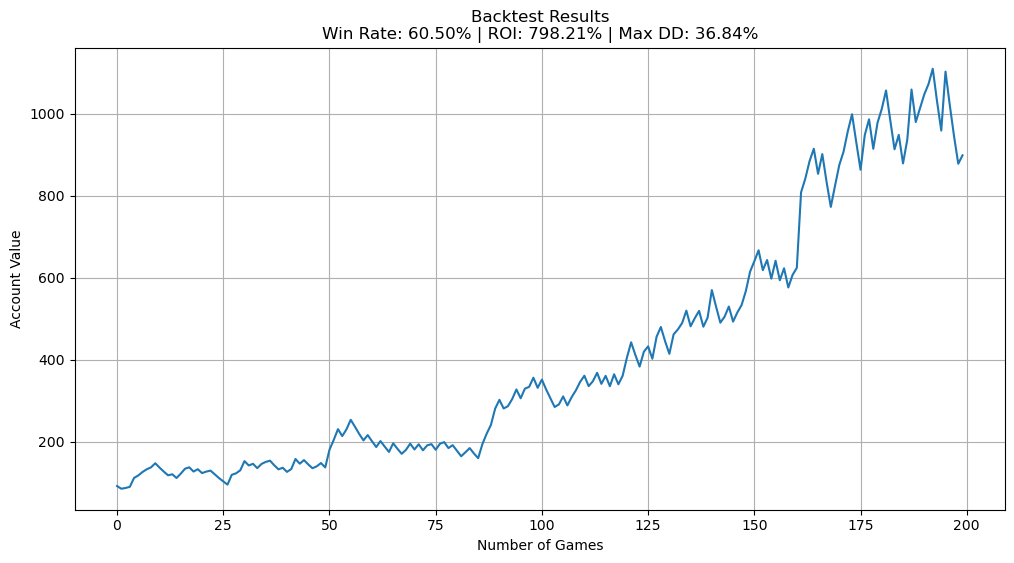

{'final_value': 898.2094277036159,
 'roi': 7.982094277036159,
 'win_rate': 0.605,
 'max_drawdown': 0.3683838132735739,
 'total_bets': 200}

In [36]:
nfl_utils.backtest_model(pipeline, perf_conts, perf_y_col, initial_capital=100, position_size=0.1, confidence_threshold=best_params['confidence_threshold'], show_plot=True)


In [18]:
# Remove outside of confidence threshold
mask = (probas < 0.5 - confidence_threshold) | (probas > 0.5 + confidence_threshold)
predictions = np.where(mask, probas, np.nan)

# Use numpy mask for nan values
valid_mask = ~np.isnan(predictions)
valid_predictions = predictions[valid_mask]
valid_mask = valid_mask.flatten()
perf_y_col_mask = perf_y_col[valid_mask]


true_values = perf_y_col_mask[:,0].astype(np.int32)
pred_values = valid_predictions.flatten()
pred_values_int = np.rint(valid_predictions).flatten().astype(np.int32)

model_win_prob = (1.0*(true_values == pred_values_int).sum()) / (true_values.shape[0])
print(model_win_prob)

0.605


# Using XGBoost

In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns # confusion matrix

In [23]:
conts_train.shape

(4541, 62)

In [17]:
# Fit the model
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],           # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3, 6, 9],                      # Simplified to 3 values, covering shallow to deep
    'n_estimators': [100, 200],                  # Removed extremes, these are most common sweet spots
    'subsample': [0.8, 1.0],                     # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.8, 1.0],              # Same as above
    'min_child_weight': [1, 3],                  # Removed 5 as it might be too restrictive
    # 'monotone_constraints': [monotone_constraints_tuple, no_monotone_constraints_tuple]
    'monotone_constraints': [no_monotone_constraints_tuple]
}

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


# Create a custom scorer using the F1 score
f1_scorer = make_scorer(f1_score, average='weighted')
# Tune hyperparameters using GridSearchCV with the custom F1 scorer
grid_search = GridSearchCV(model, param_grid, scoring=f1_scorer, cv=5, verbose=1)
grid_search.fit(conts_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


KeyboardInterrupt: 

In [39]:
print(grid_search.best_params_)
# No monotone constraints
# 60.15%, {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
# 65% {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}

# Monotone constraints
# {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'monotone_constraints': (1, 1, 1, 1, 1, 1, 0, 1, 1, -1, -1, 0, 1, 1, -1, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1), 'n_estimators': 200, 'subsample': 1.0}

{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'monotone_constraints': (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 'n_estimators': 200, 'subsample': 0.8}


In [19]:

# train final model w/ early stopping
model = XGBClassifier(
    eval_metric='logloss',
    early_stopping_rounds=10,
    # **grid_search.best_params_
    # **{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
    # **{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'monotone_constraints': (1, 1, 1, 1, 1, 1, 0, 1, 1, -1, -1, 0, 1, 1, -1, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1), 'n_estimators': 90, 'subsample': 1.0},
    
    # **{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'monotone_constraints': (1, 1, 1, 1, 1, 1, 0, 1, 1, -1, -1, 0, 1, 1, -1, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1), 'n_estimators': 200, 'subsample': 1.0}
#    **grid_search.best_params_,
    **{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'monotone_constraints': (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 'n_estimators': 200, 'subsample': 0.8}

)
model.fit(
    conts_train,
    y_train,
    eval_set=[(conts_train, y_train)], # , (holdout_conts, holdout_y)
    verbose=True
)

[0]	validation_0-logloss:0.69157
[1]	validation_0-logloss:0.69006
[2]	validation_0-logloss:0.68856
[3]	validation_0-logloss:0.68701
[4]	validation_0-logloss:0.68565
[5]	validation_0-logloss:0.68415
[6]	validation_0-logloss:0.68270
[7]	validation_0-logloss:0.68122
[8]	validation_0-logloss:0.67970
[9]	validation_0-logloss:0.67837
[10]	validation_0-logloss:0.67697
[11]	validation_0-logloss:0.67568
[12]	validation_0-logloss:0.67442
[13]	validation_0-logloss:0.67314
[14]	validation_0-logloss:0.67169
[15]	validation_0-logloss:0.67045
[16]	validation_0-logloss:0.66926
[17]	validation_0-logloss:0.66791
[18]	validation_0-logloss:0.66668
[19]	validation_0-logloss:0.66550
[20]	validation_0-logloss:0.66431
[21]	validation_0-logloss:0.66303
[22]	validation_0-logloss:0.66169
[23]	validation_0-logloss:0.66060
[24]	validation_0-logloss:0.65924
[25]	validation_0-logloss:0.65799
[26]	validation_0-logloss:0.65672
[27]	validation_0-logloss:0.65546
[28]	validation_0-logloss:0.65420
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=3, missing=nan,
              monotone_constraints=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...),
              n_estimators=200, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

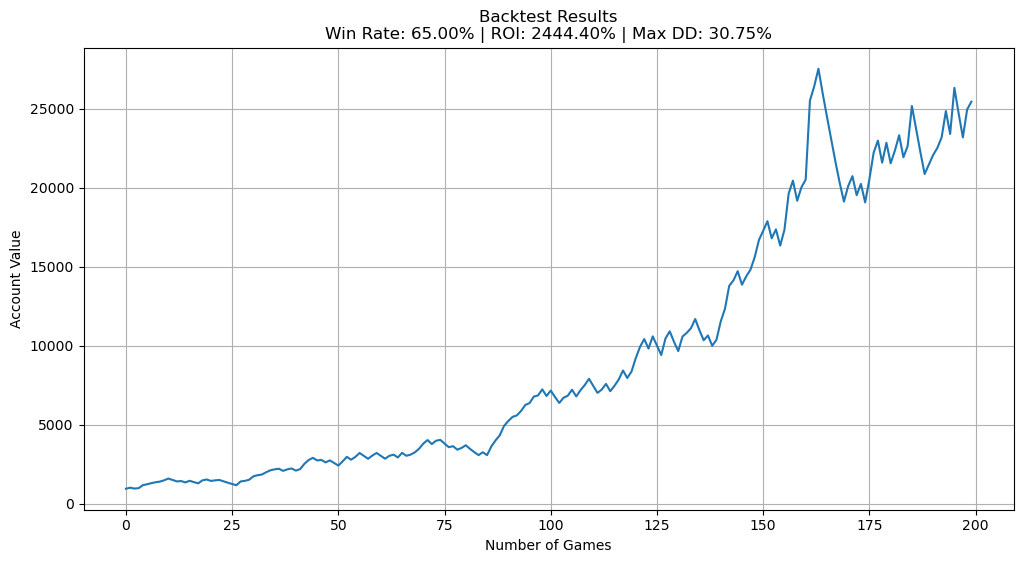

{'final_value': 25444.00951715869,
 'roi': 24.44400951715869,
 'win_rate': 0.65,
 'max_drawdown': 0.3074595573926224,
 'total_bets': 200}

In [24]:
# Make predictions for test data
# model = grid_search.best_estimator_
y_pred = model.predict(perf_conts)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(perf_y_col[:,0], predictions)

nfl_utils.backtest_model(model, perf_conts, perf_y_col, initial_capital=1000, position_size=0.08, 
                   confidence_threshold=0, show_plot=True)

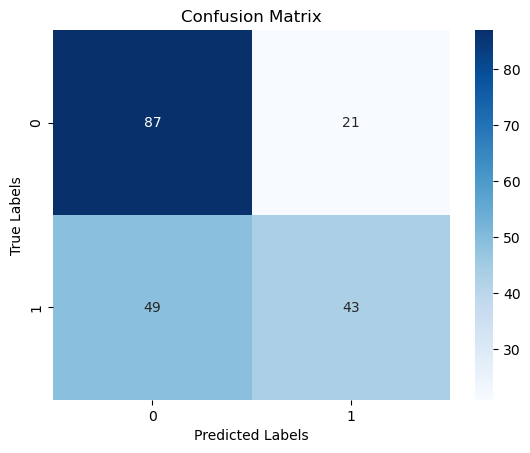

In [21]:
# Make confusion matrix
cm = confusion_matrix(perf_y_col[:,0], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Save XGBoost model

In [22]:
model.save_model('xgboost_model.bin')